# Timeline Visualization

Notebook to visualize how accesses move across data during an iteration and across iterations.

Idea: make a 2d plot representing "aging" of data access across execution.

In [1]:
# import the miniapp code and numpy for data management
import main
import numpy as np

In [2]:
# class version of the tracer, to allow for cross-loop analysis
class Timeline:
    def __init__(self, dims, blocking=1):
        self.timeline = np.zeros(tuple(dims))
        self.time = 0
        self.block = blocking
        
    def reset(self):
        self.timeline = np.zeros(self.timeline.shape)
        self.time = 0
        
    def __add_last(self, i, j, k, l):
        timeblock = int(self.time / self.block)
        self.timeline[i,j,k,l] = timeblock
        self.time += 1
    
    def __add_count(self, i, j, k, l):
        self.timeline[i,j,k,l] += 1
        
    def add(self, i, j, k, l):
        self.__add_last(i,j,k,l)
        
    def view2d(self):
        x,y,z,t = self.timeline.shape
        return np.copy(self.timeline.reshape(x*y, z*t))

In [3]:
def integral_size(d_two_e_integral):
    # figure out the size of the integrals space
    maxs = [0,0,0,0]
    for t in d_two_e_integral:
        for i,x in enumerate(t):
            maxs[i] = max(maxs[i], x)
    maxs = [ i+1 for i in maxs]
    return maxs

# Subclass an object of the miniapp to trace some of its functions
class TracedHamiltonian(main.Hamiltonian):
    def __init__(self, timeline, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.timeline = timeline
        
    def H_two_e(self, i, j, k, l):
        self.timeline.add(i,j,k,l)
        return super().H_two_e(i,j,k,l)

## Trace over a single inner step

Here we just run a simple example, with a traced Hamiltonian and a single pass on the inner loop.

In [4]:
fci_path = 'f2_631g.FCIDUMP'
wf_path = 'f2_631g.30det.wf'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
timeline = Timeline(integral_size(d_two_e_integral))
lewis = TracedHamiltonian(timeline, d_one_e_integral, d_two_e_integral, E0)
main.Powerplant(lewis, psi_det).E(psi_coef)

-198.73878098910563

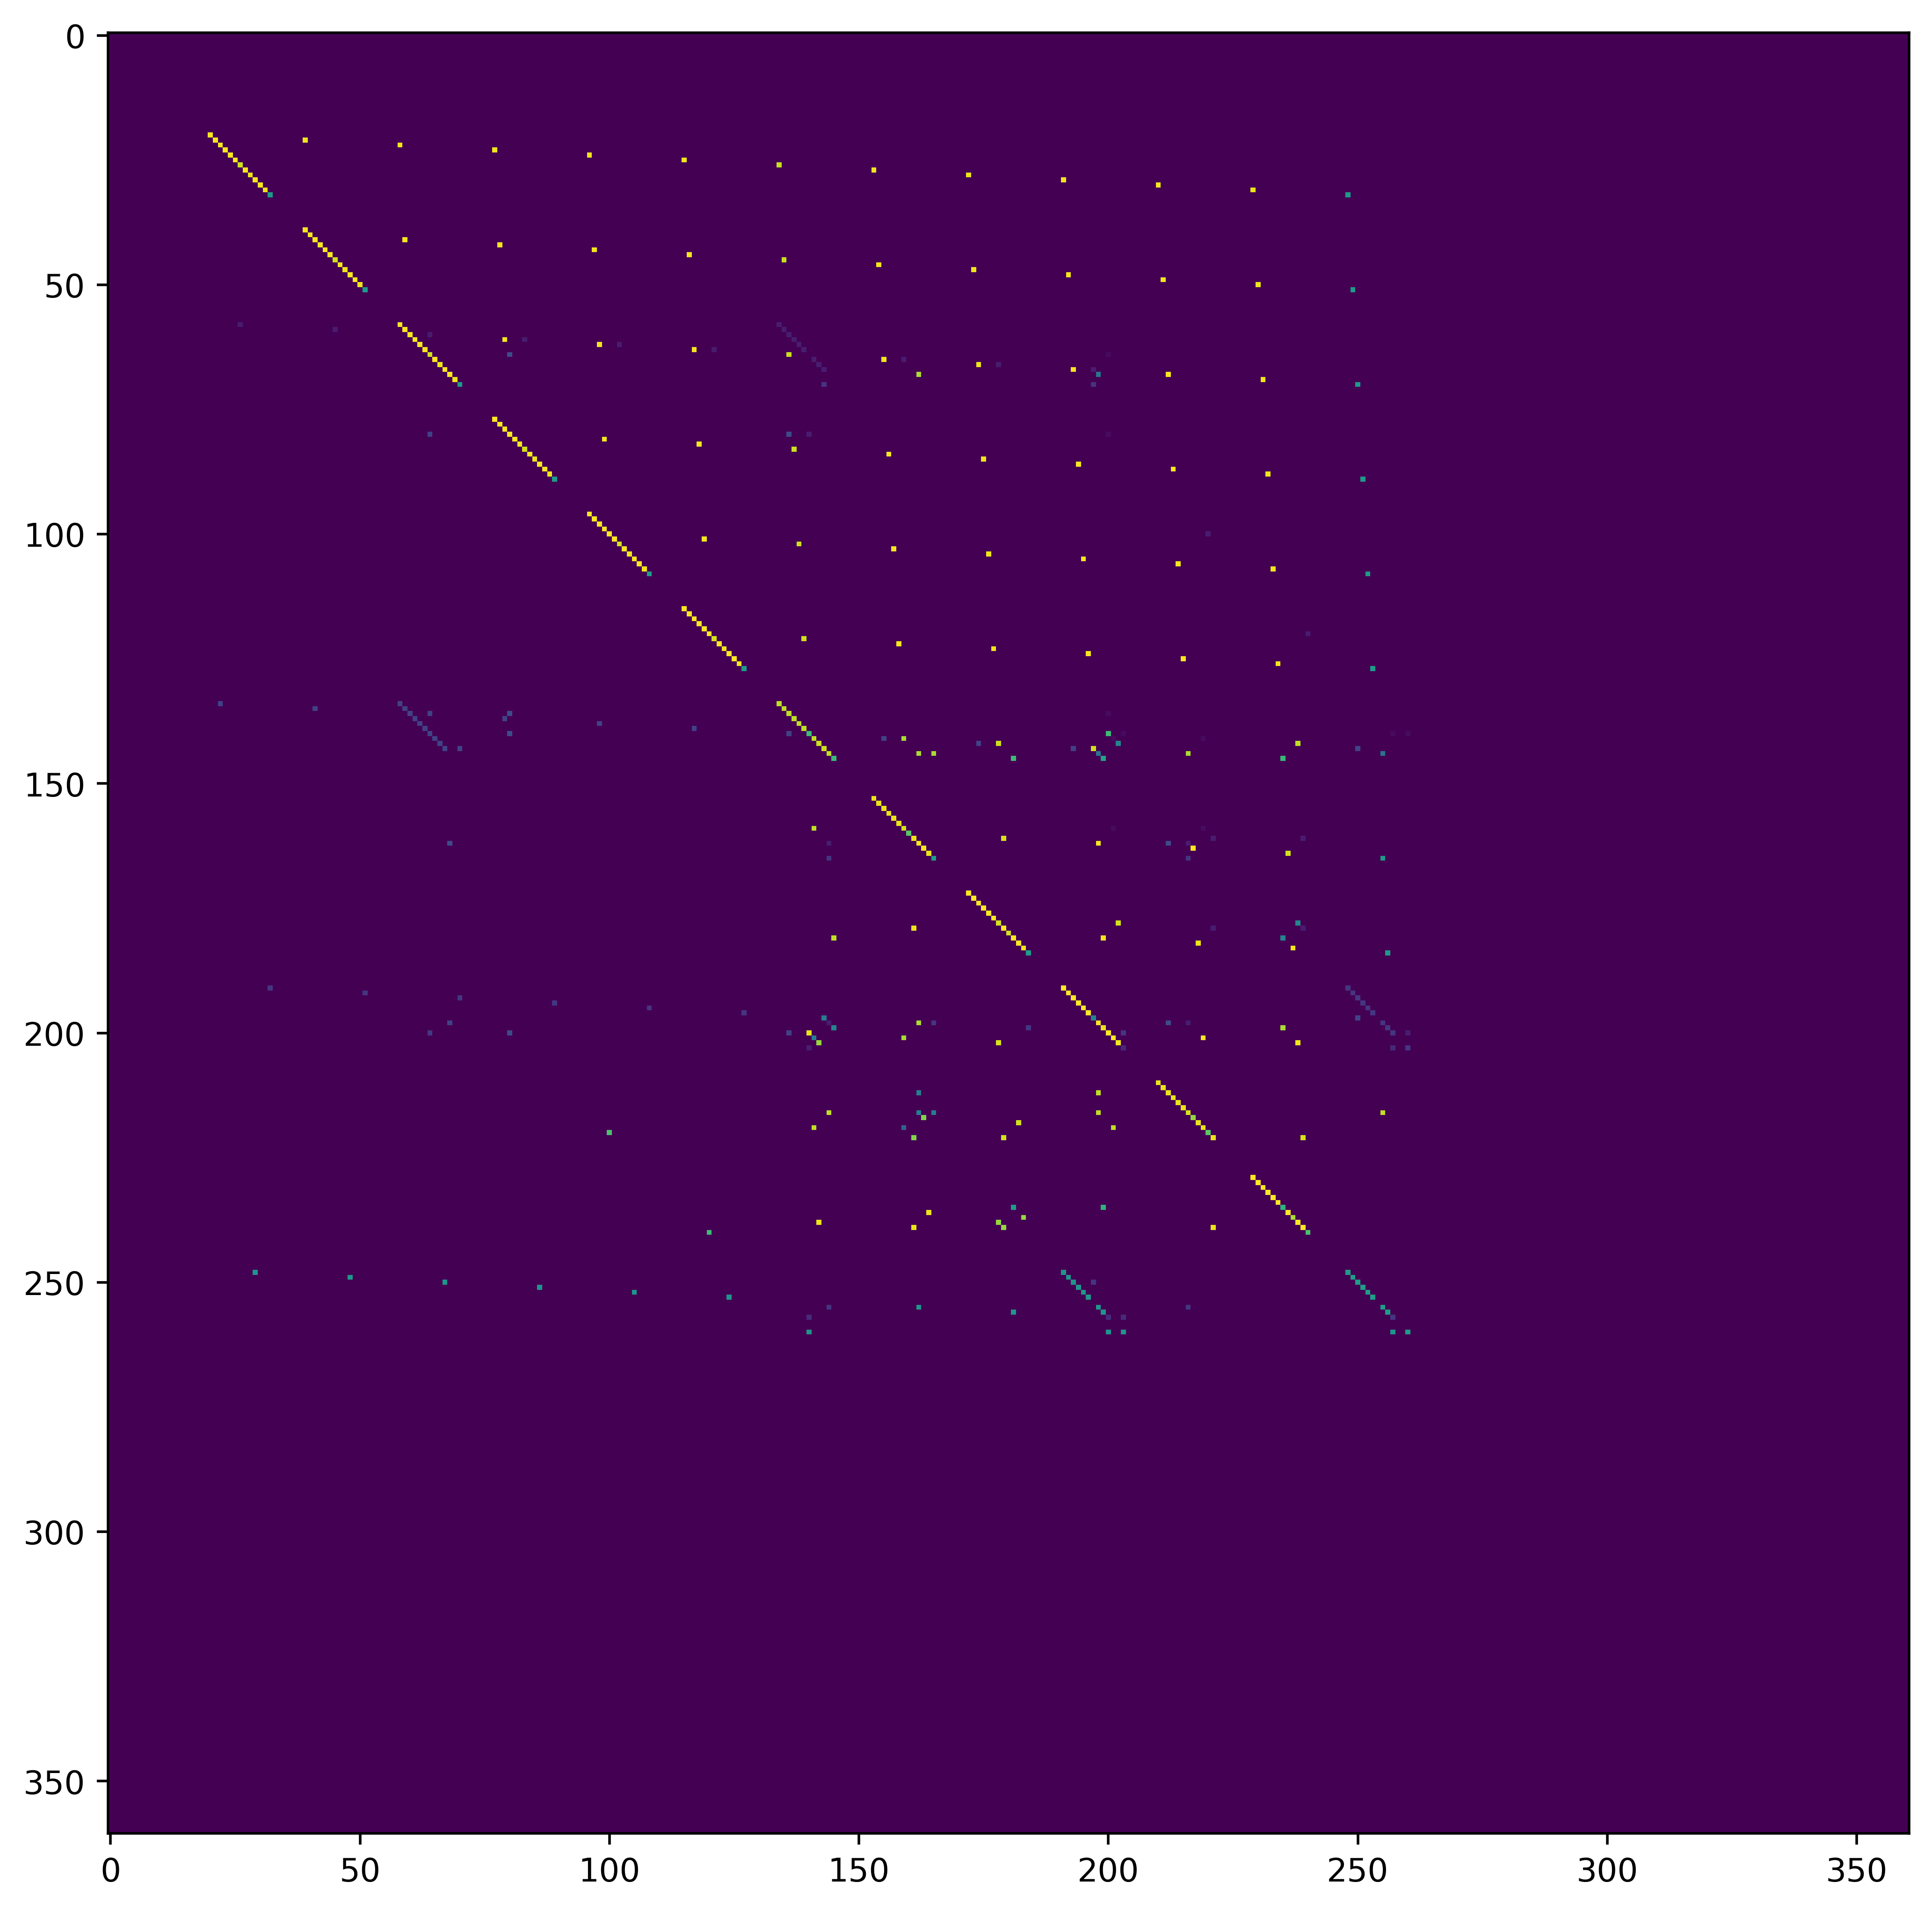

In [6]:
# Retrieve a 2d view and plot it
import matplotlib.pyplot as plt


view = lewis.timeline.view2d()
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 500
plt.imshow(view, cmap='viridis')
plt.show()

## Tracing across several inner loops

Note that we use checkpoints to avoid executing the PT2, that is too expensive in this case

In [27]:
# if you need profiling, this is a single step with Timings for the core code
import cProfile
i = 7
fci_path='c2_eq_hf_dz.fcidump*'
wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
timeline = Timeline(integral_size(d_two_e_integral))
lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
cProfile.run("main.Powerplant(lewis, psi_det).E(psi_coef)")

         1684442 function calls in 0.776 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(einsum)
    74940    0.045    0.000    0.045    0.000 <ipython-input-2-3241d171d14b>:12(__add_last)
    74940    0.016    0.000    0.060    0.000 <ipython-input-2-3241d171d14b>:20(add)
    74940    0.040    0.000    0.120    0.000 <ipython-input-3-014436b10f3d>:16(H_two_e)
        1    0.000    0.000    0.776    0.776 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 einsumfunc.py:1004(einsum)
        6    0.000    0.000    0.000    0.000 einsumfunc.py:995(_einsum_dispatcher)
     5600    0.001    0.000    0.001    0.000 main.py:307(H_one_e)
    74940    0.019    0.000    0.019    0.000 main.py:313(H_two_e)
    25628    0.088    0.000    0.104    0.000 main.py:321(get_phase_idx_single_exc)
   272692    0.016    0.000    0.016    0.000 main.py

### Tracing without memory

Trace with a new timeline at every step

In [59]:
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
timeline = Timeline(integral_size(d_two_e_integral))

nomem_maps = []
for i in range(1, 11):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    timeline.reset()
    lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
    main.Powerplant(lewis, psi_det).E(psi_coef)
    nomem_maps.append(lewis.timeline.view2d())

95.0


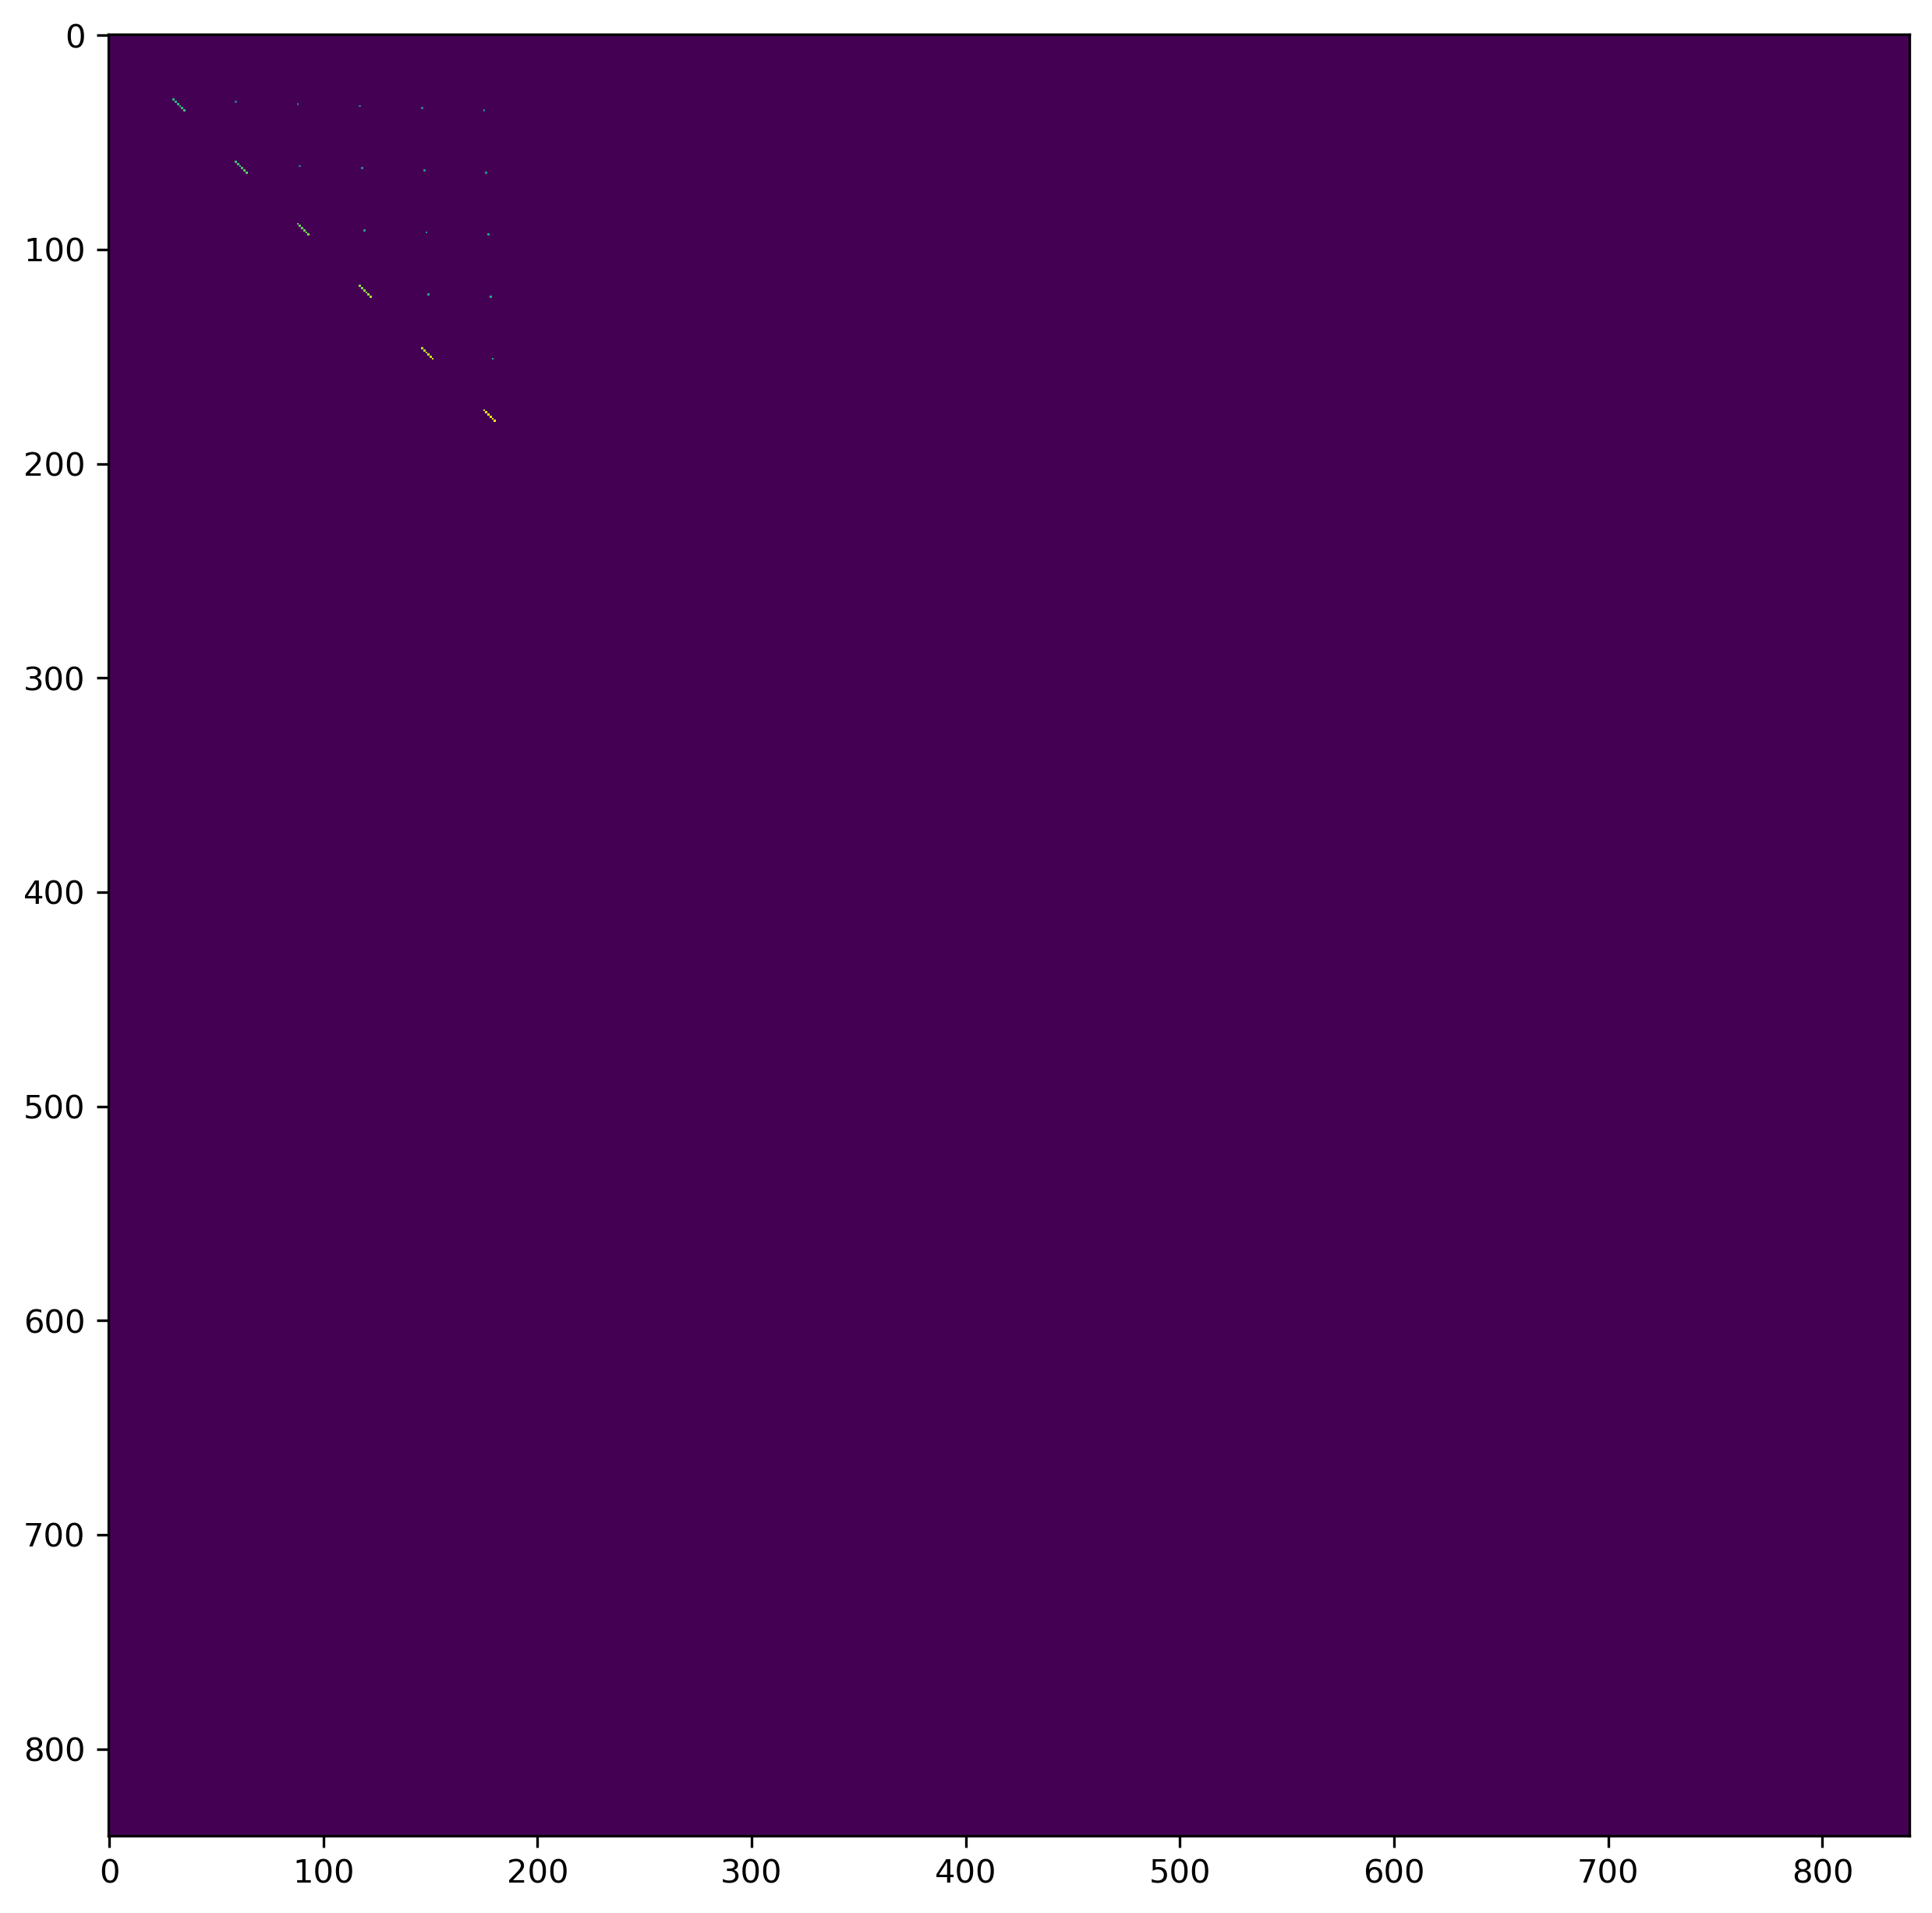

825.0


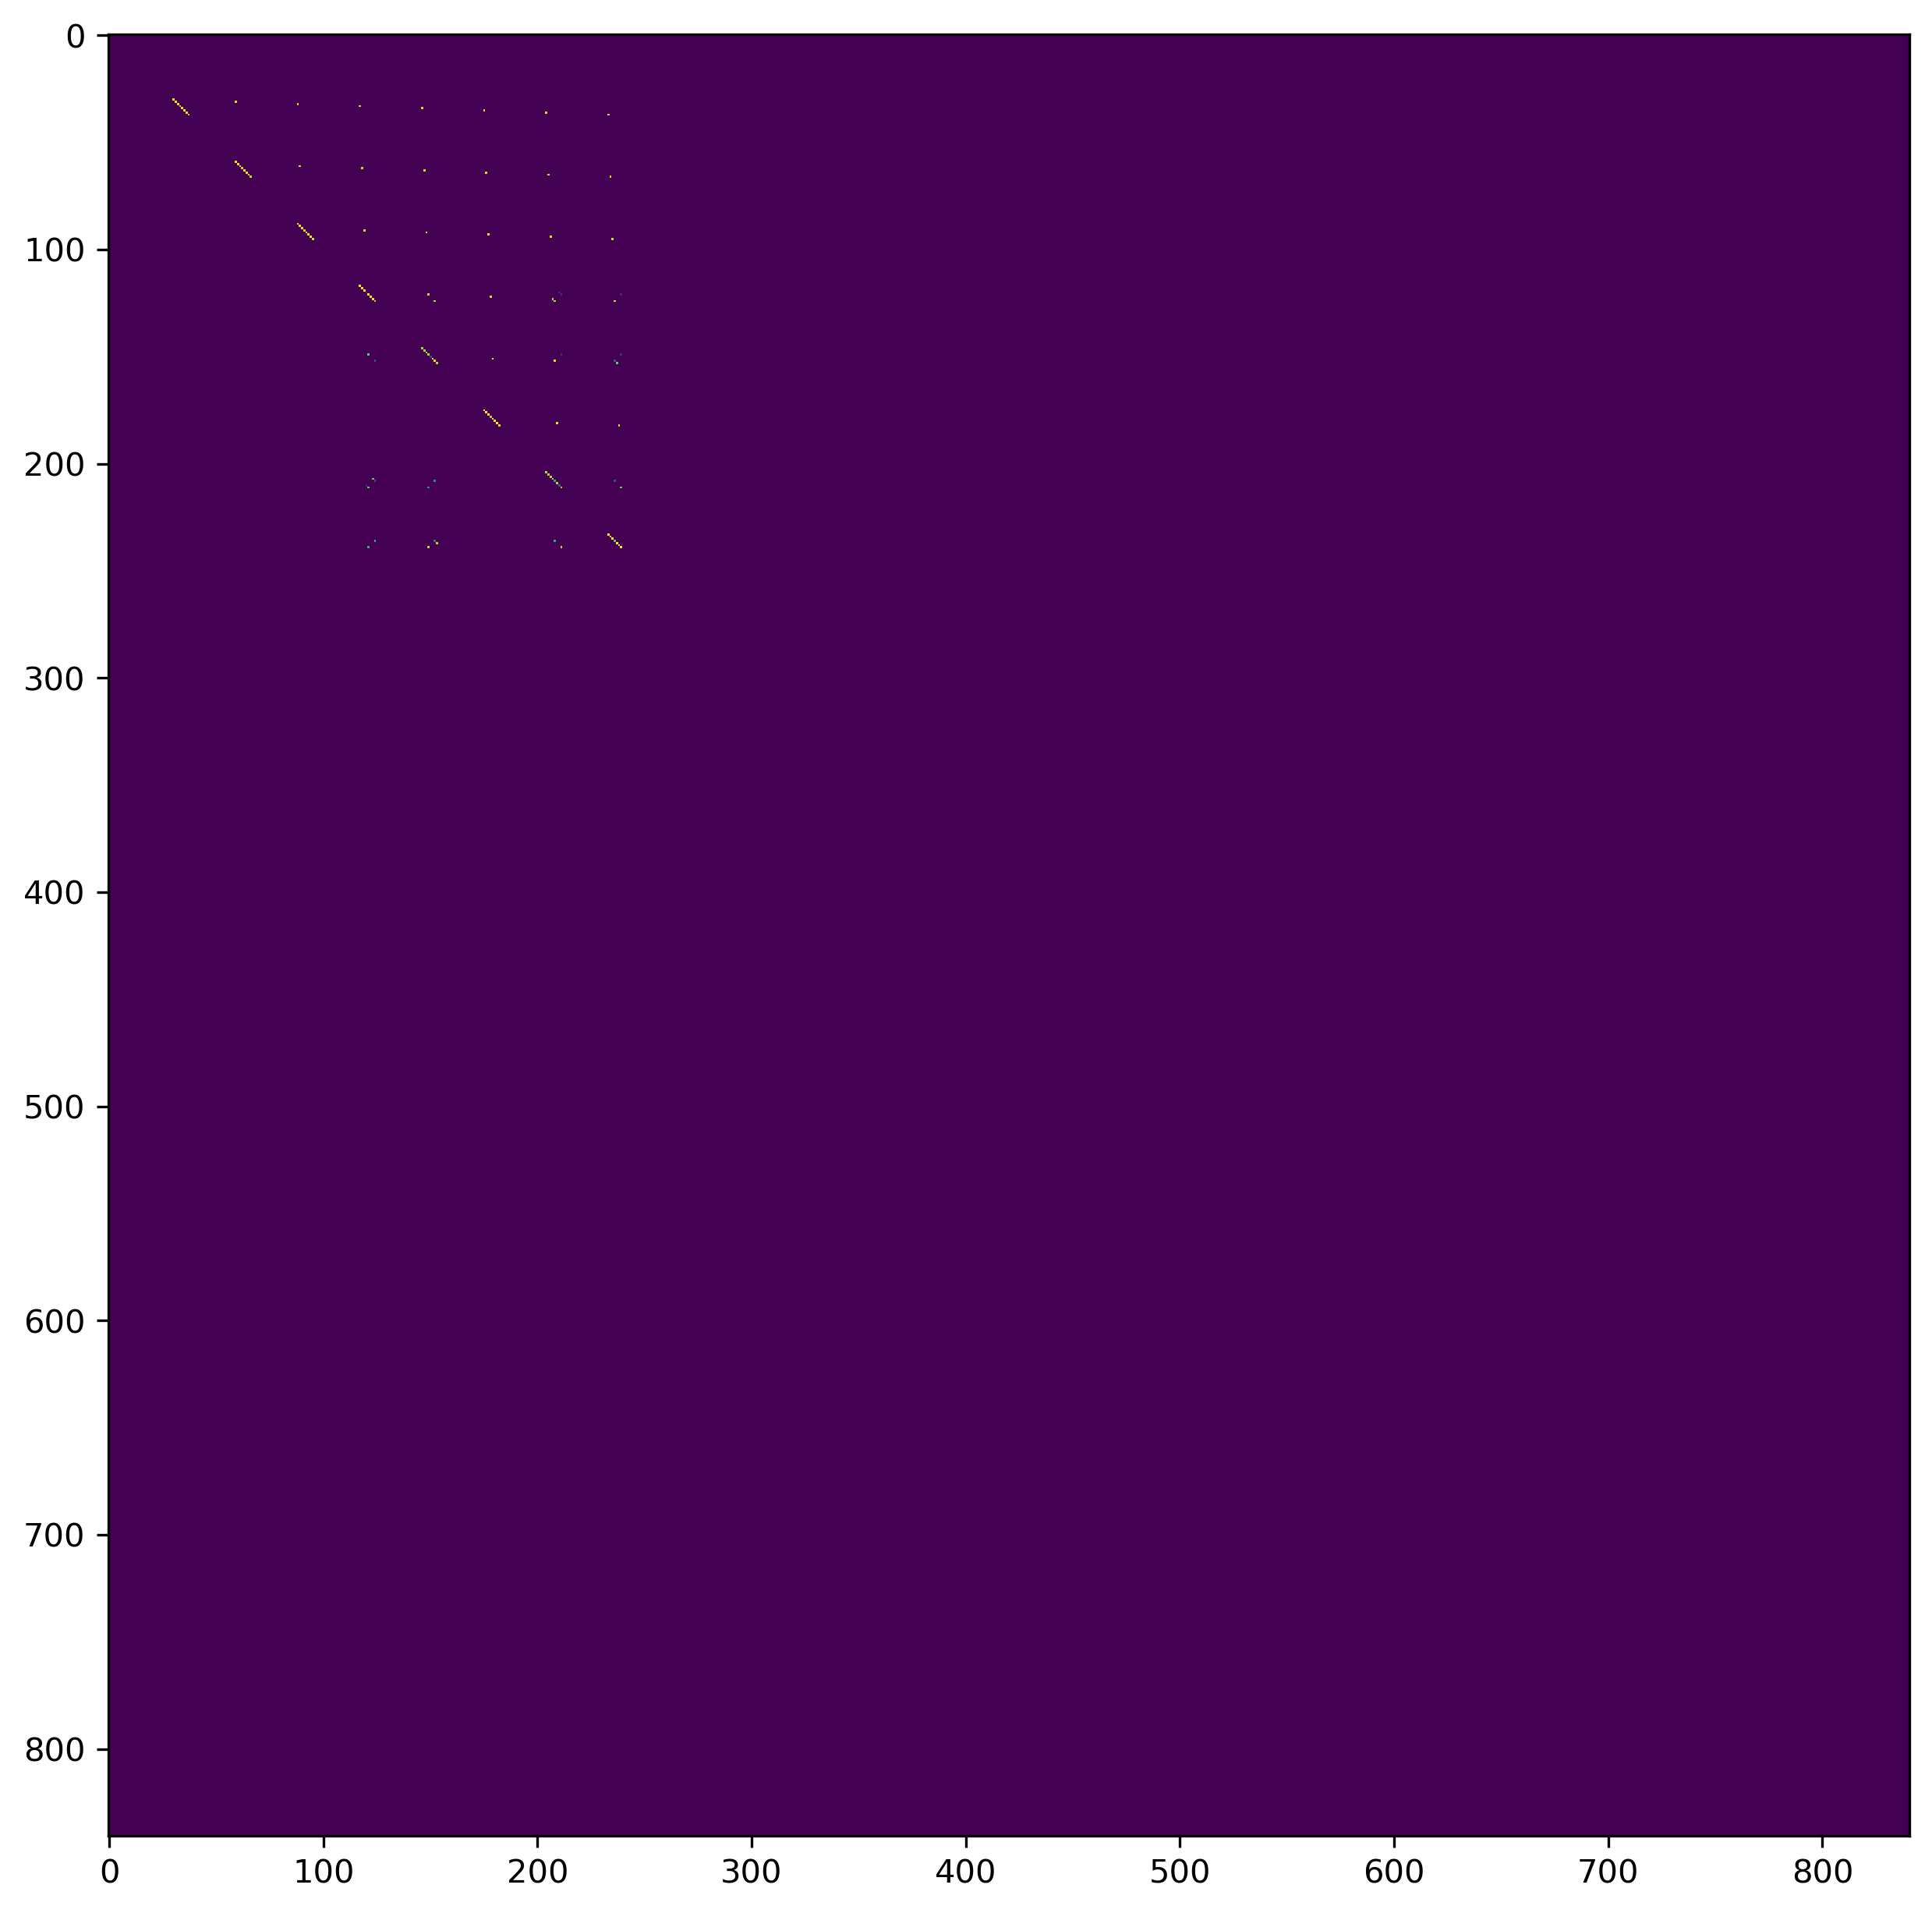

2417.0


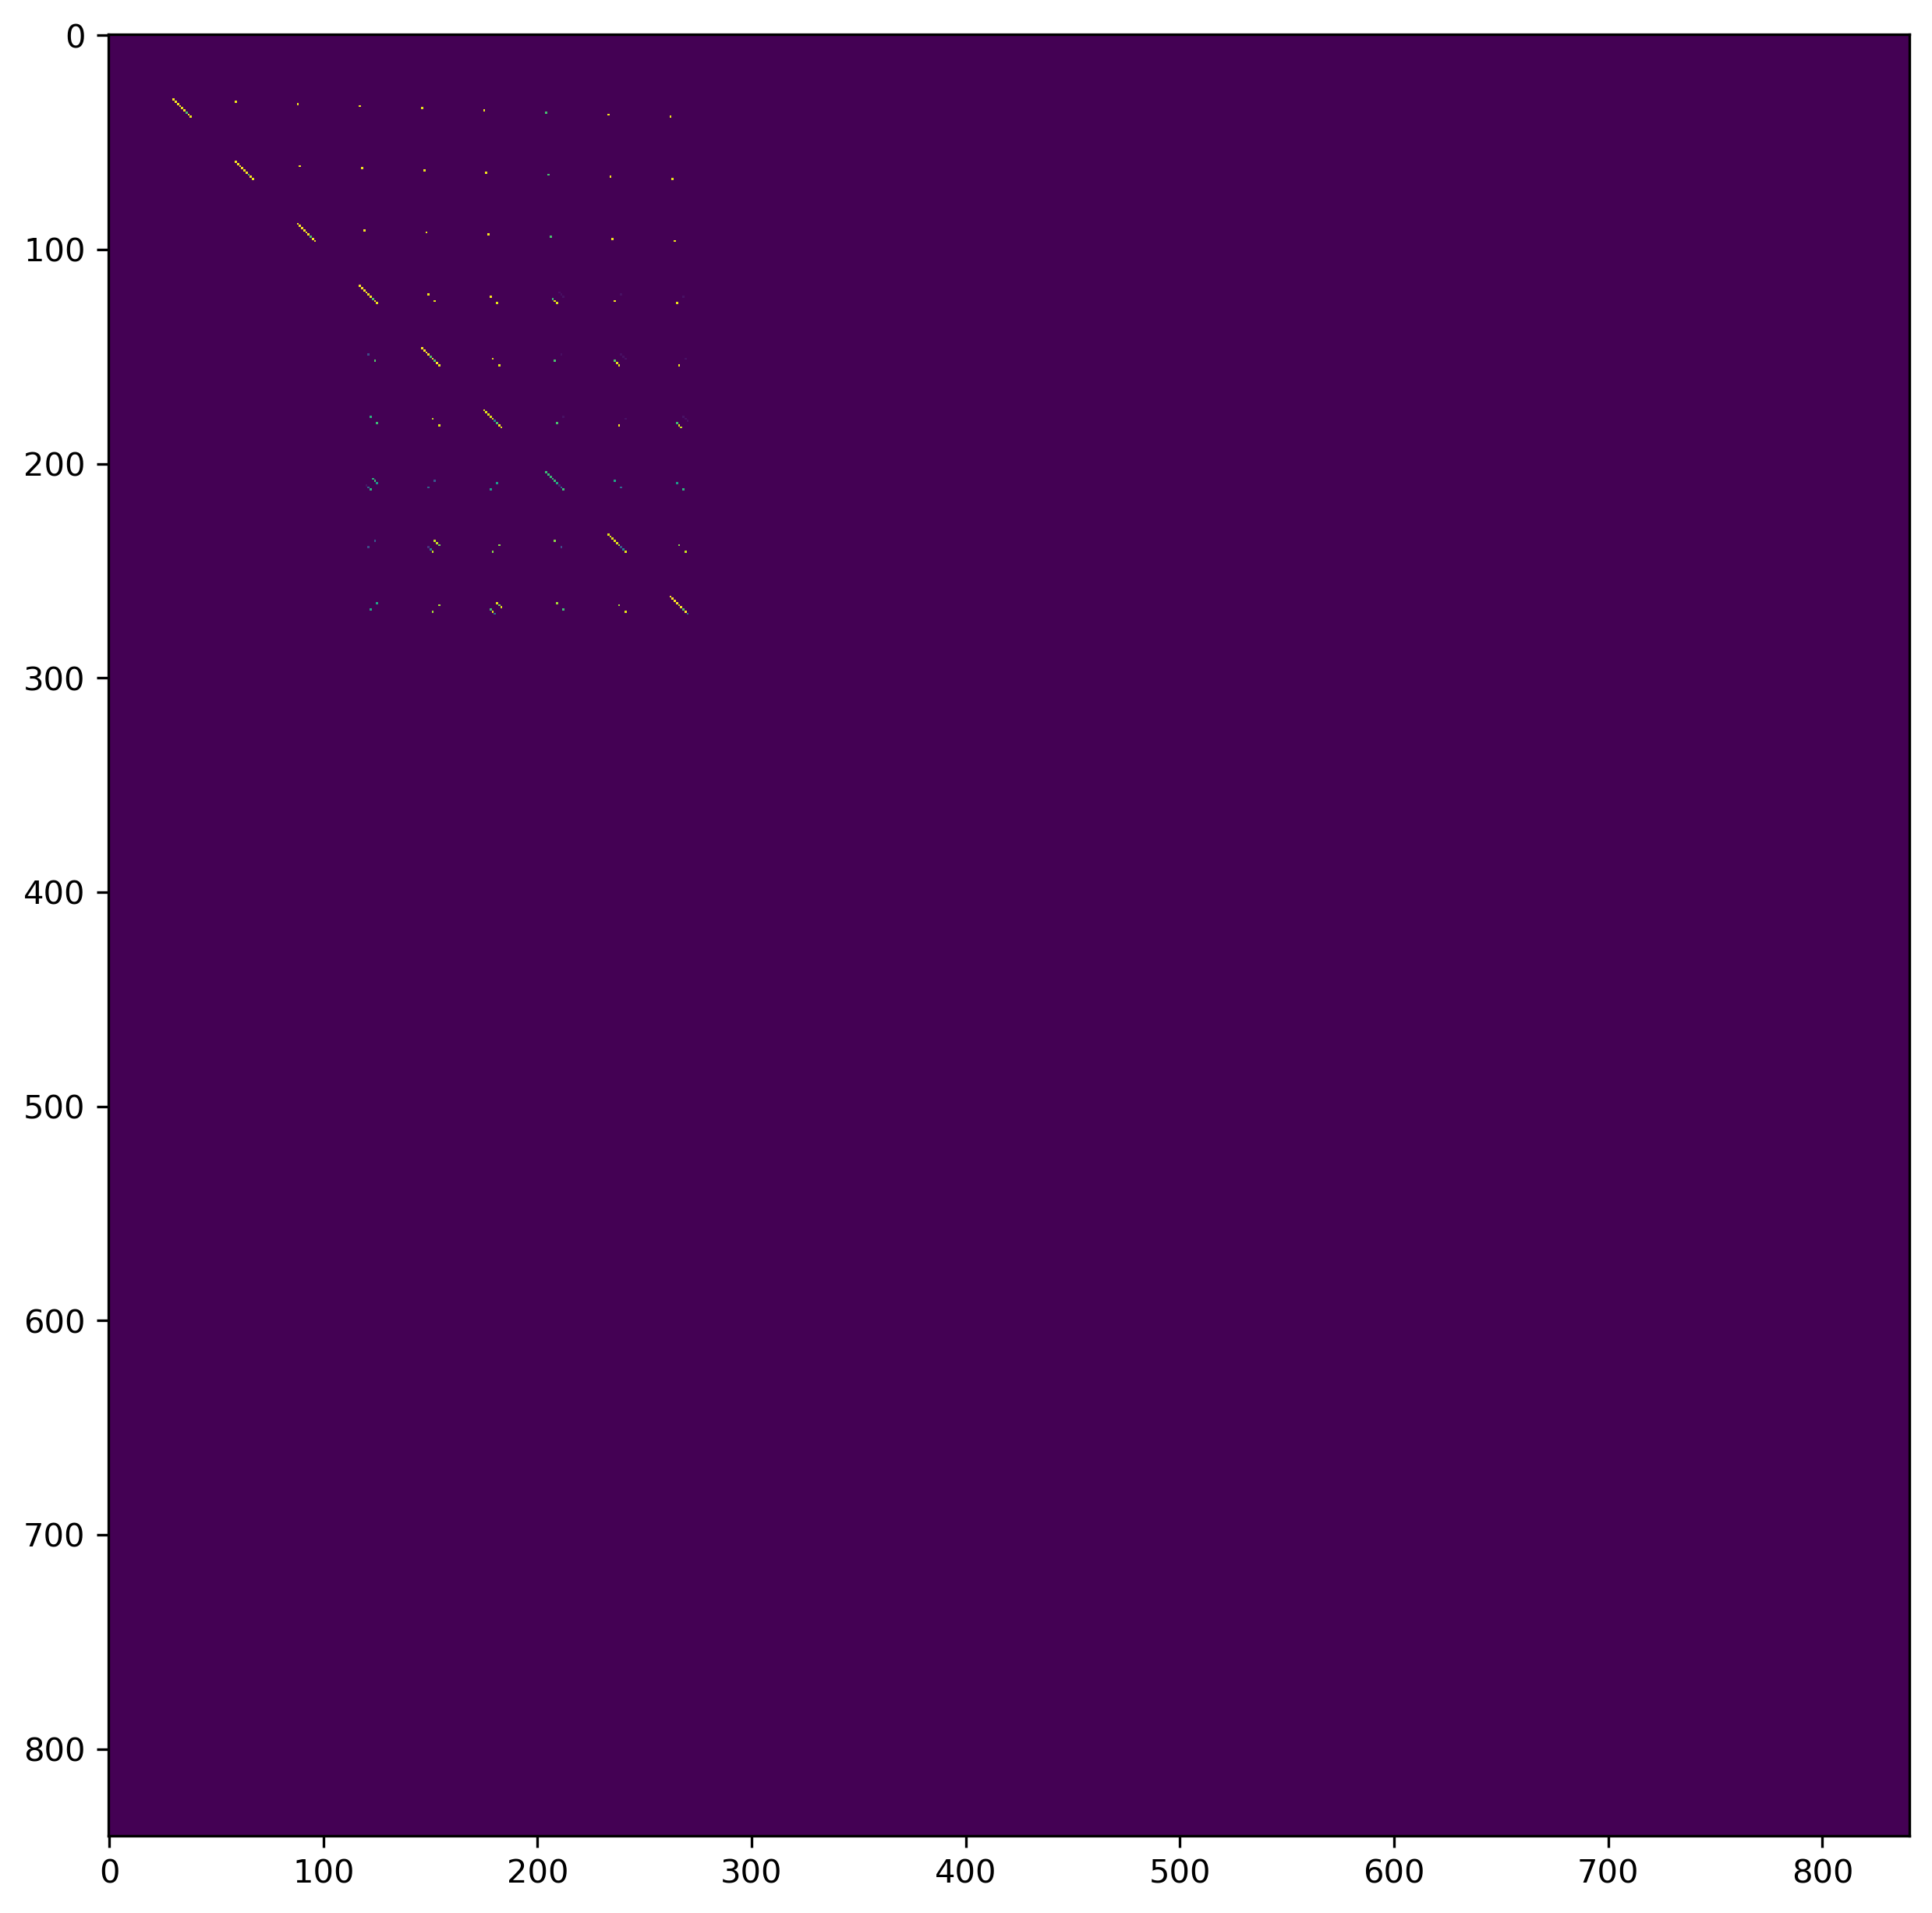

5467.0


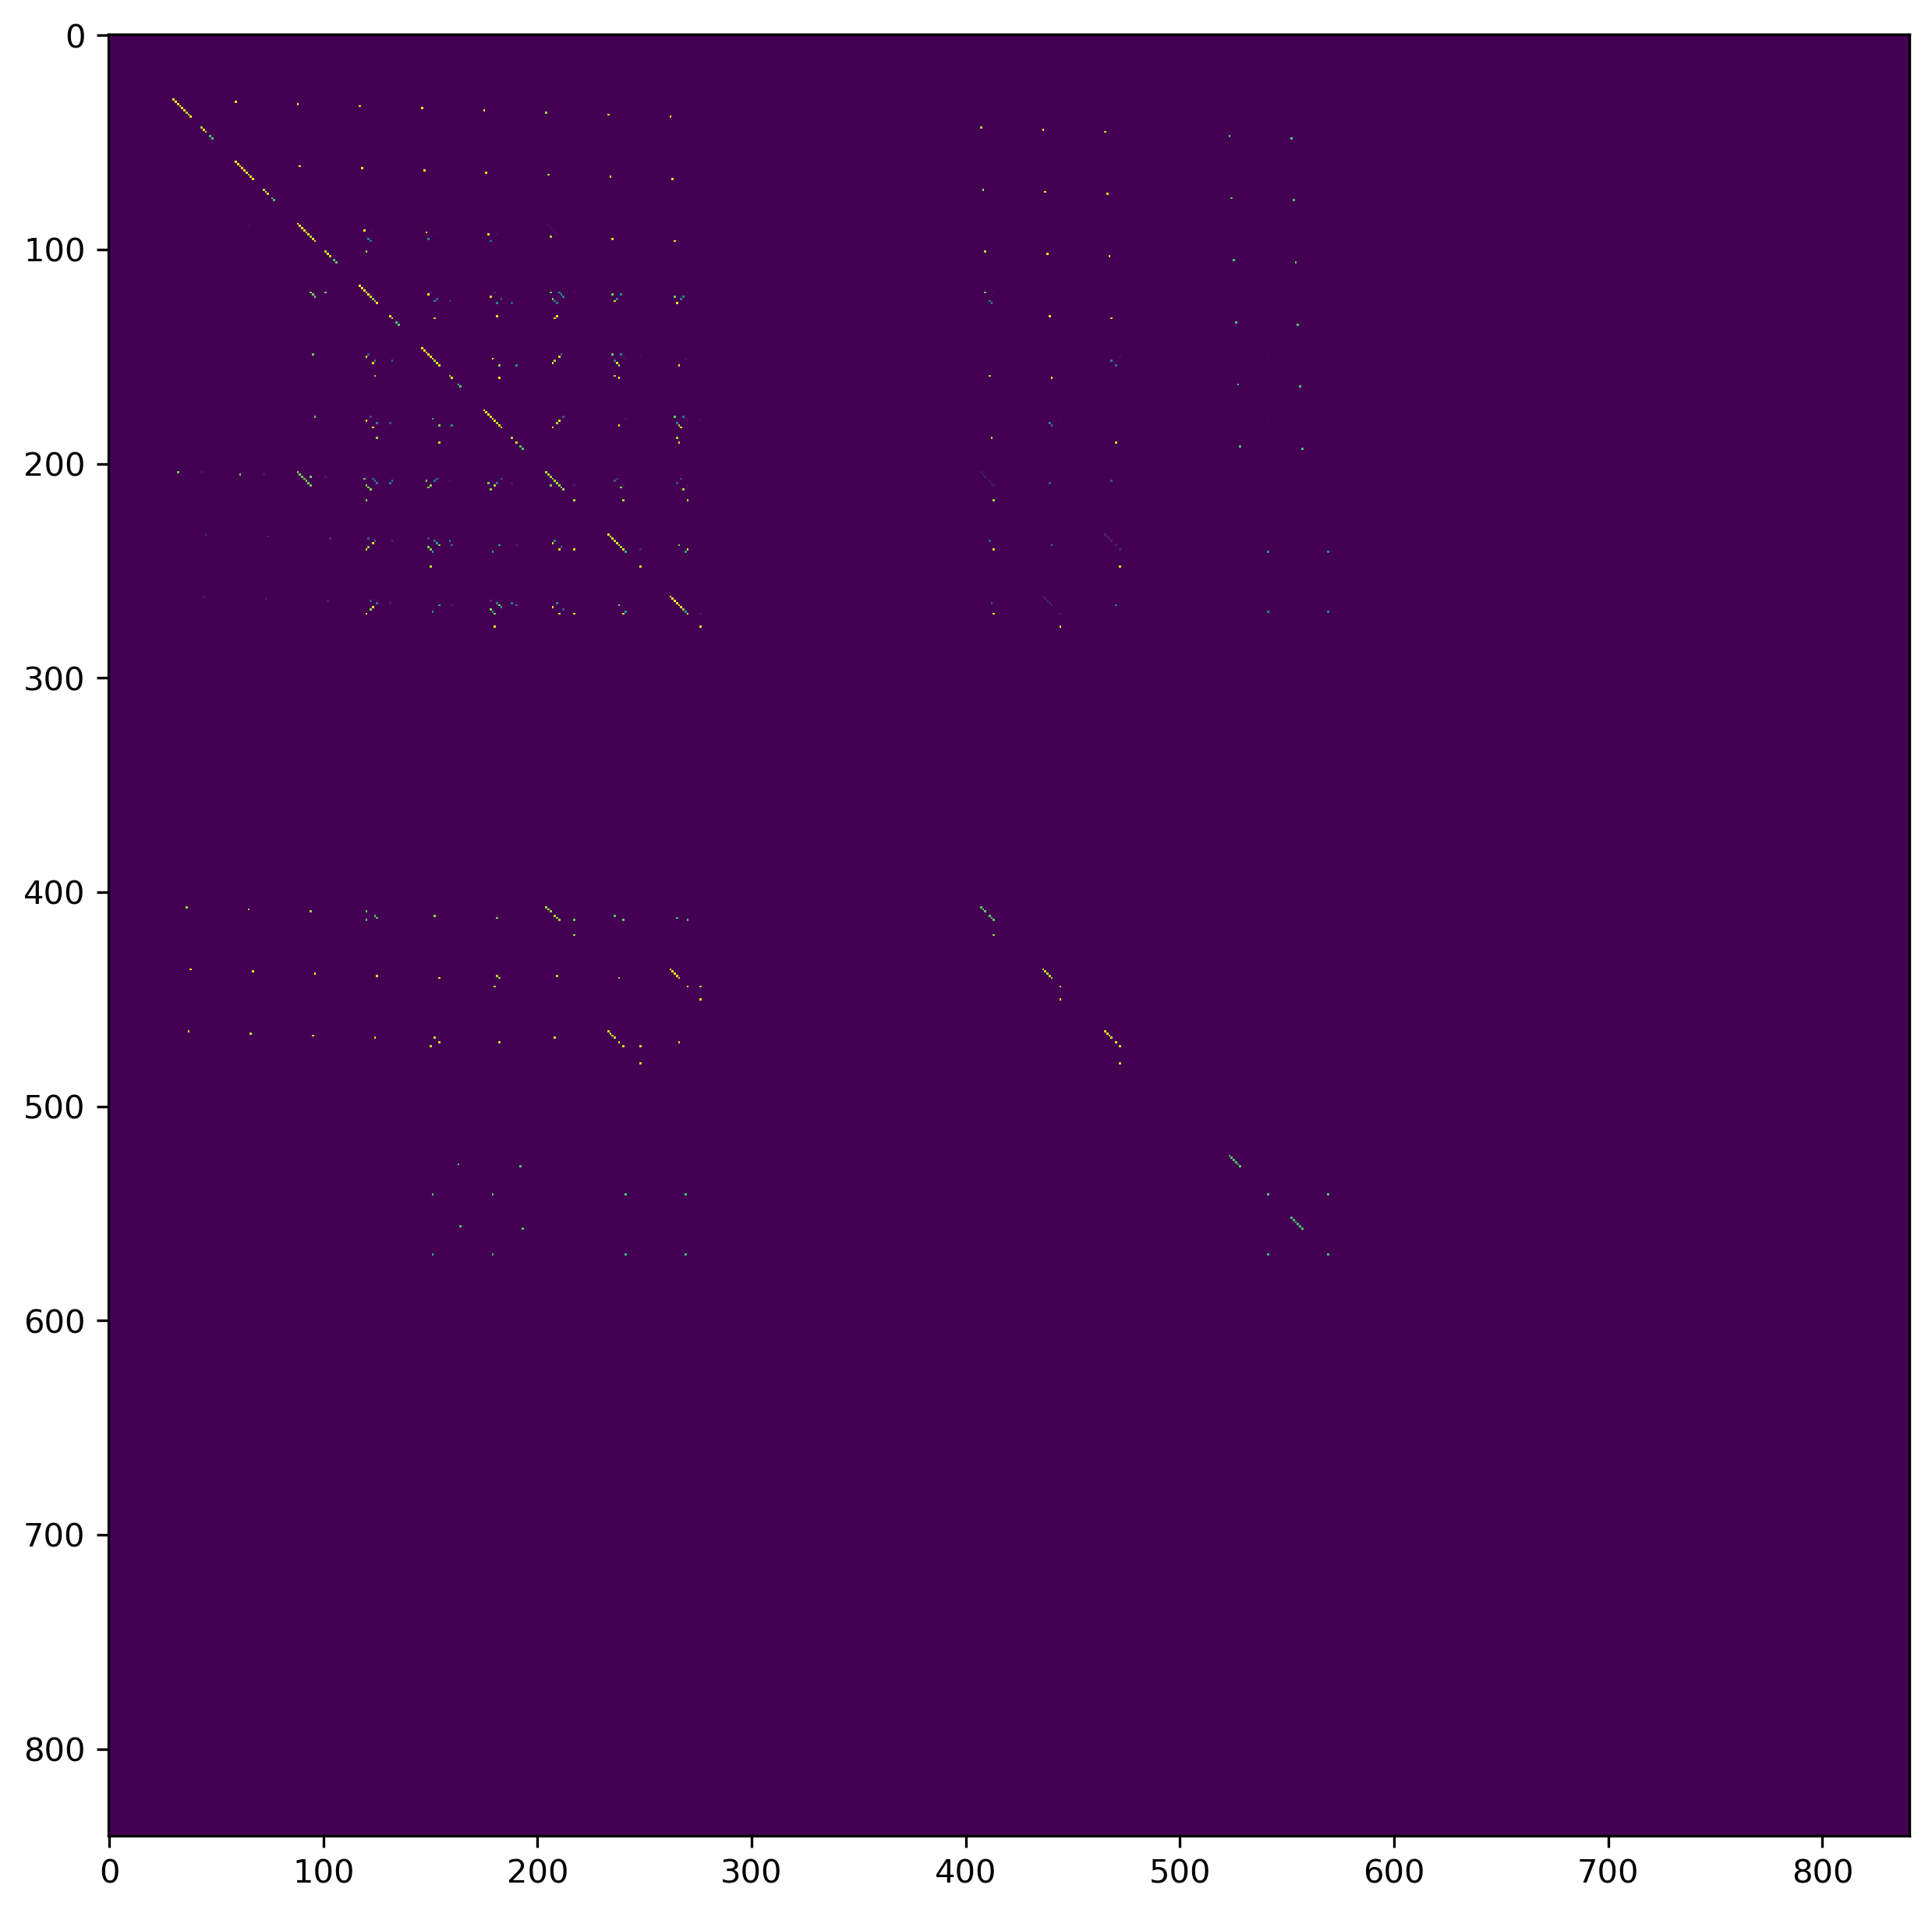

14689.0


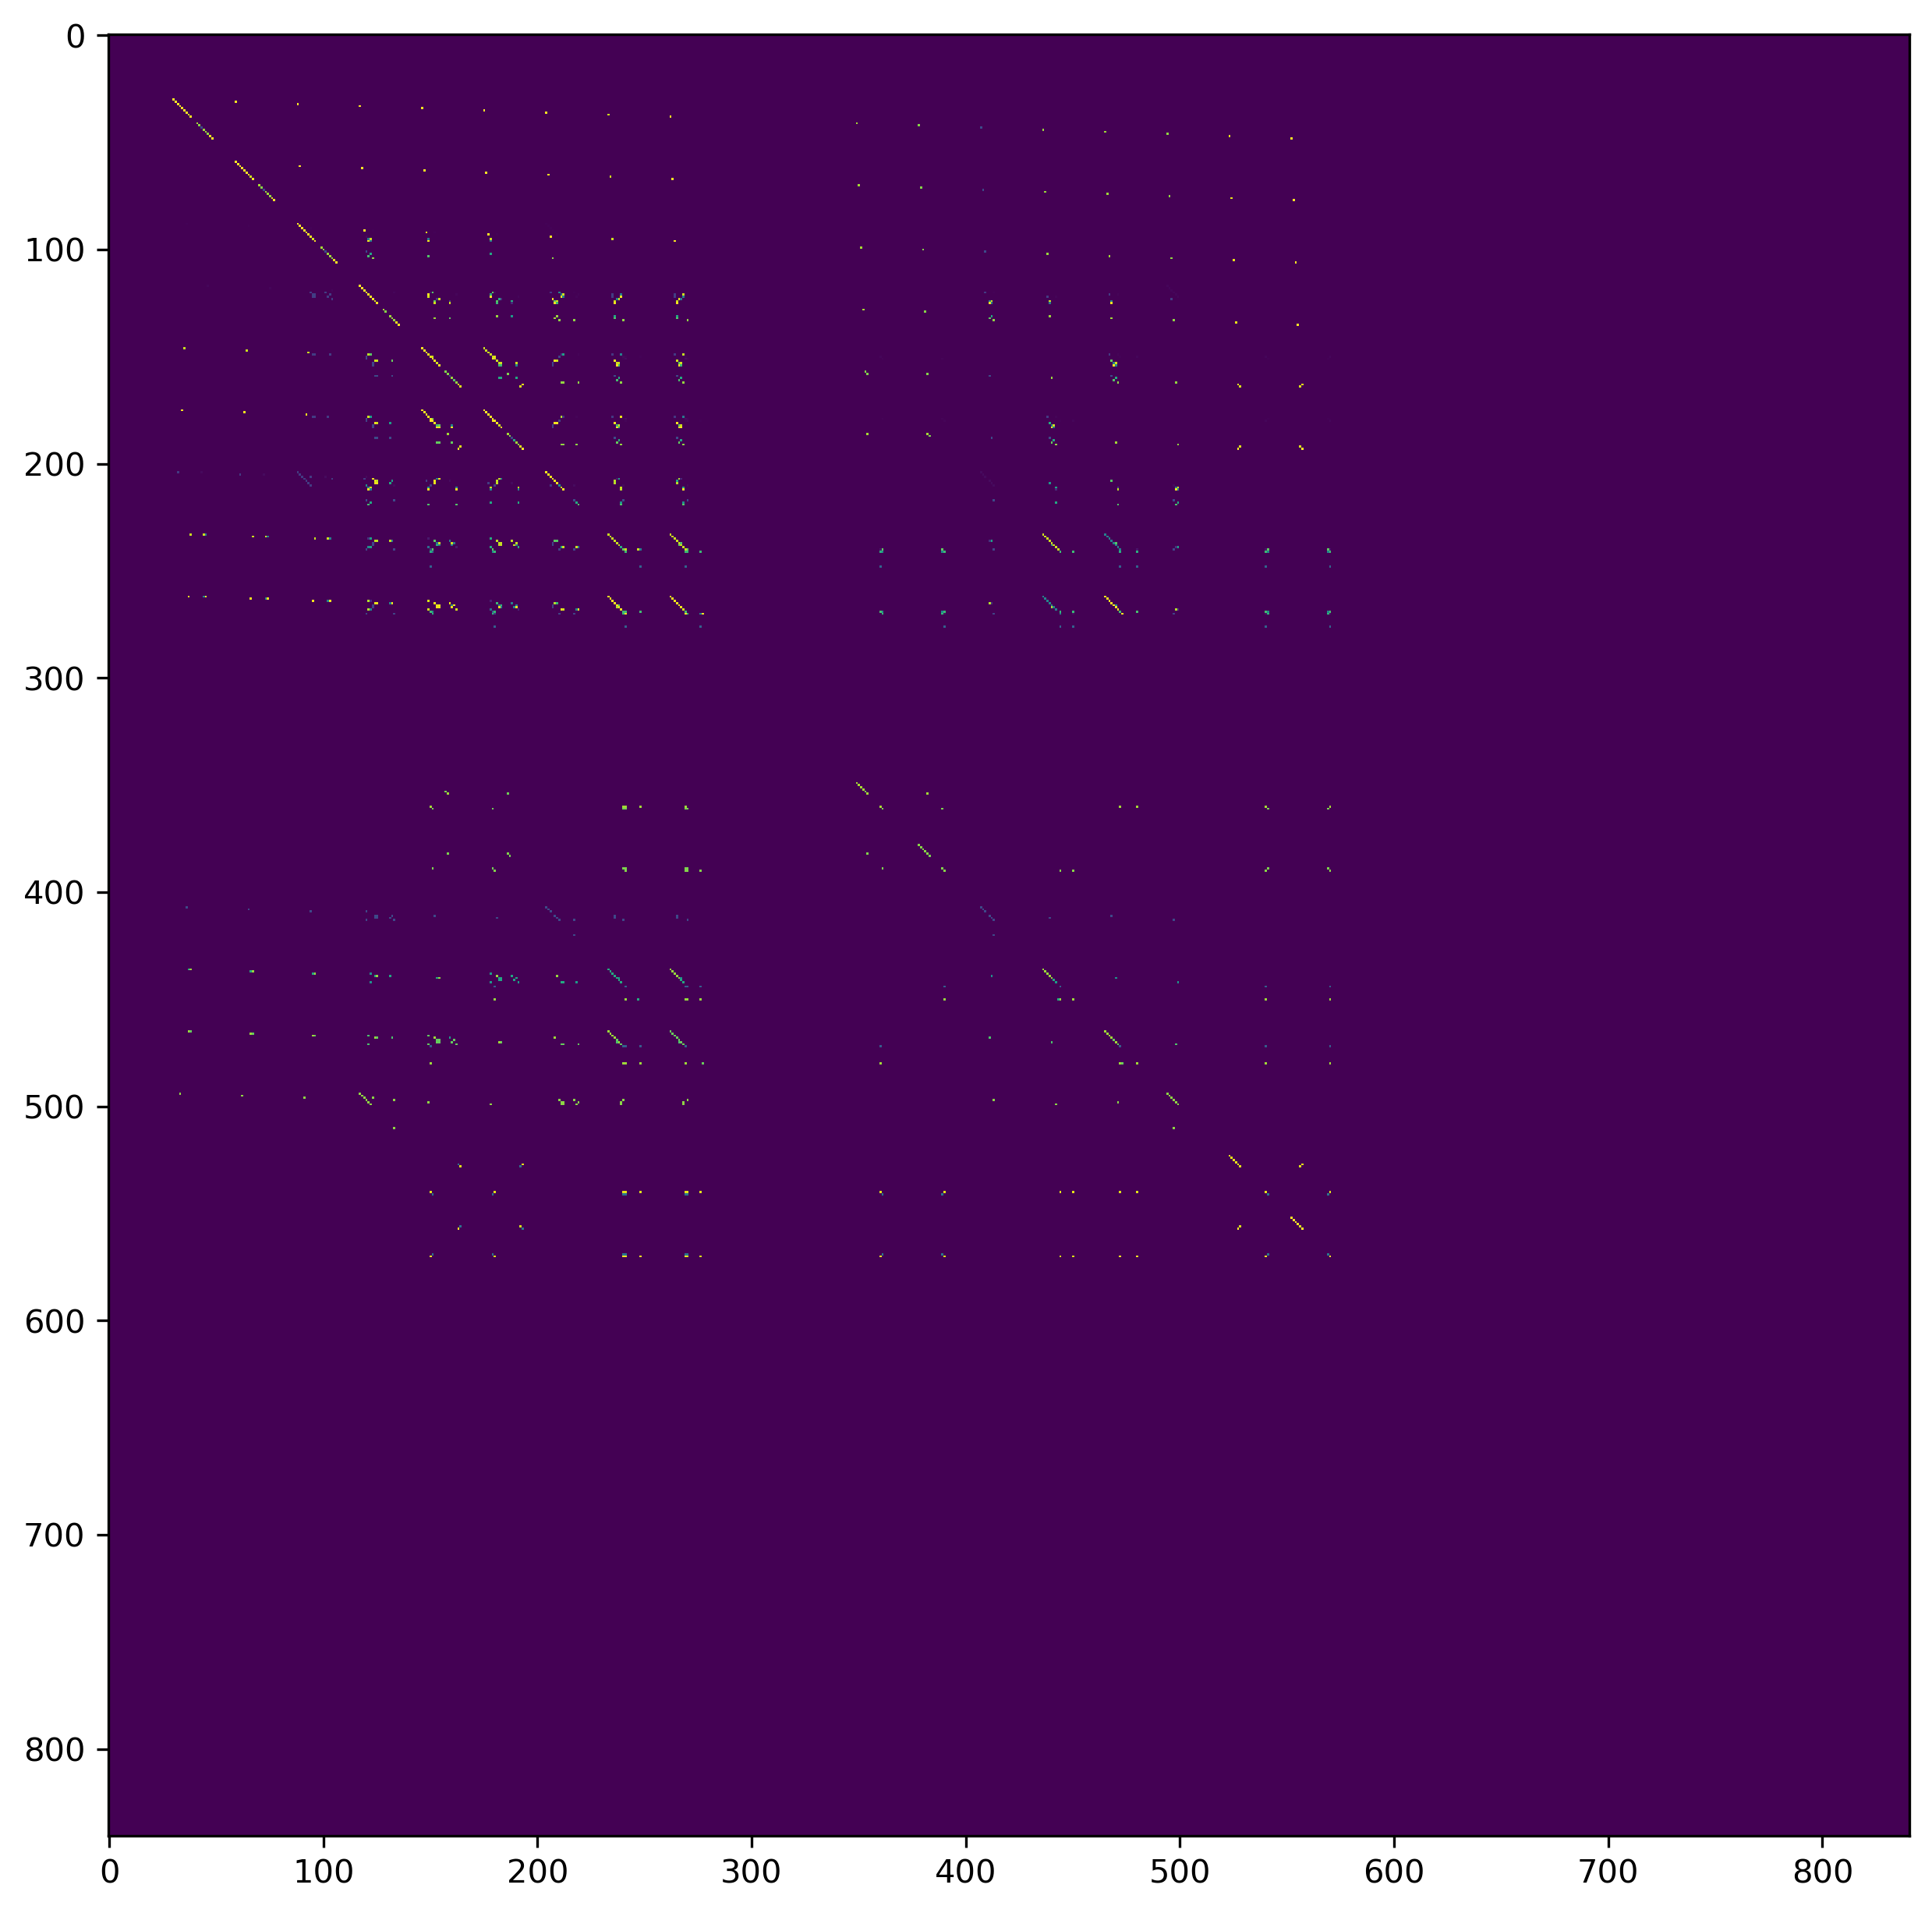

33367.0


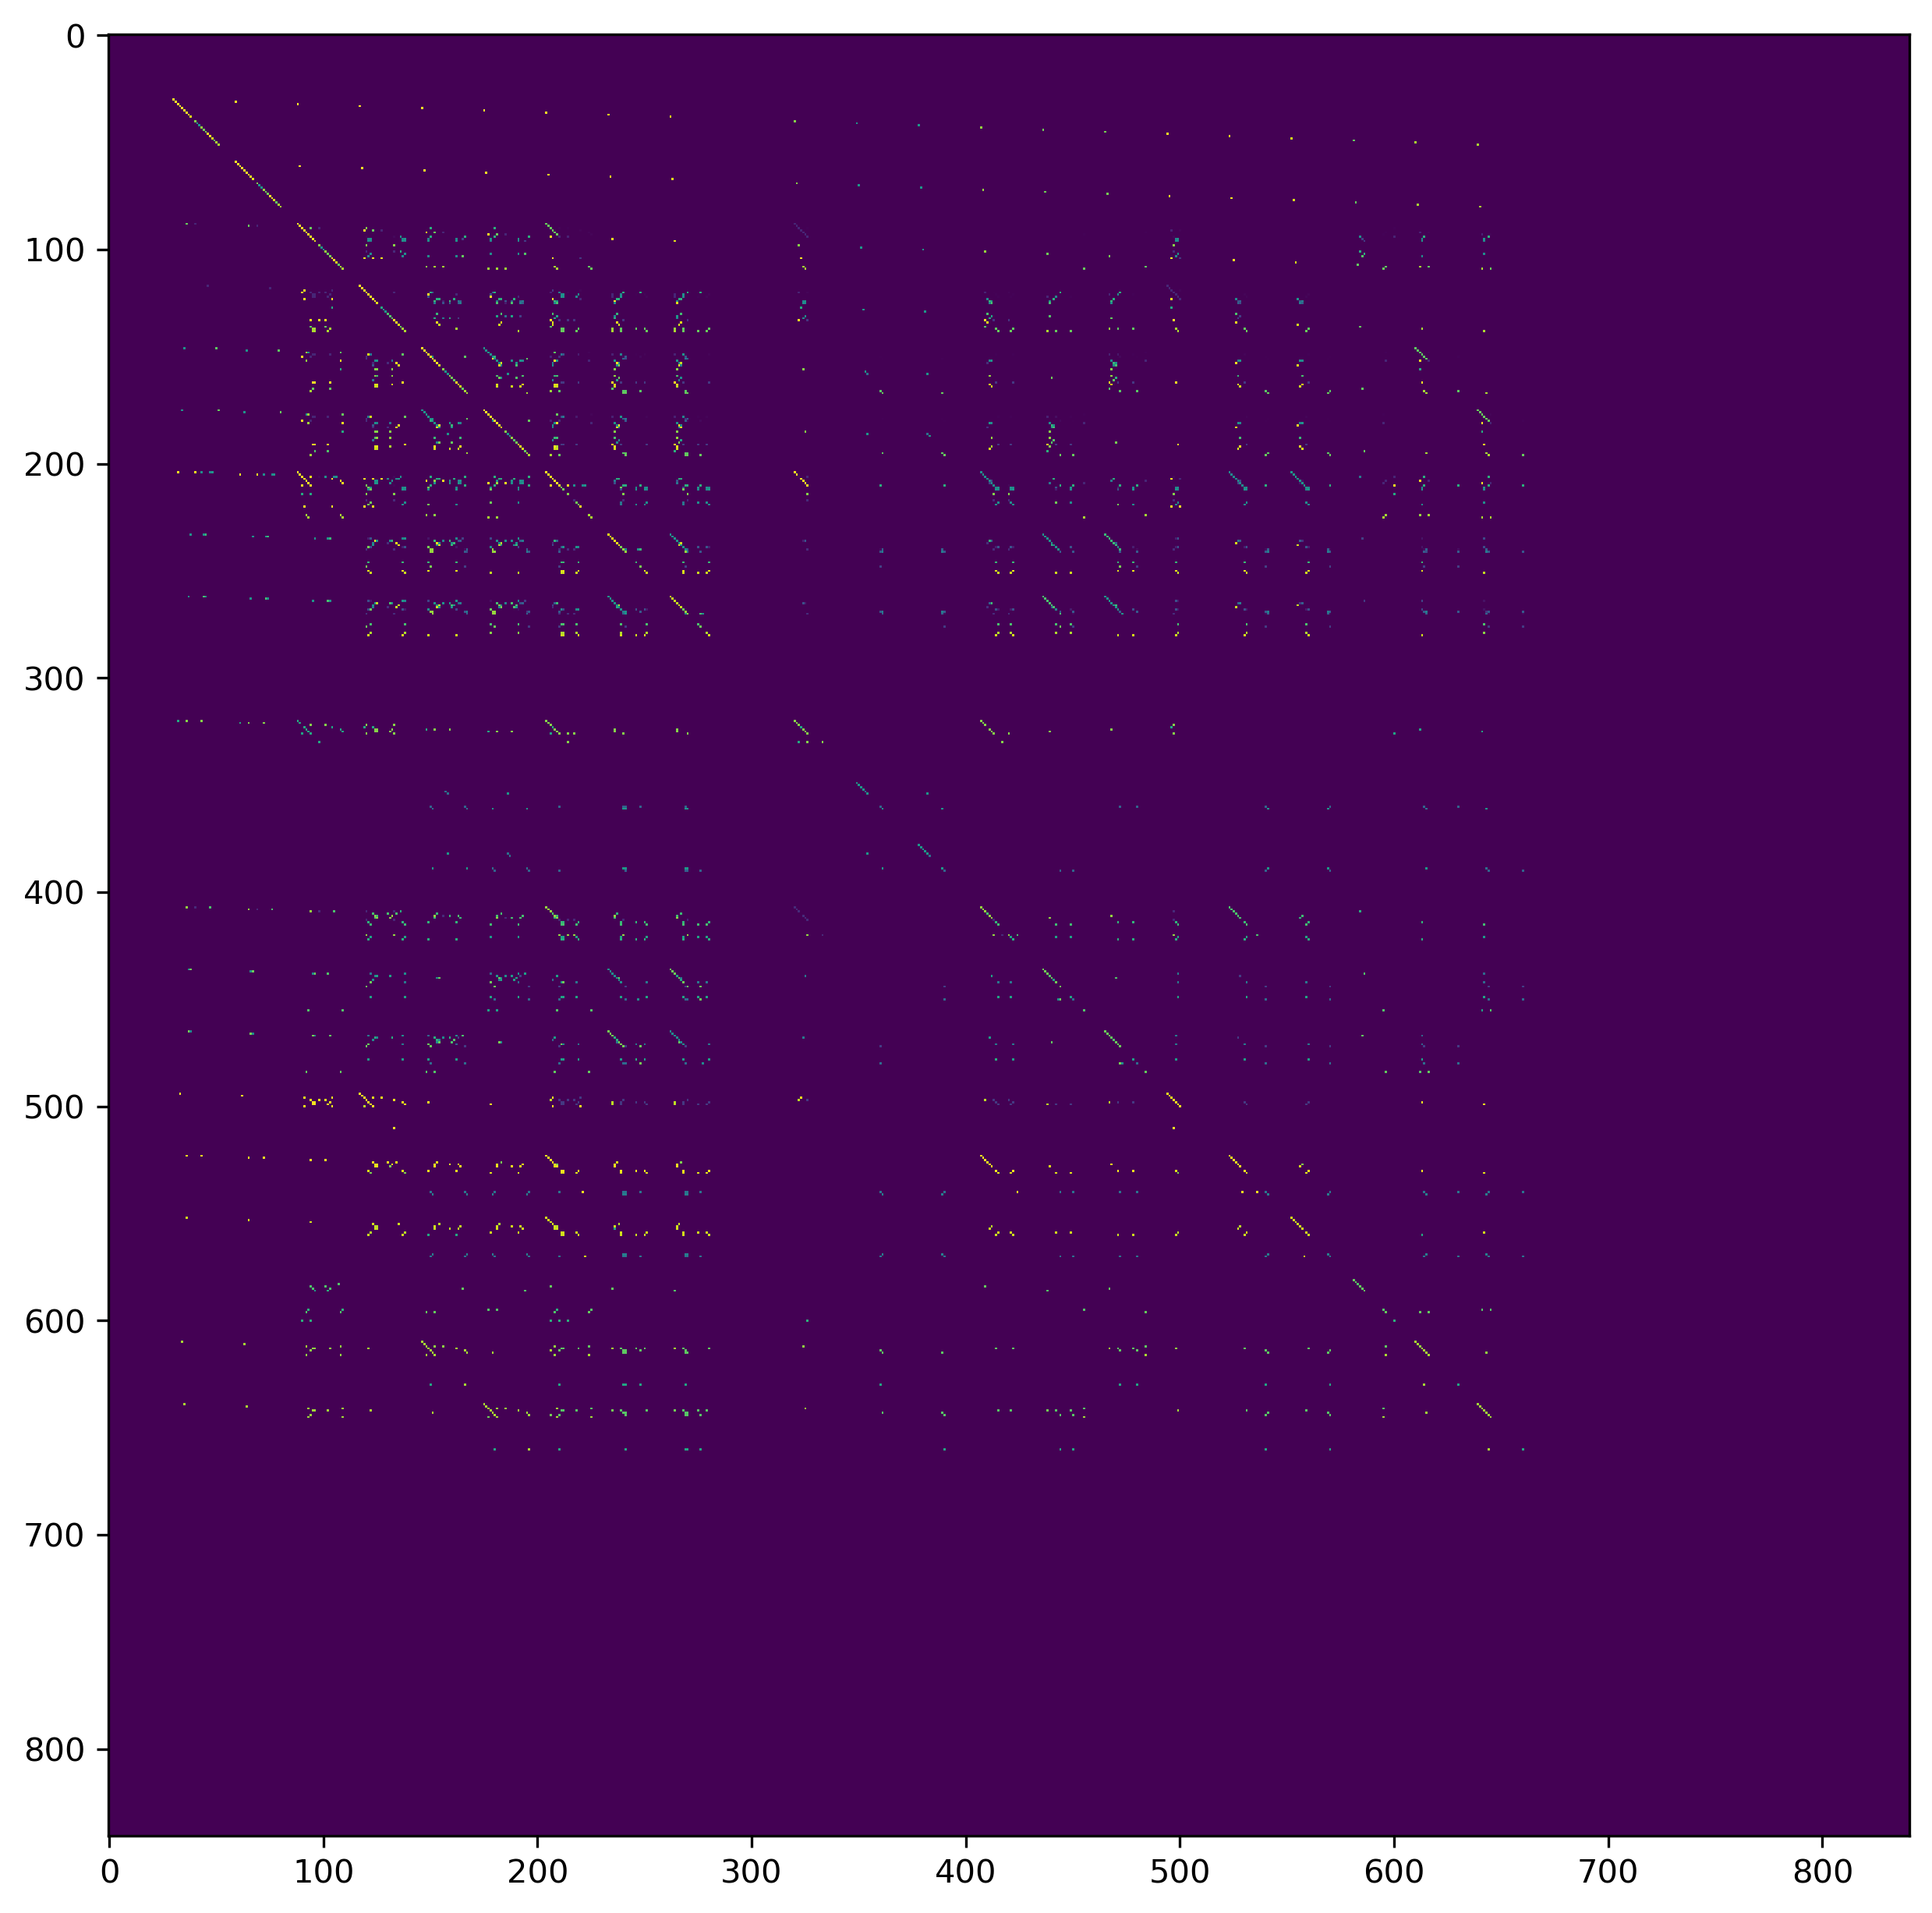

74939.0


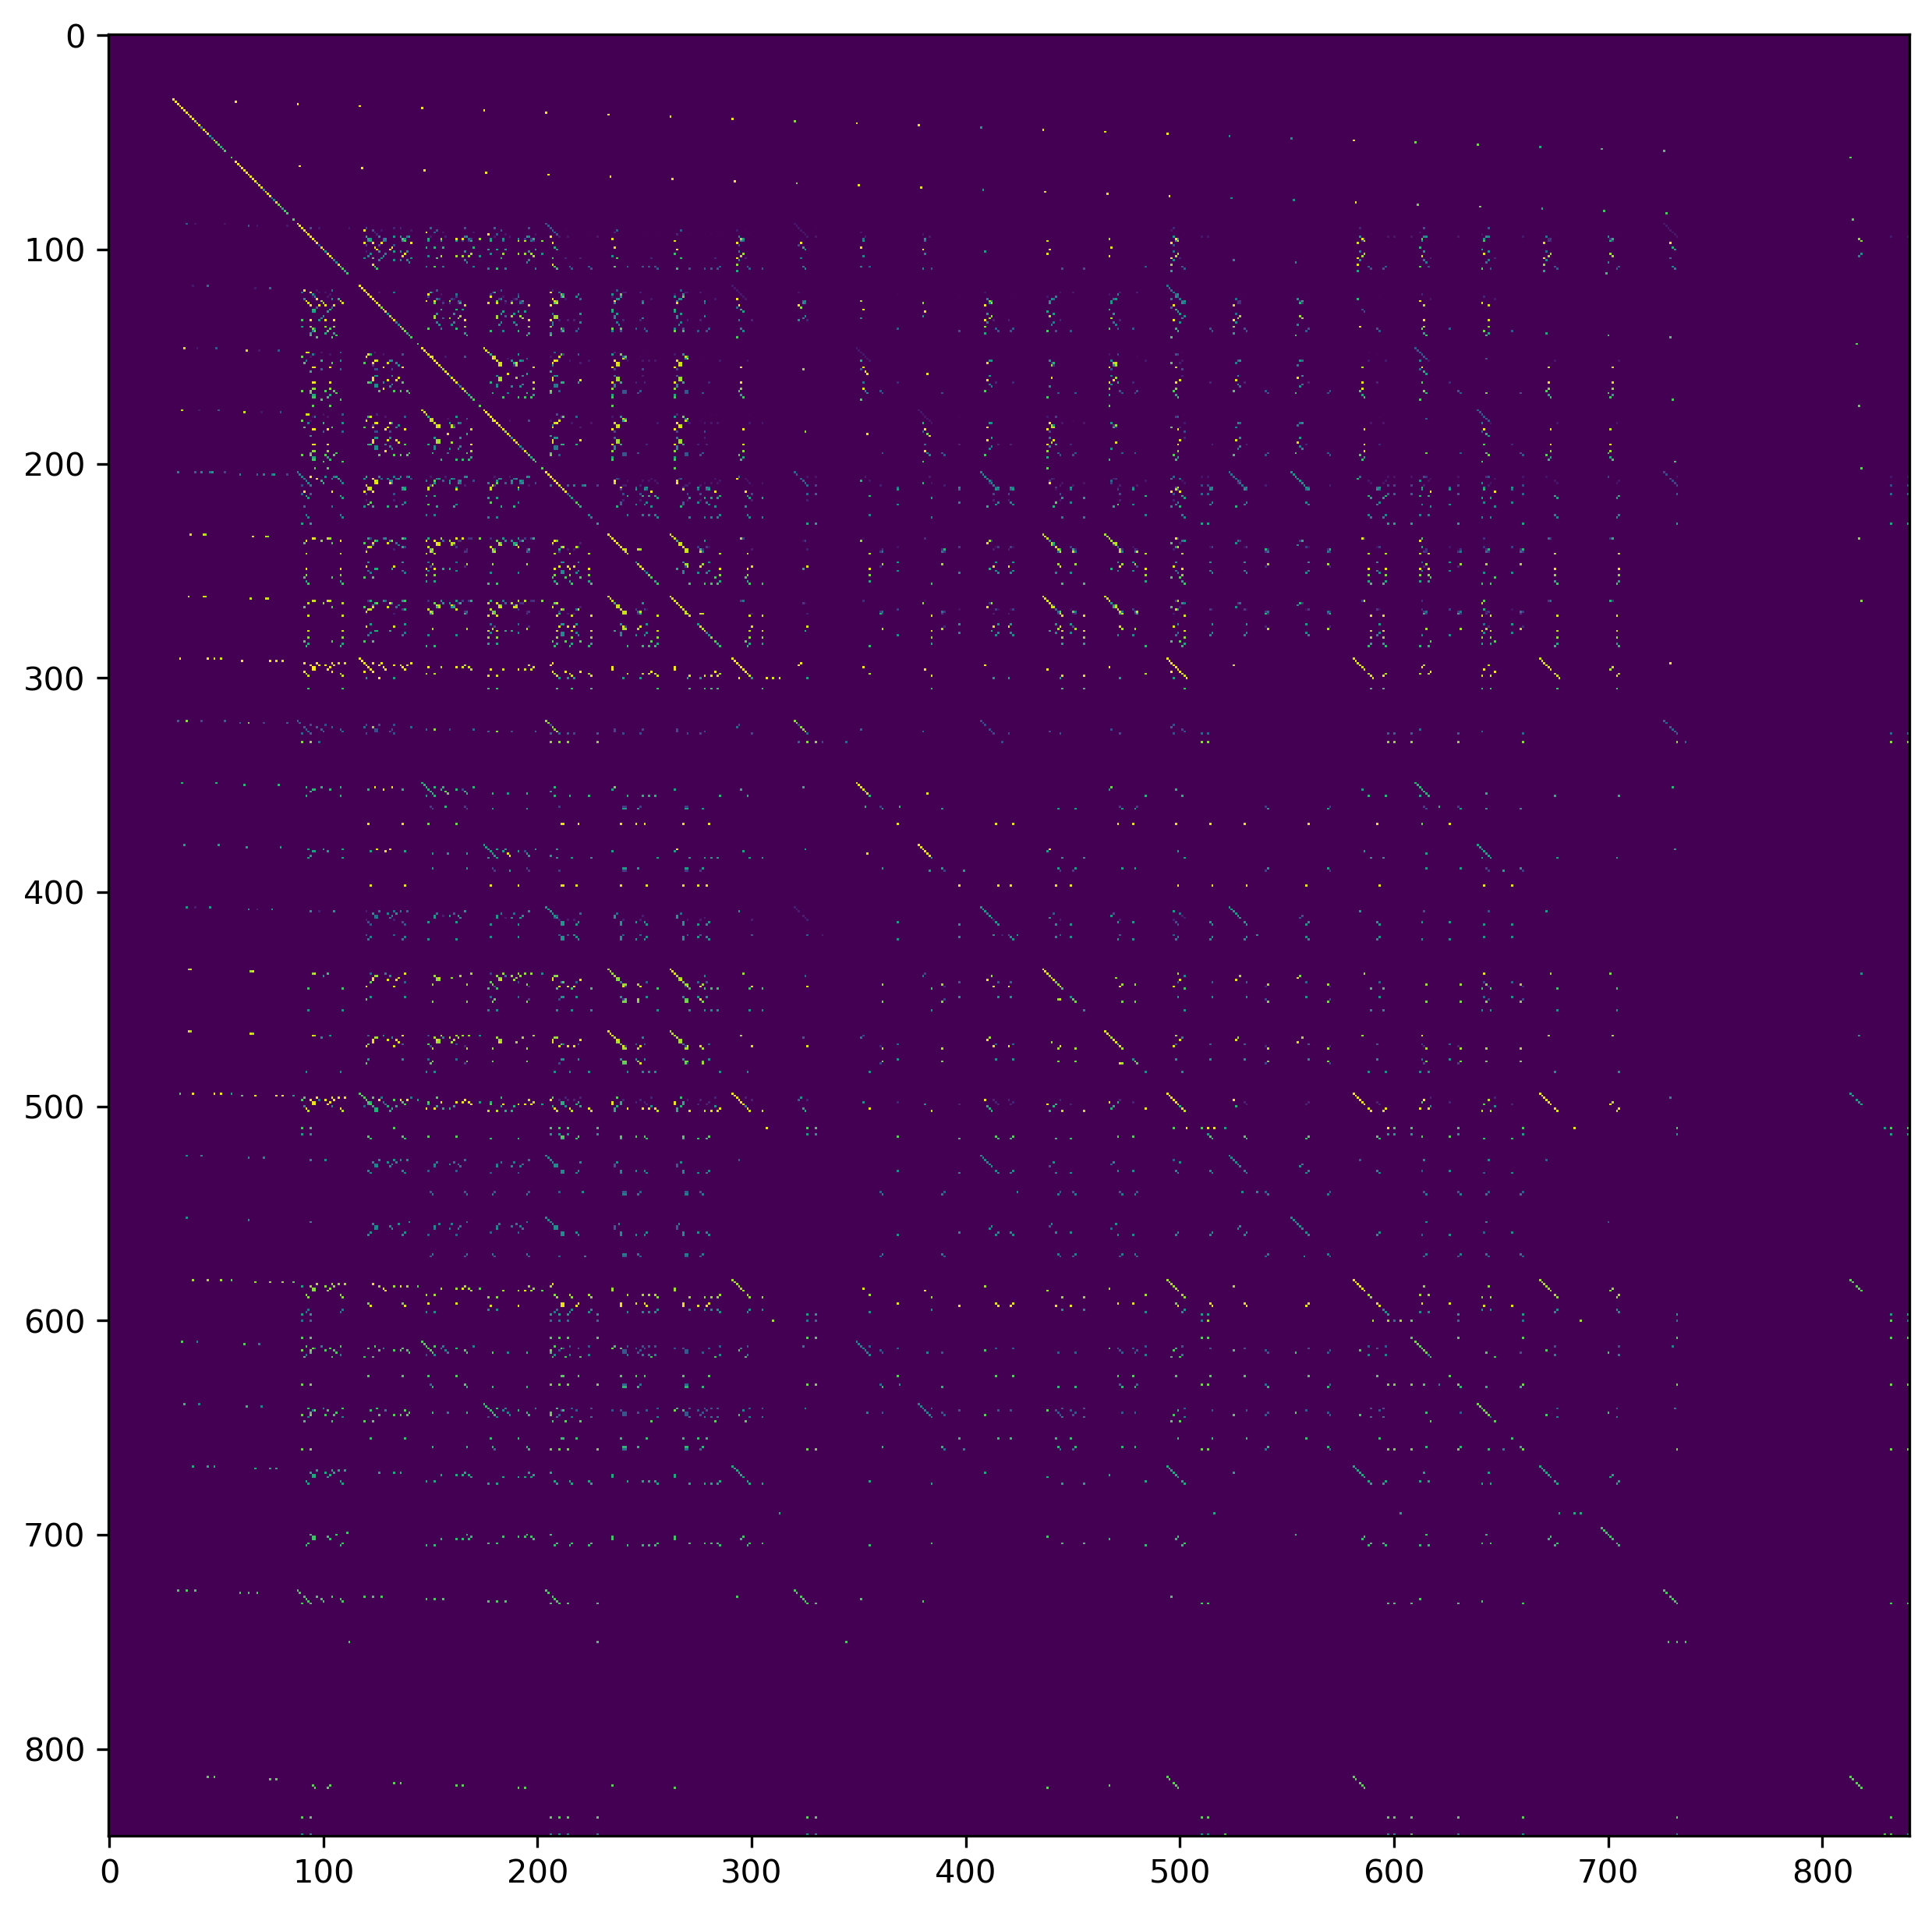

193851.0


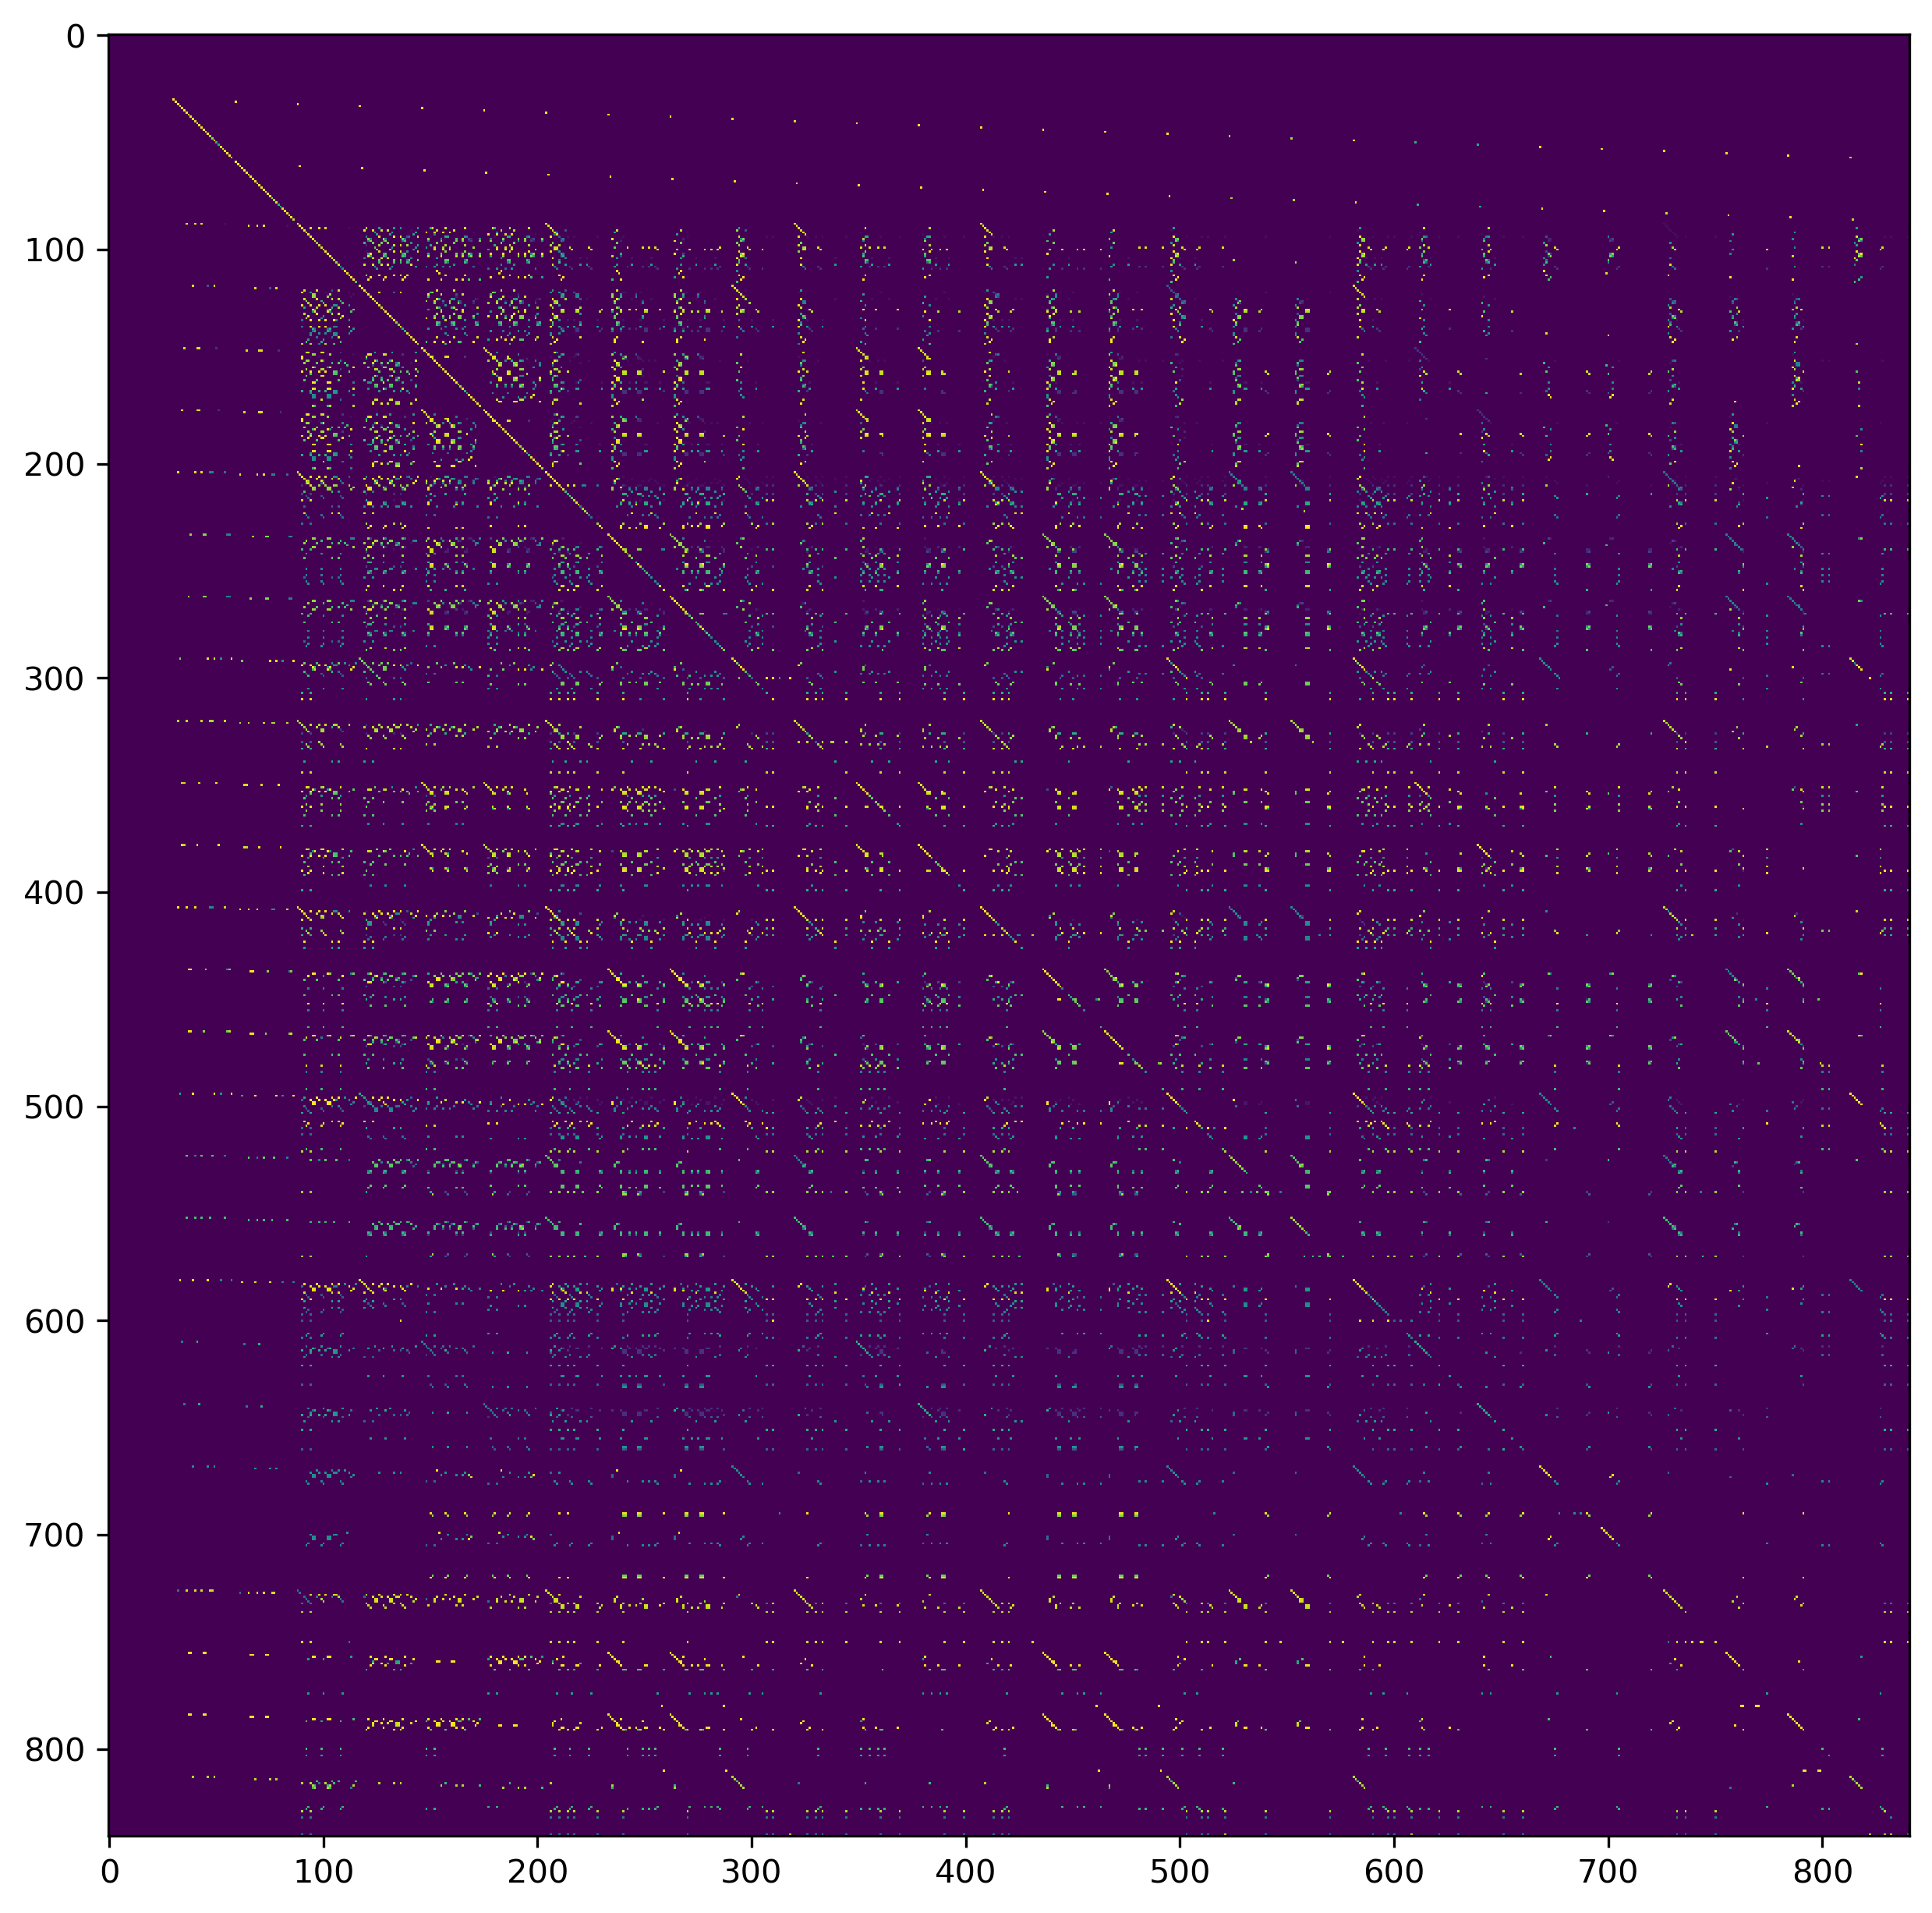

450989.0


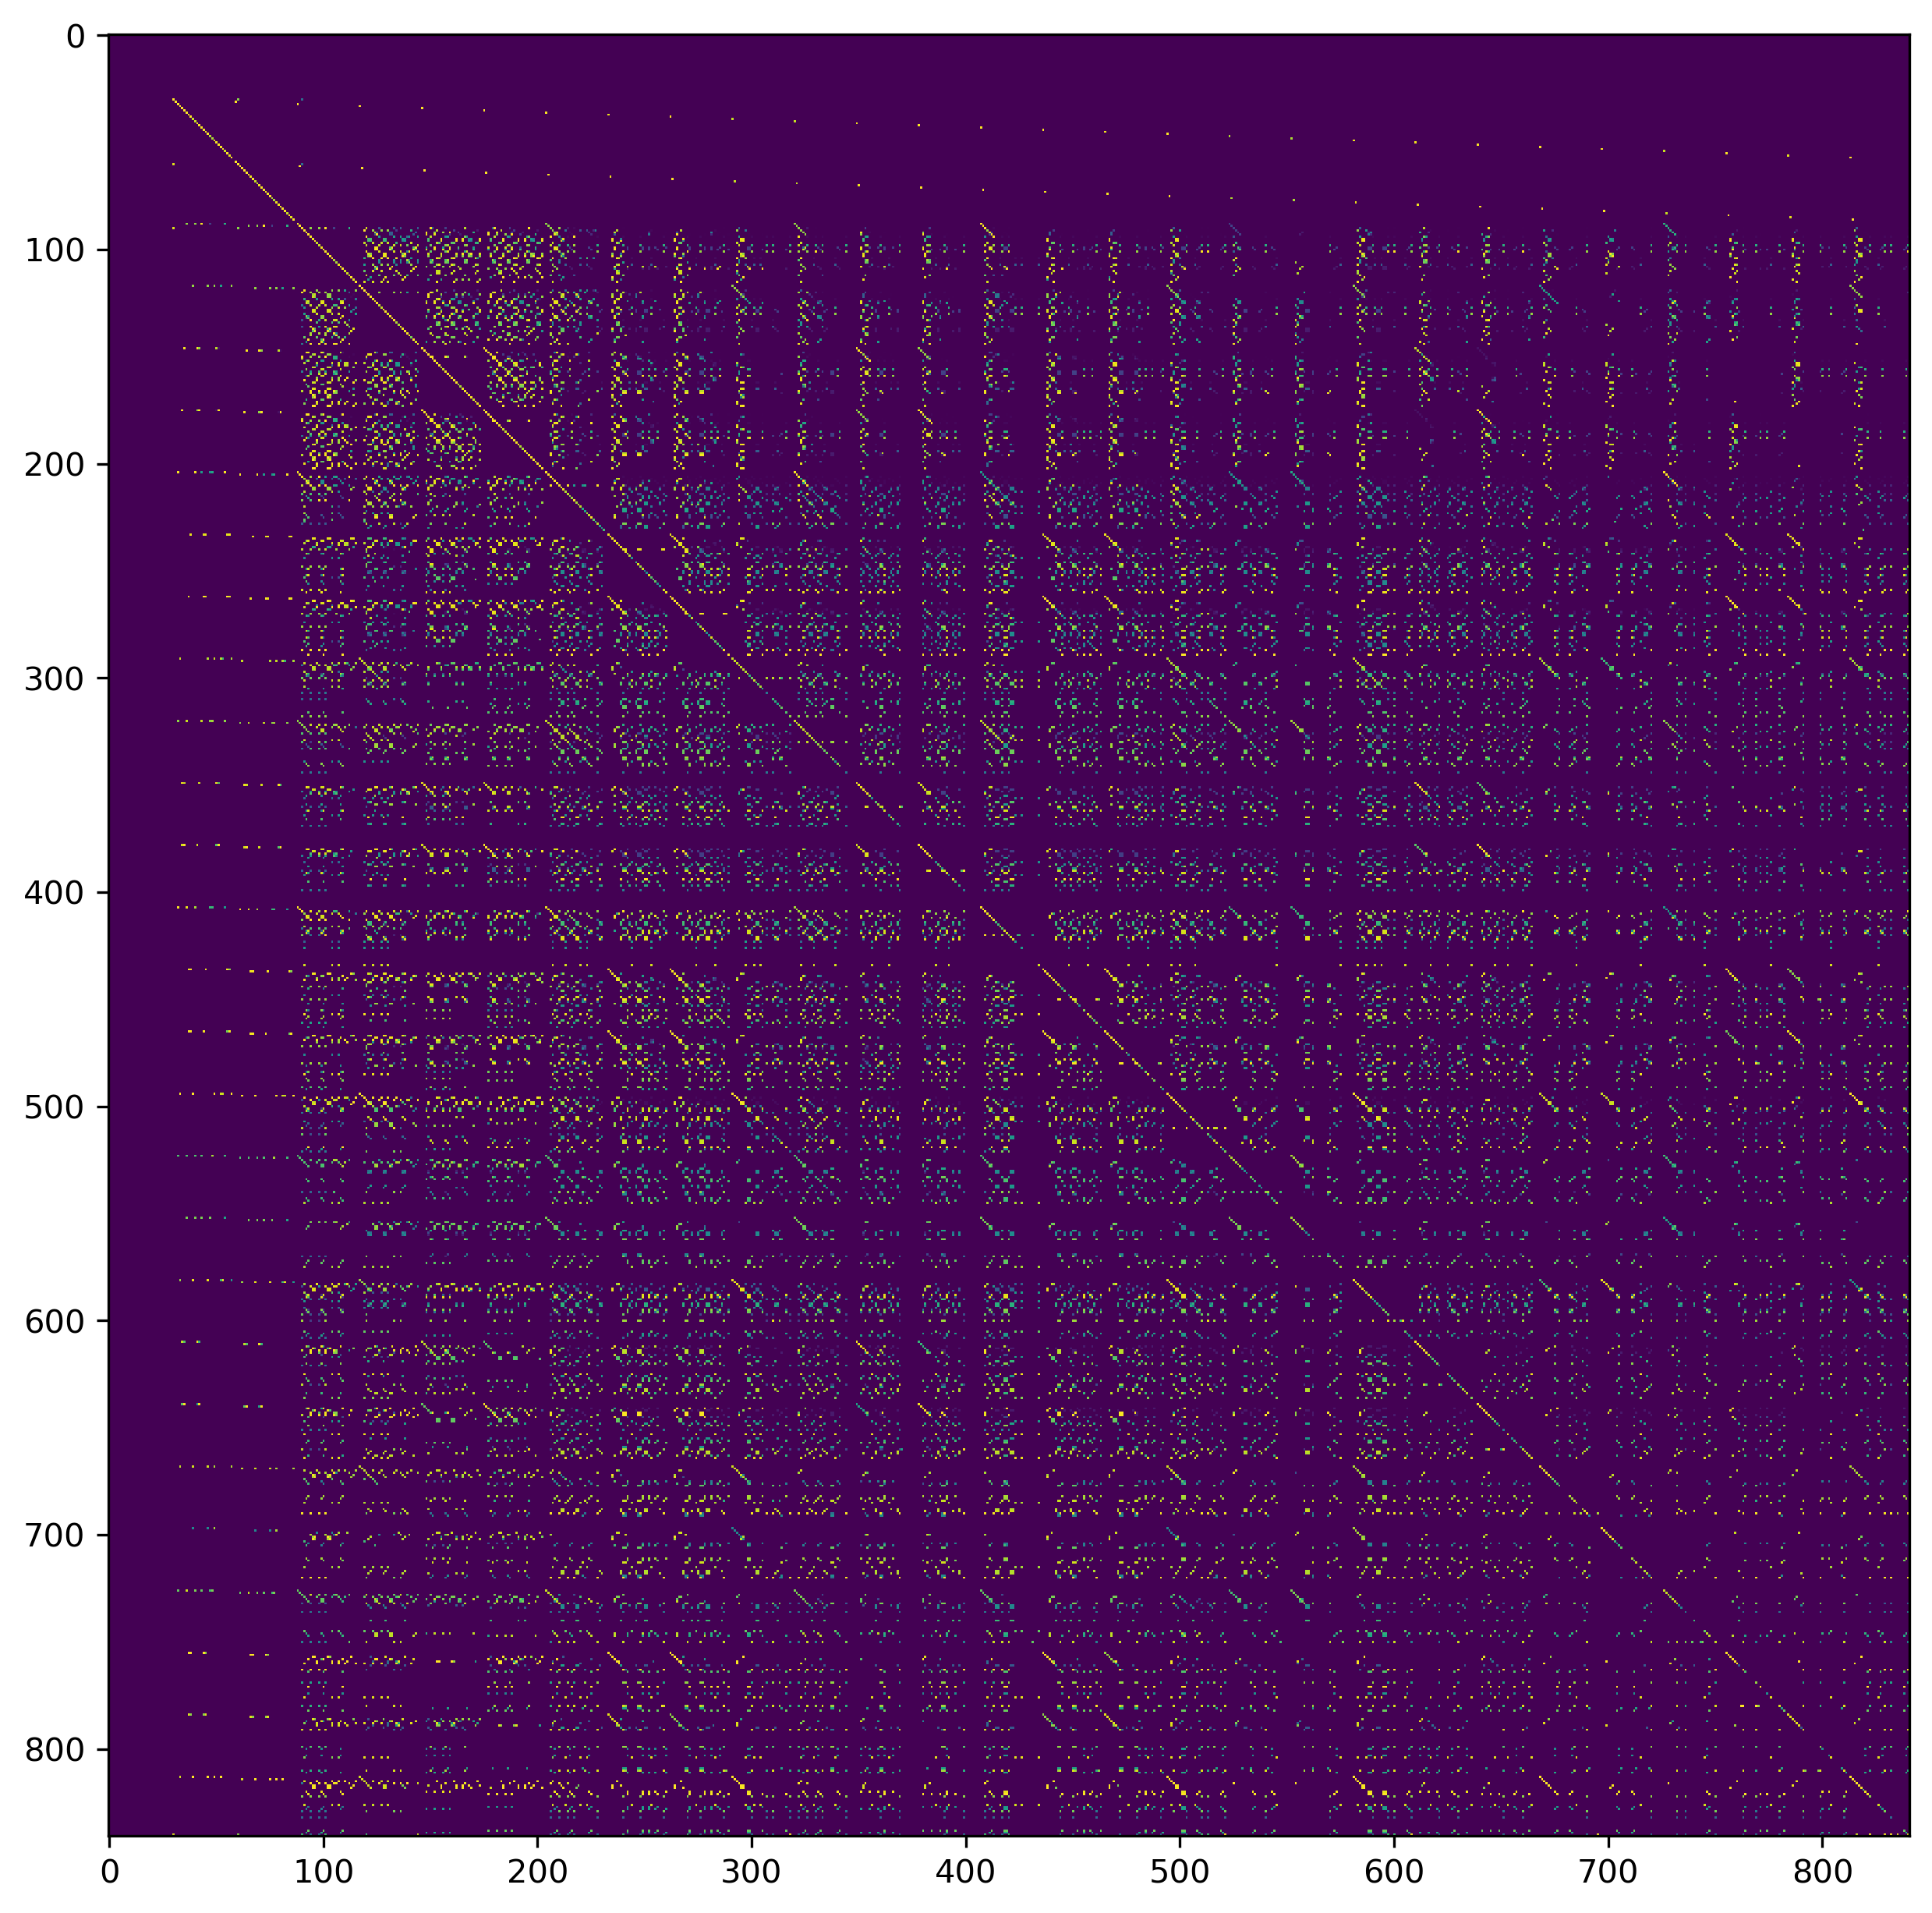

1032659.0


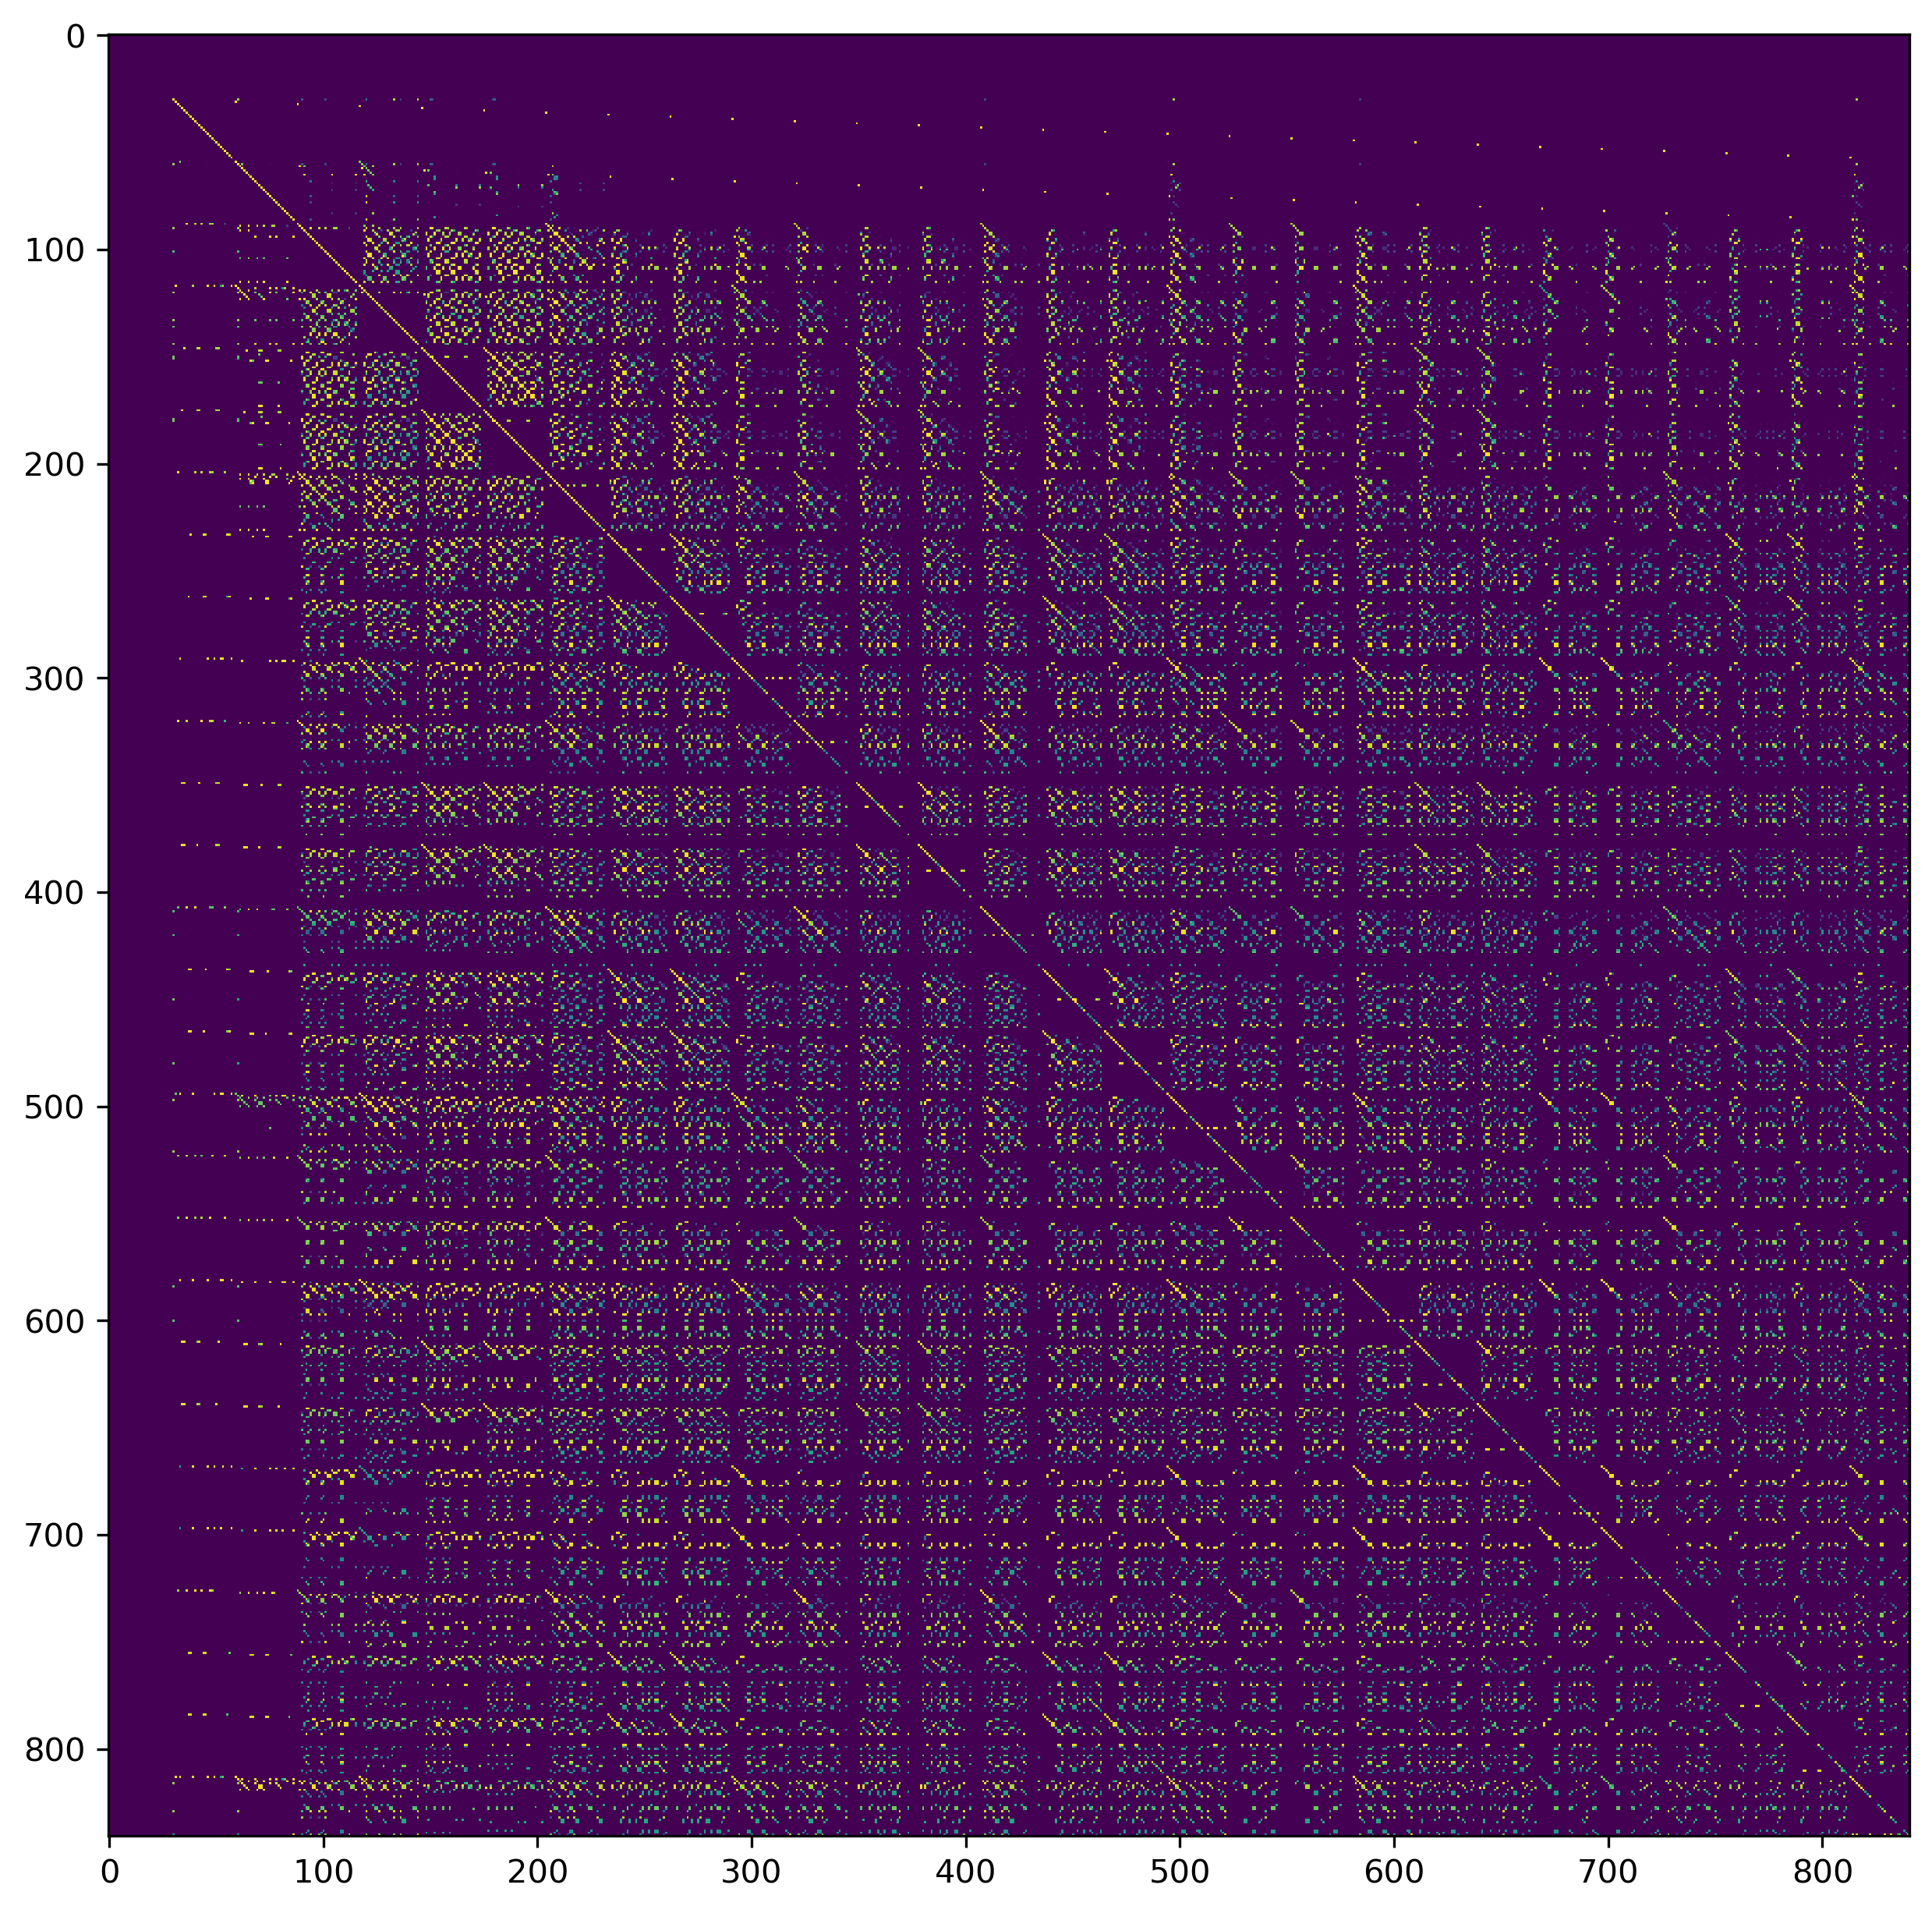

In [60]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 300
for m in nomem_maps:
    print(np.max(m))
    plt.imshow(m, cmap='viridis')
    plt.show()

### Tracing with Memory

Trace with the same timeline across iterations

In [63]:
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
timeline = Timeline(integral_size(d_two_e_integral))

mem_maps = []
for i in range(1, 11):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
    main.Powerplant(lewis, psi_det).E(psi_coef)
    mem_maps.append(np.copy(lewis.timeline.view2d()))

95.0


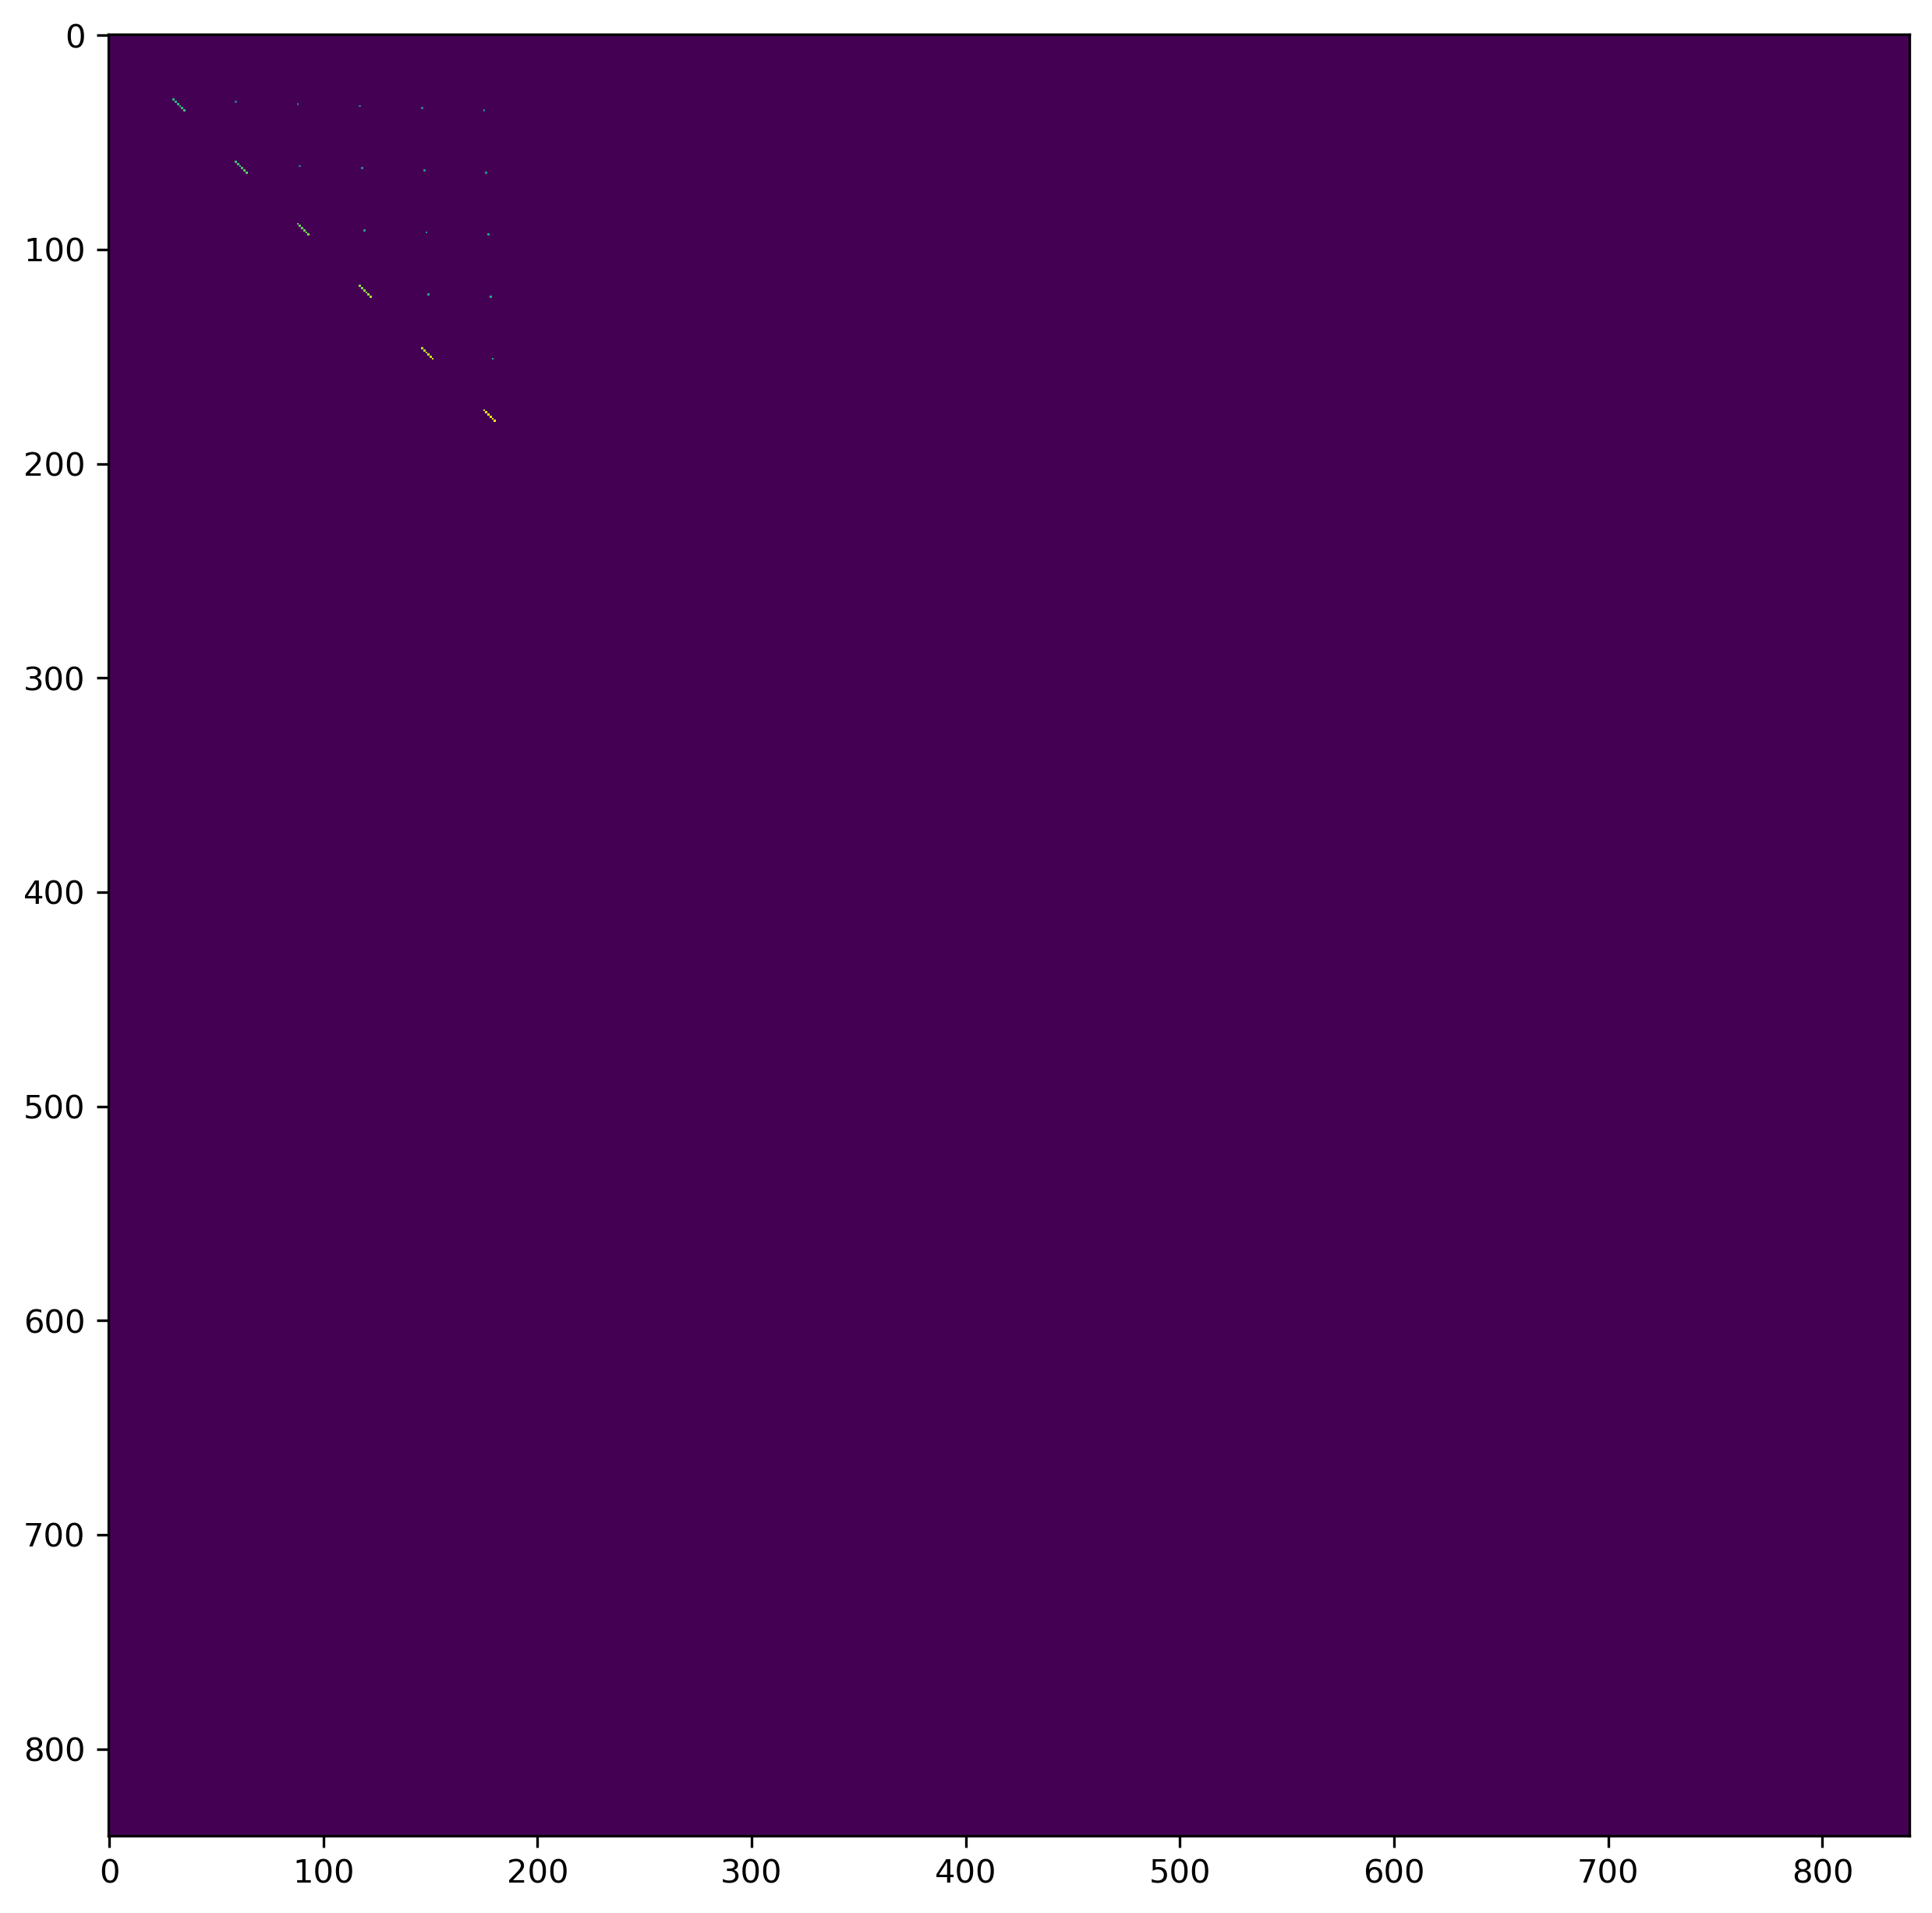

921.0


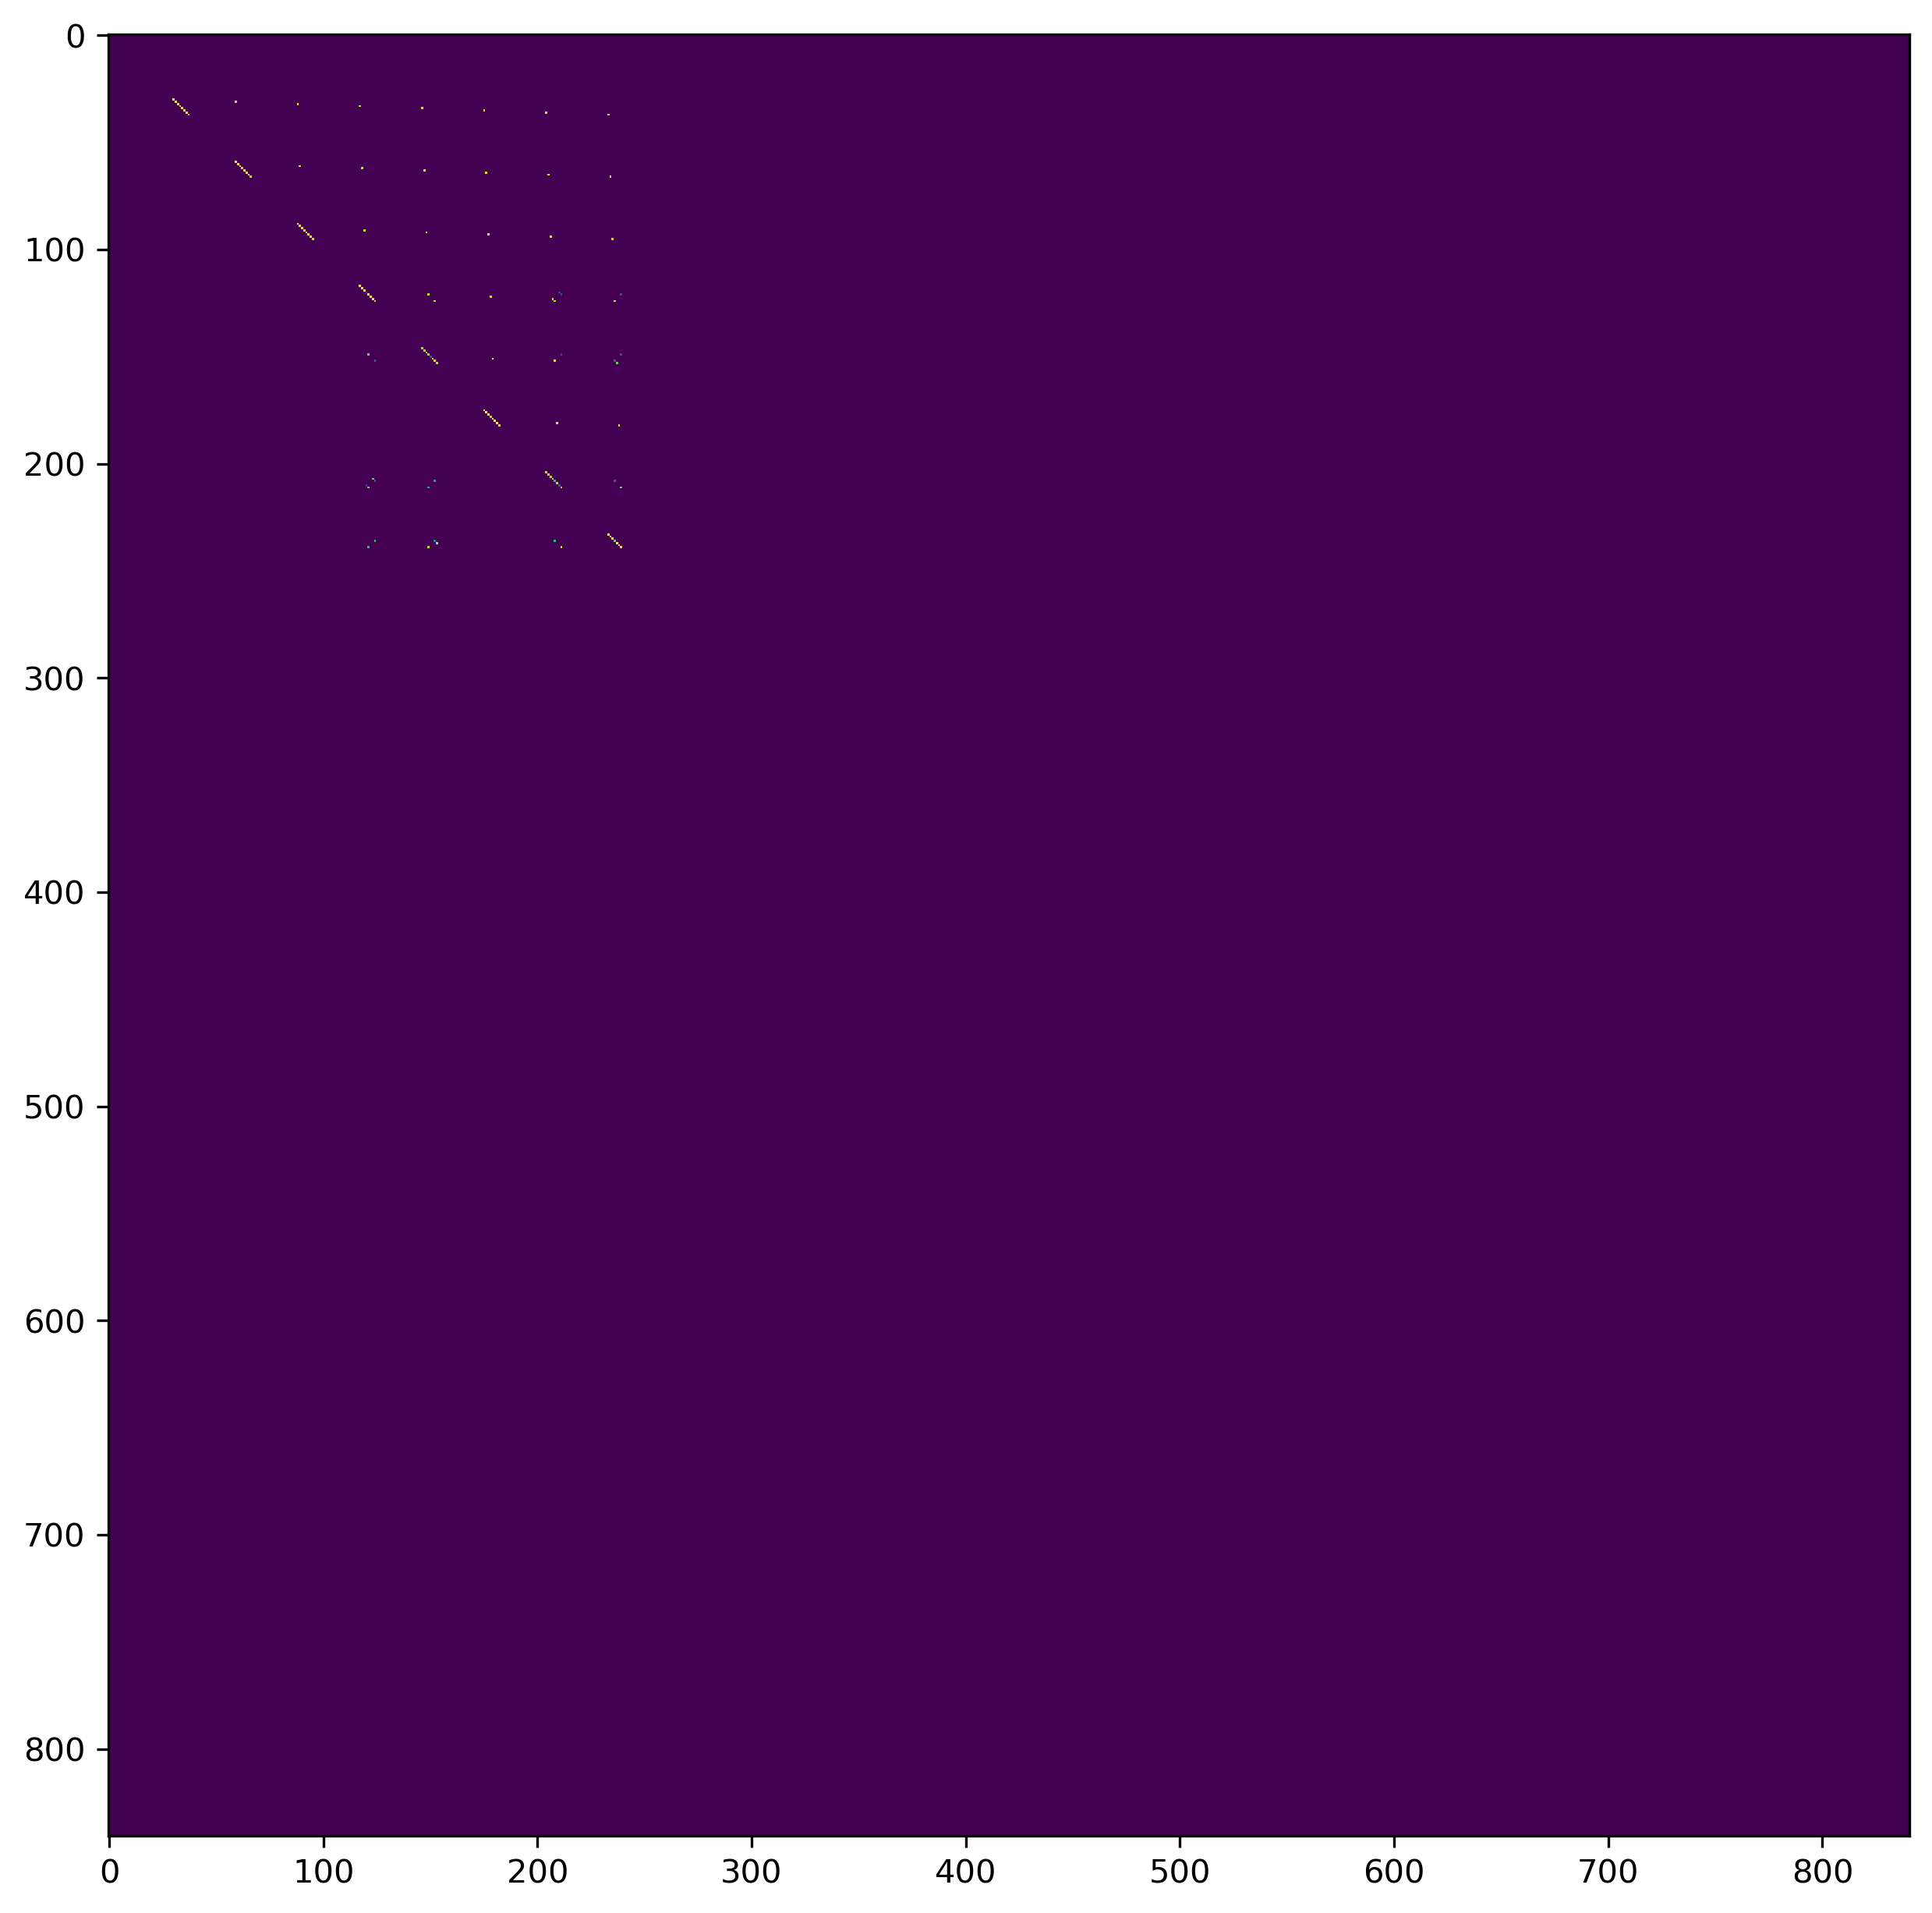

3339.0


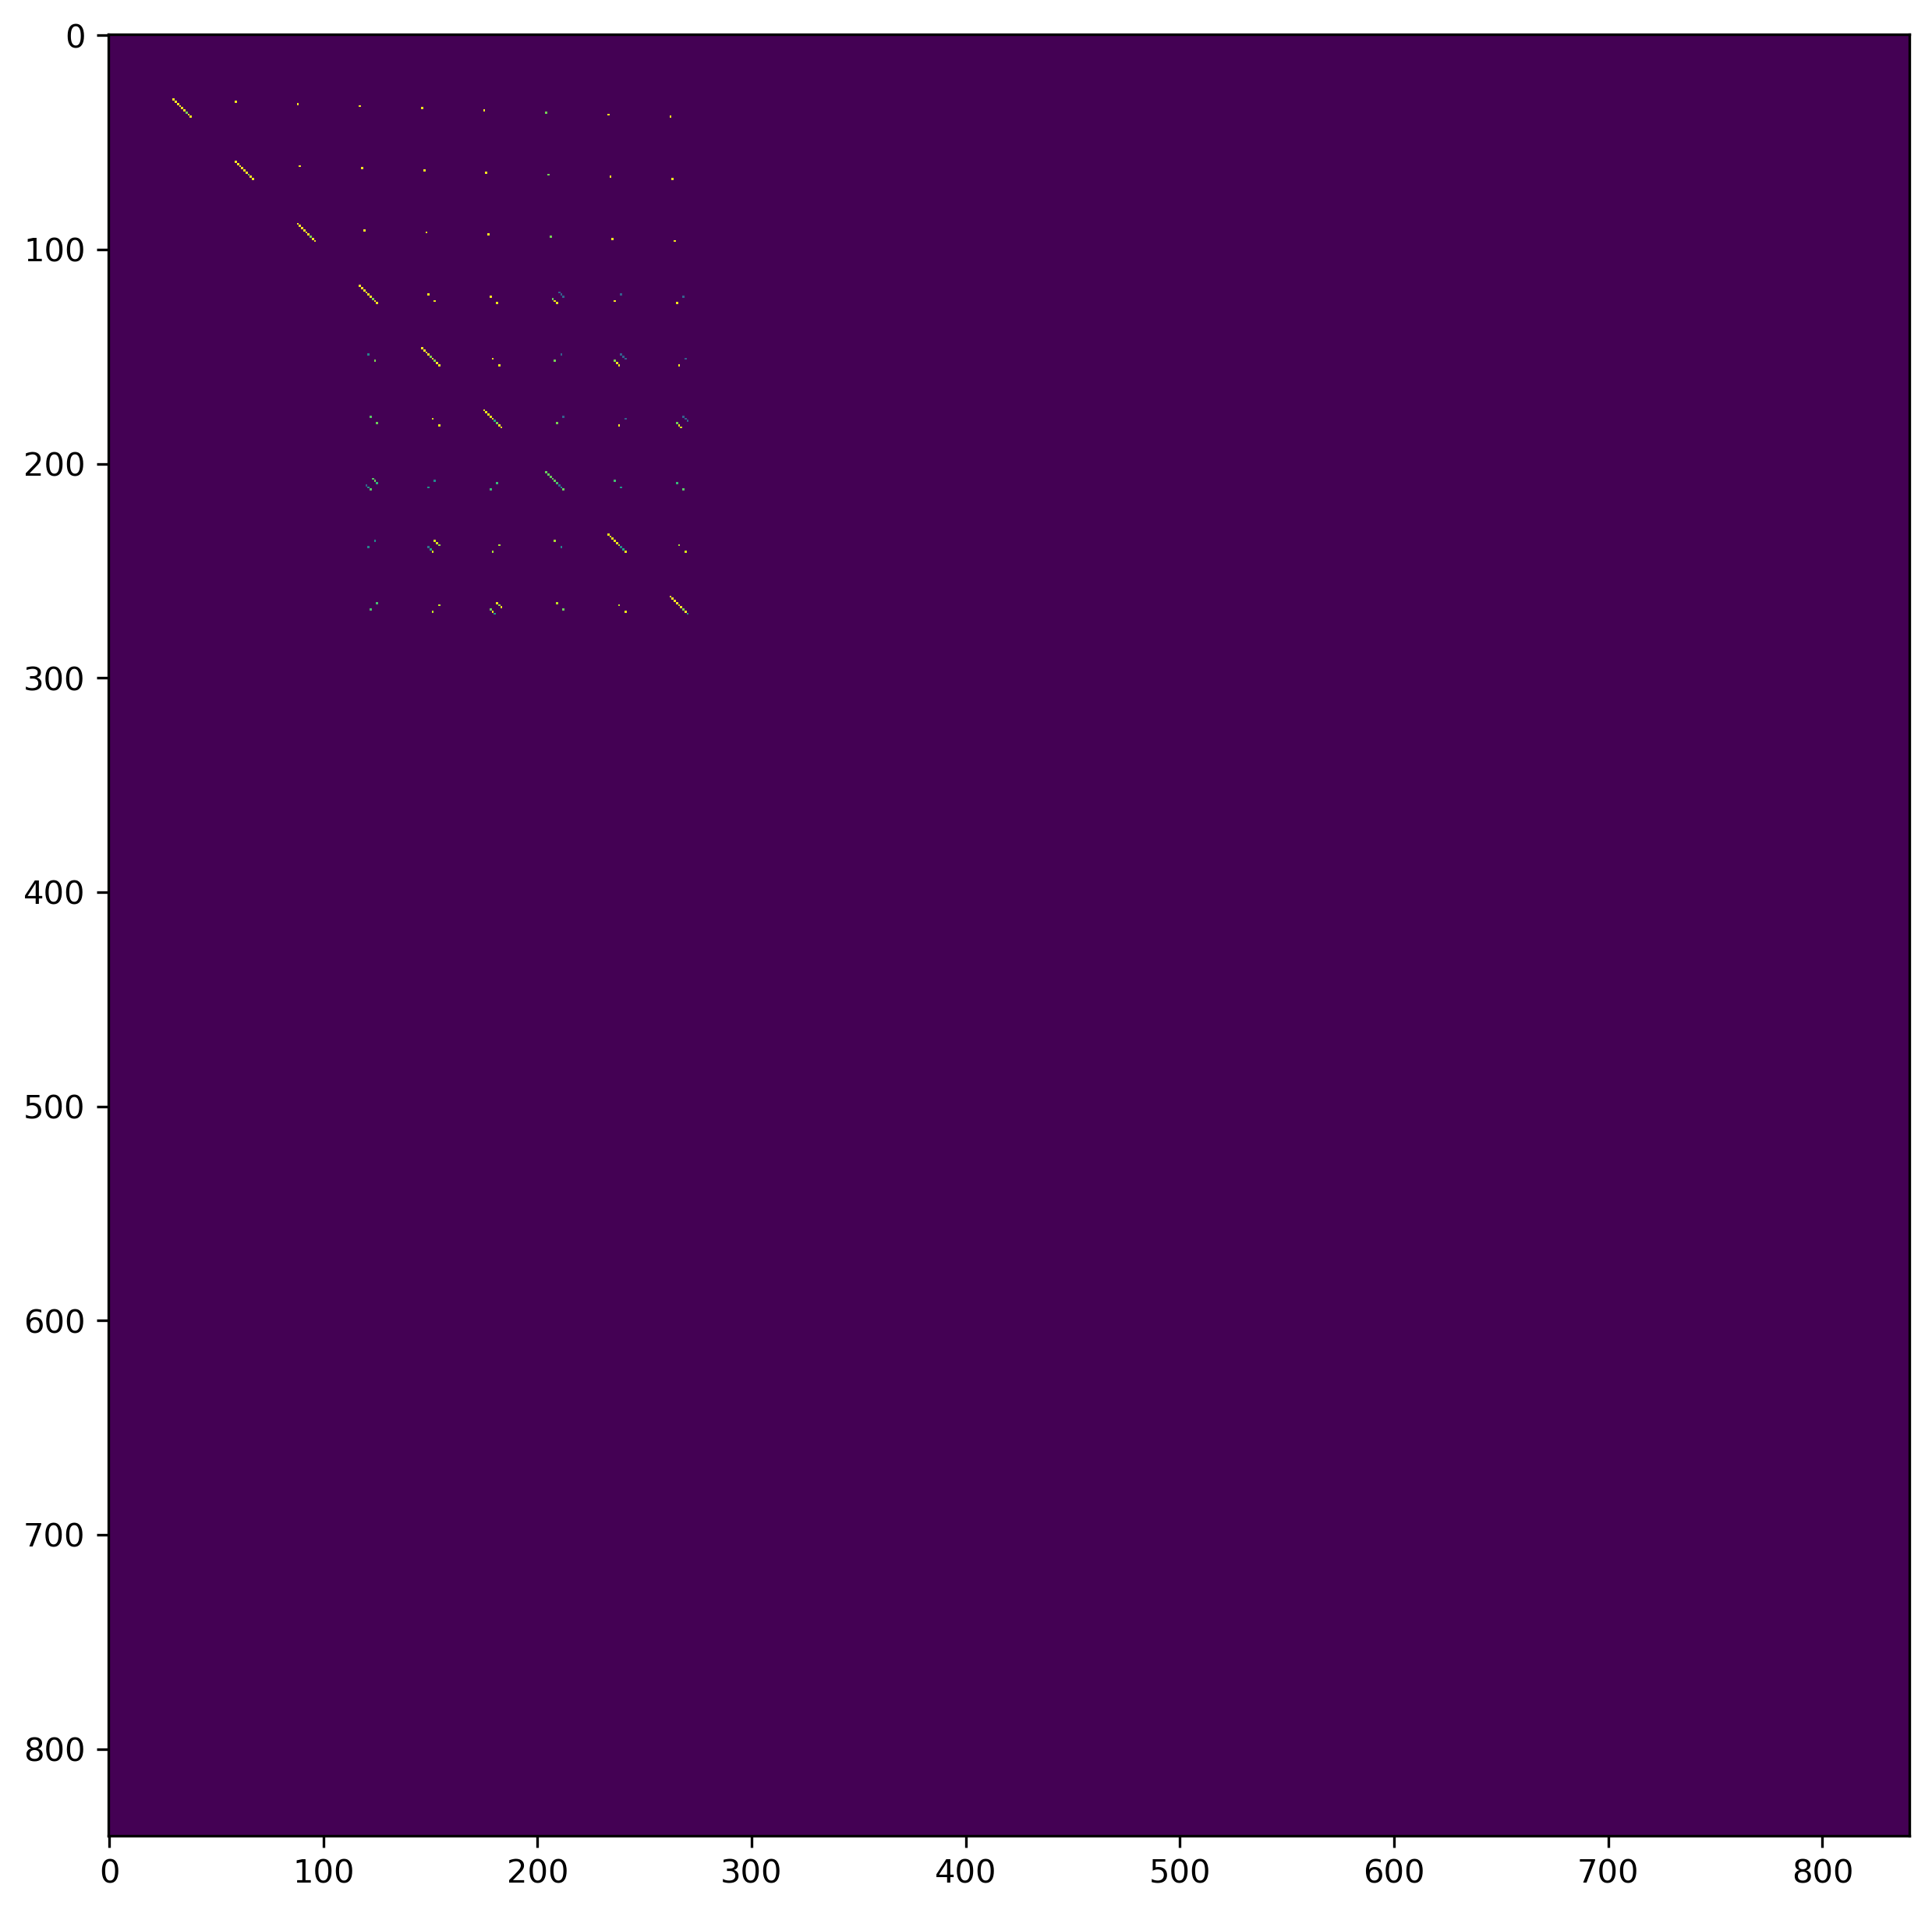

8807.0


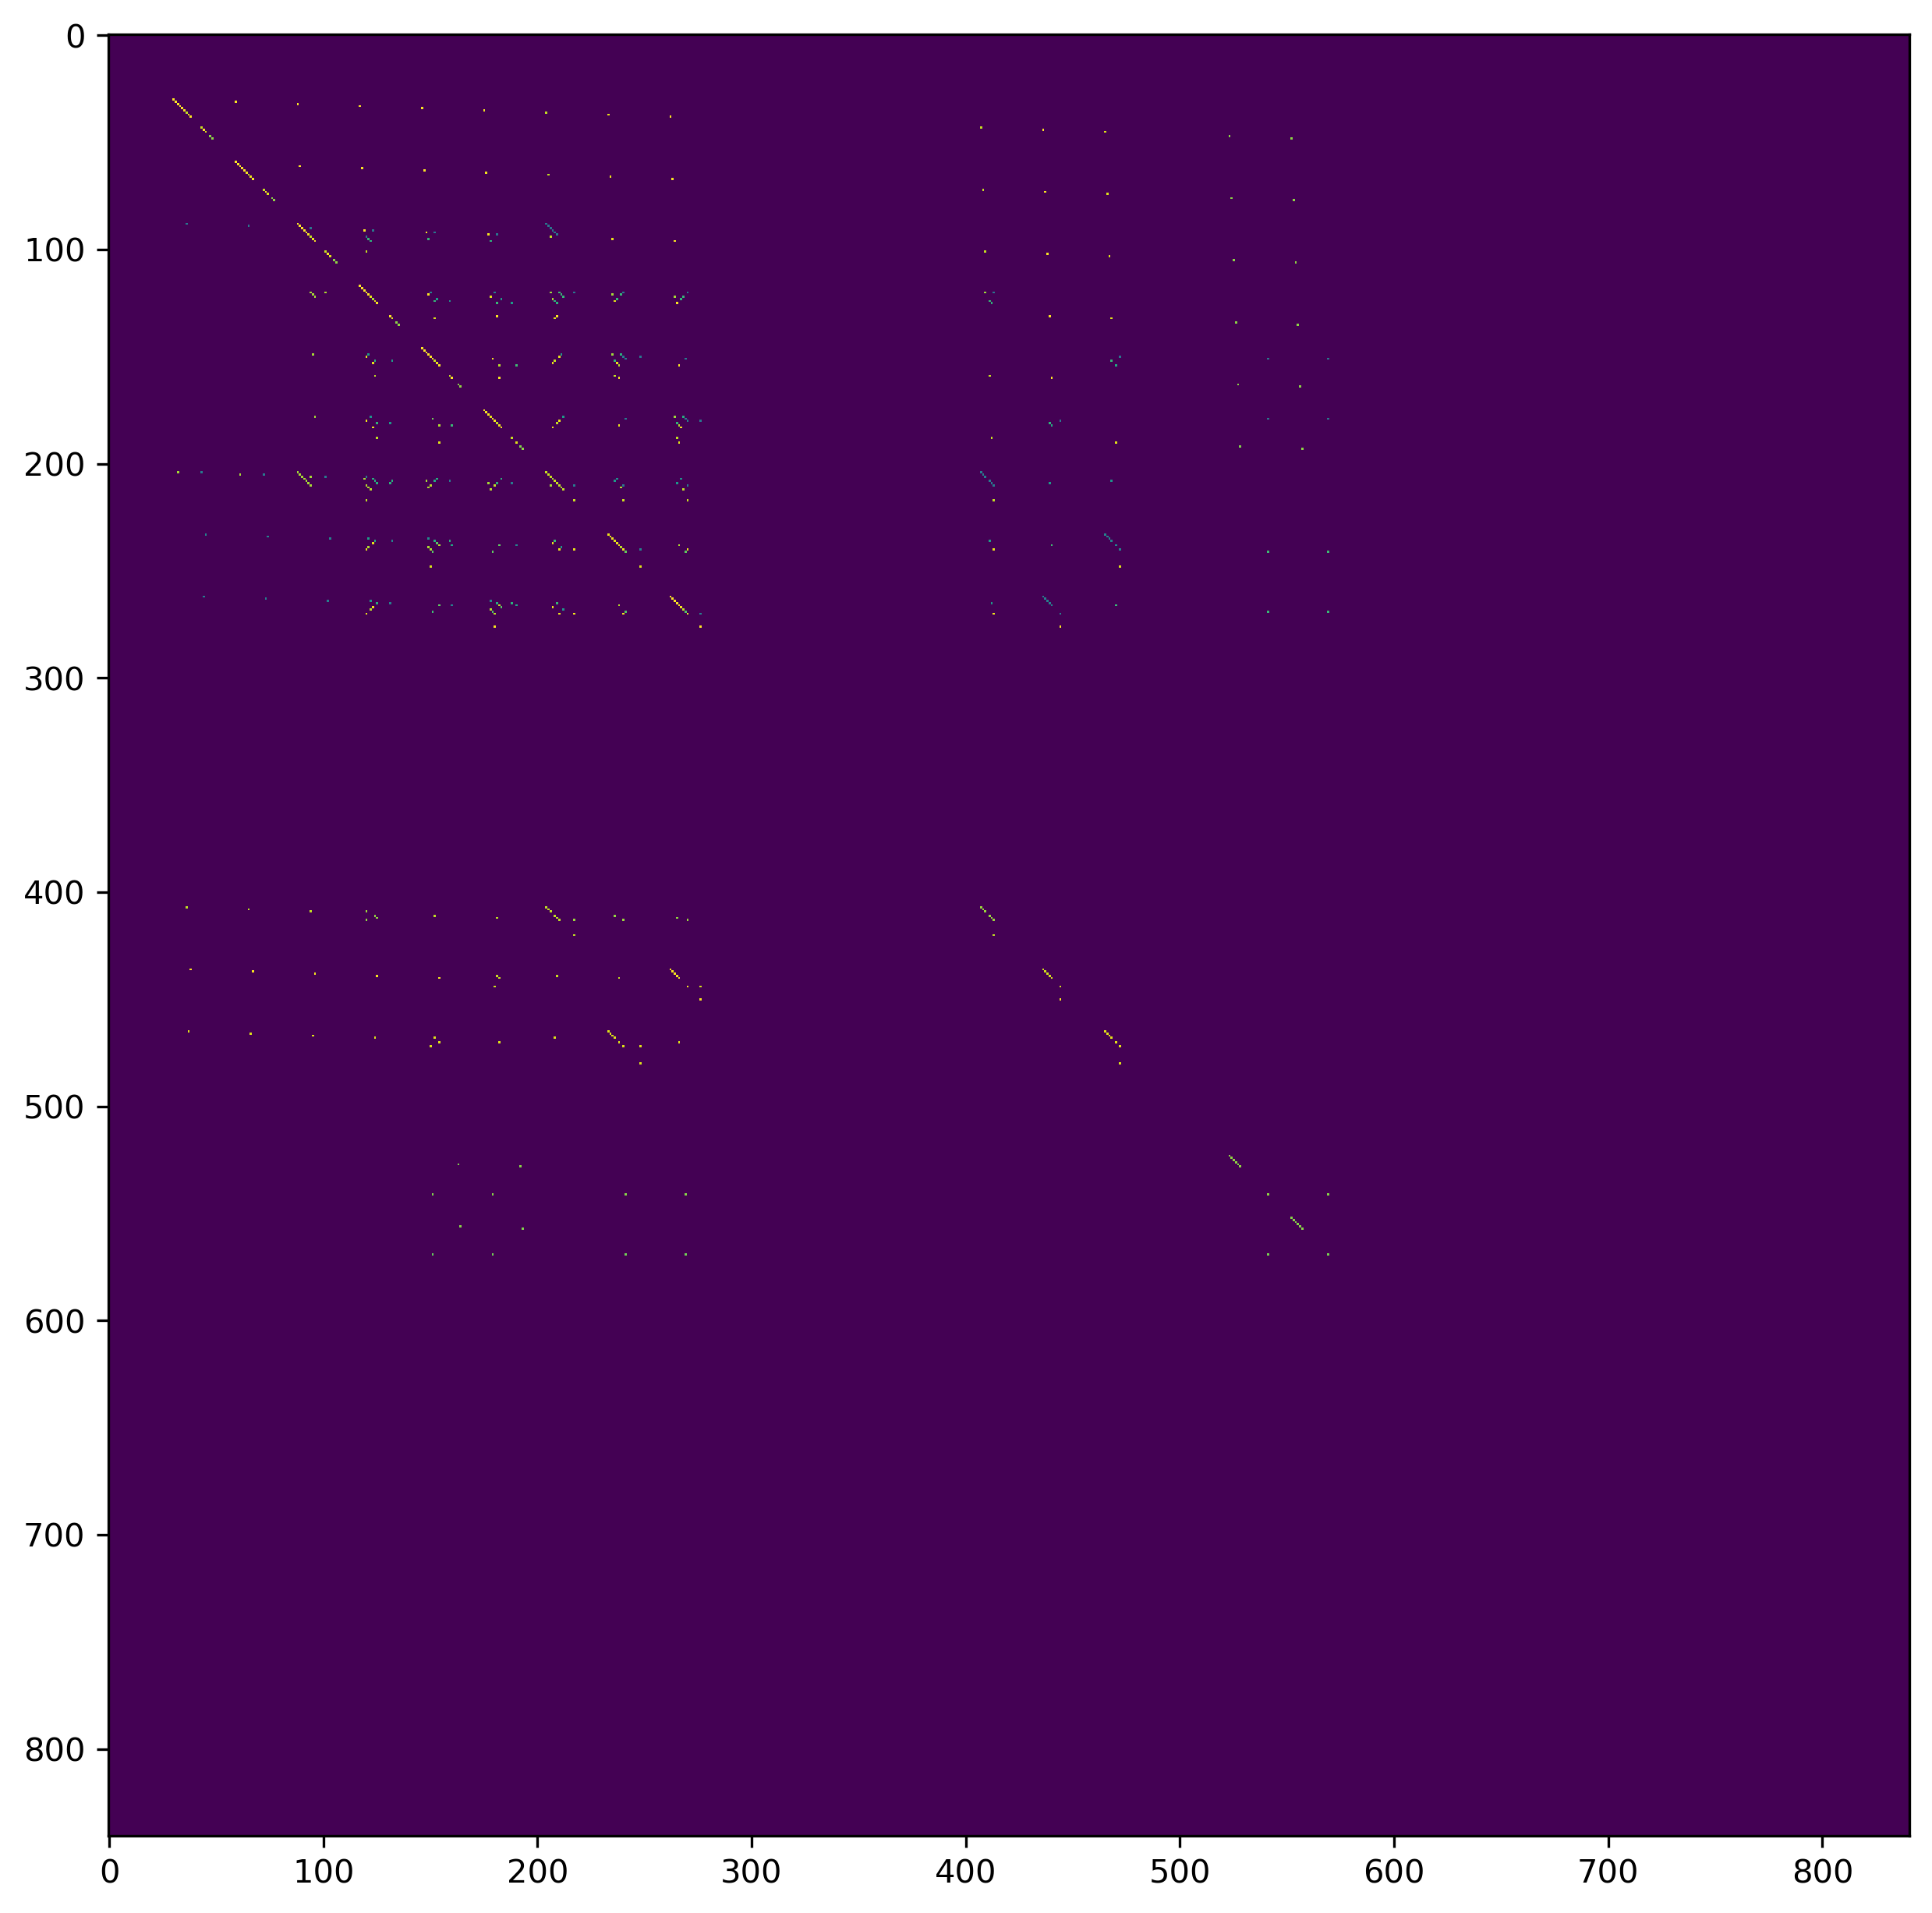

23497.0


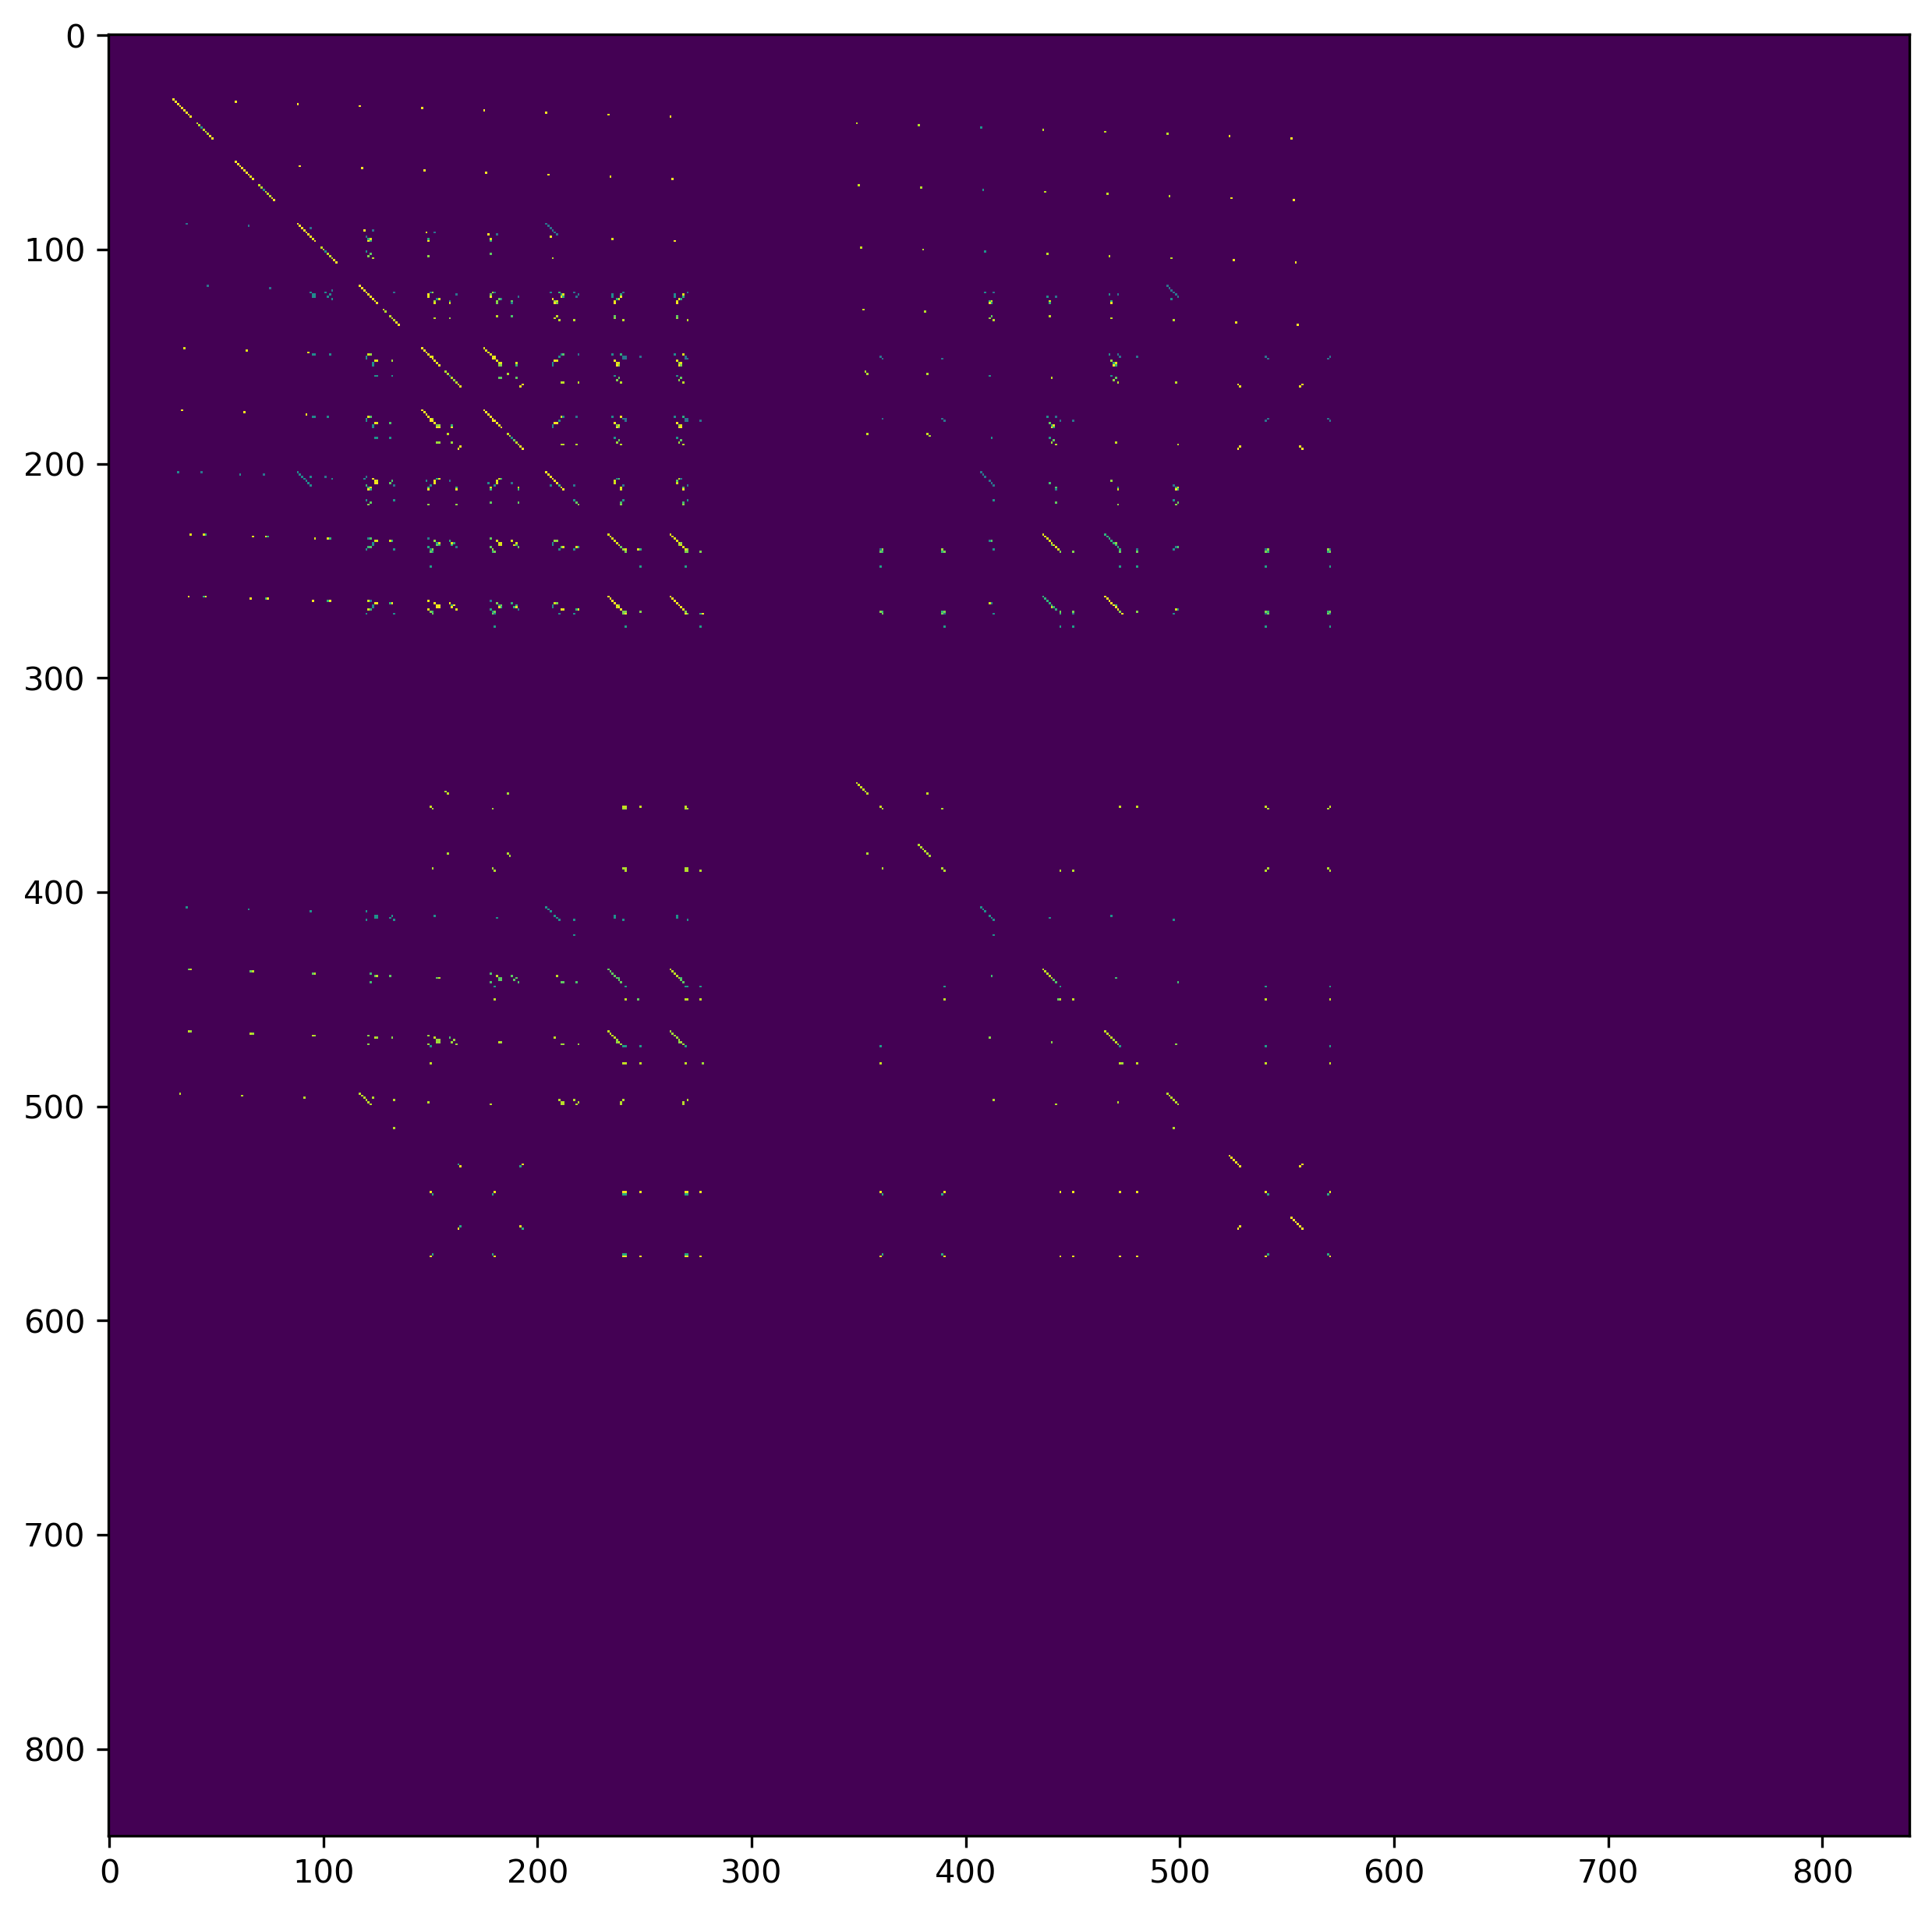

56865.0


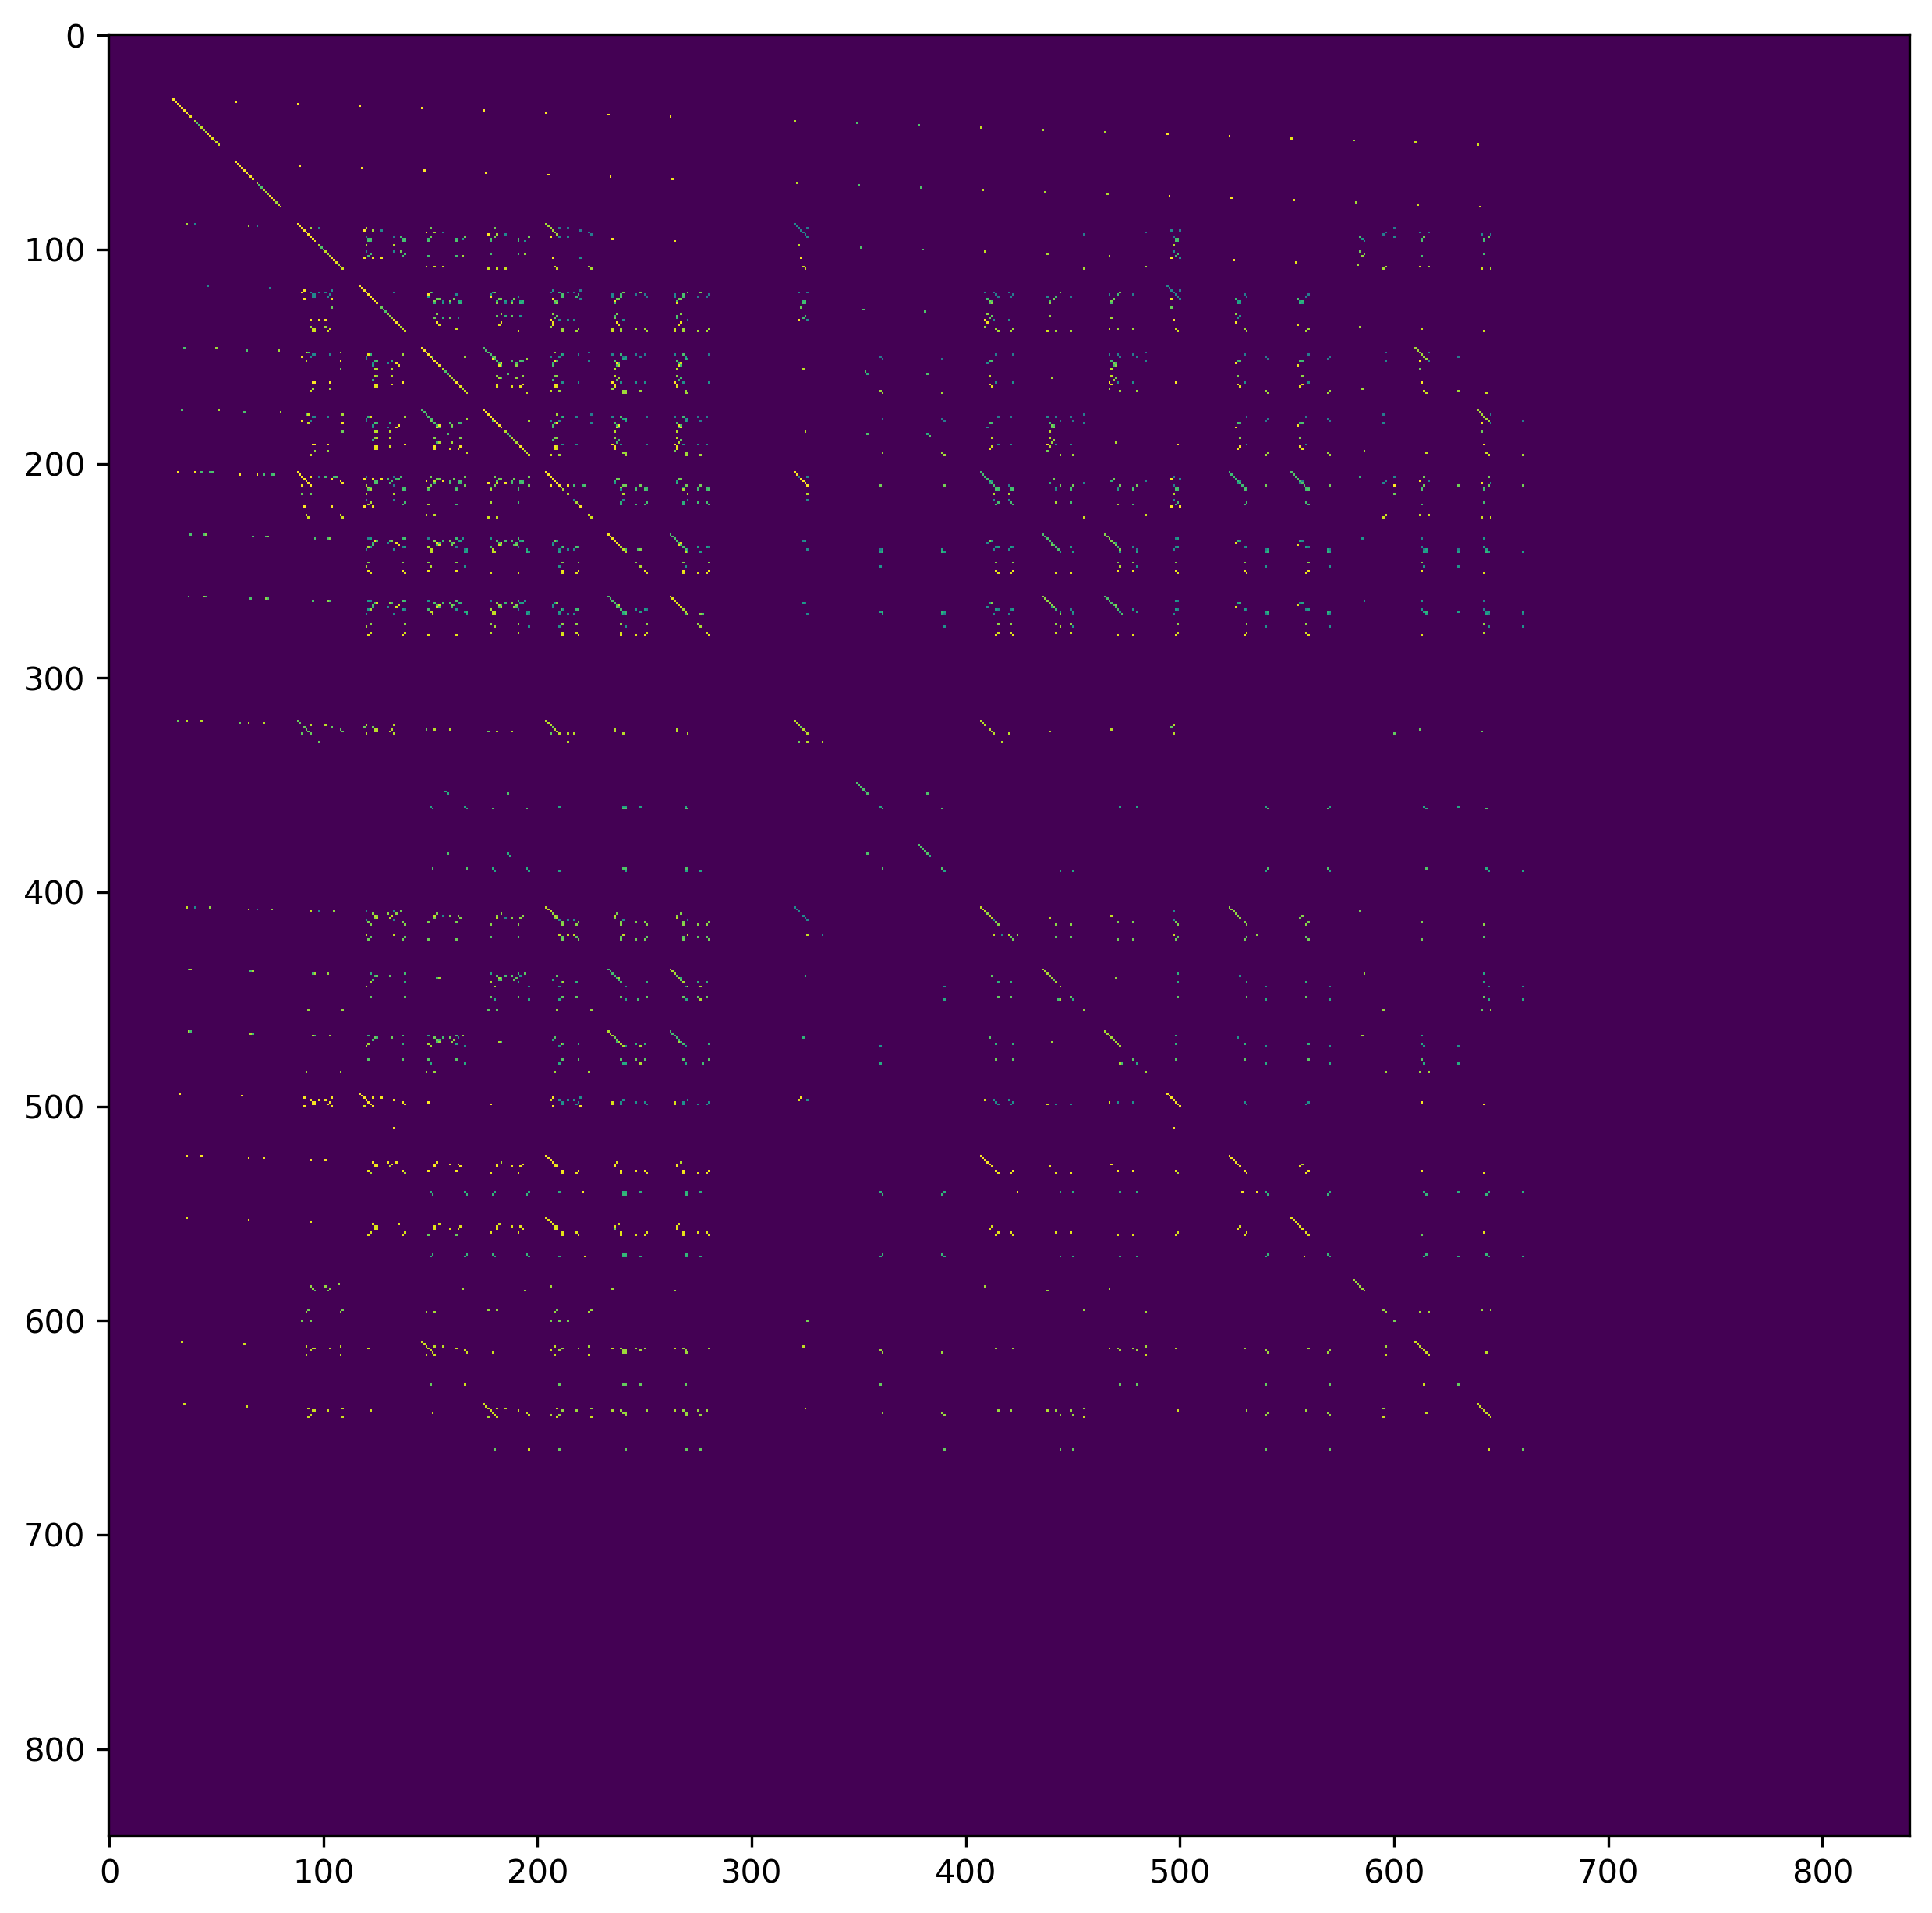

131805.0


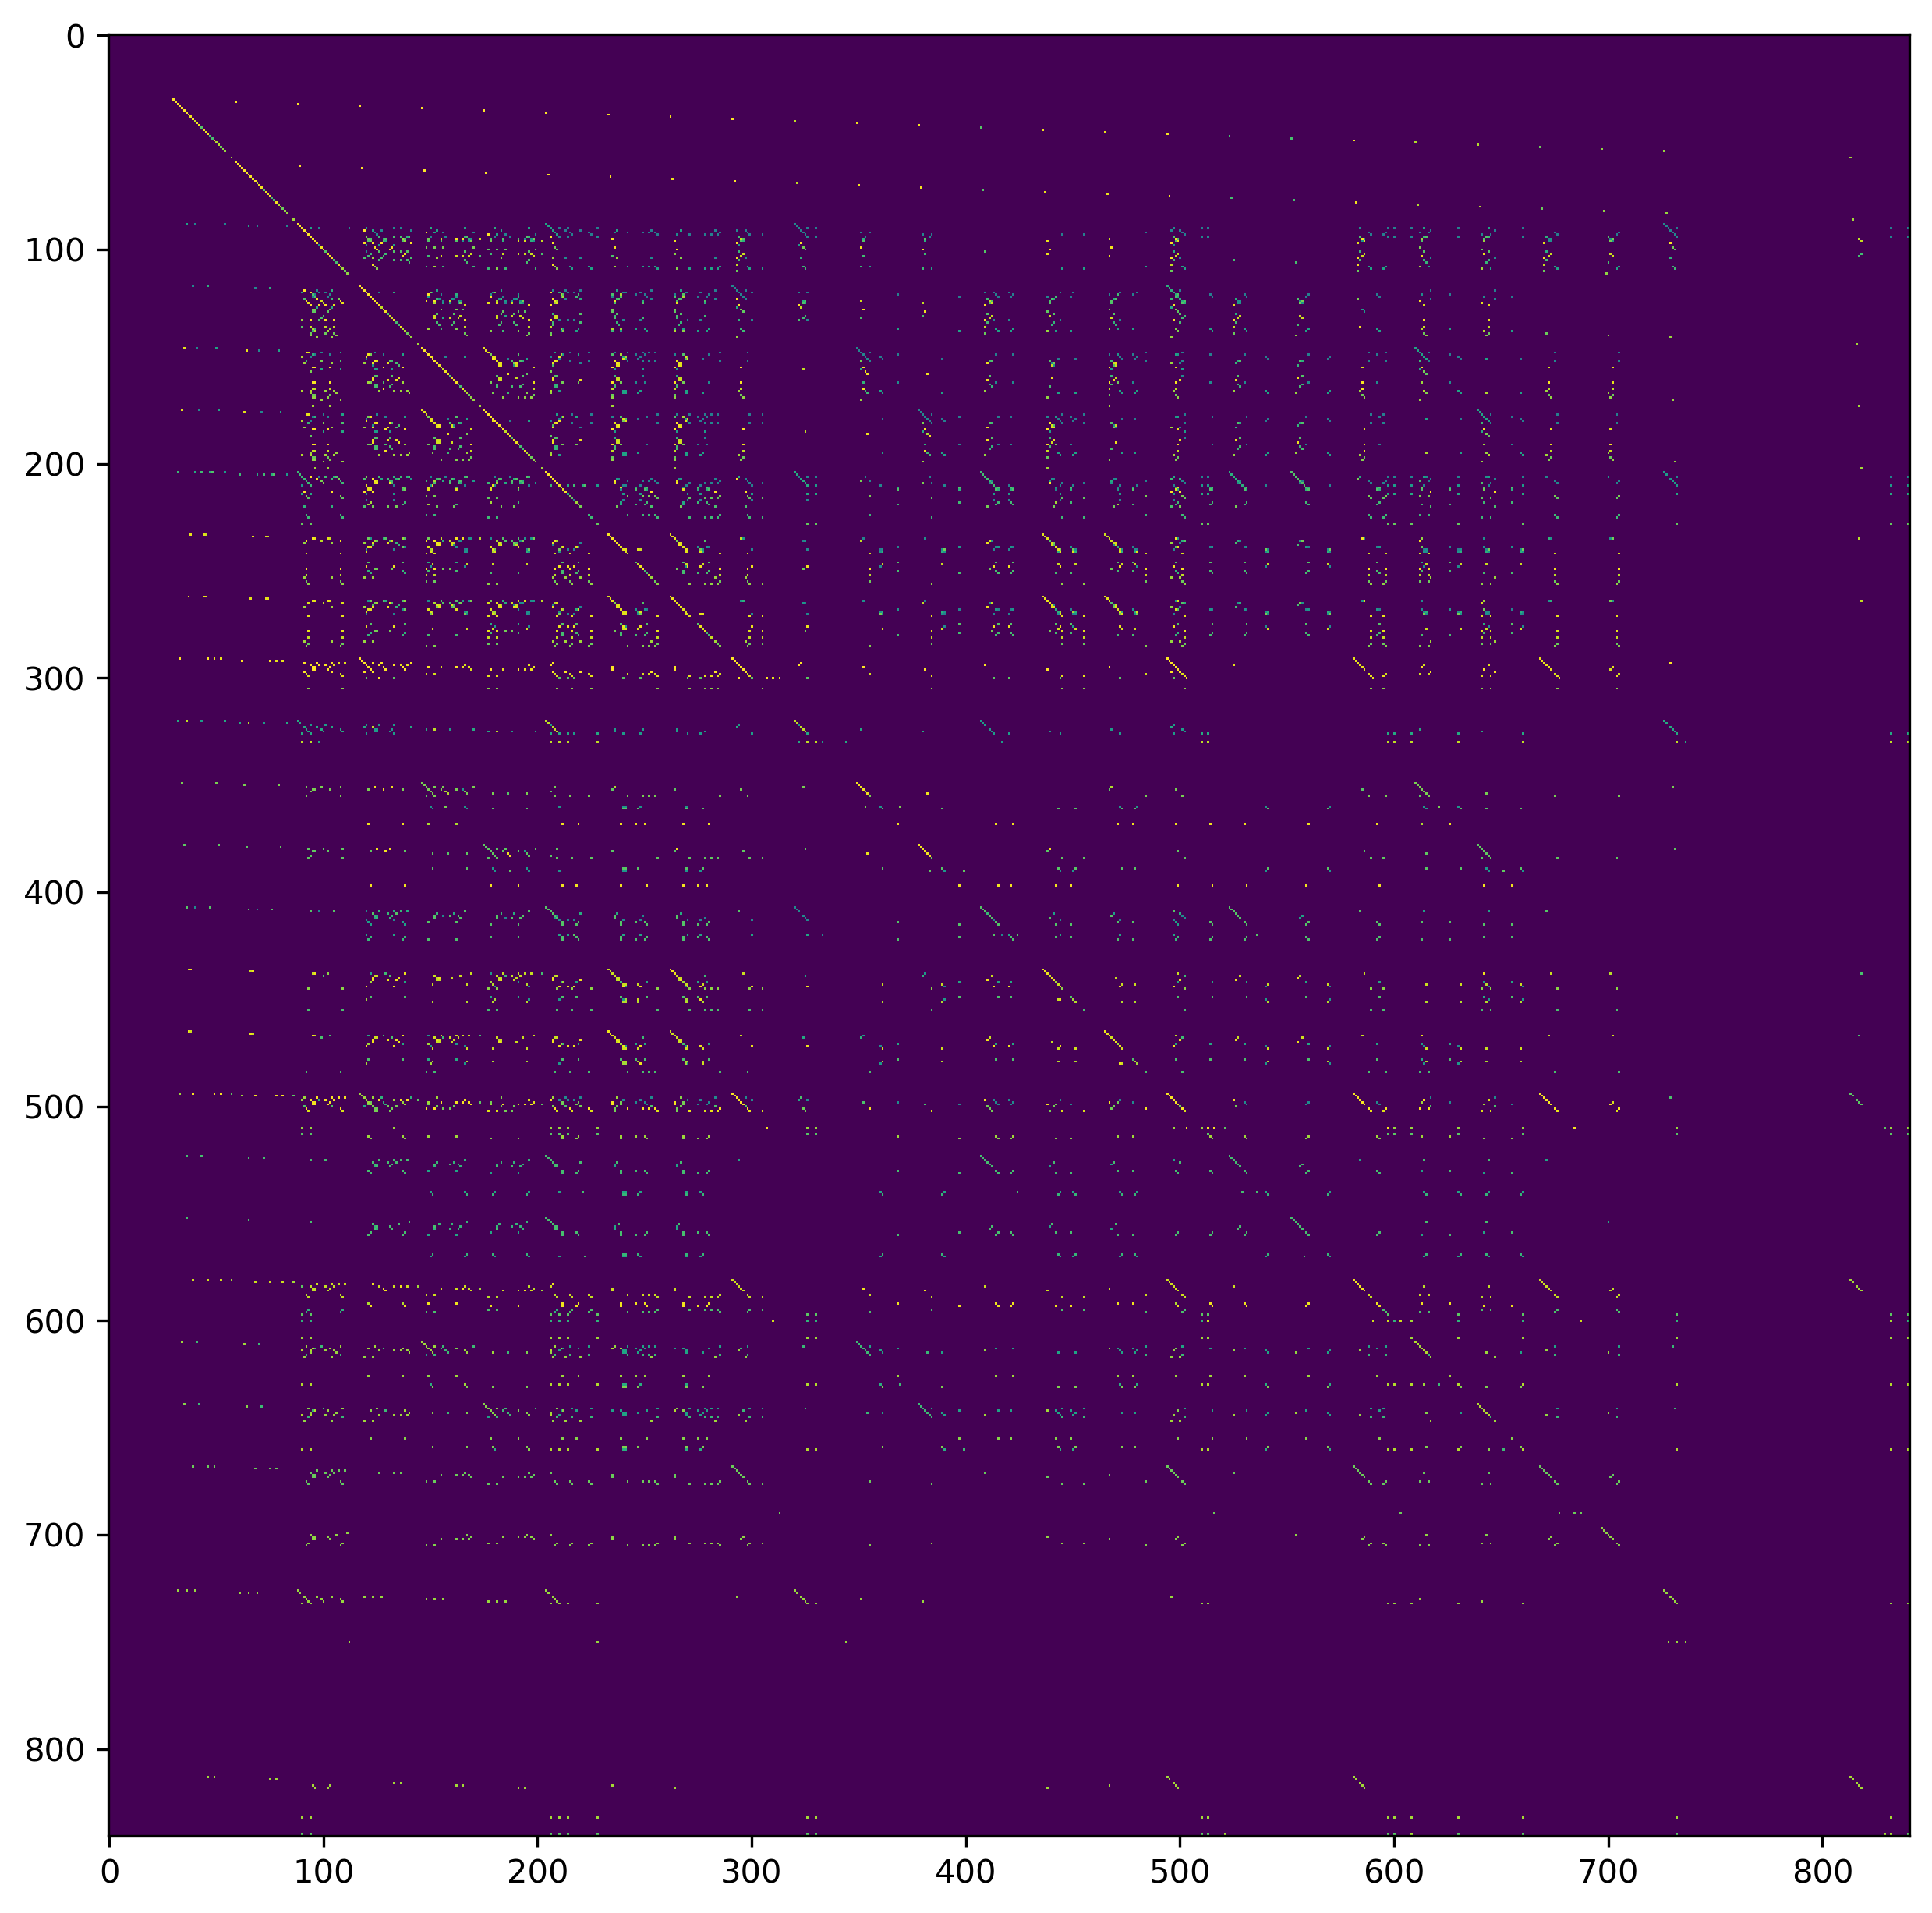

325657.0


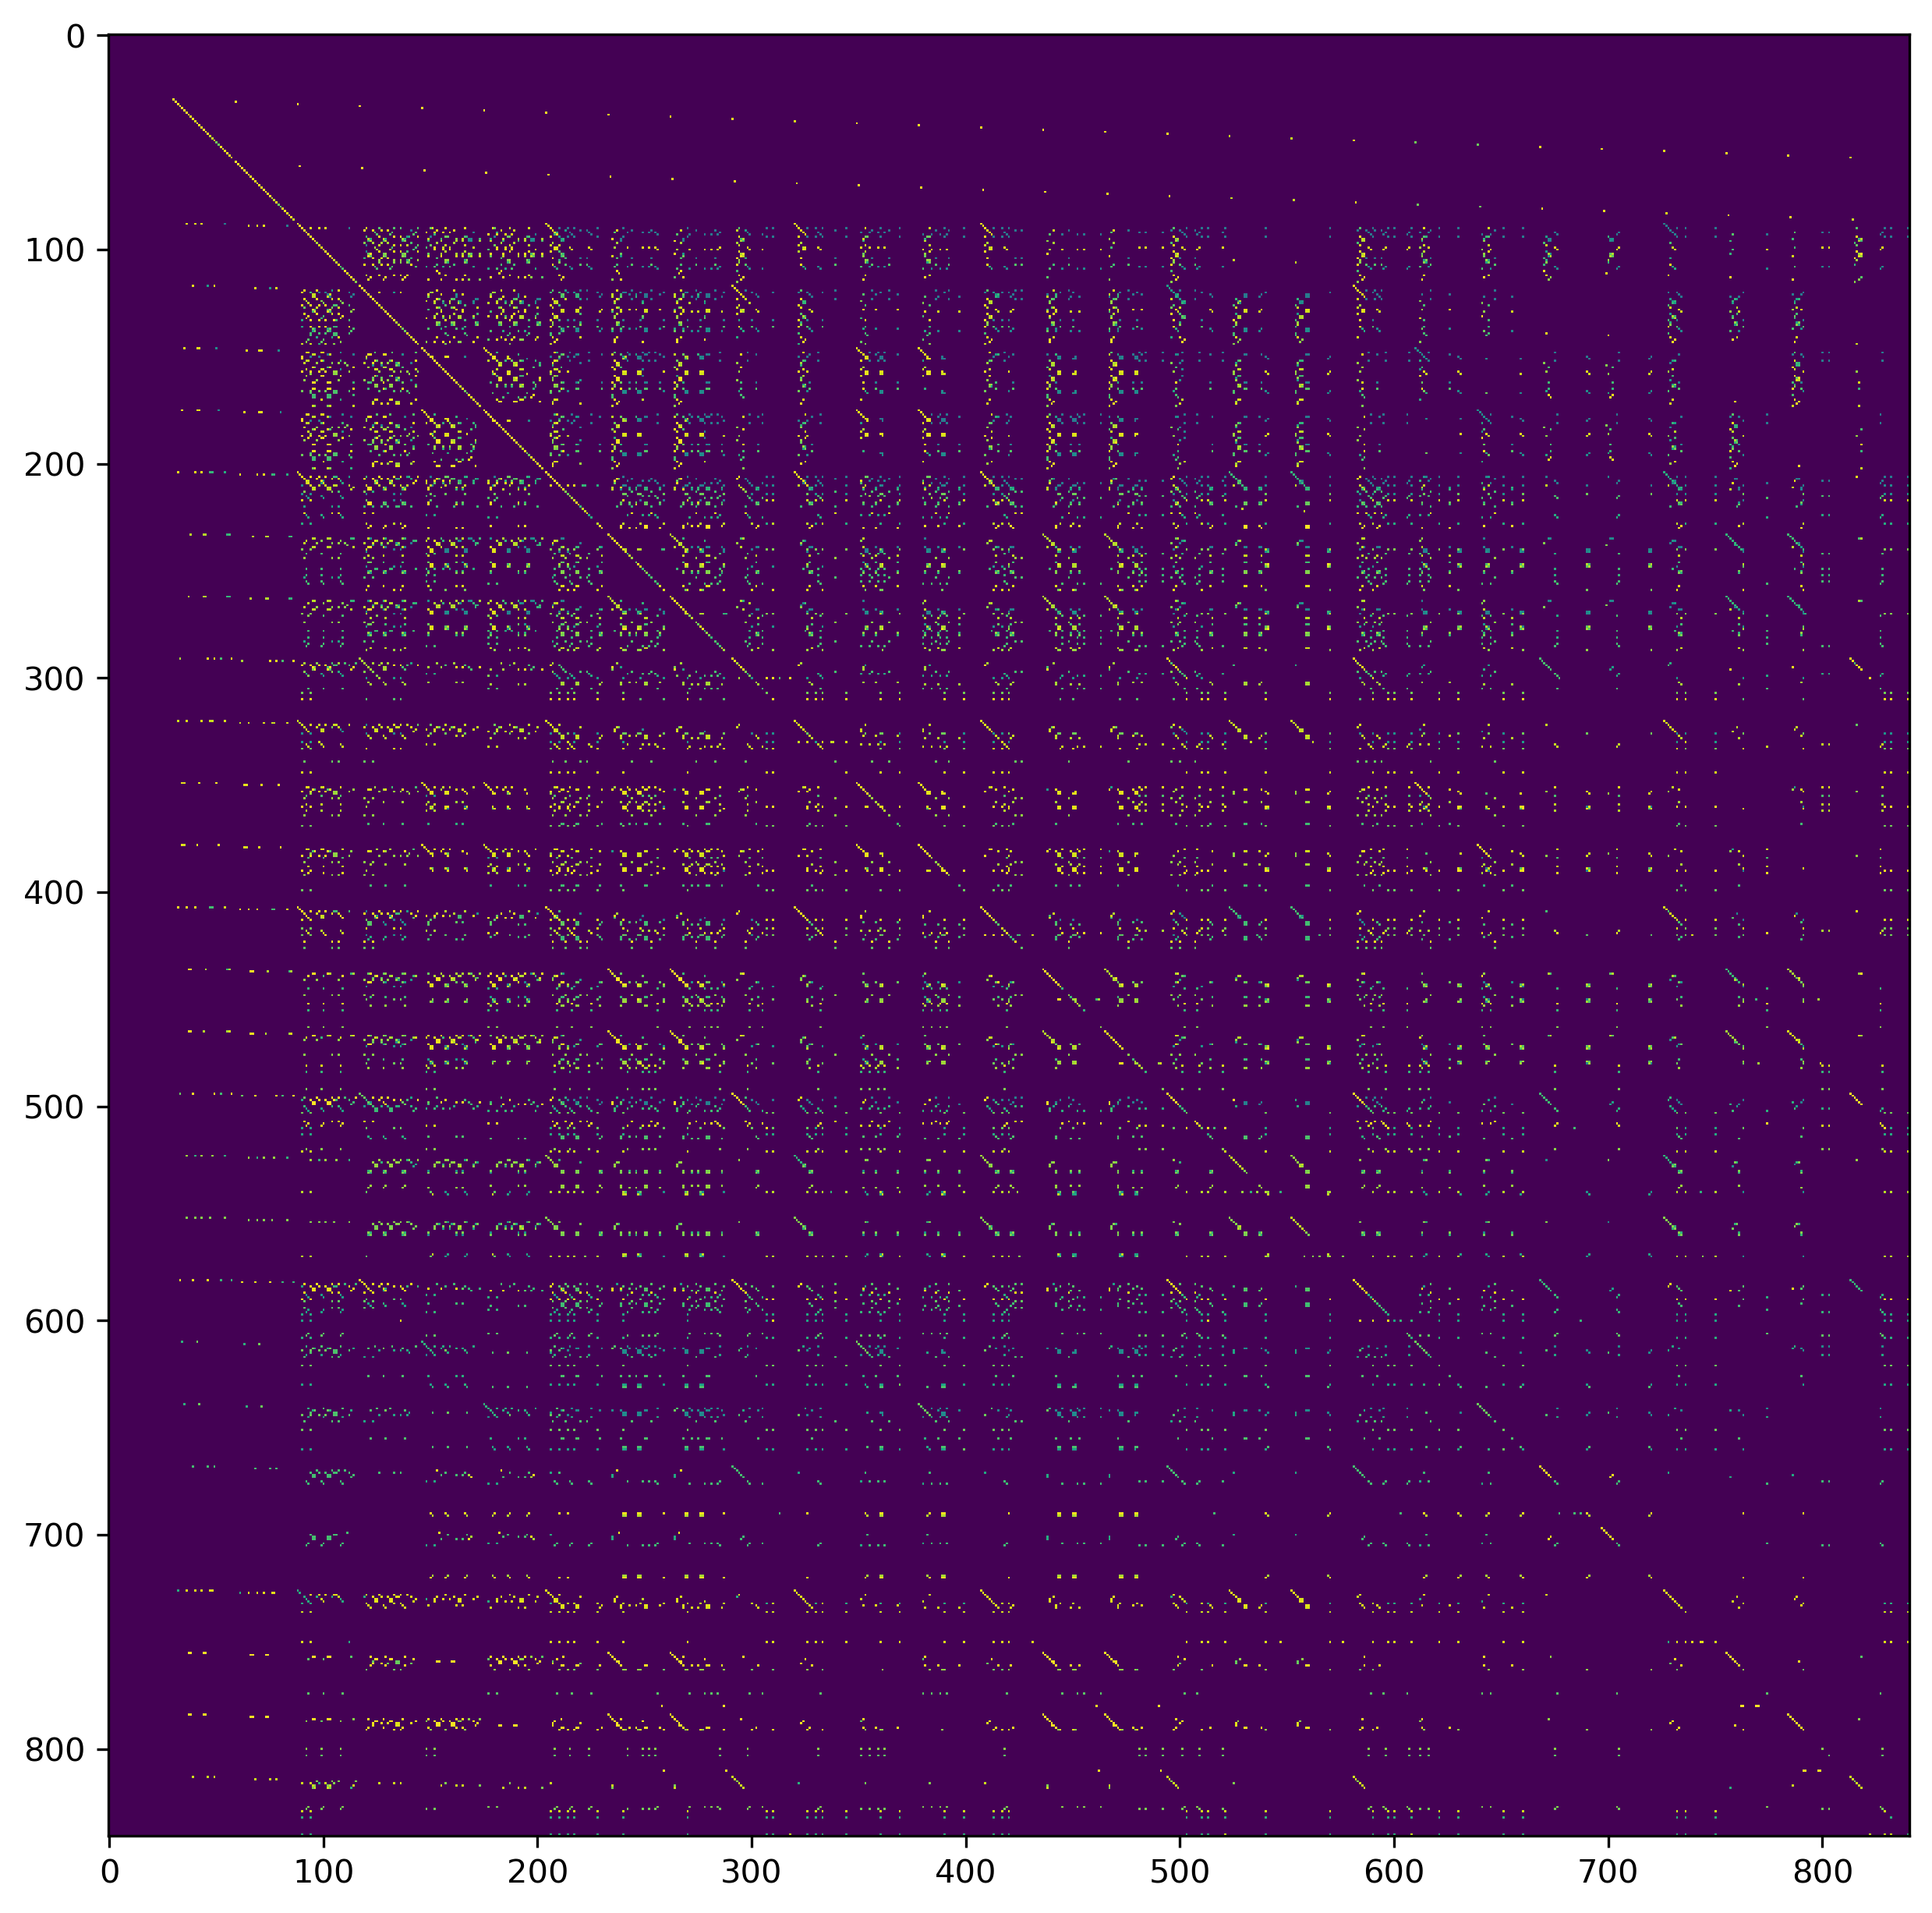

776647.0


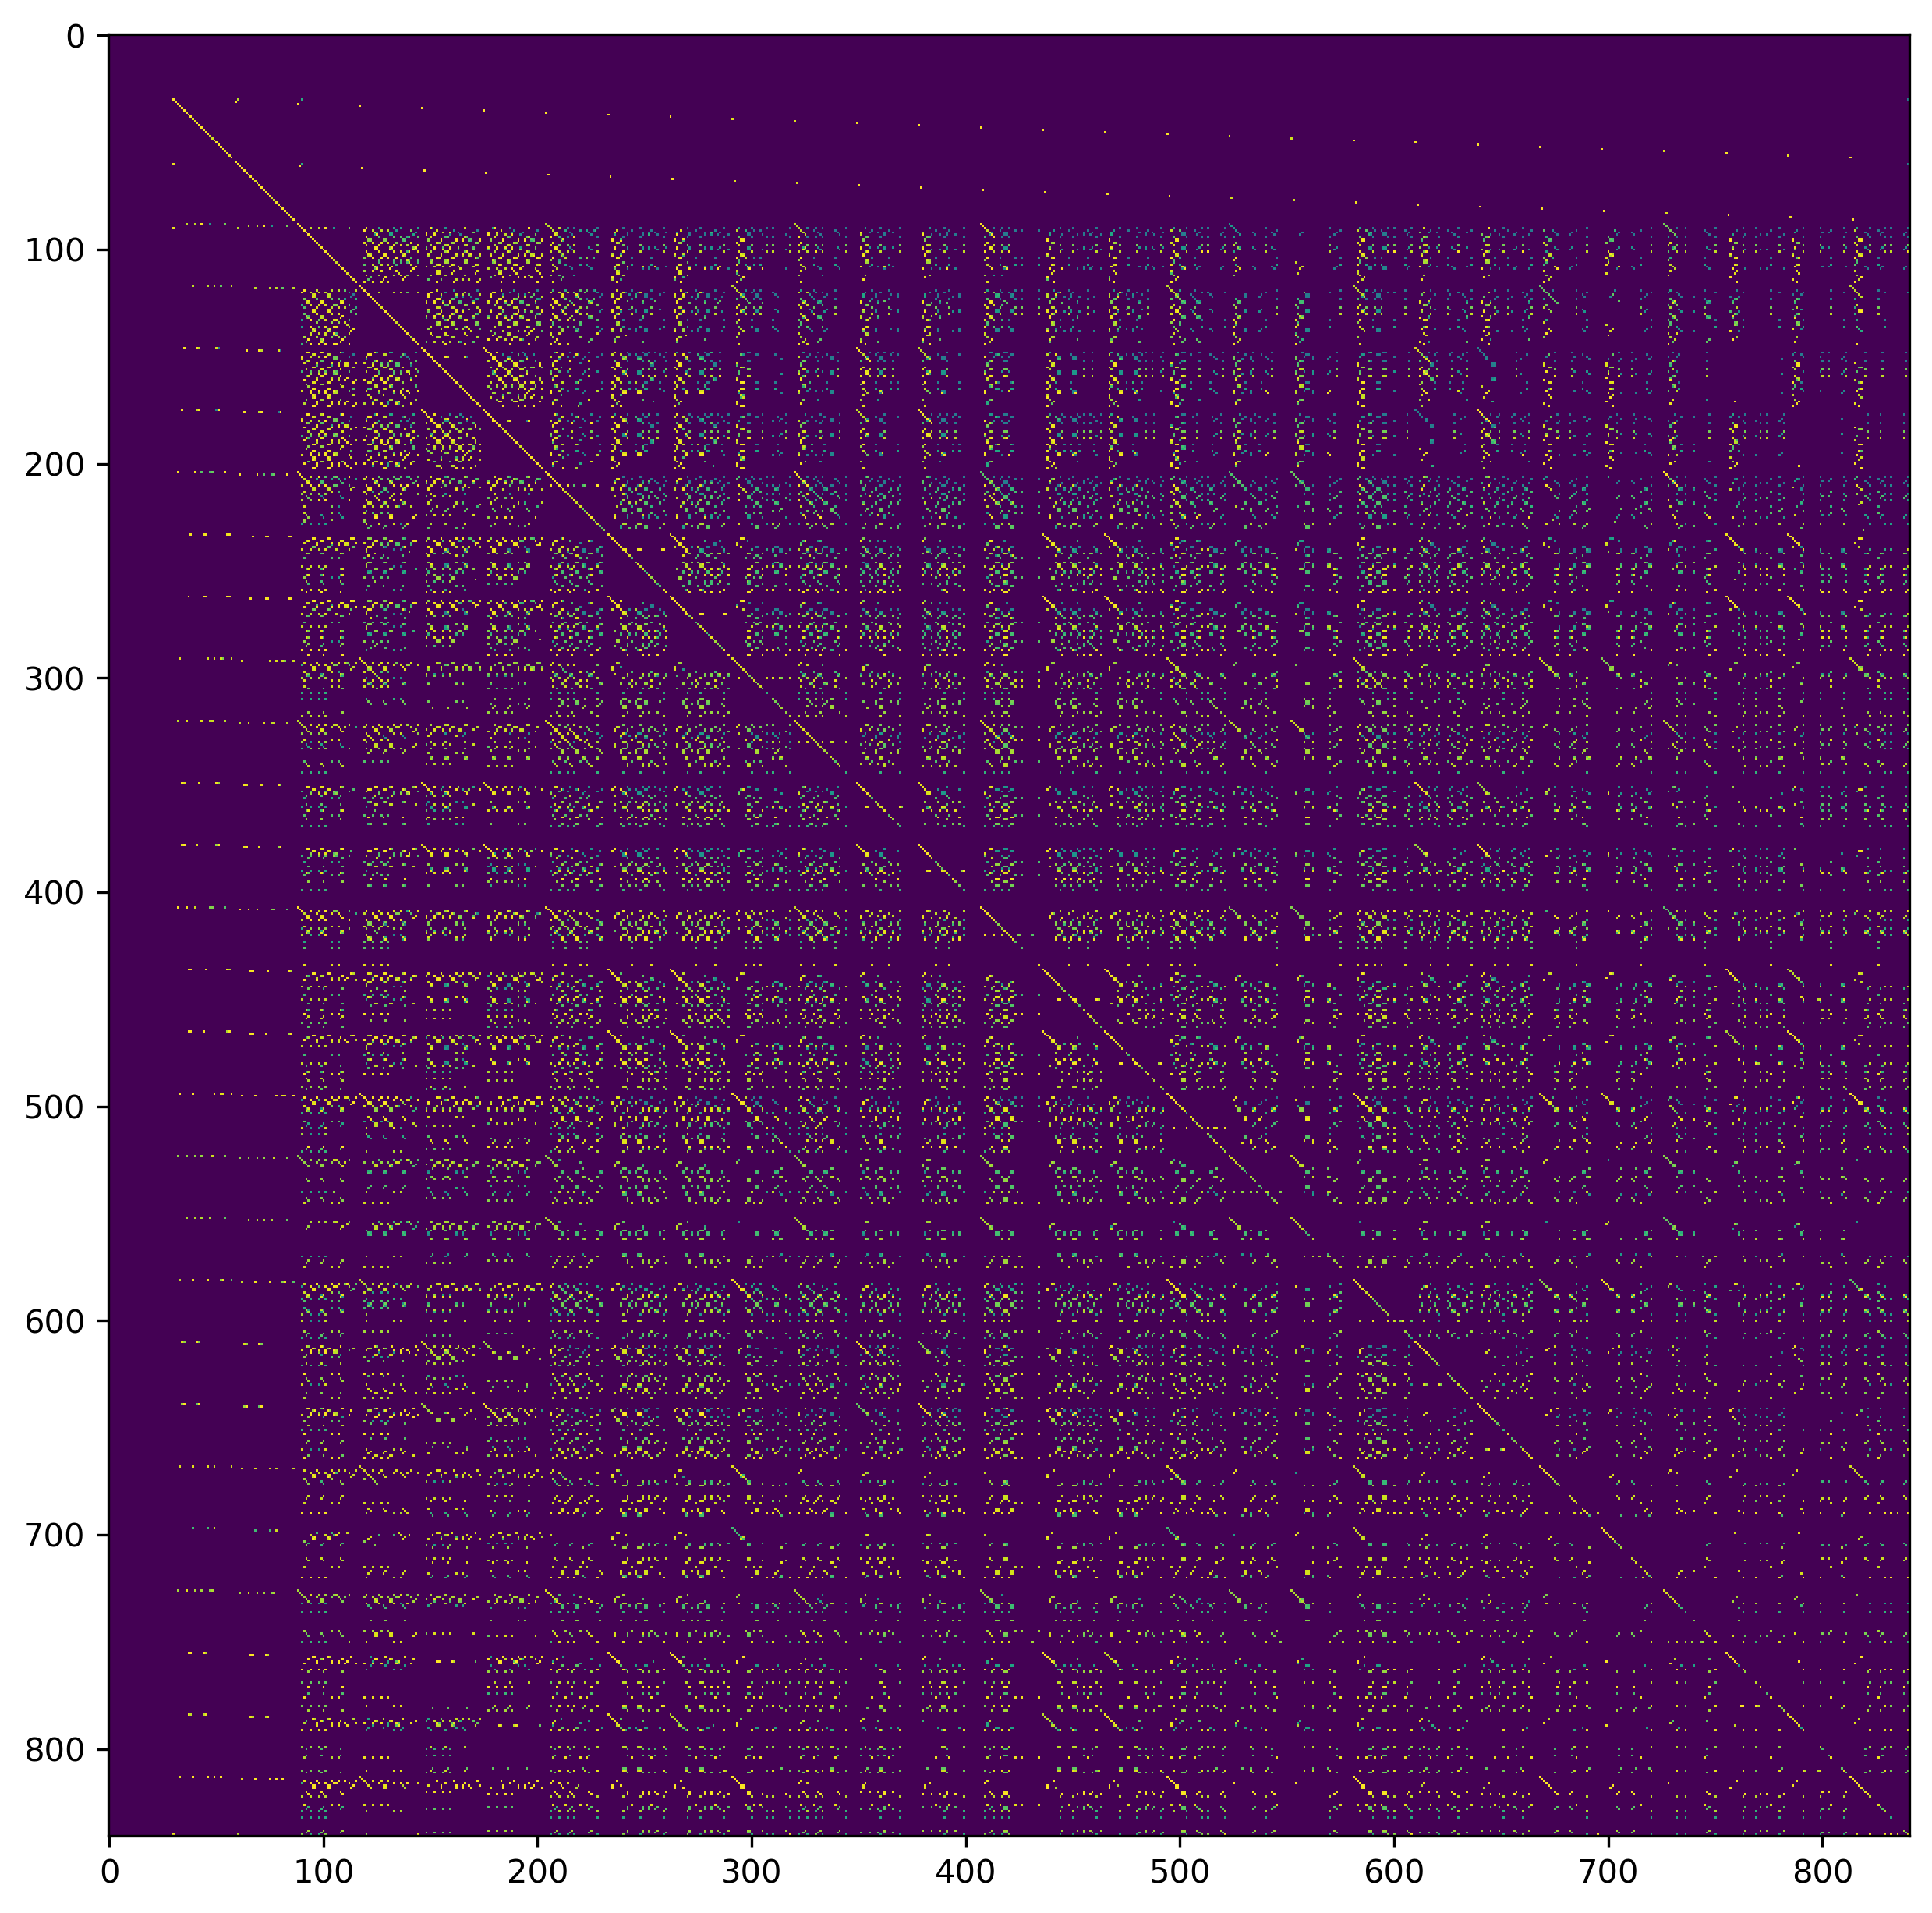

1809307.0


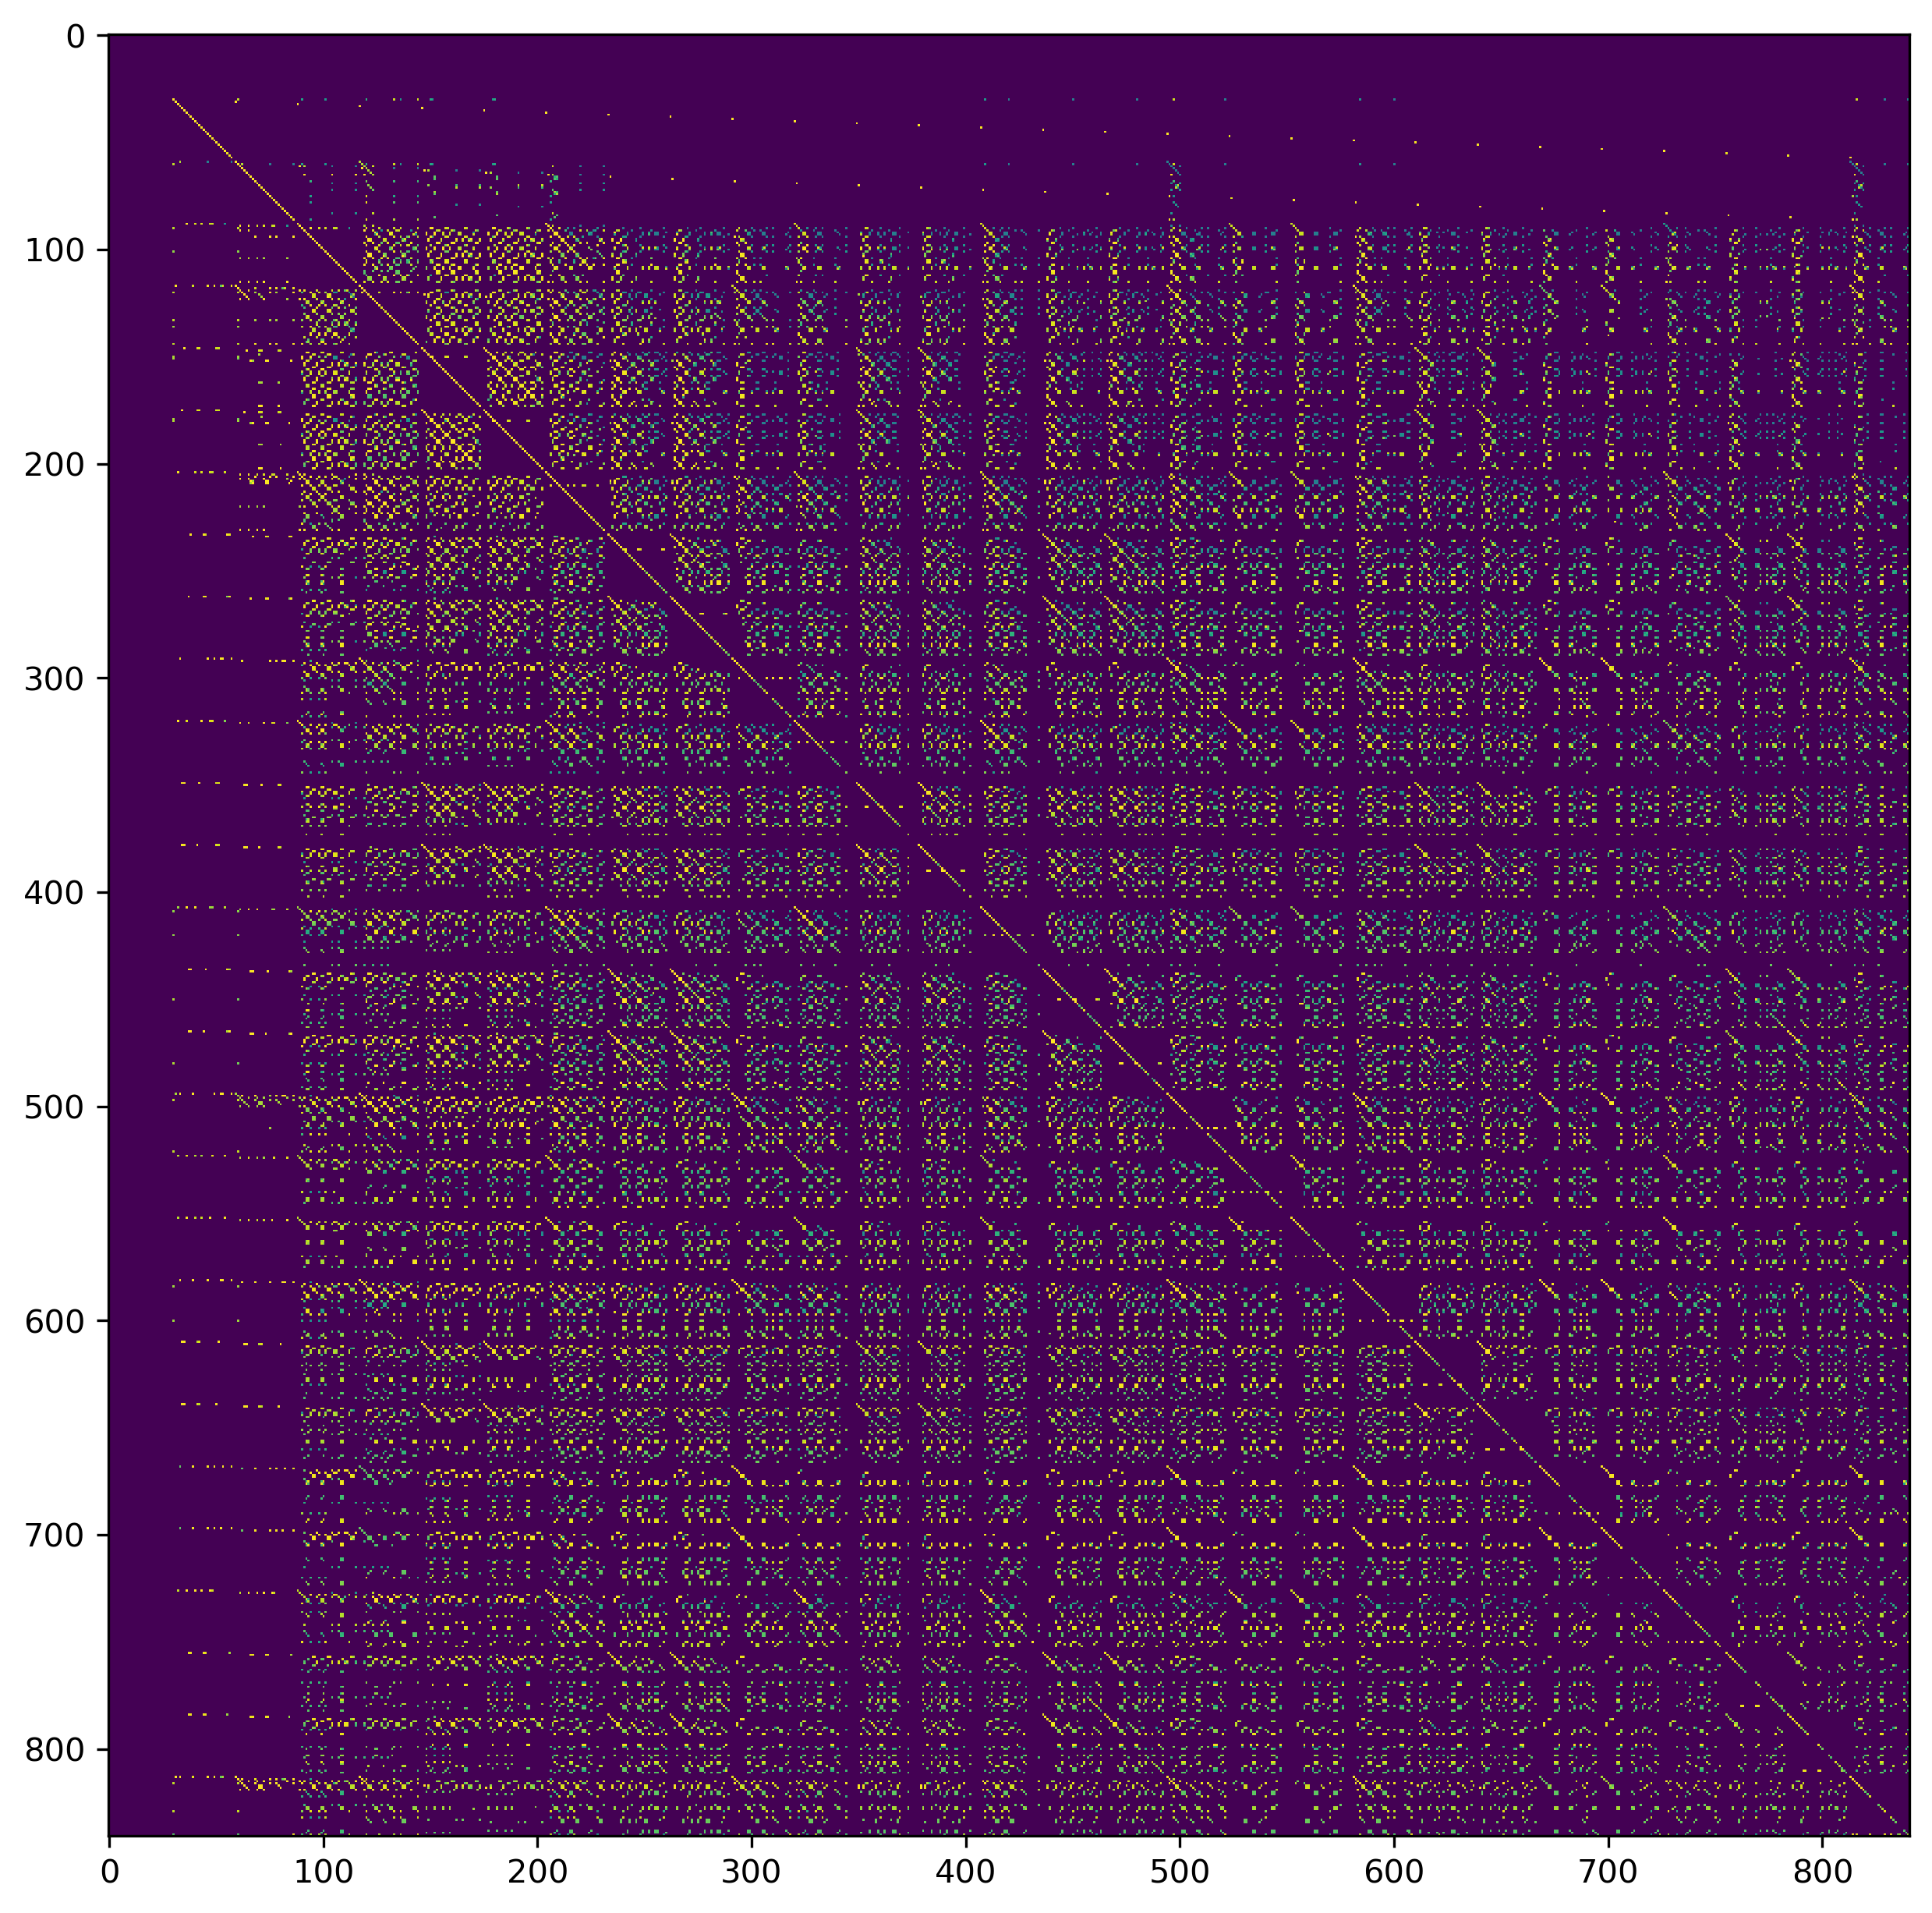

In [64]:
for m in mem_maps:
    print(np.max(m))
    plt.imshow(m, cmap='viridis')
    plt.show()

## Tracing (selection step)

Tracing another of the execution version, this one with new determinants generation

In [14]:
# Profiling step
i = 4
fci_path='c2_eq_hf_dz.fcidump*'
wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
timeline = Timeline(integral_size(d_two_e_integral))
lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
cProfile.run("psi_external = main.Excitation(N_ord).gen_all_connected_determinant_from_psi(psi_det)")
cProfile.run("h = lewis.H(psi_det,psi_external)")

         4062634 function calls in 6.158 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.028    0.028    6.158    6.158 <string>:1(<module>)
  1132428    0.137    0.000    4.798    0.000 <string>:1(__new__)
        1    0.000    0.000    0.000    0.000 main.py:201(__init__)
      184    0.002    0.000    0.002    0.000 main.py:204(gen_all_exc_from_detspin)
      184    0.001    0.000    0.004    0.000 main.py:218(gen_all_connected_detspin_from_detspin)
   330924    0.385    0.000    0.483    0.000 main.py:226(apply_excitation)
       46    0.003    0.000    0.024    0.001 main.py:235(gen_all_connected_det_from_det)
   165508    0.082    0.000    0.357    0.000 main.py:258(<genexpr>)
   165508    0.083    0.000    0.356    0.000 main.py:263(<genexpr>)
   801550    0.200    0.000    4.916    0.000 main.py:267(<genexpr>)
        1    0.476    0.476    6.130    6.130 main.py:271(gen_all_connected_determinant_from

### Tracing without memory

Trace with a new timeline at every step

In [19]:
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
timeline = Timeline(integral_size(d_two_e_integral))

sel_nomem_maps = []
for i in range(1, 5):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    timeline.reset()
    lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
    psi_external = main.Excitation(N_ord).gen_all_connected_determinant_from_psi(psi_det)
    h = lewis.H(psi_det,psi_external)
    sel_nomem_maps.append(lewis.timeline.view2d())

36035.0


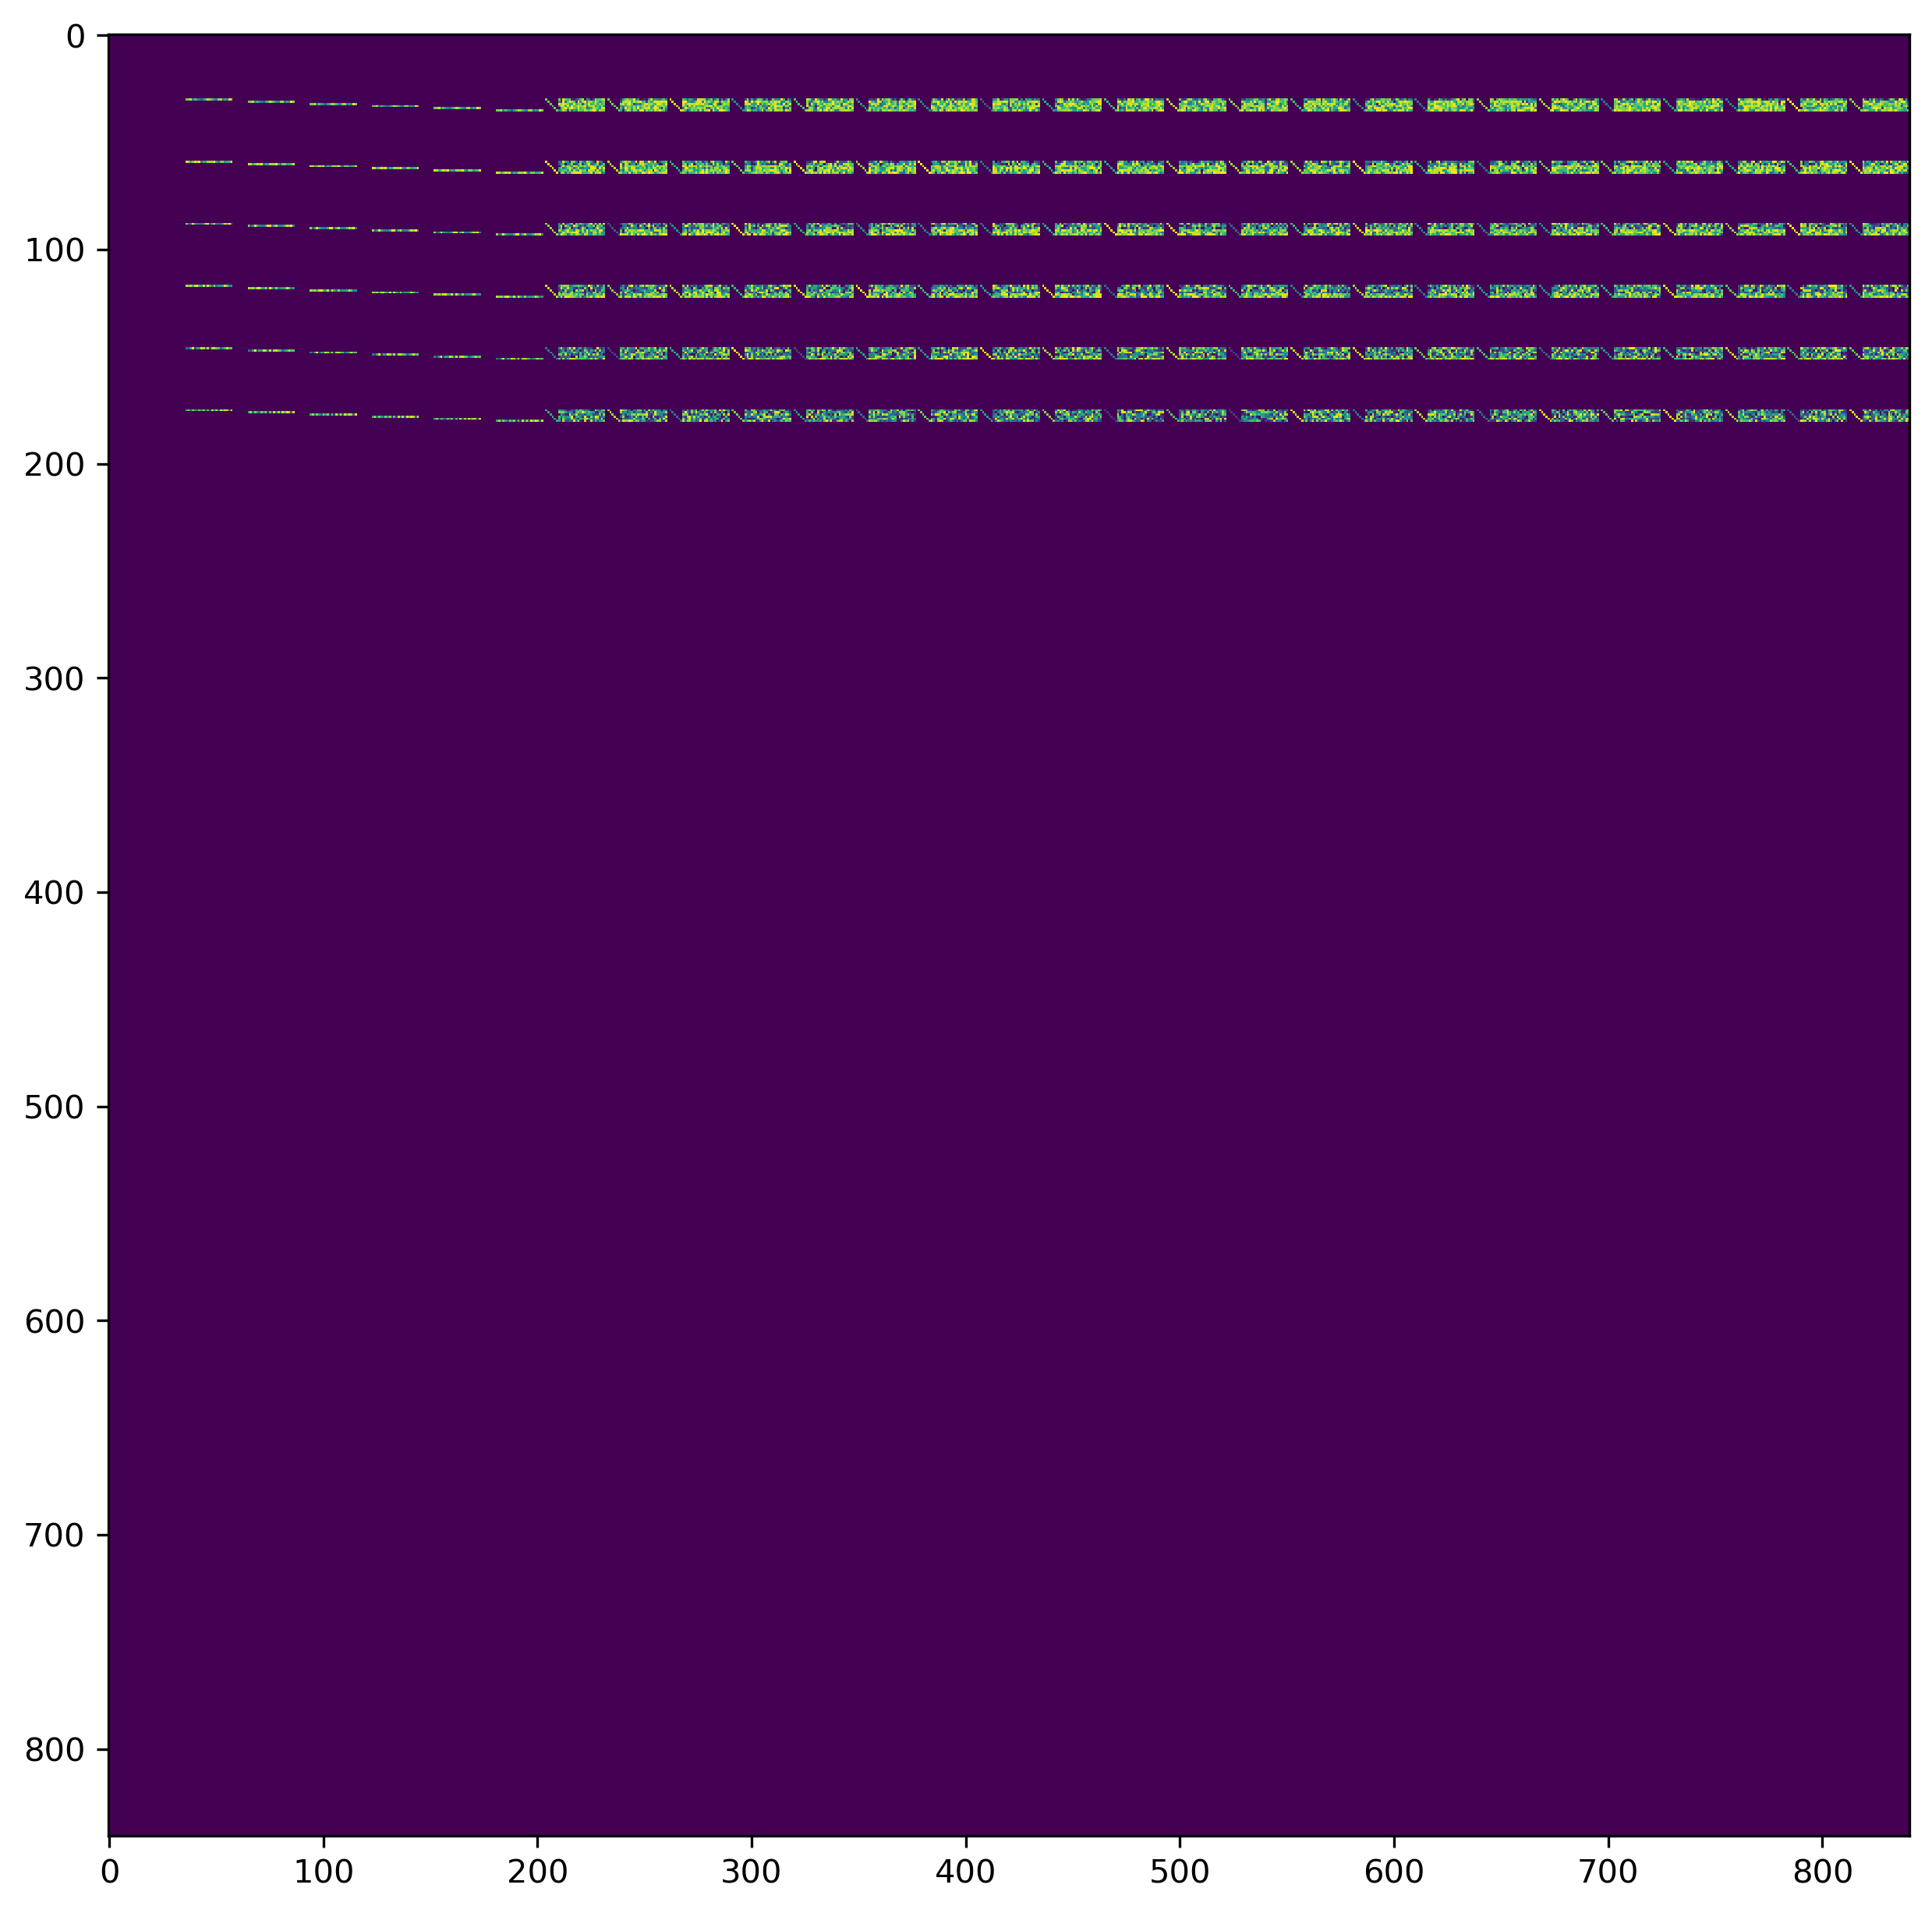

288229.0


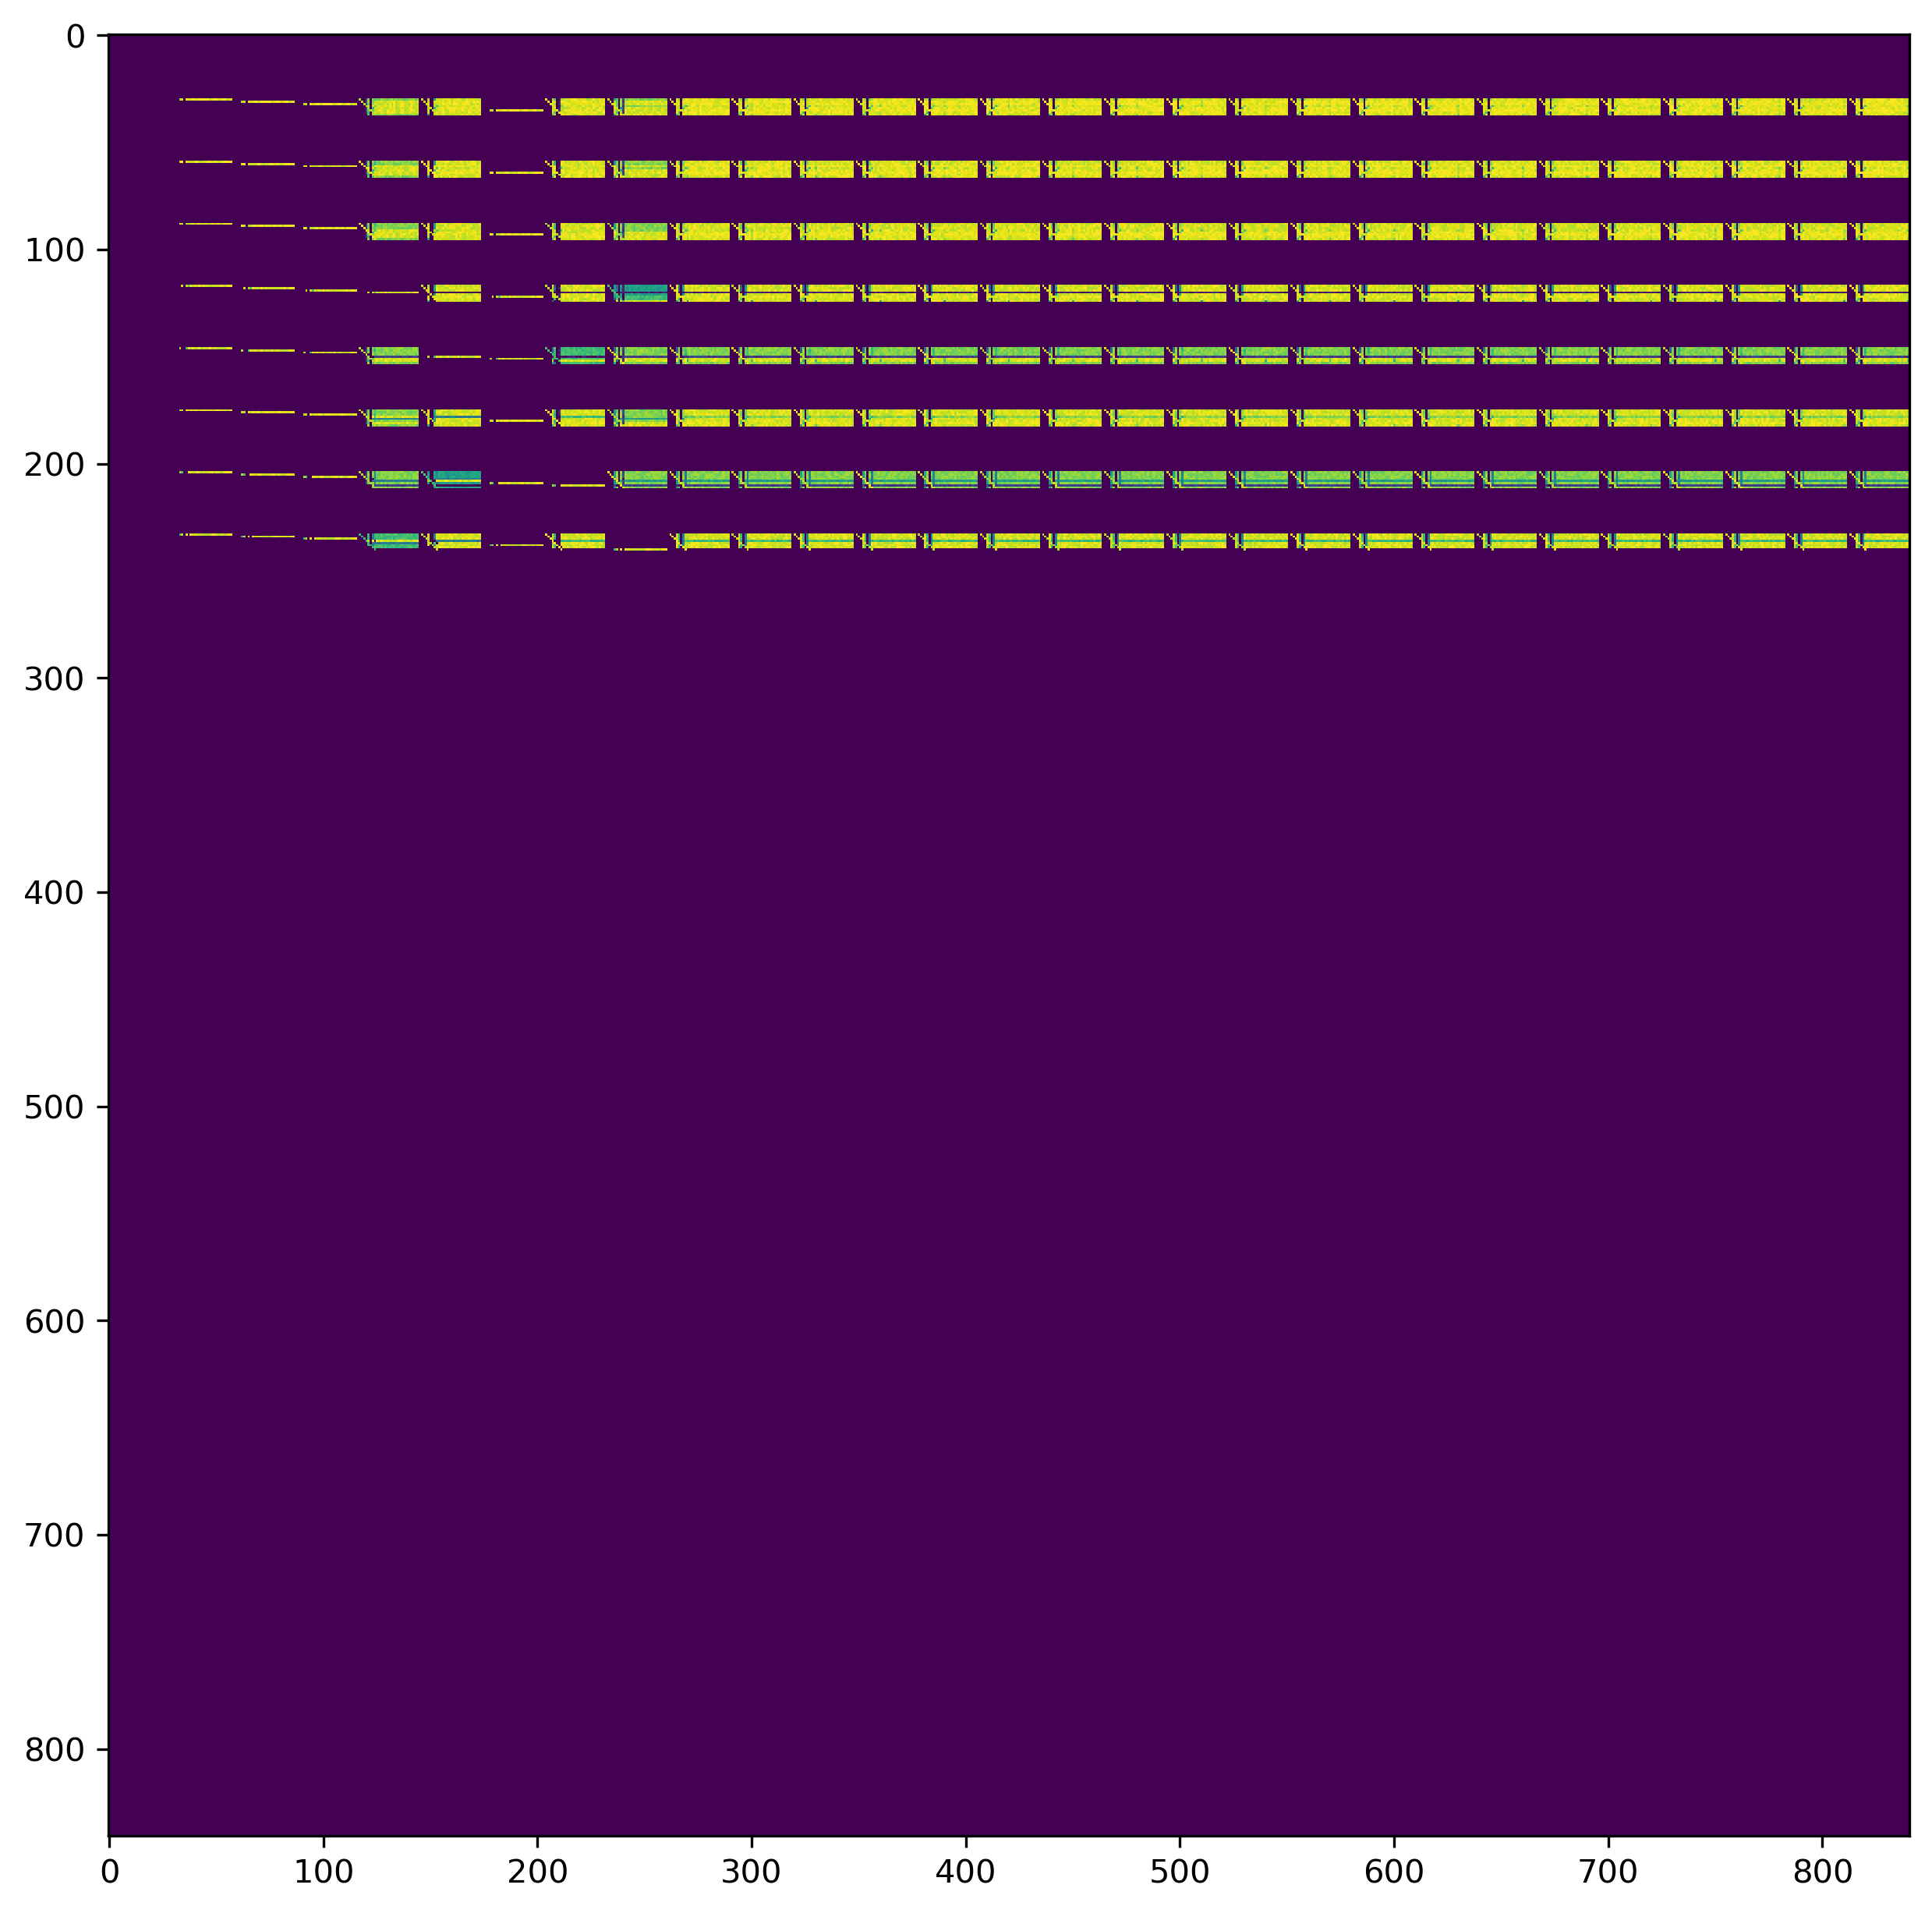

792485.0


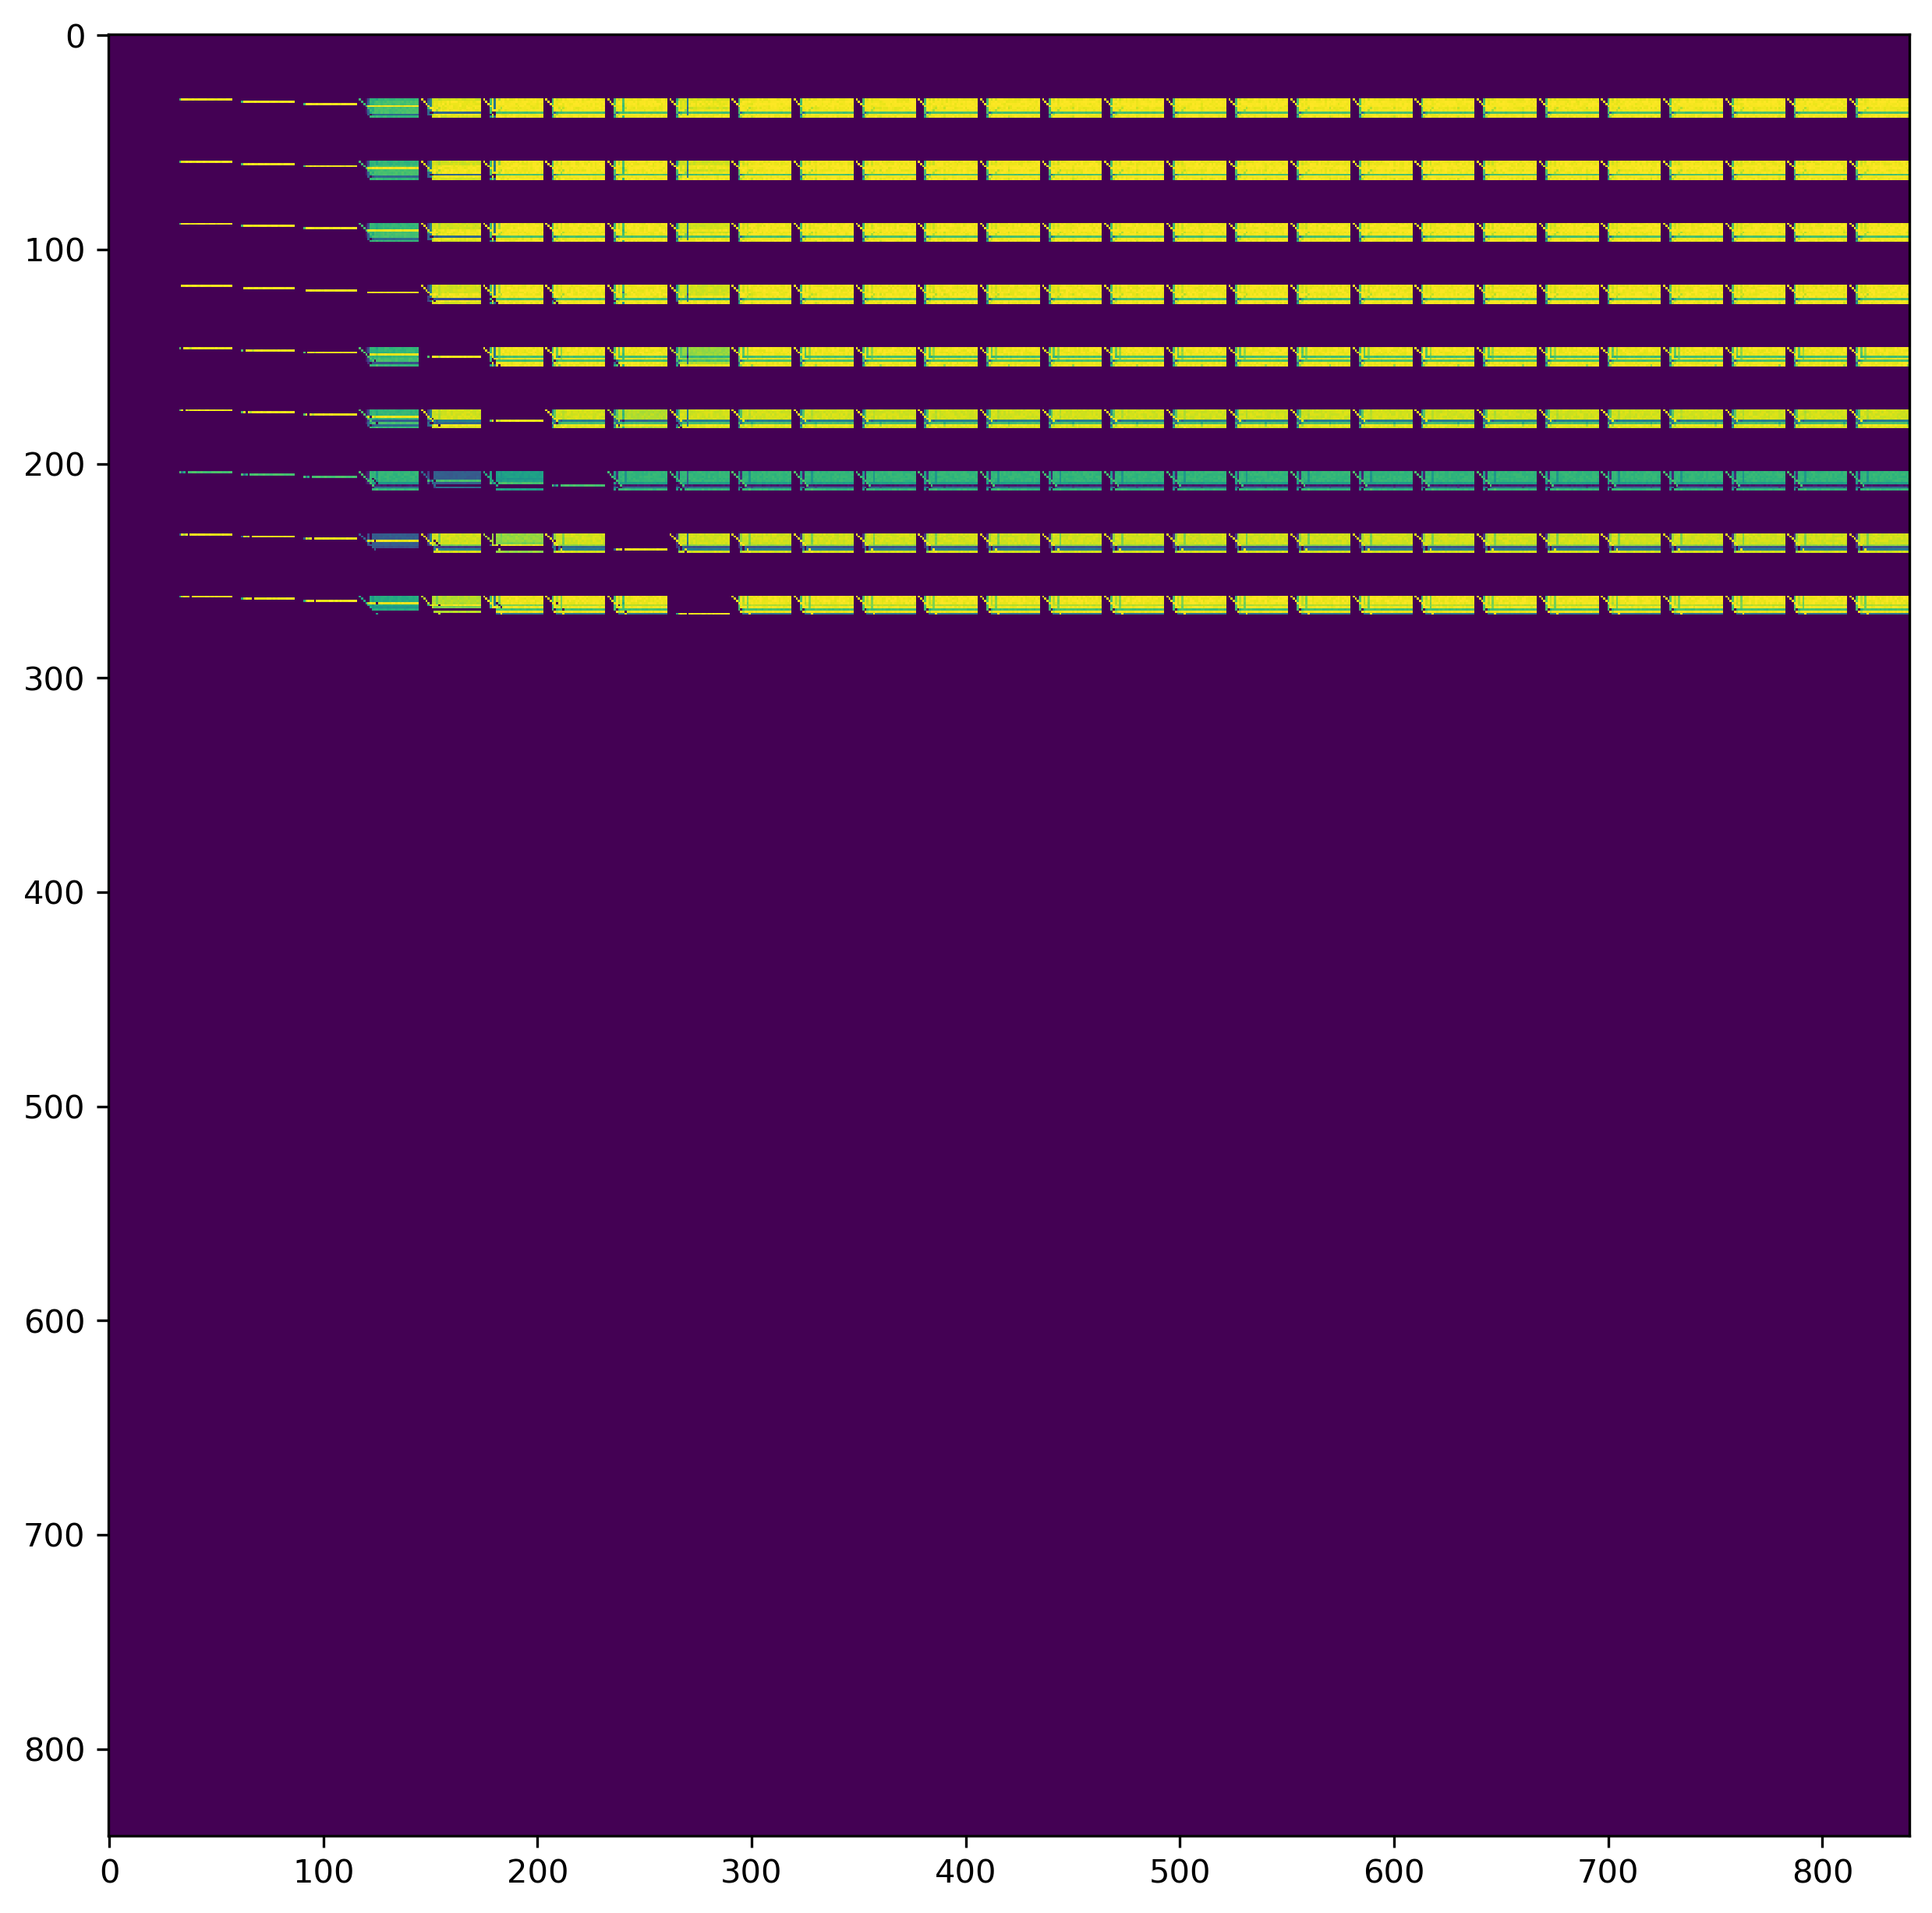

1656603.0


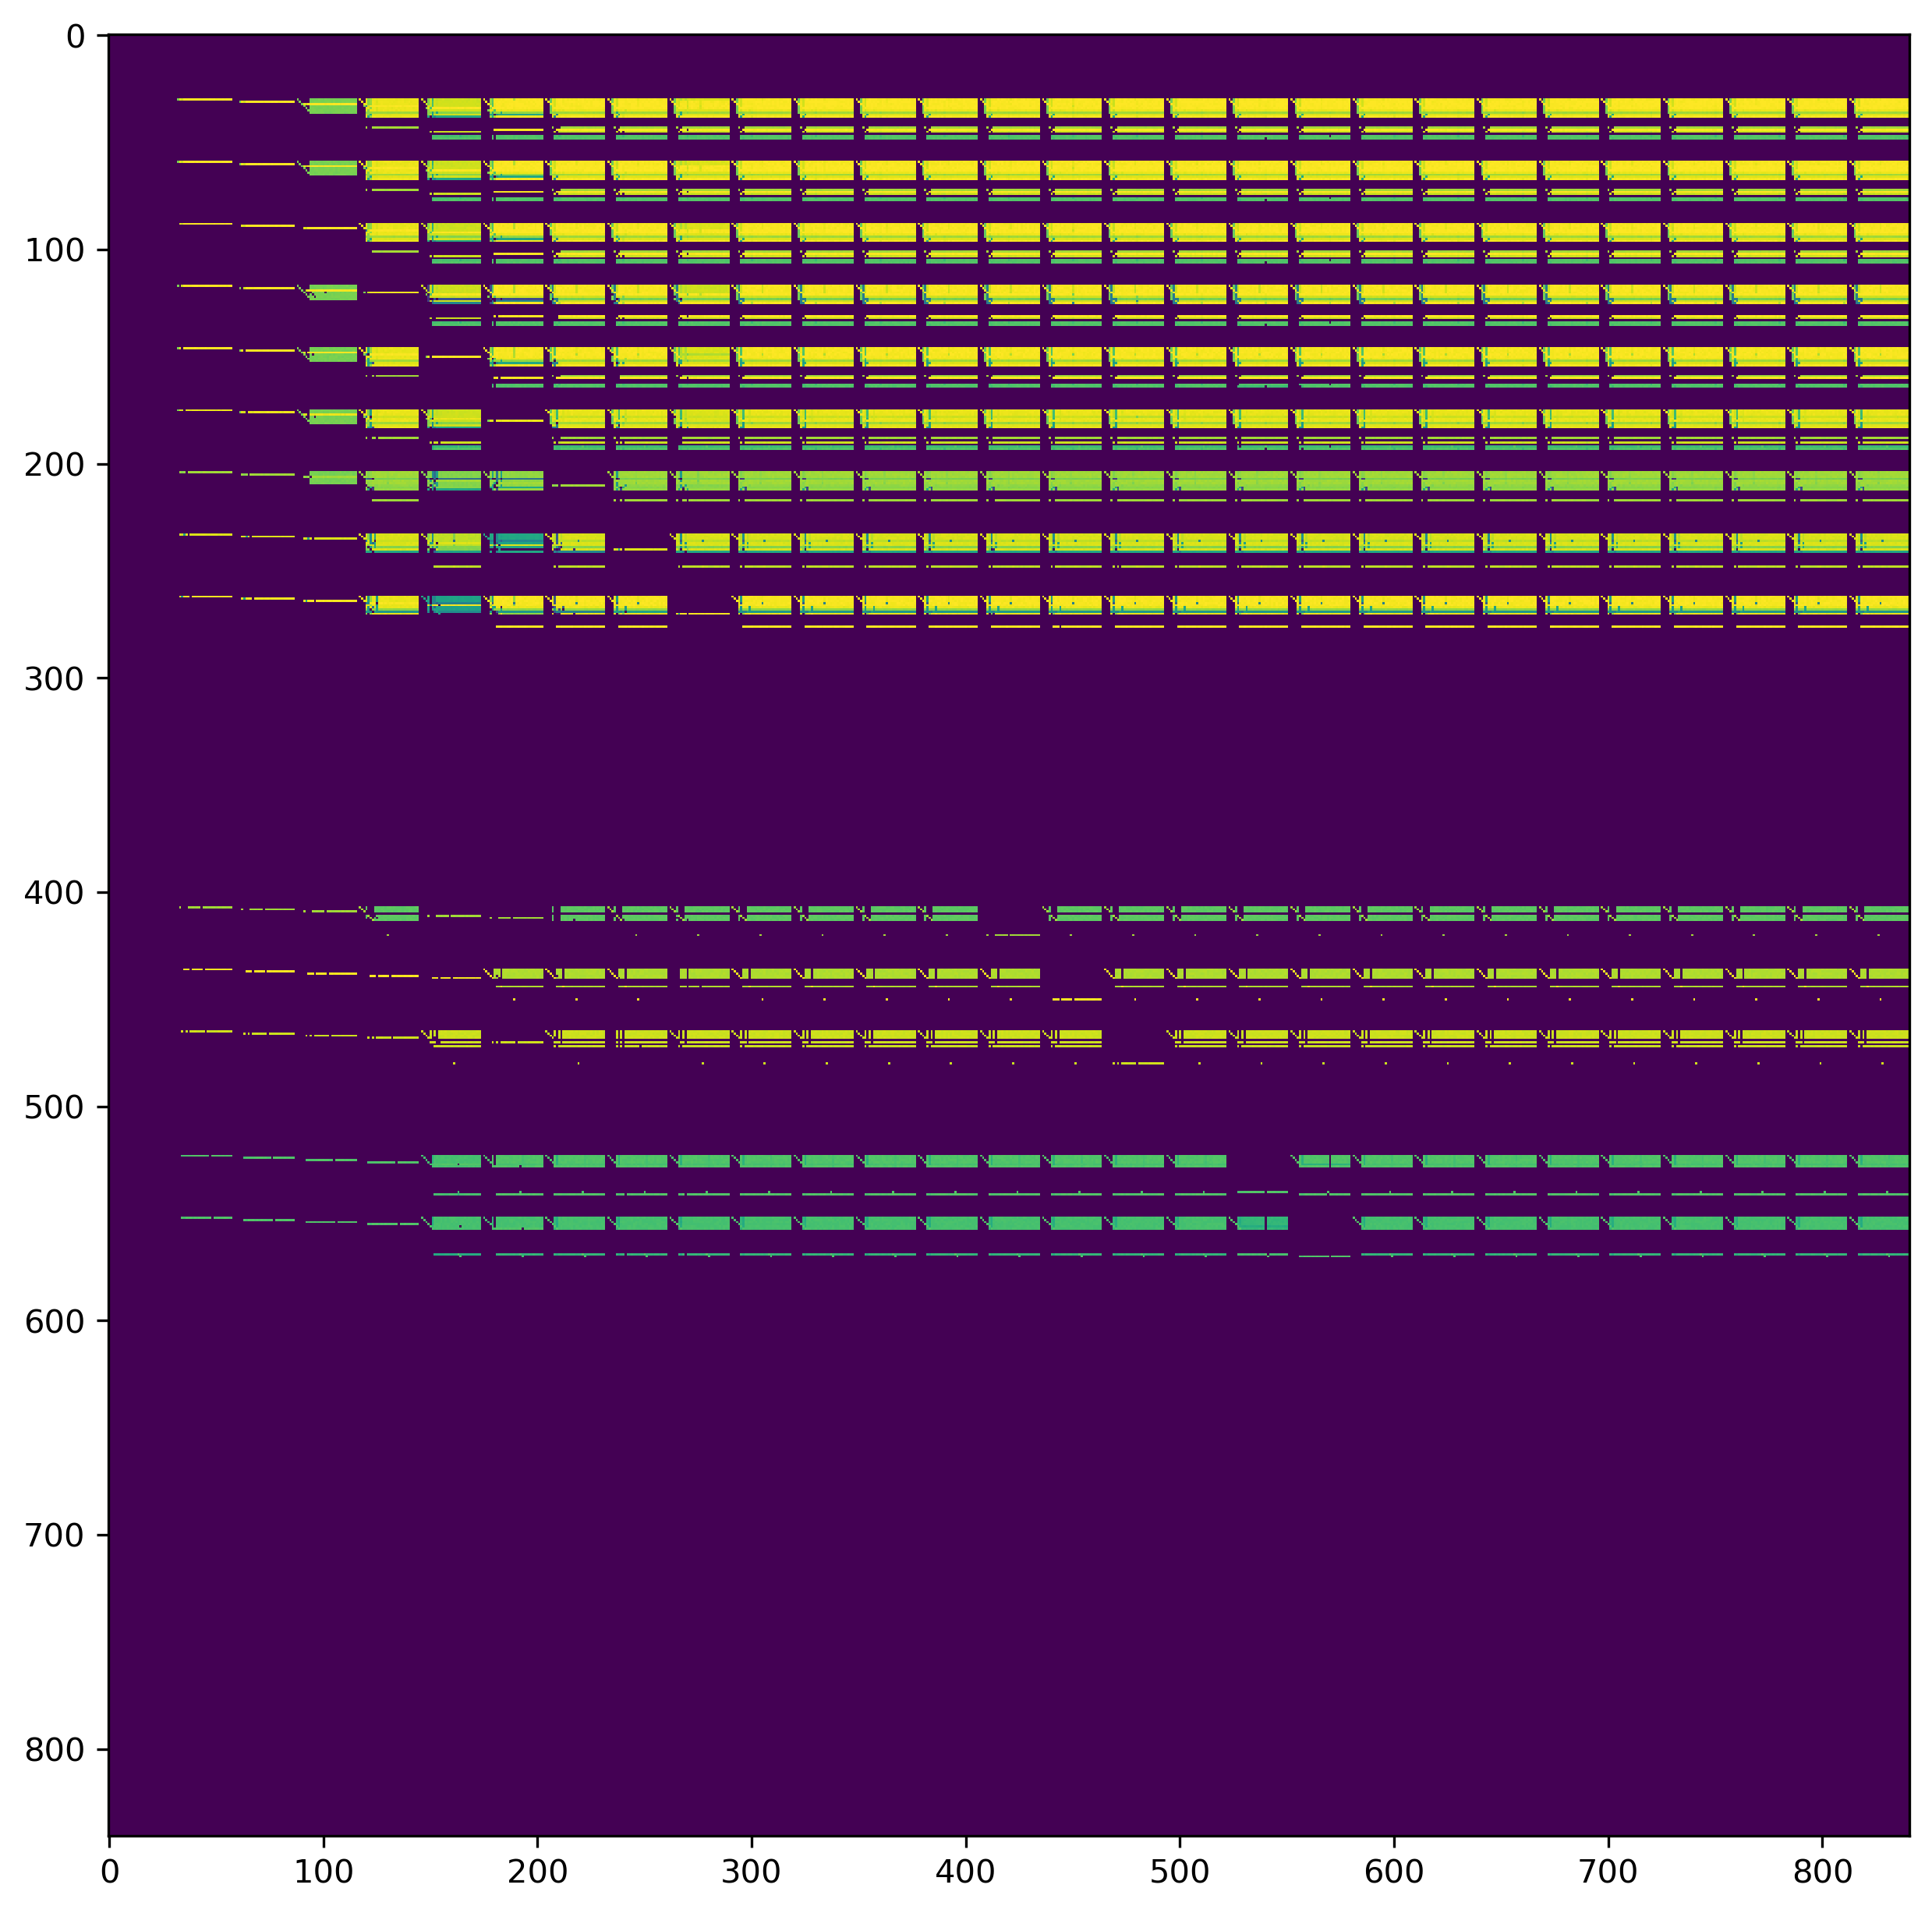

In [20]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 300
for m in sel_nomem_maps:
    print(np.max(m))
    plt.imshow(m, cmap='viridis')
    plt.show()

### Tracing with memory

Trace with the same timeline across iterations

In [21]:
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
timeline = Timeline(integral_size(d_two_e_integral))

sel_mem_maps = []
for i in range(1, 5):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
    psi_external = main.Excitation(N_ord).gen_all_connected_determinant_from_psi(psi_det)
    h = lewis.H(psi_det,psi_external)
    sel_mem_maps.append(lewis.timeline.view2d())

36035.0


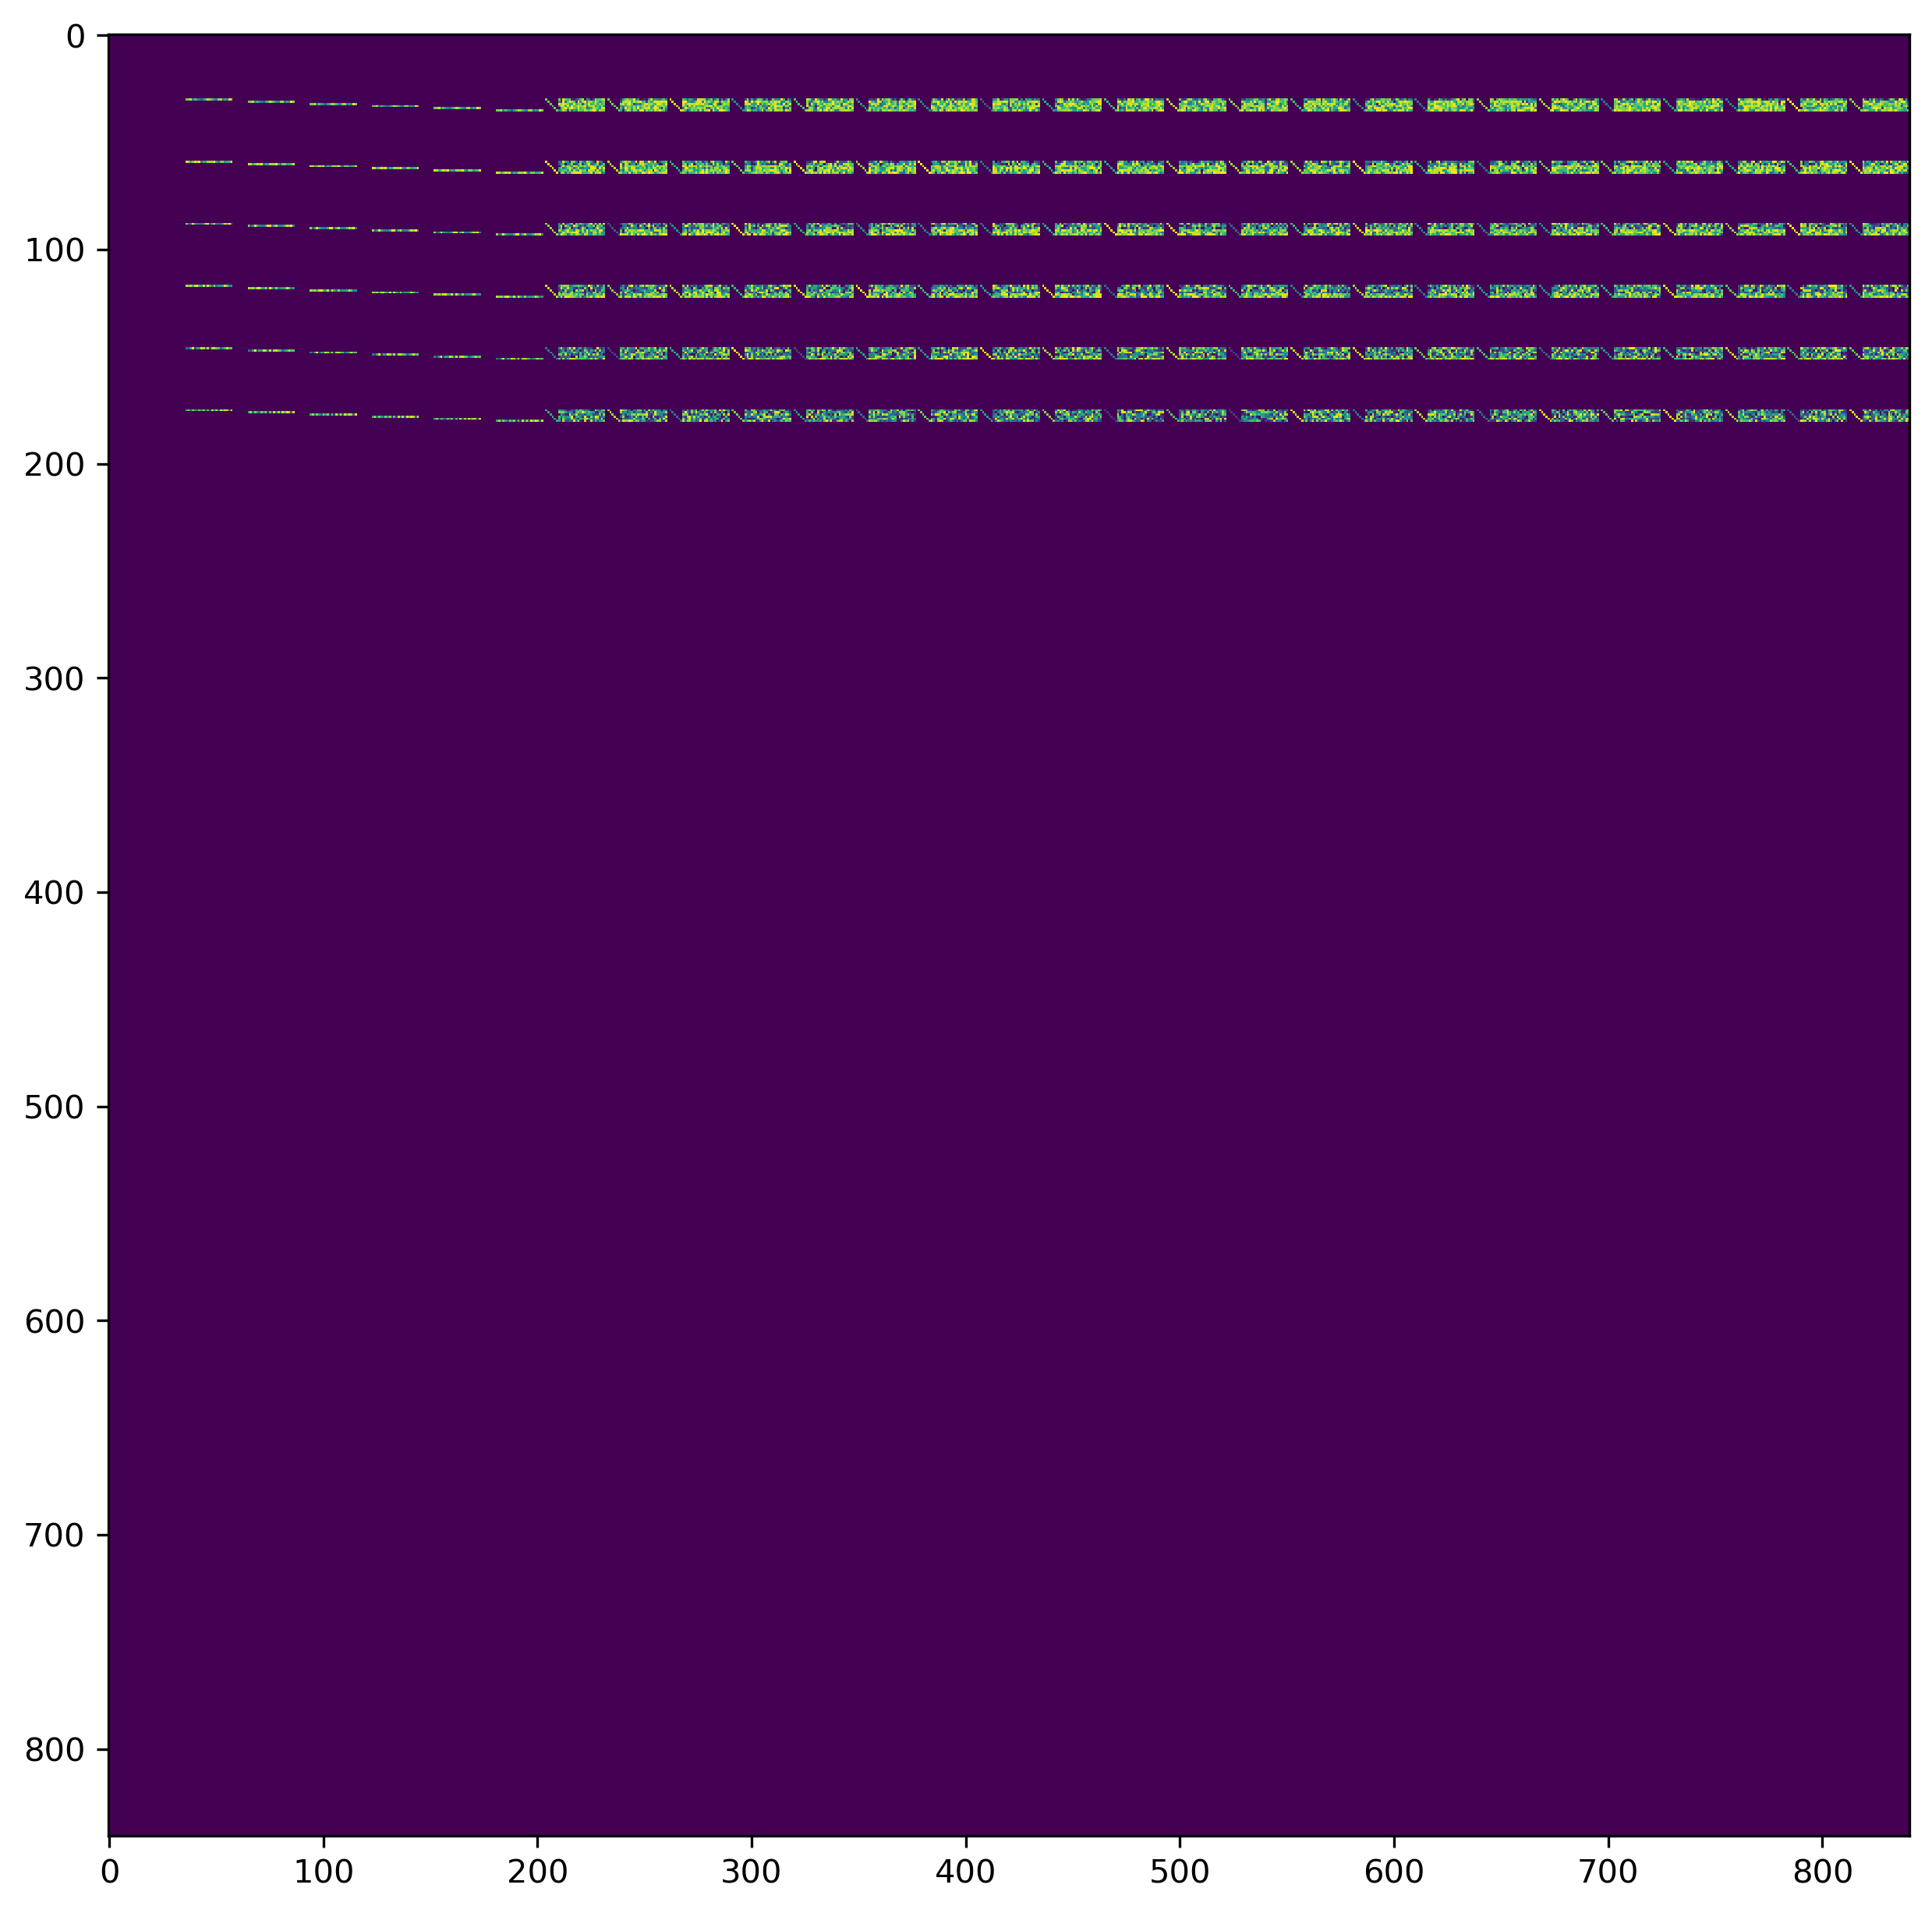

324265.0


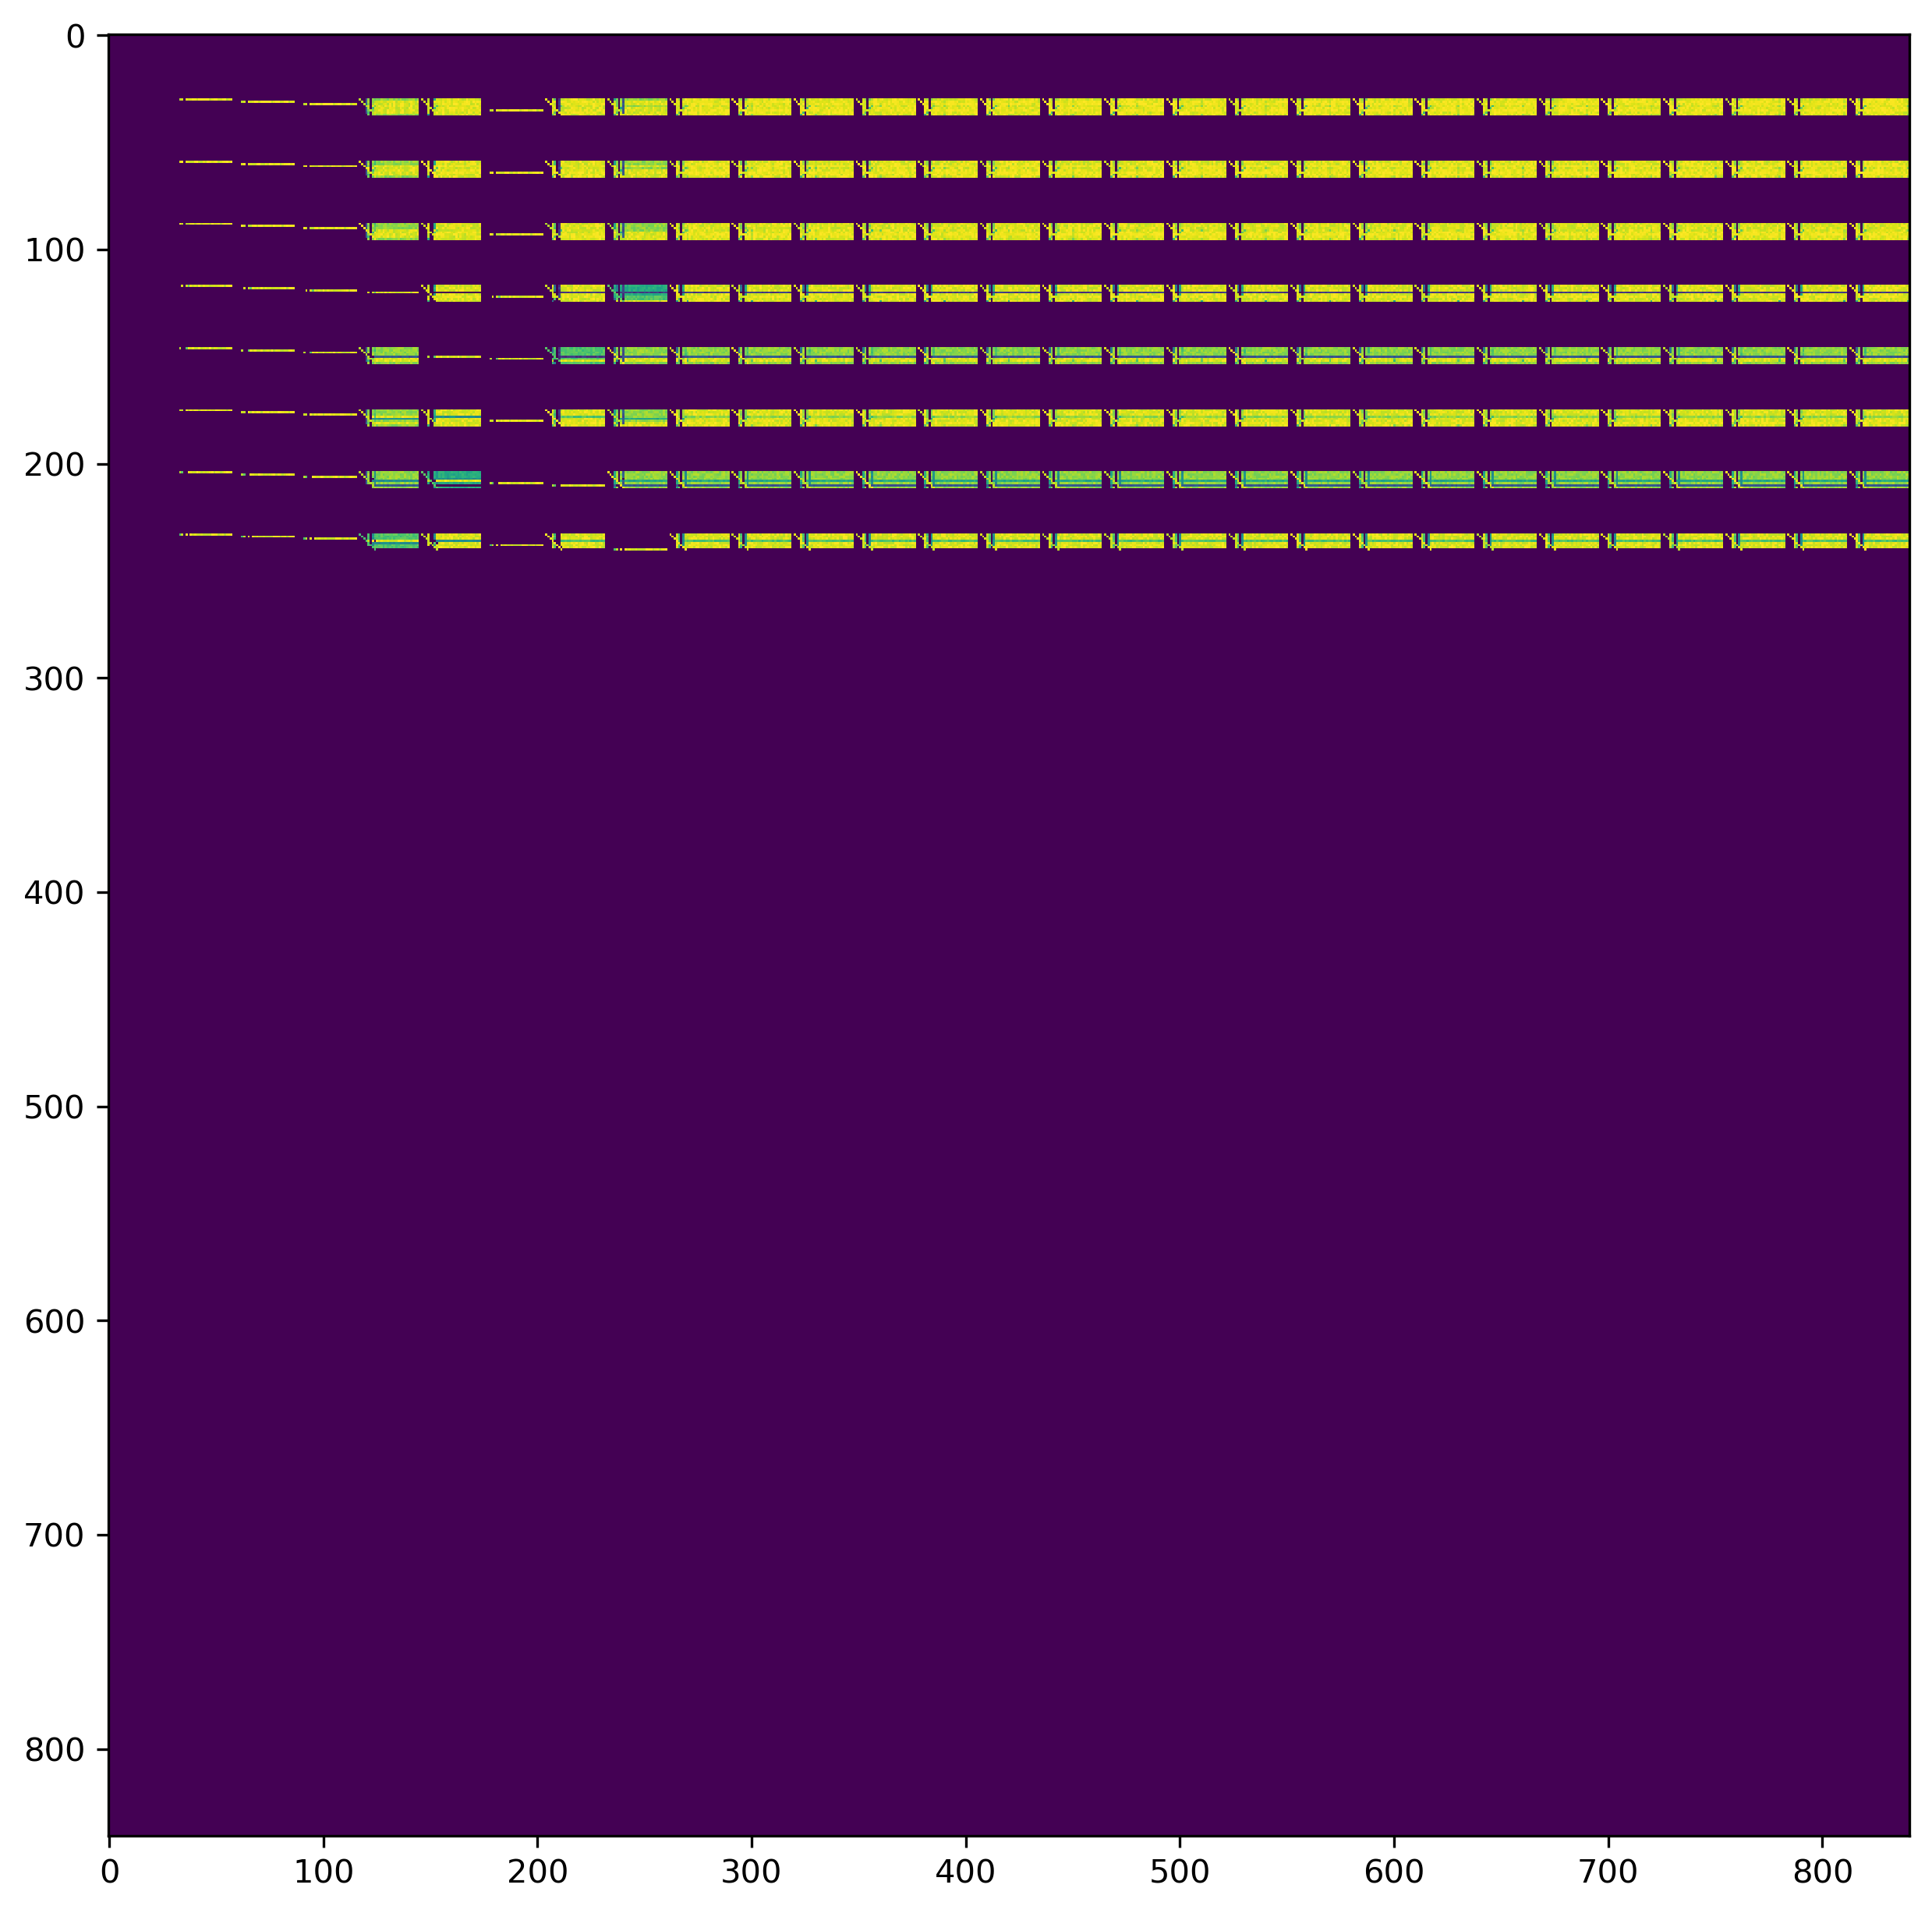

1116751.0


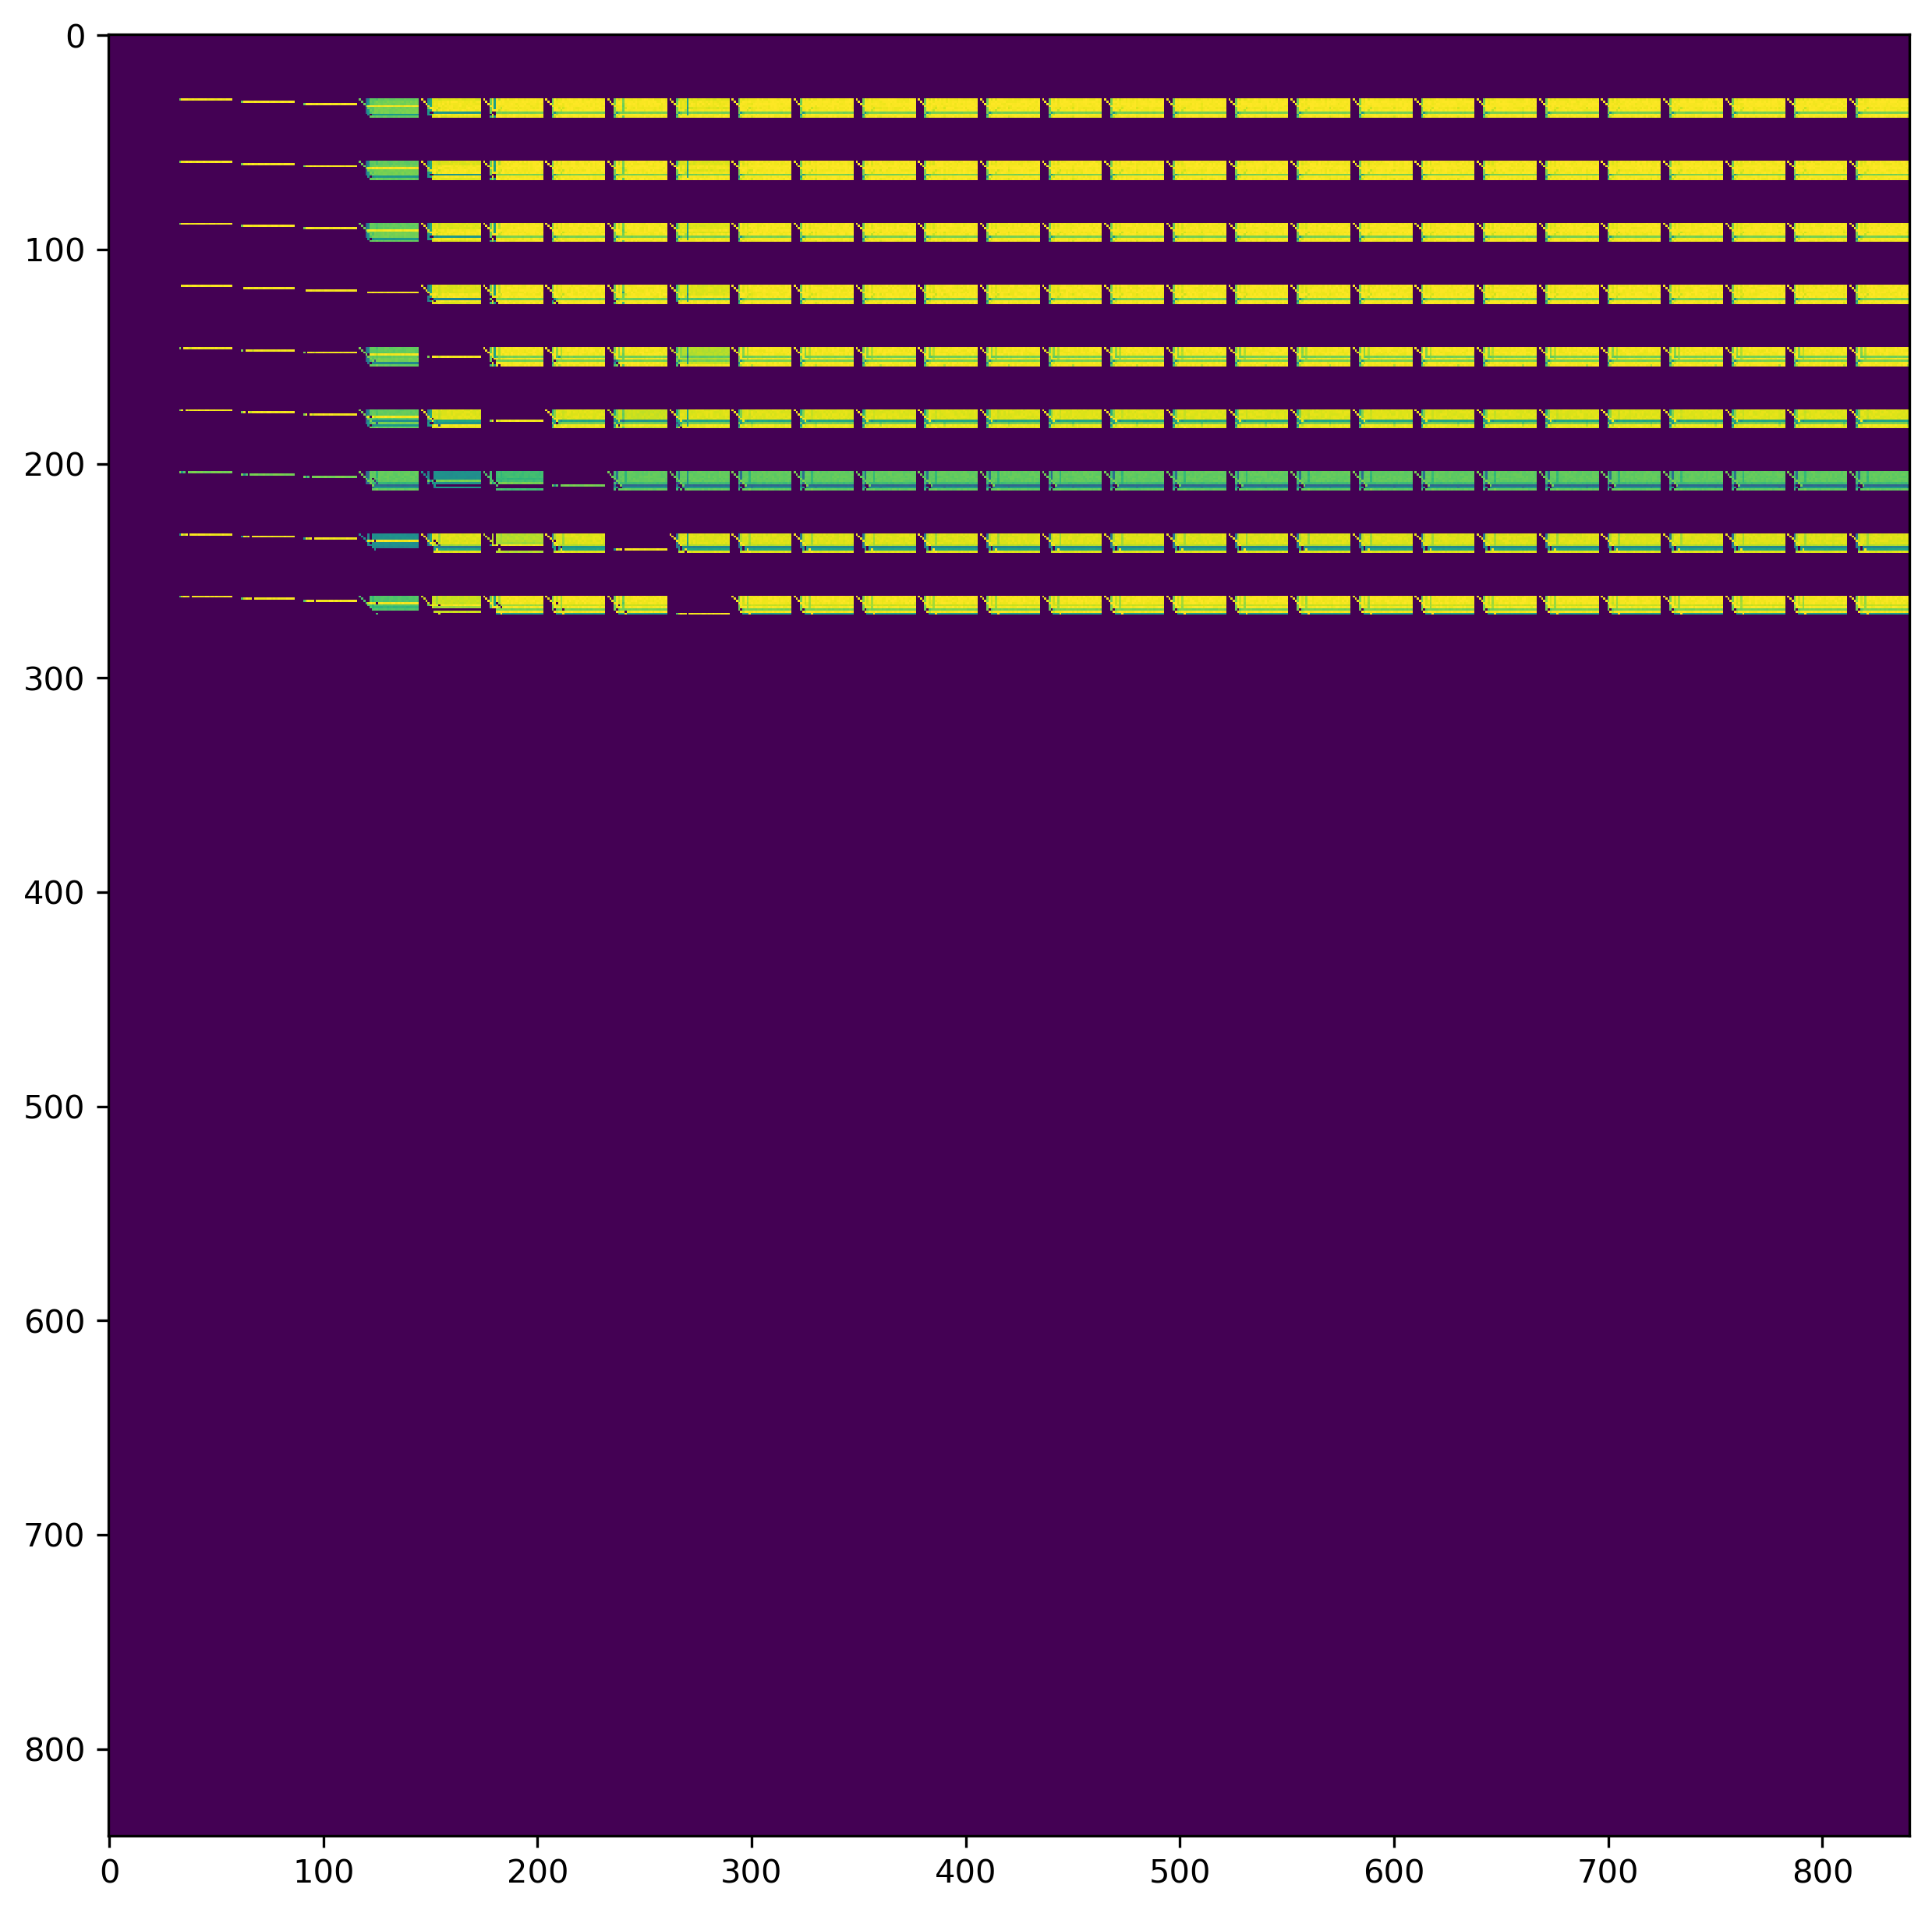

2773355.0


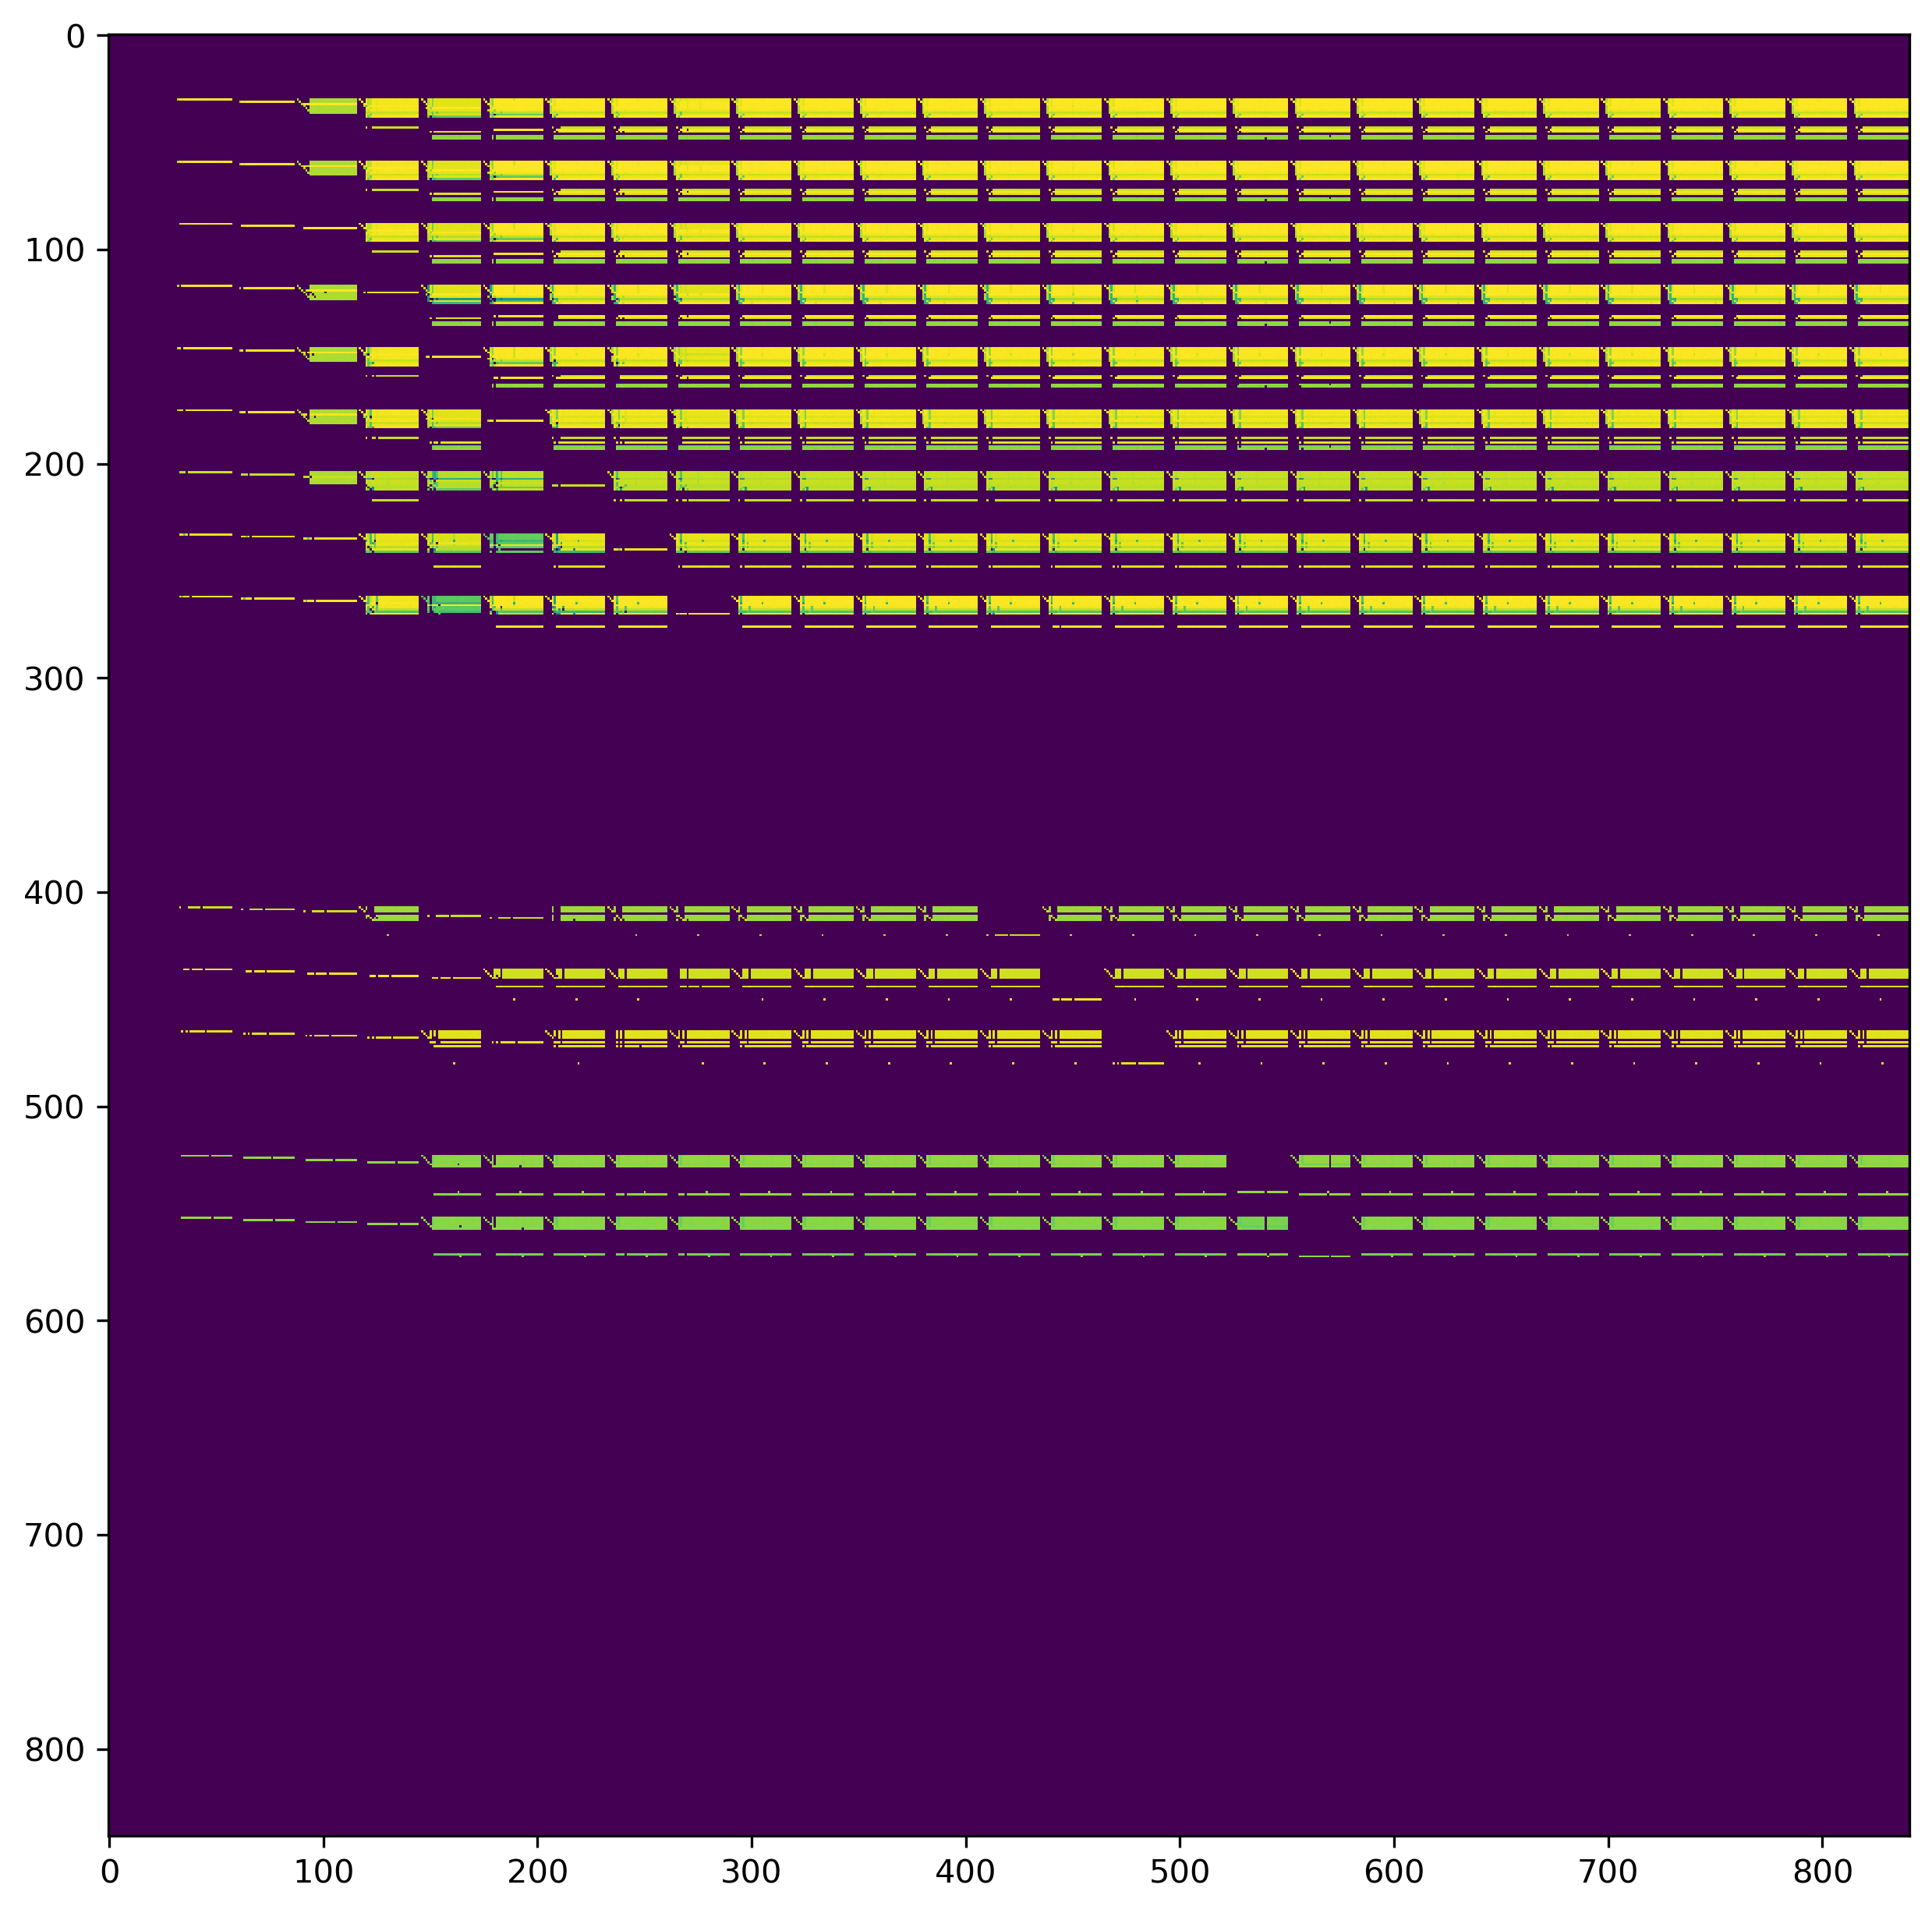

In [22]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 300
for m in sel_mem_maps:
    print(np.max(m))
    plt.imshow(m, cmap='viridis')
    plt.show()

## ReuseTracing across several inner loops

Note that we use checkpoints to avoid executing the PT2, that is too expensive in this case

In [45]:
# keep track of the average reuse distance to an element
import mnemo
class ReuseTimeline:
    def __init__(self, dims, blocking=1):
        self.timeline = np.zeros(tuple(dims), dtype=int)
        self.count = np.zeros(tuple(dims), dtype=int)
        self.reuse = mnemo.ReuseDM(0)
        
    def reset(self):
        self.timeline.fill(0)
        self.count.fill(0)
        self.reuse.reset()

    def hash_record(self,i,j,k,l):
        p = min(i,k)
        r = max(i,k)
        t = p + (r*(r-1)//2)
        q = min(j,l)
        s = max(j,l)
        u = q + (s*(s-1)//2)
        v = min(t,u)
        w = max(t,u)
        return v + (w*(w-1)//2)
    
    def add(self, i, j, k, l):
        h = self.hash_record(i,j,k,l)
        cd = self.reuse.add(h)
        self.timeline[i,j,k,l] += cd
        self.count[i,j,k,l] += 1
        
    def view2d(self):
        x,y,z,t = self.timeline.shape
        div = np.divide(self.timeline,self.count).reshape(x*y, z*t)
        return np.copy(np.nan_to_num(div))

In [46]:
# if you need profiling, this is a single step with Timings for the core code
import cProfile
i = 7
fci_path='c2_eq_hf_dz.fcidump*'
wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
timeline = ReuseTimeline(integral_size(d_two_e_integral))
lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
cProfile.run("main.Powerplant(lewis, psi_det).E(psi_coef)")

         2209022 function calls in 1.109 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(einsum)
    74940    0.055    0.000    0.422    0.000 <ipython-input-3-014436b10f3d>:16(H_two_e)
    74940    0.067    0.000    0.137    0.000 <ipython-input-45-228feba7ae74>:14(hash_record)
    74940    0.129    0.000    0.344    0.000 <ipython-input-45-228feba7ae74>:25(add)
        1    0.000    0.000    1.109    1.109 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 einsumfunc.py:1004(einsum)
        6    0.000    0.000    0.000    0.000 einsumfunc.py:995(_einsum_dispatcher)
     5600    0.001    0.000    0.001    0.000 main.py:307(H_one_e)
    74940    0.024    0.000    0.024    0.000 main.py:313(H_two_e)
    25628    0.089    0.000    0.105    0.000 main.py:321(get_phase_idx_single_exc)
   272692    0.016    0.000    0.016    0.000 main

### Tracing without memory

Trace with a new timeline at every step

In [47]:
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
timeline = ReuseTimeline(integral_size(d_two_e_integral))

re_nomem_maps = []
for i in range(1, 11):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    timeline.reset()
    lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
    main.Powerplant(lewis, psi_det).E(psi_coef)
    re_nomem_maps.append(lewis.timeline.view2d())

/nix/store/7nfdbbw2nnr16h26wzmibrppcqdyxrv9-python3.7-ipykernel-5.1.4/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


19.333333333333332


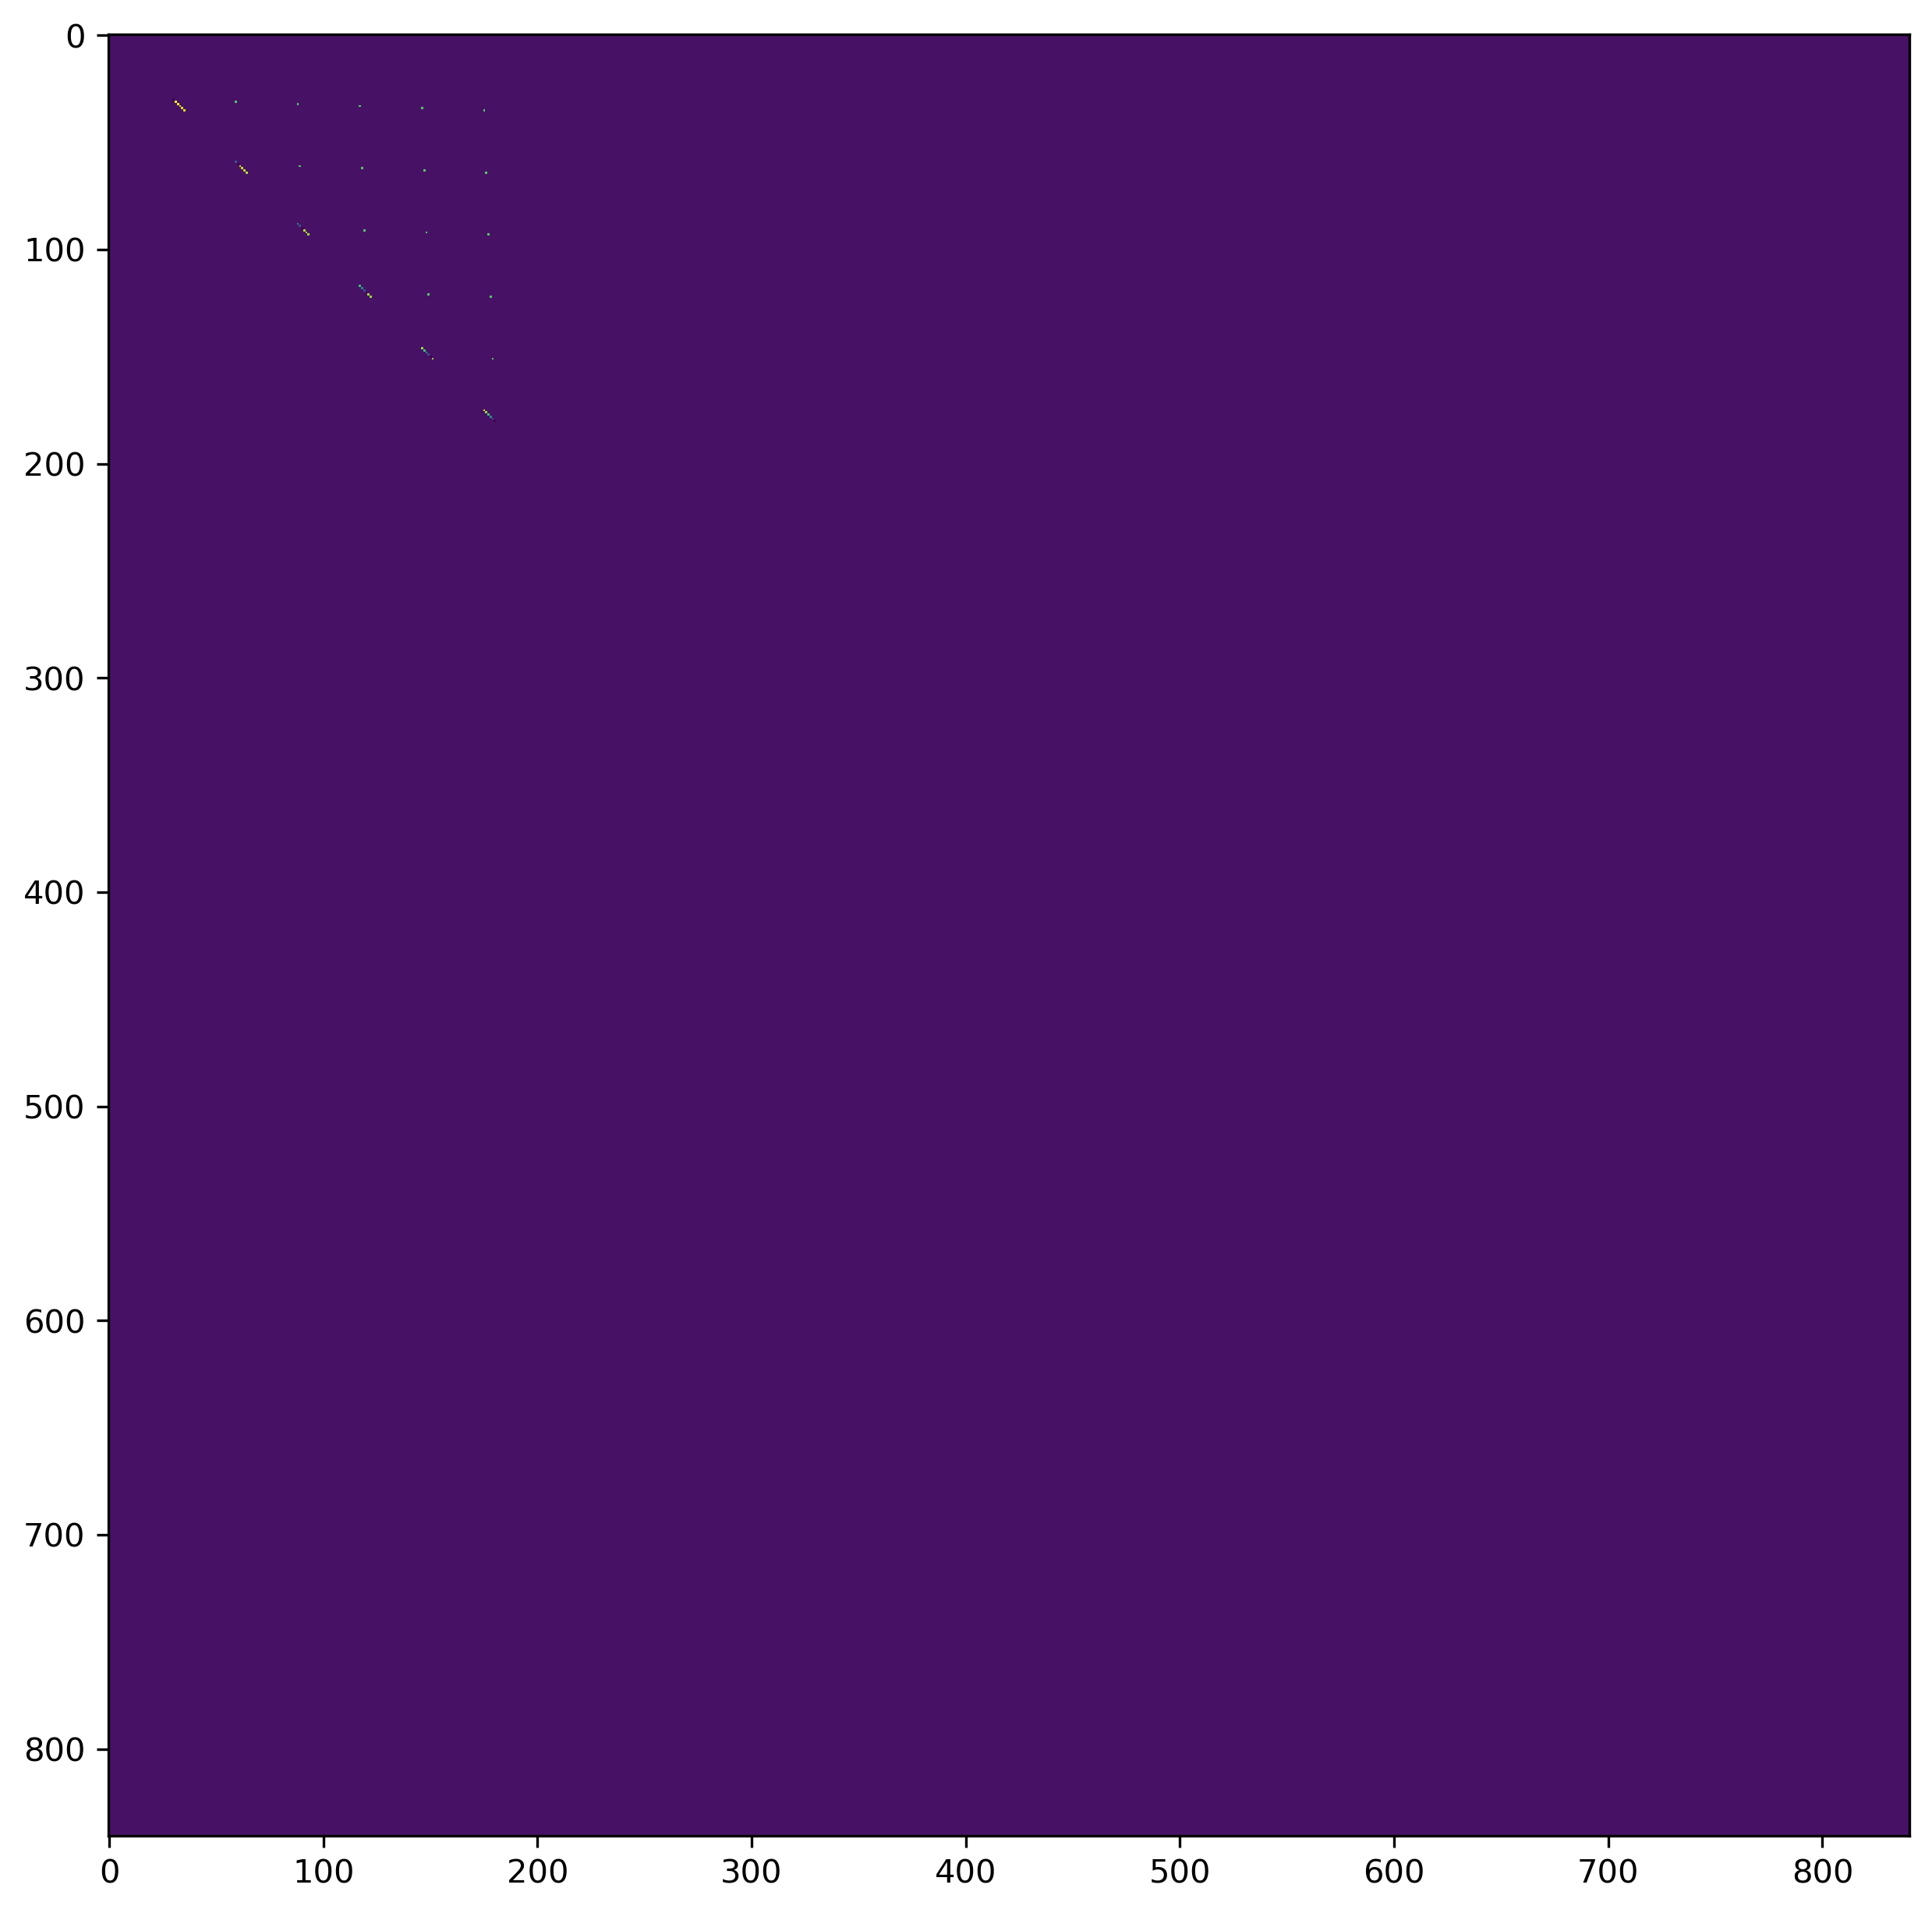

61.333333333333336


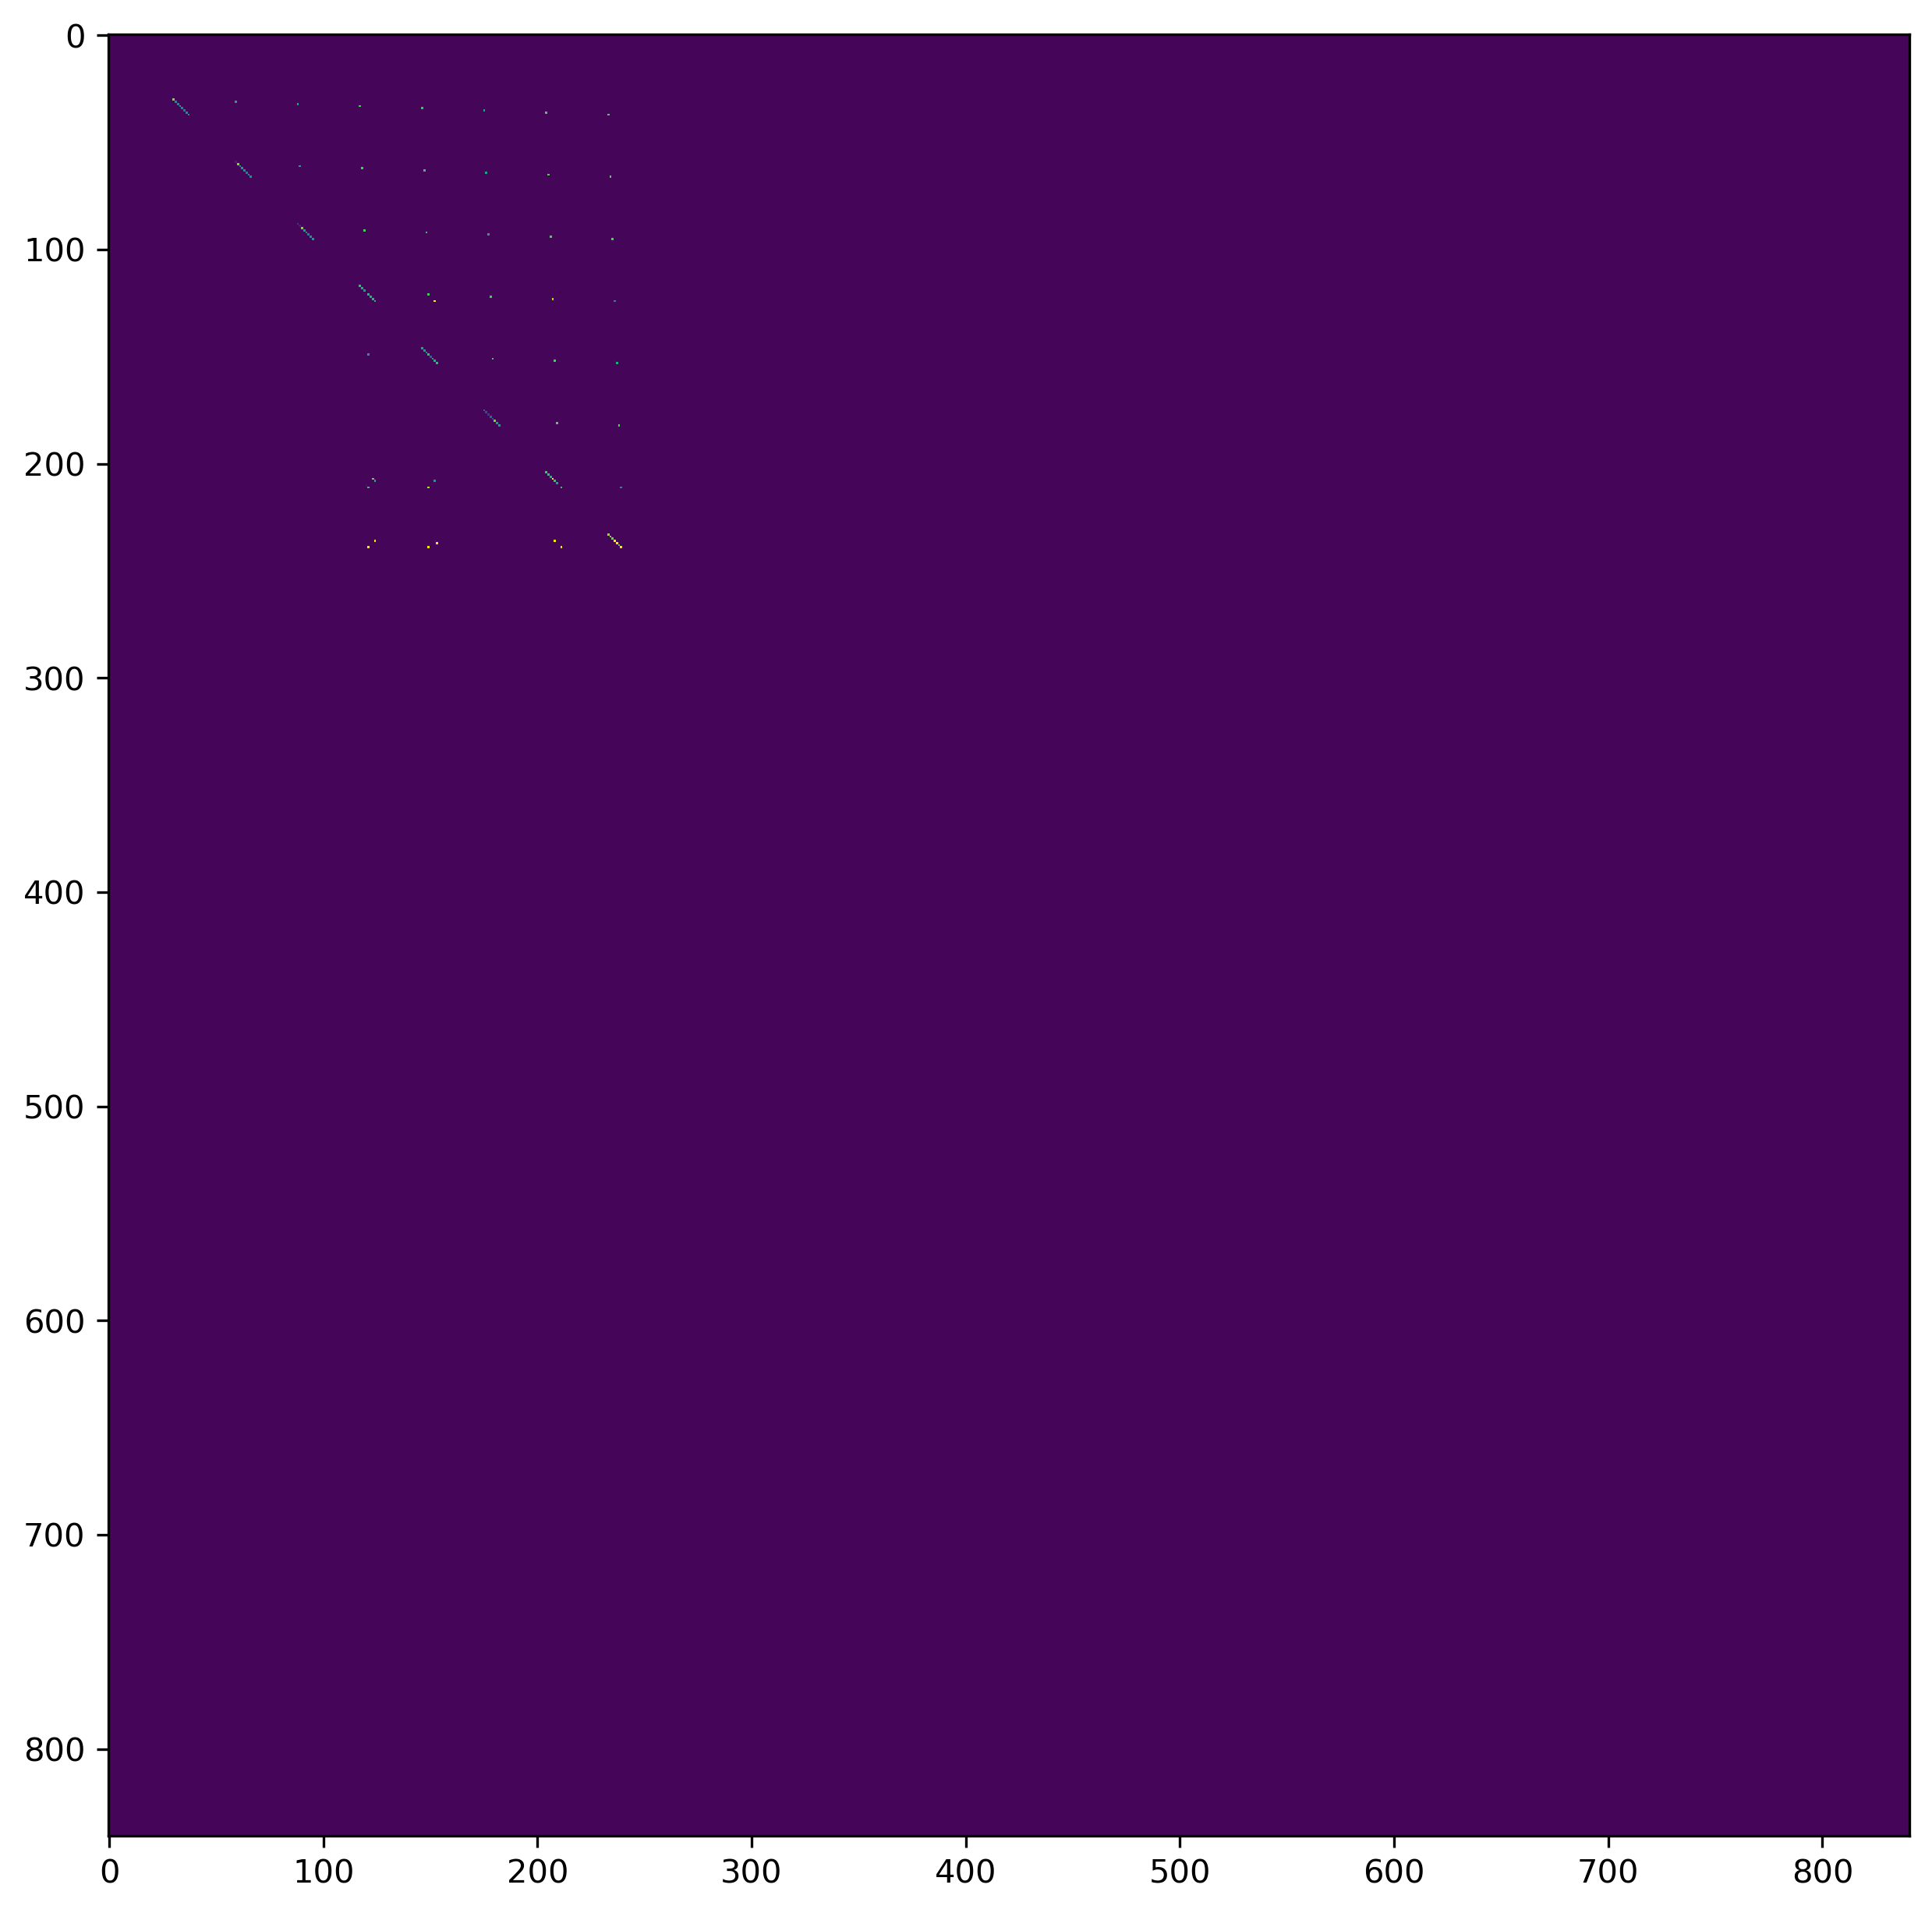

77.0


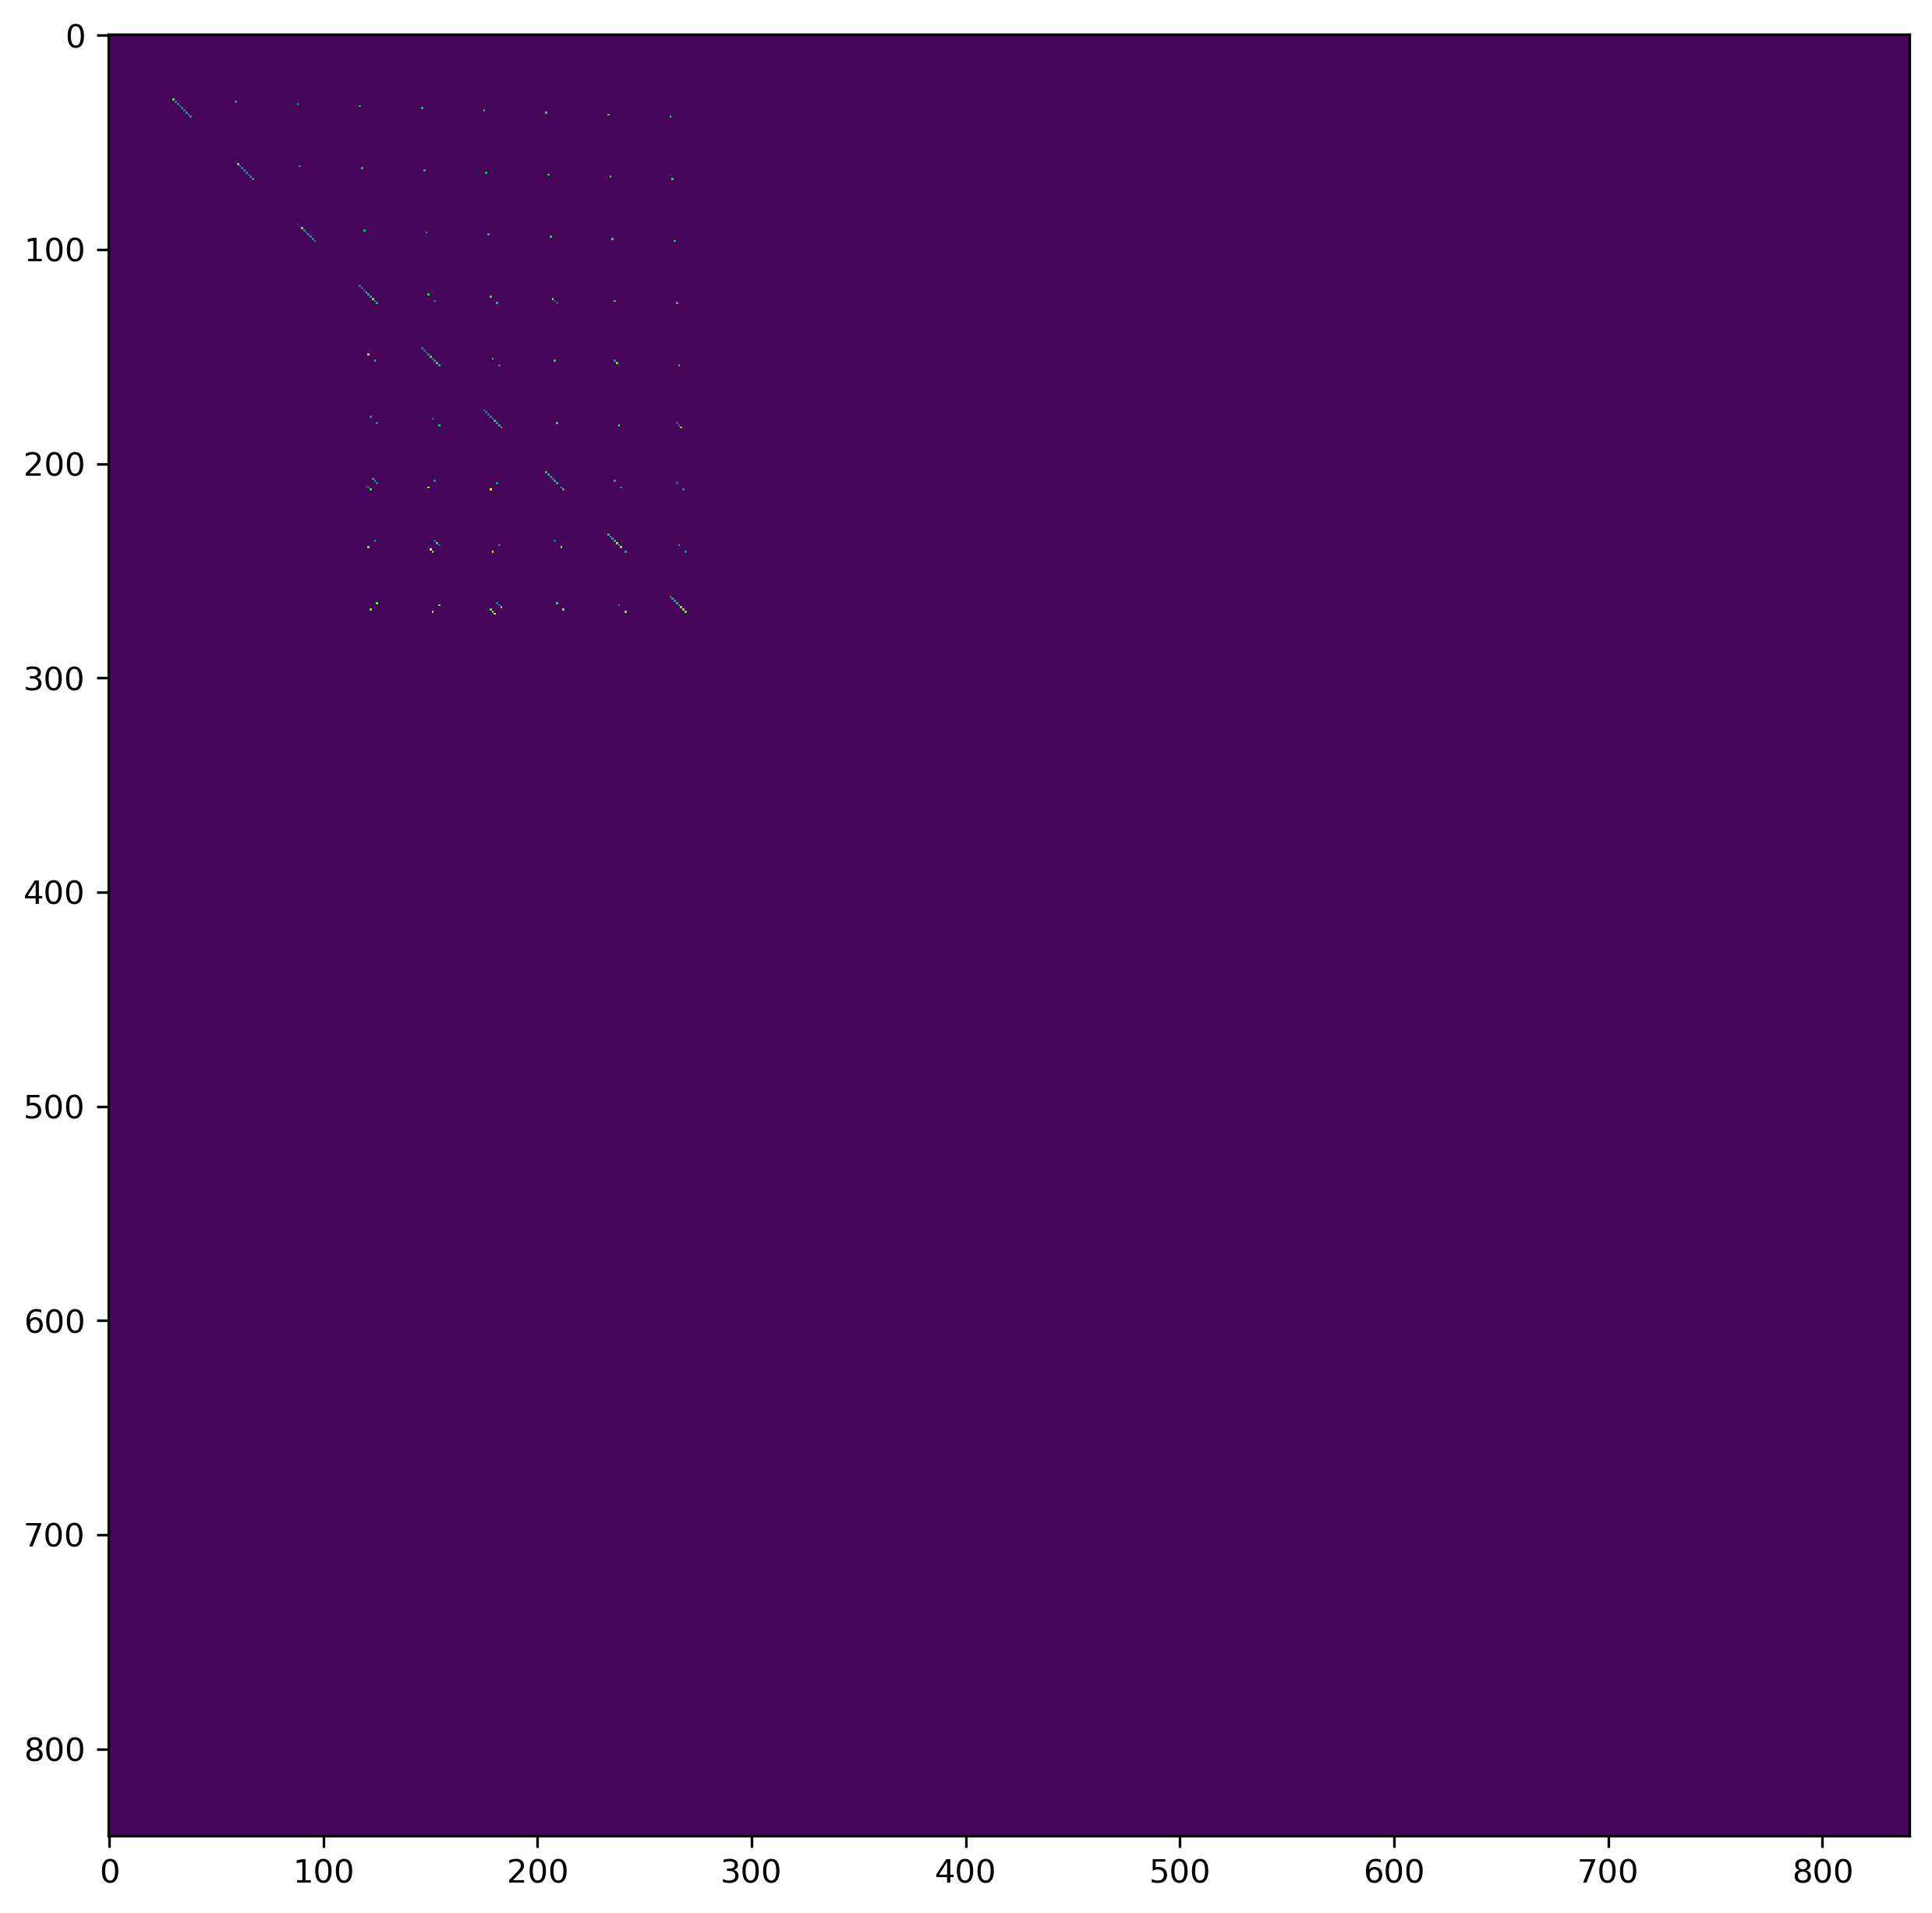

223.0


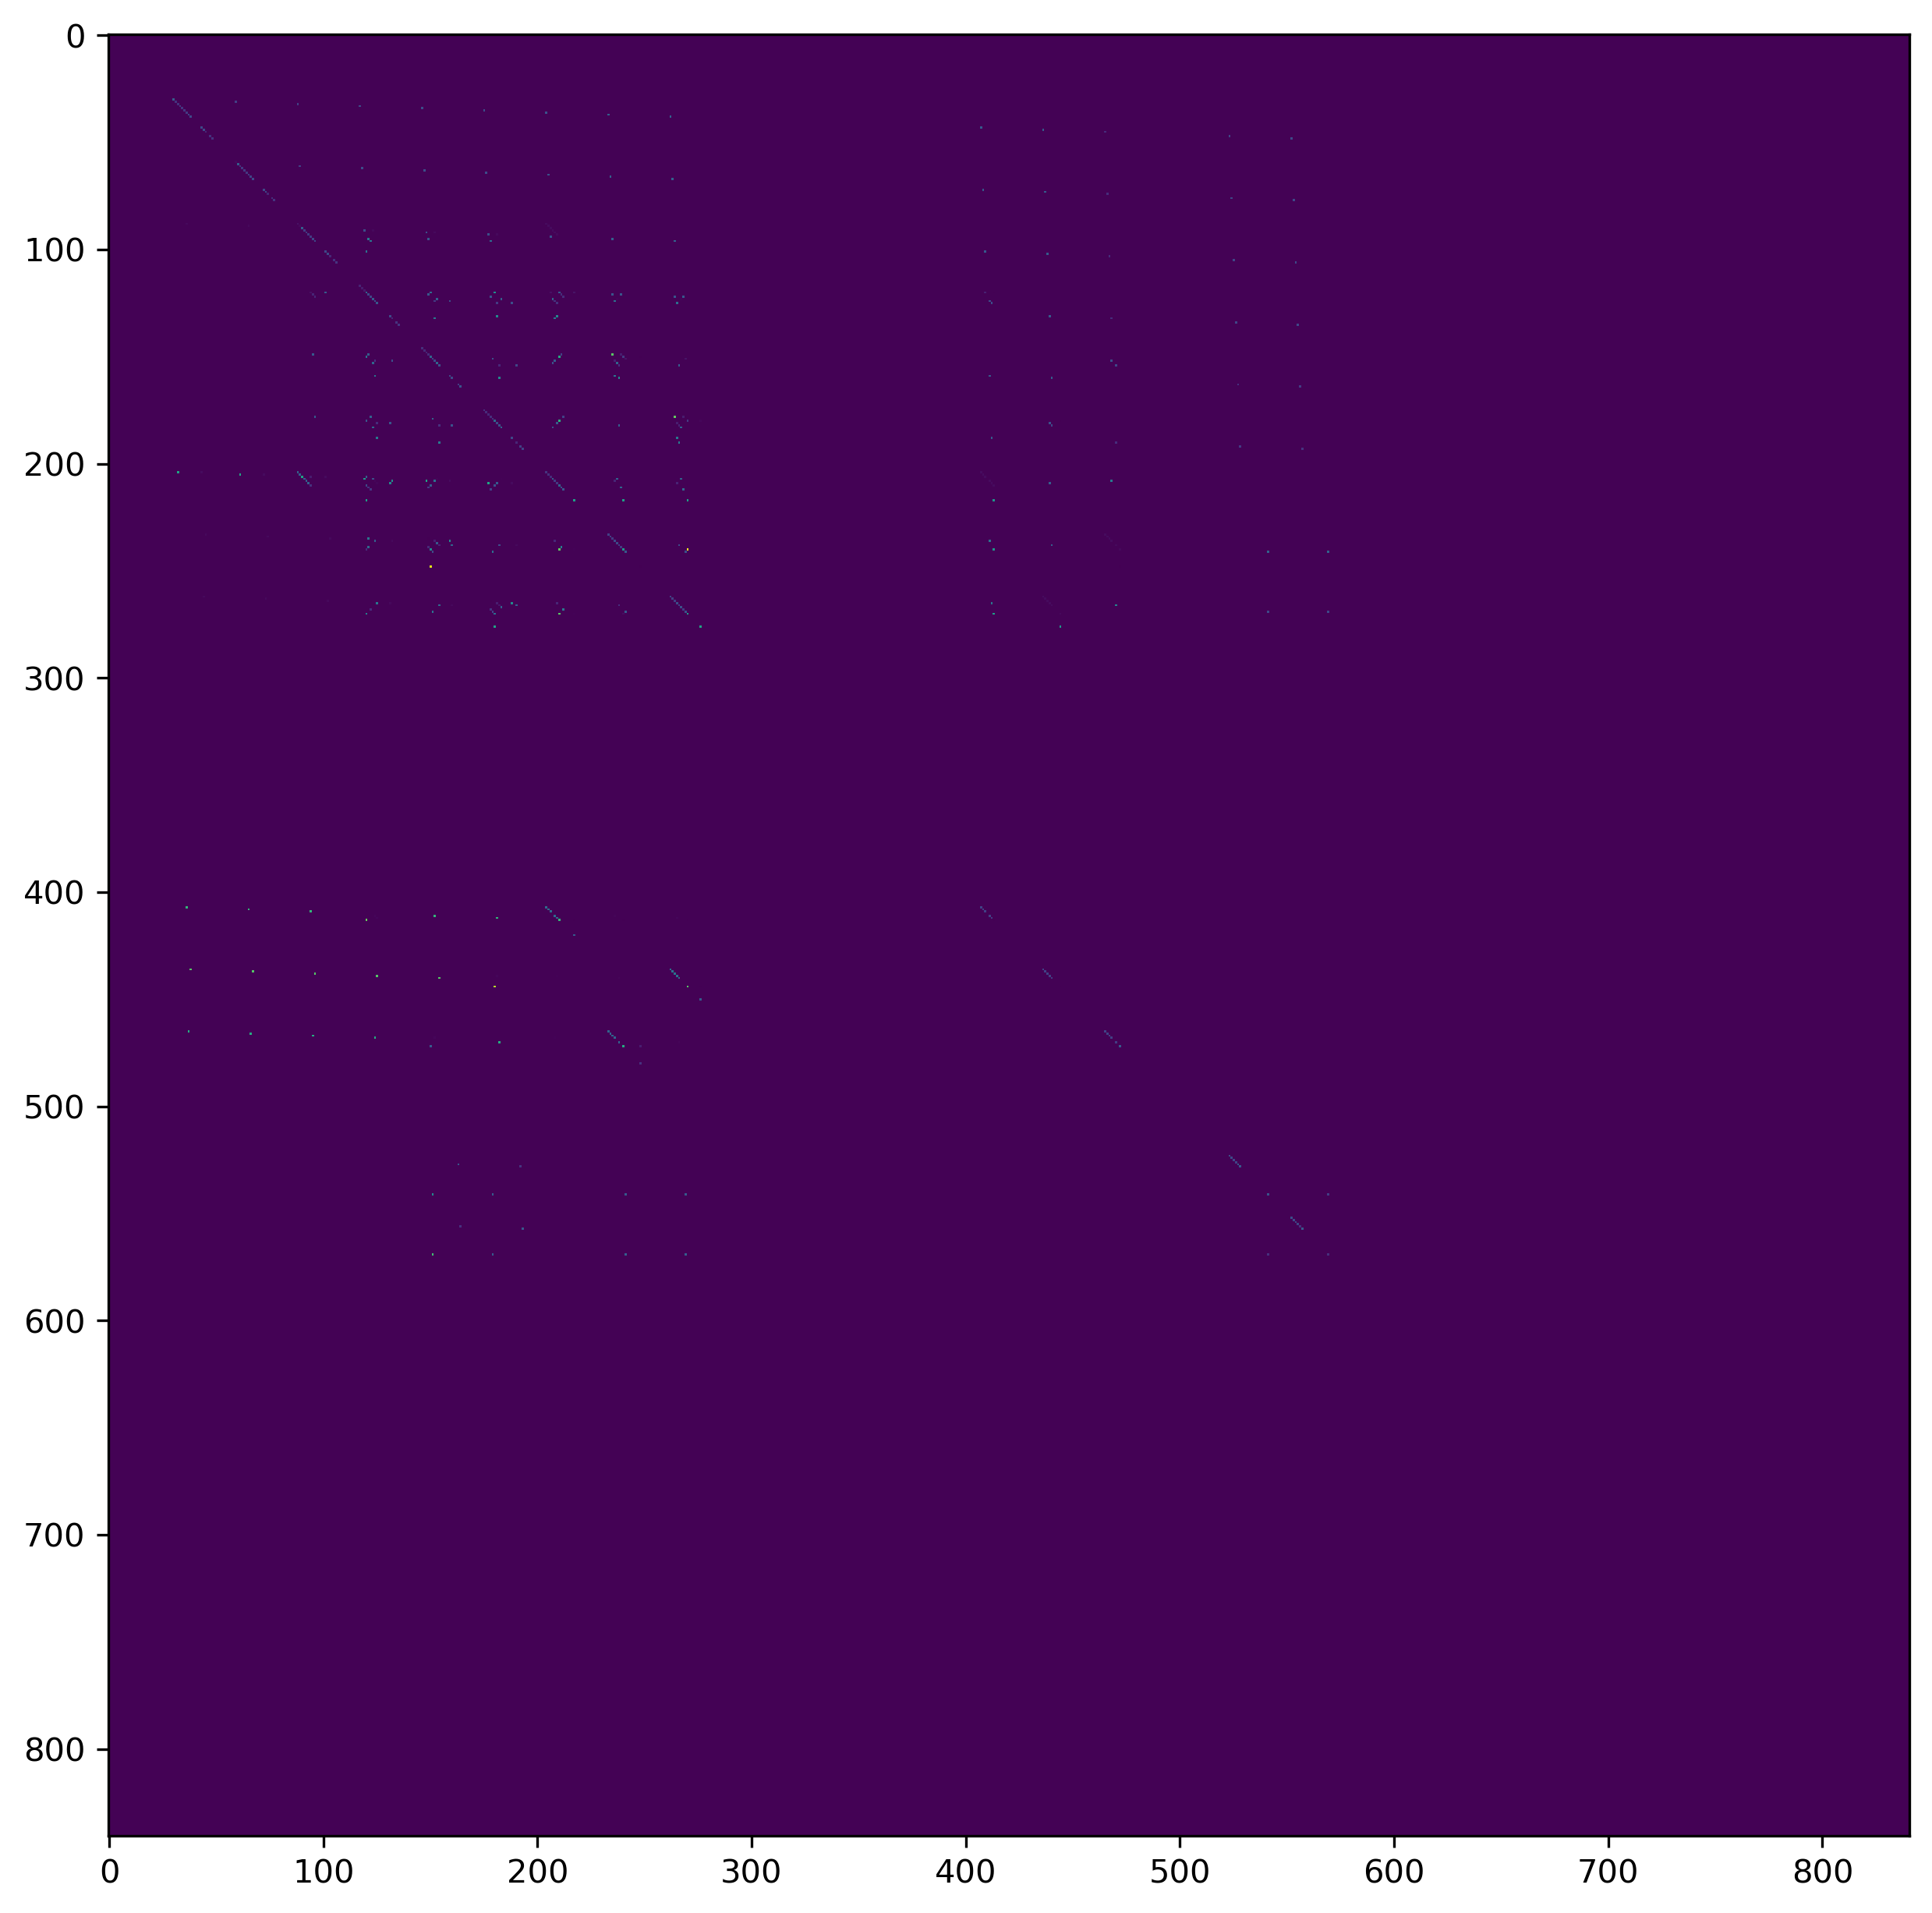

452.0


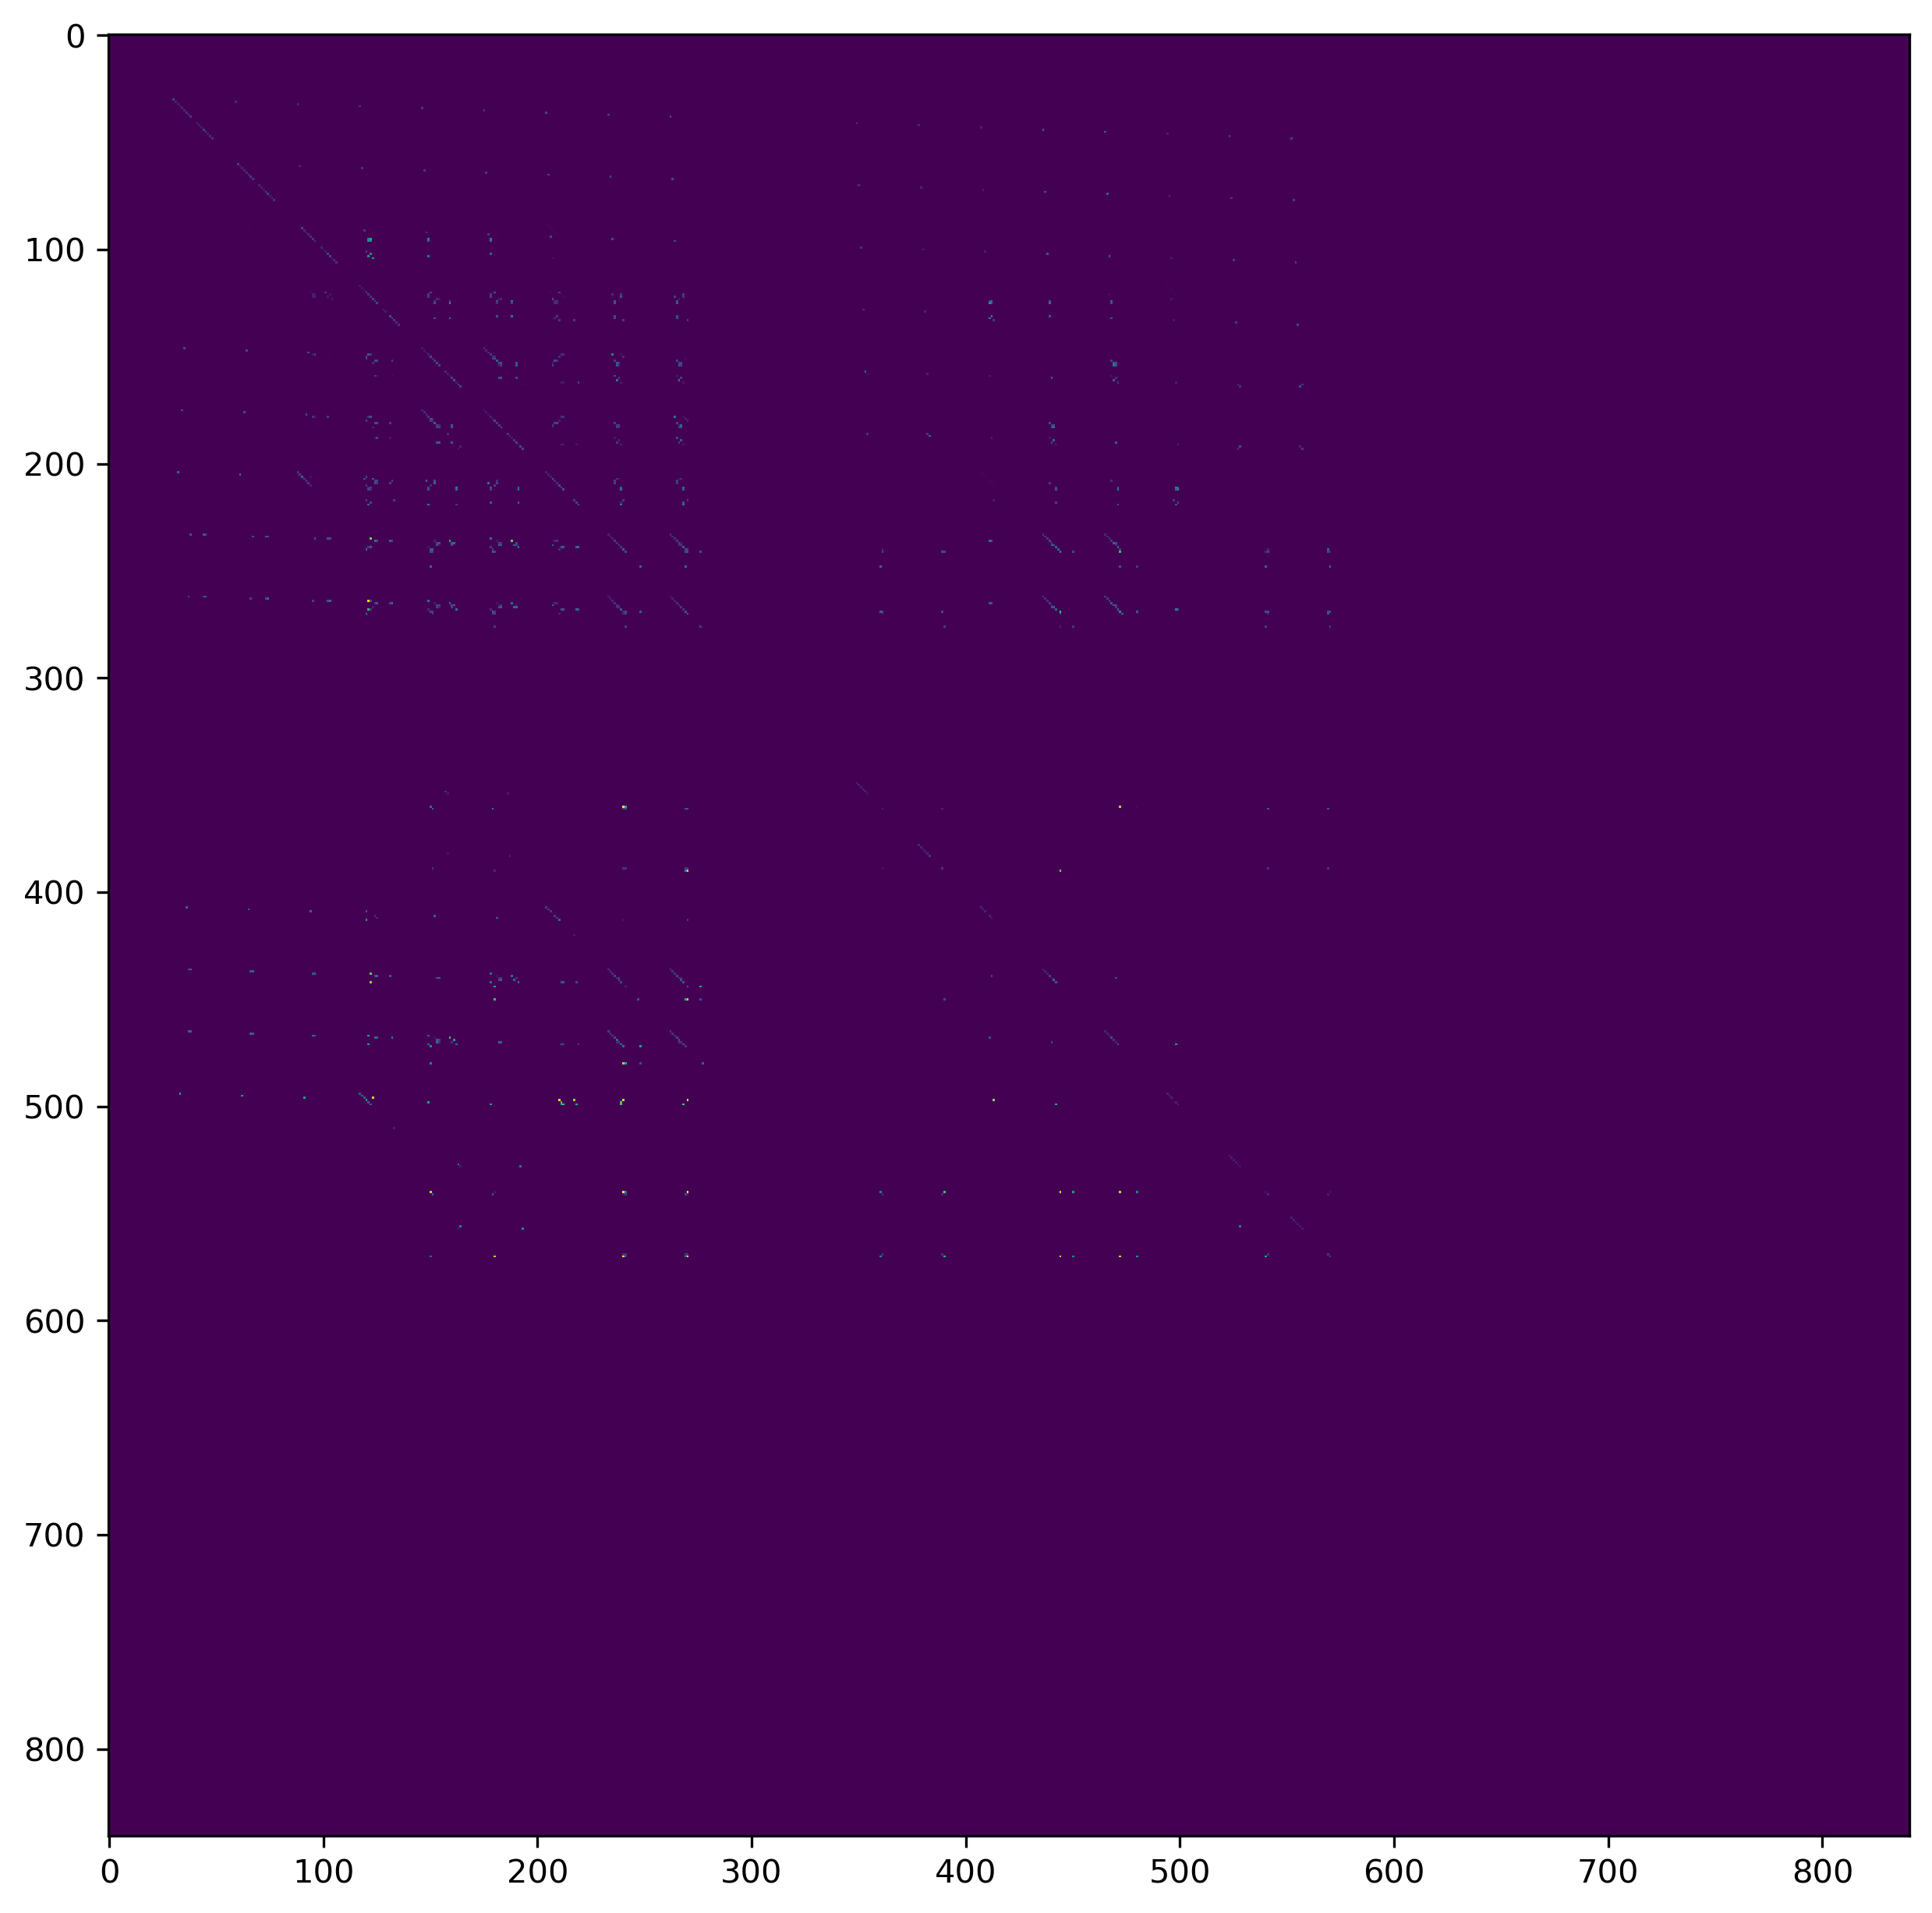

936.0


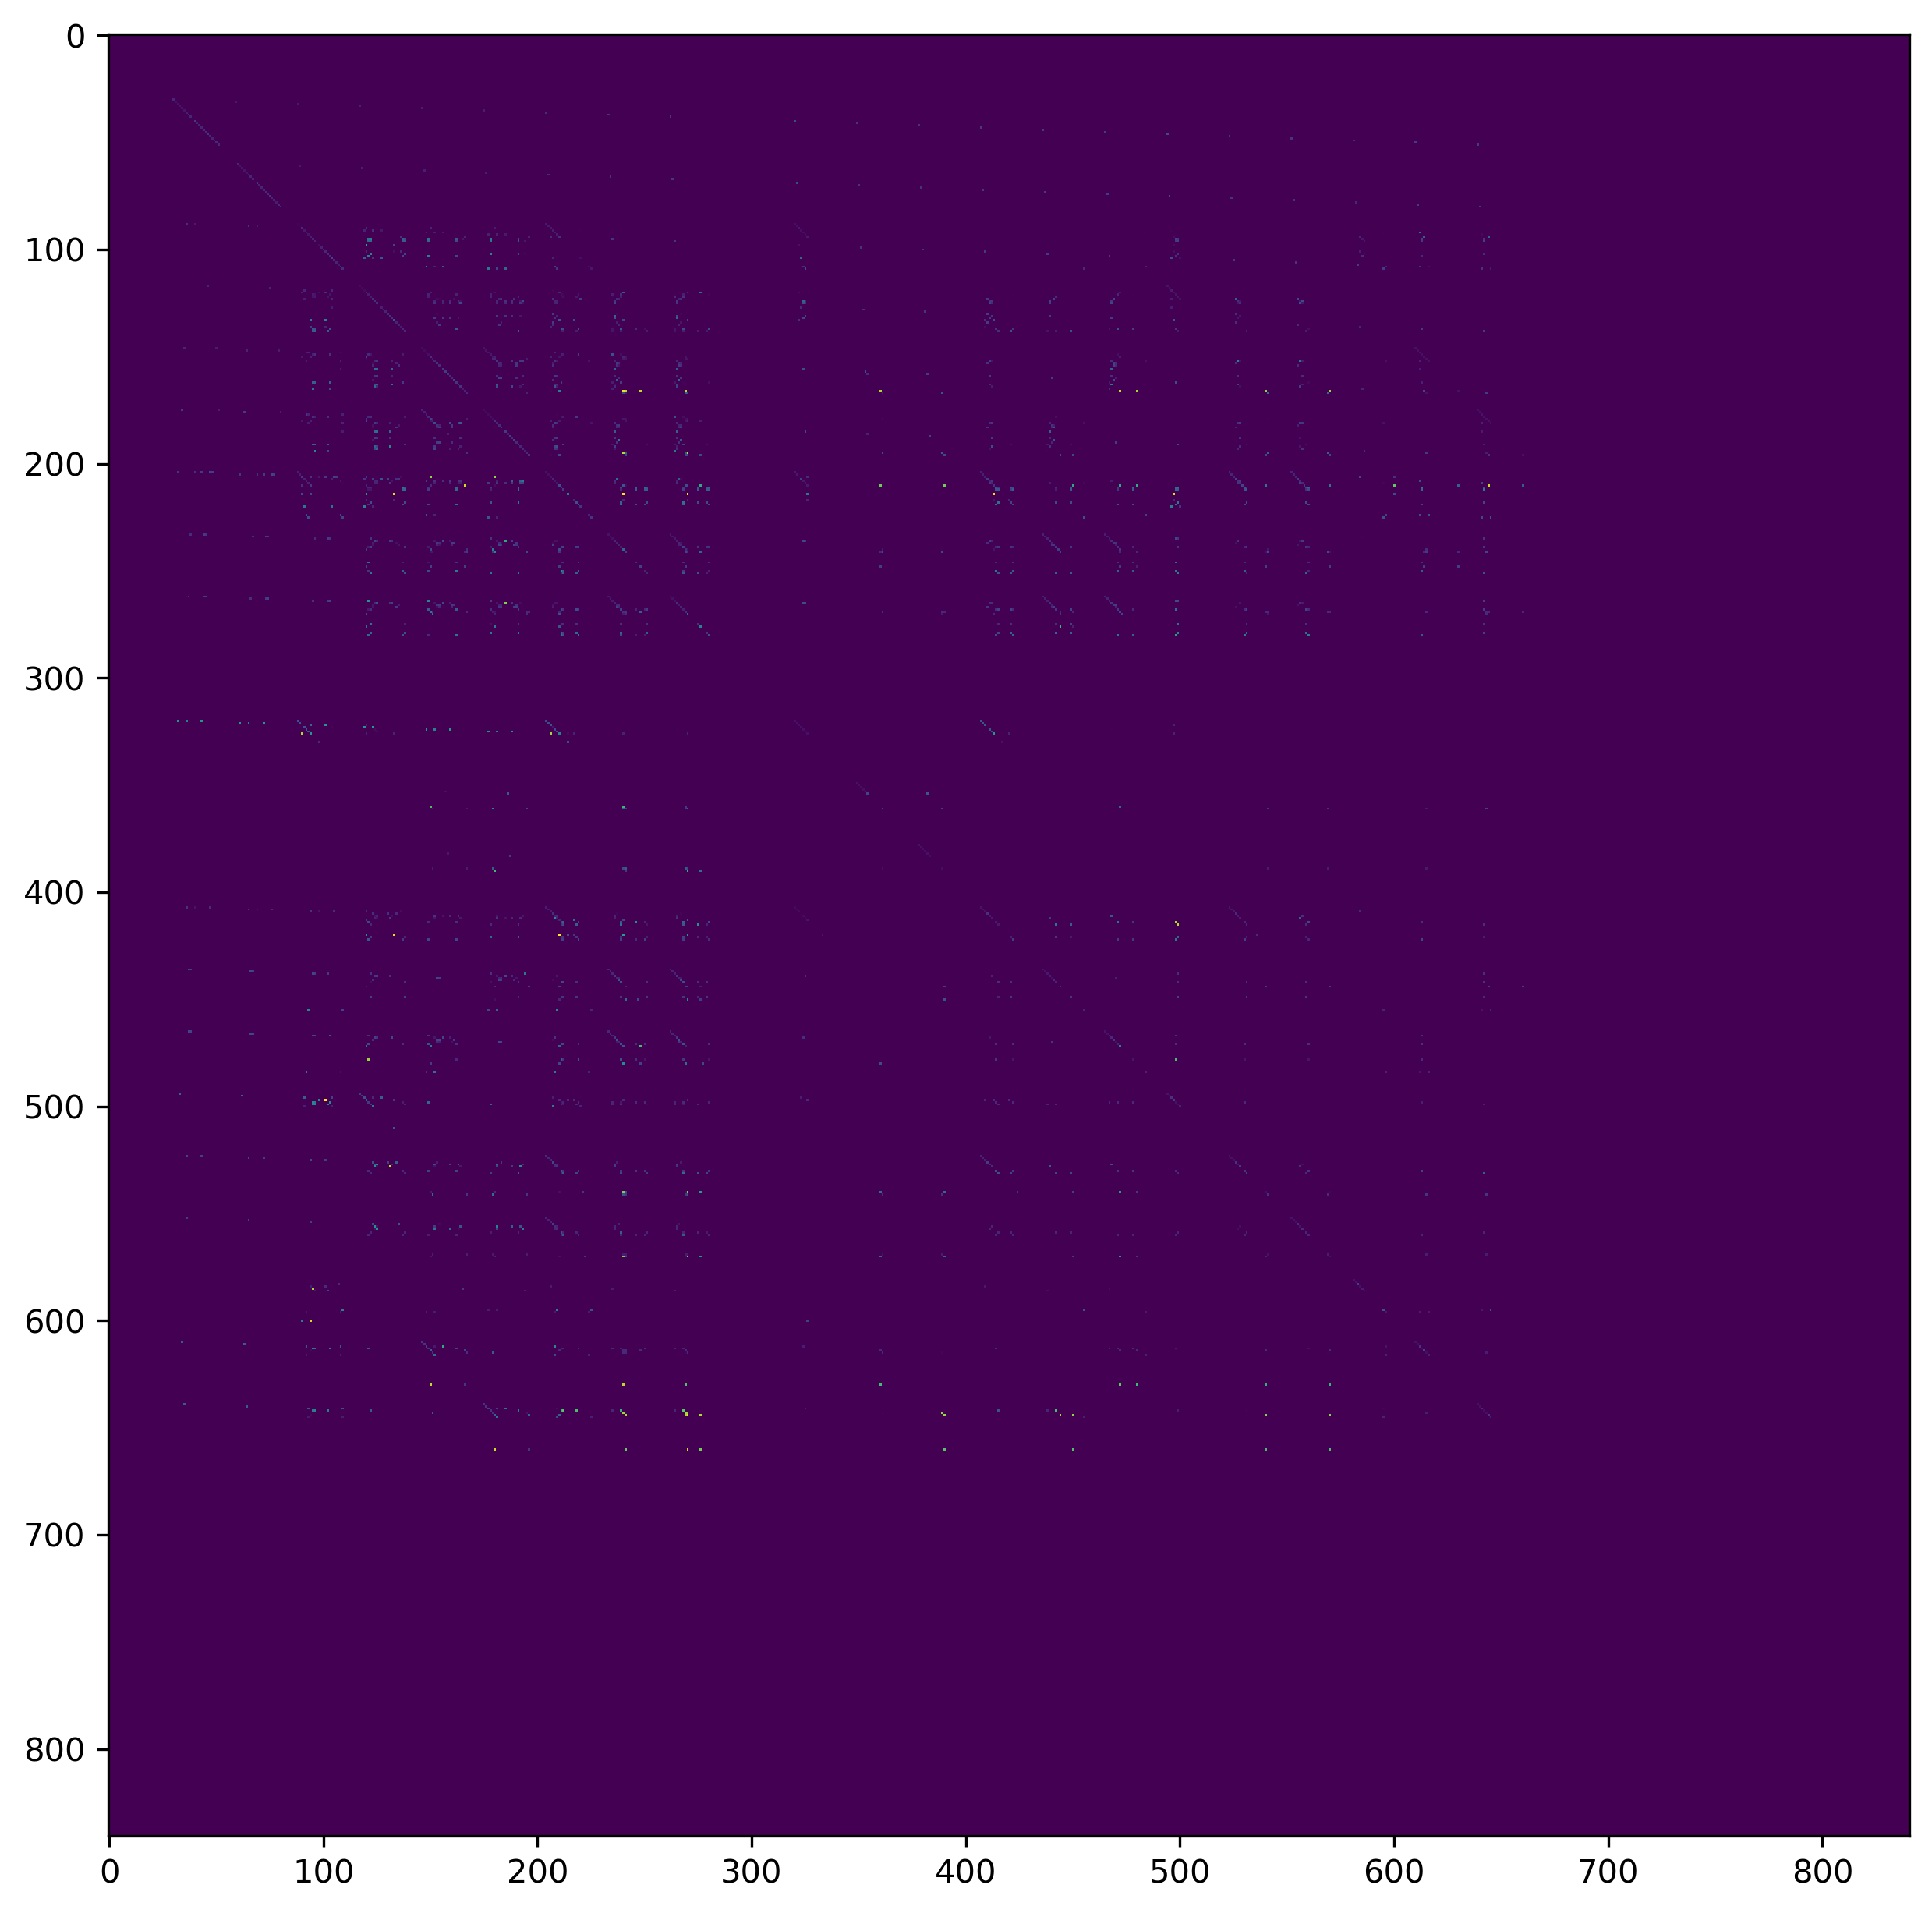

1868.0


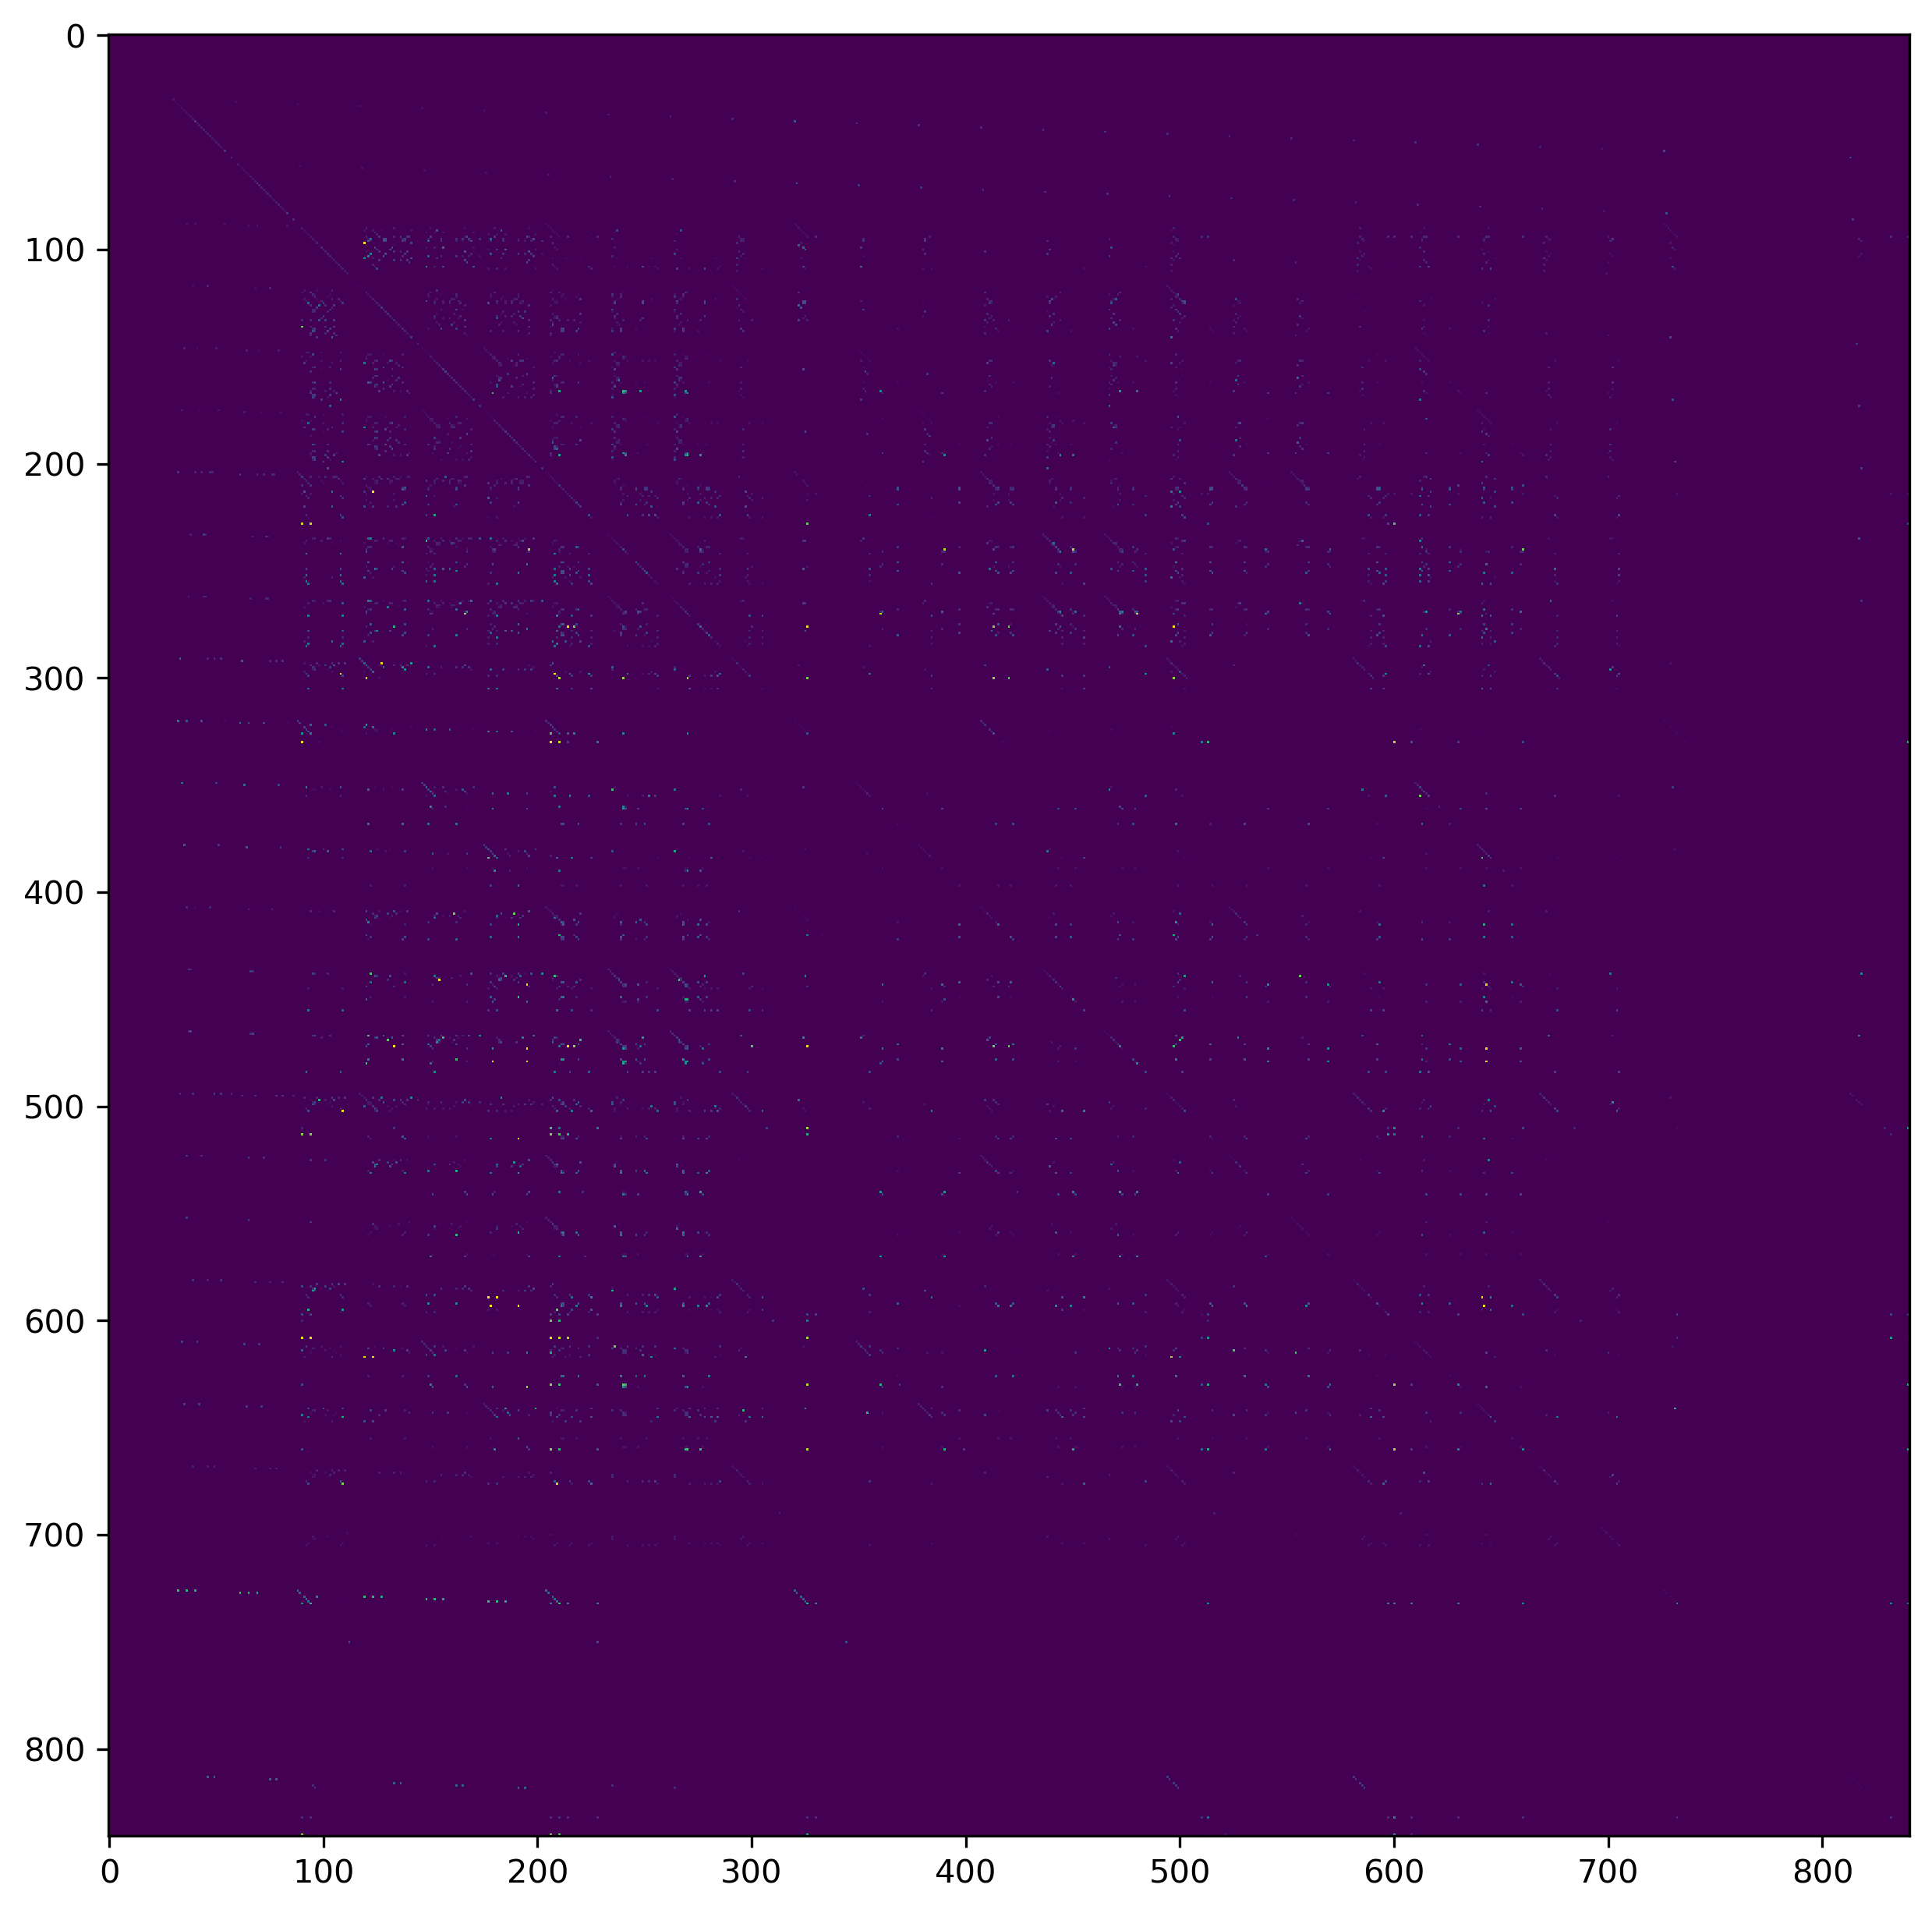

4215.0


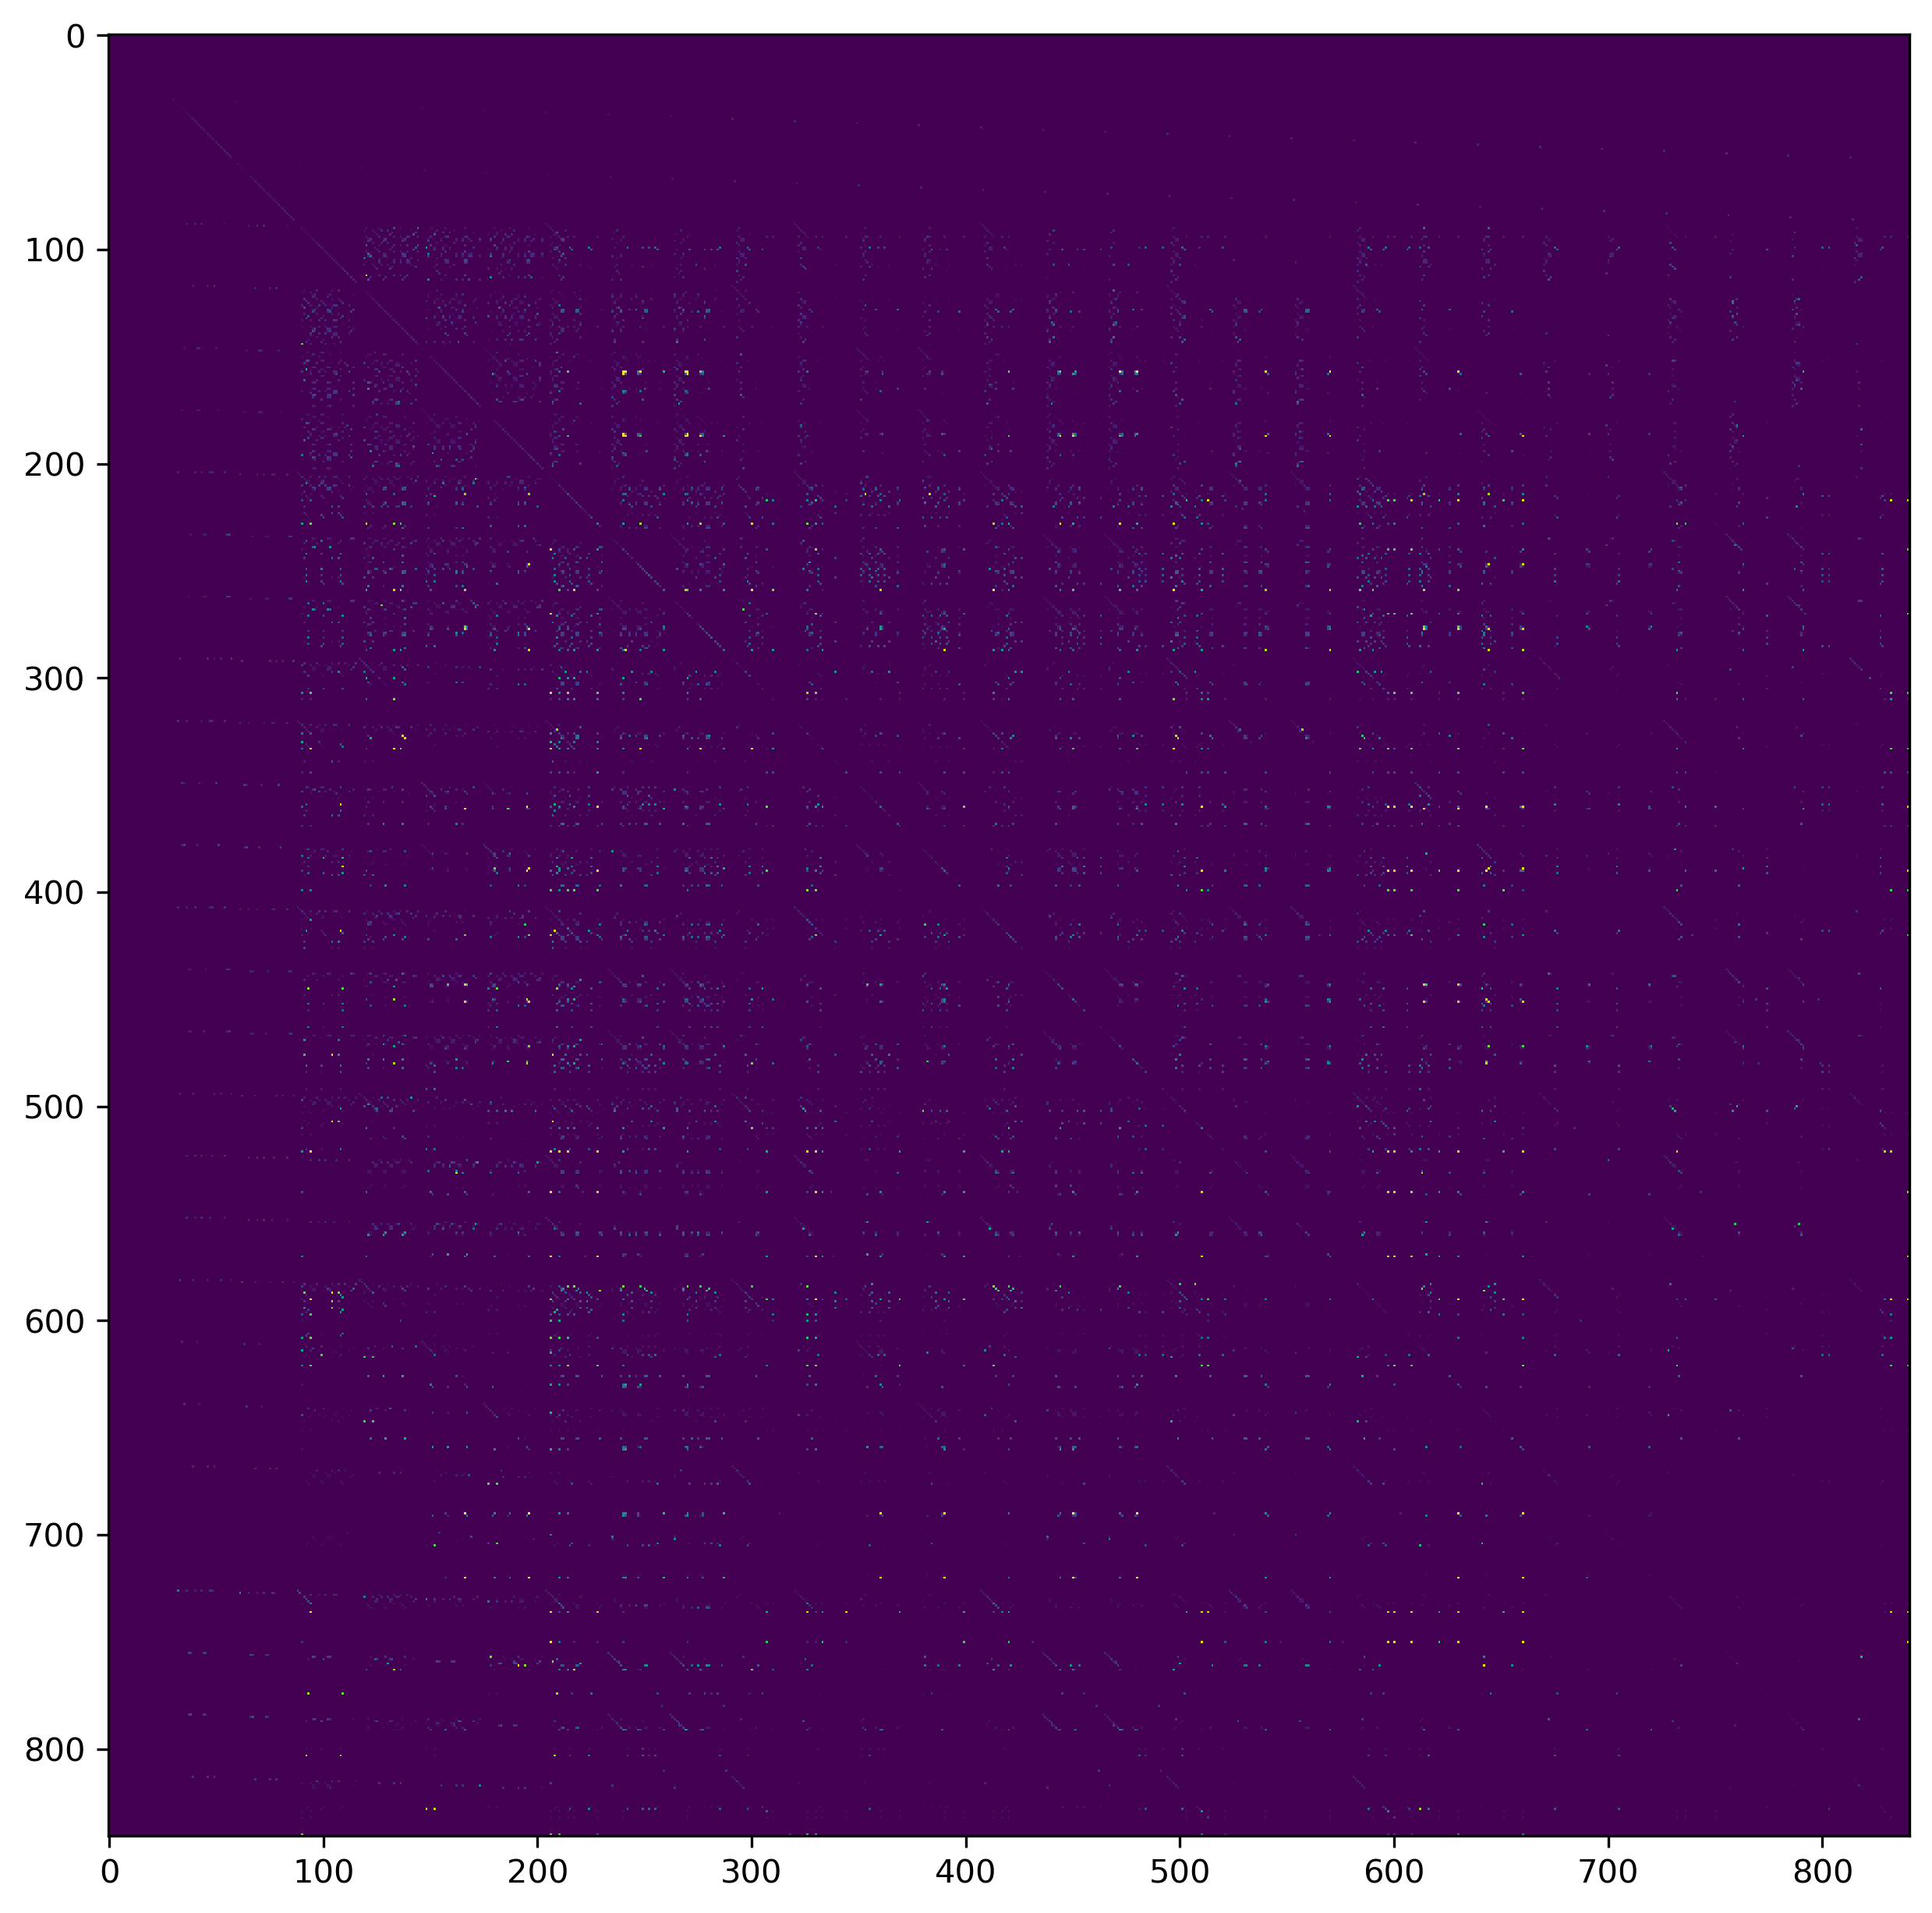

7813.0


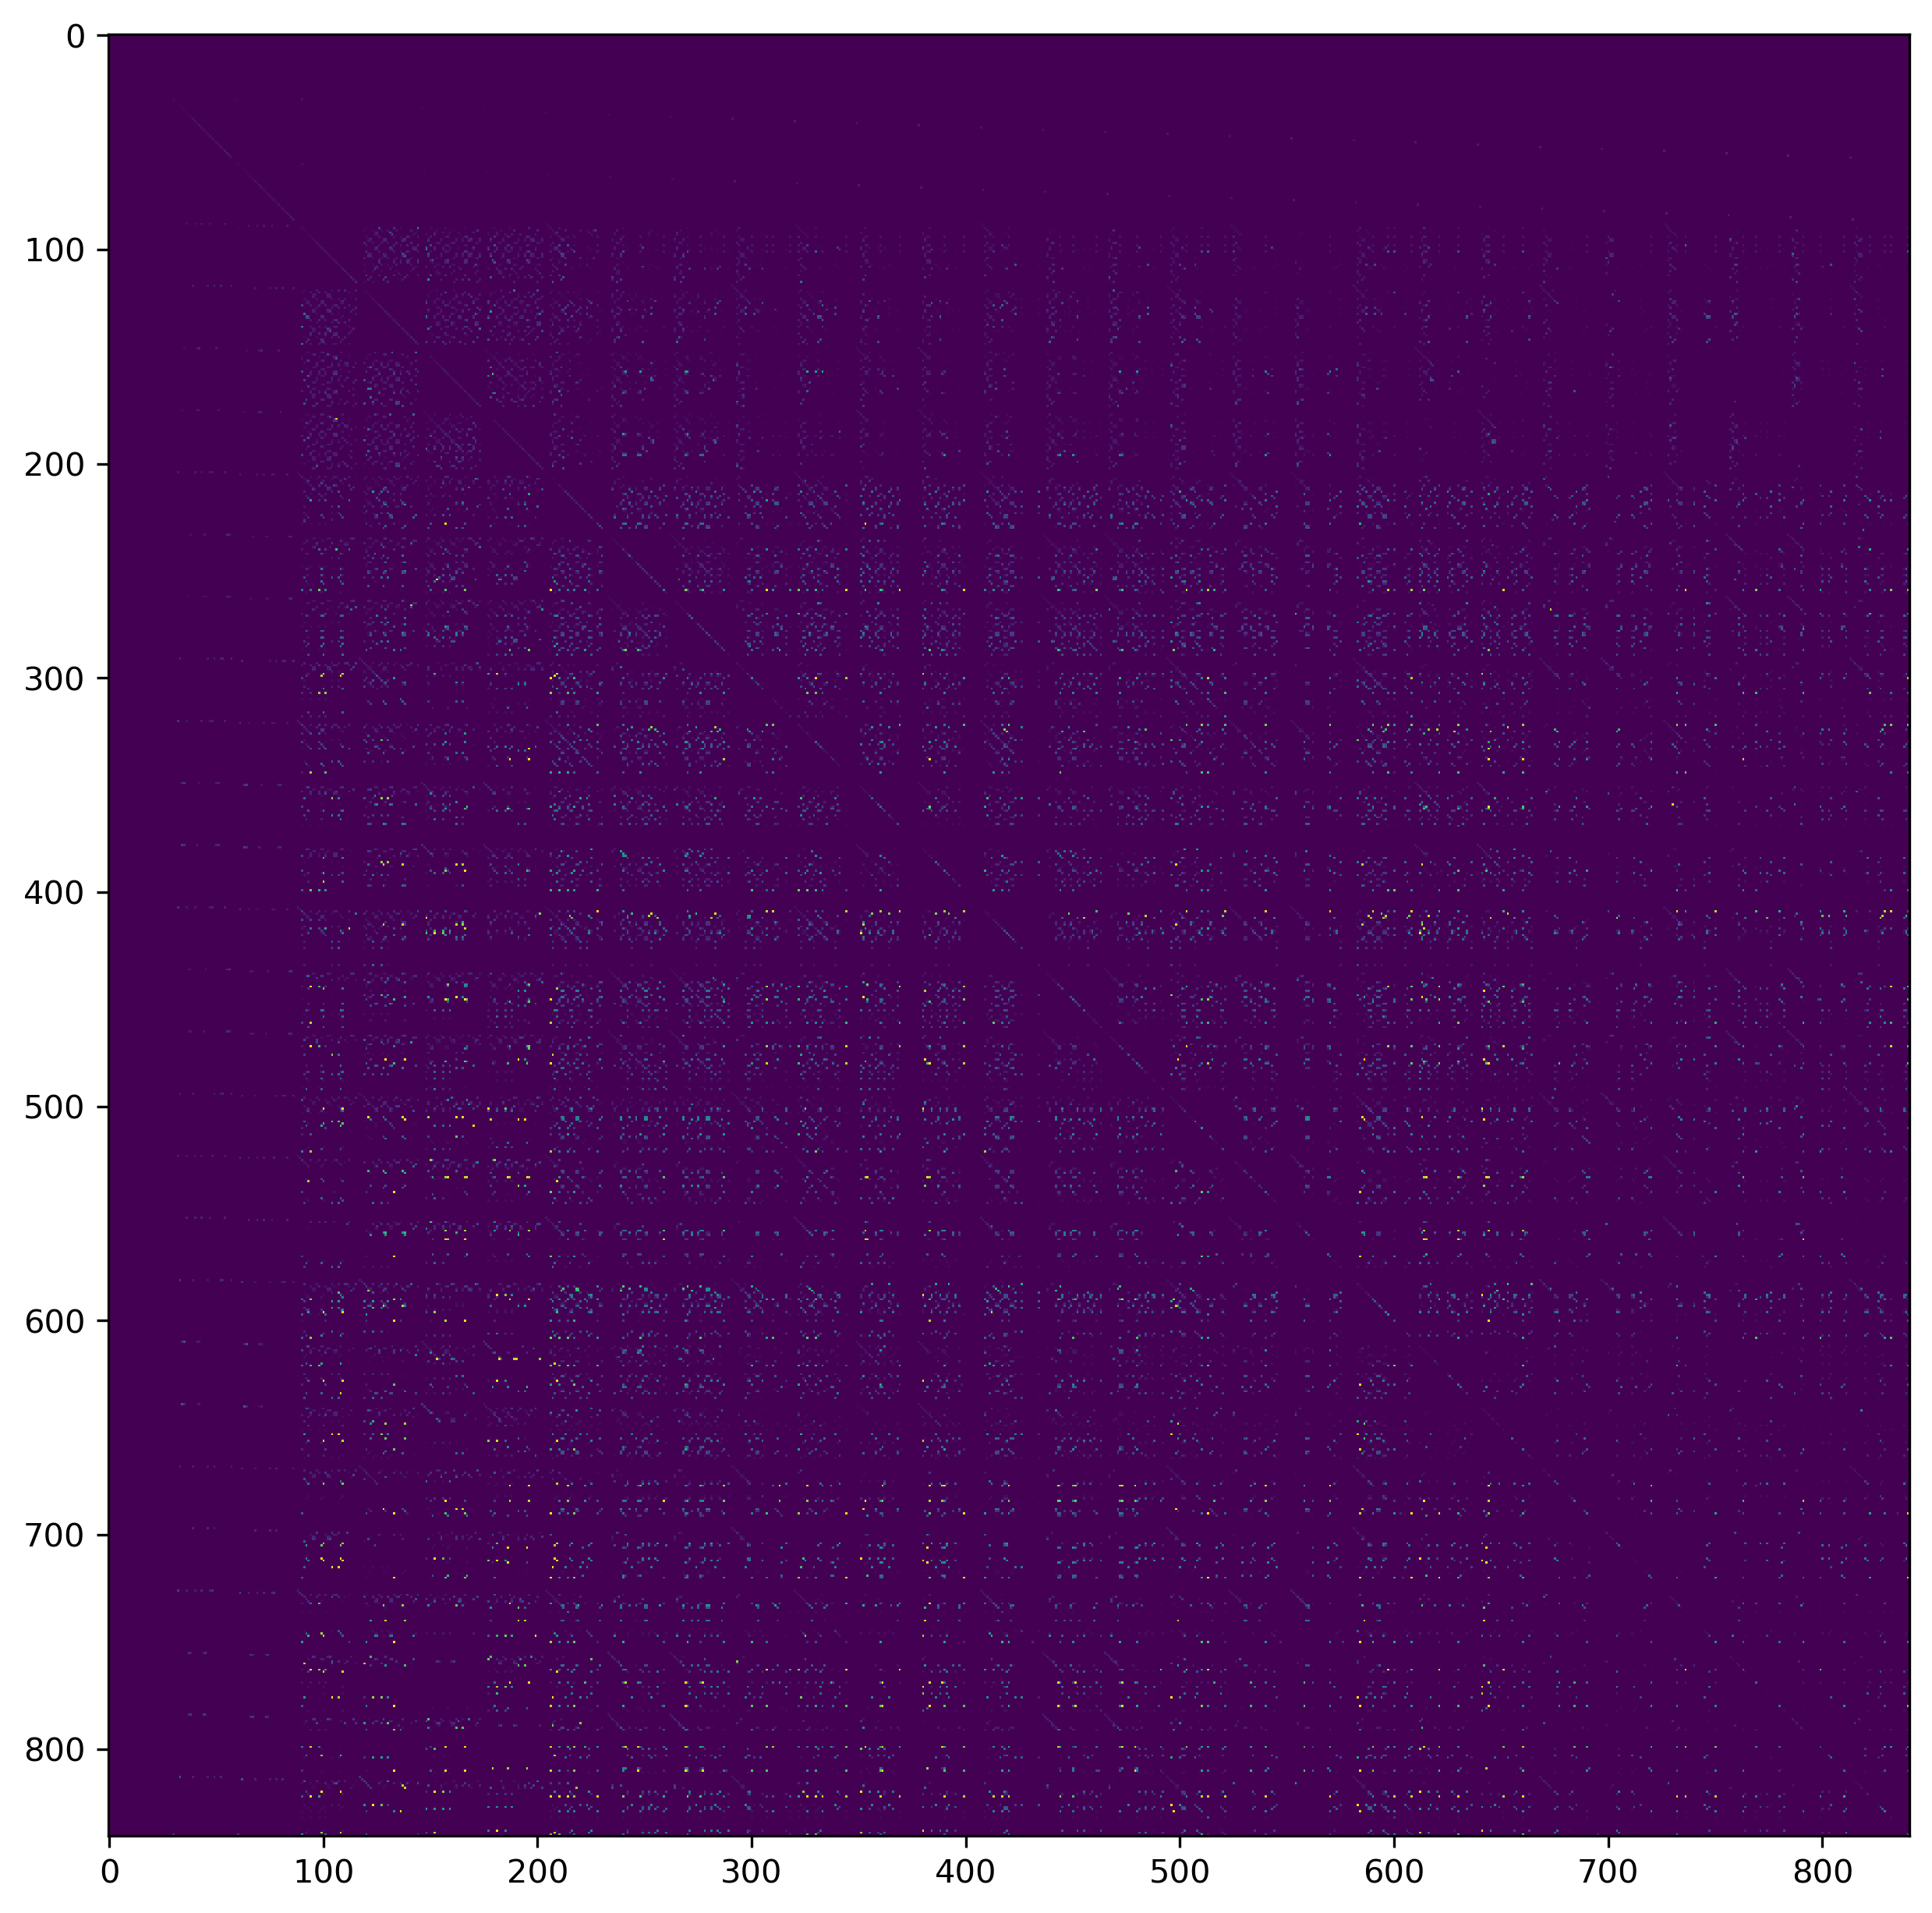

11673.0


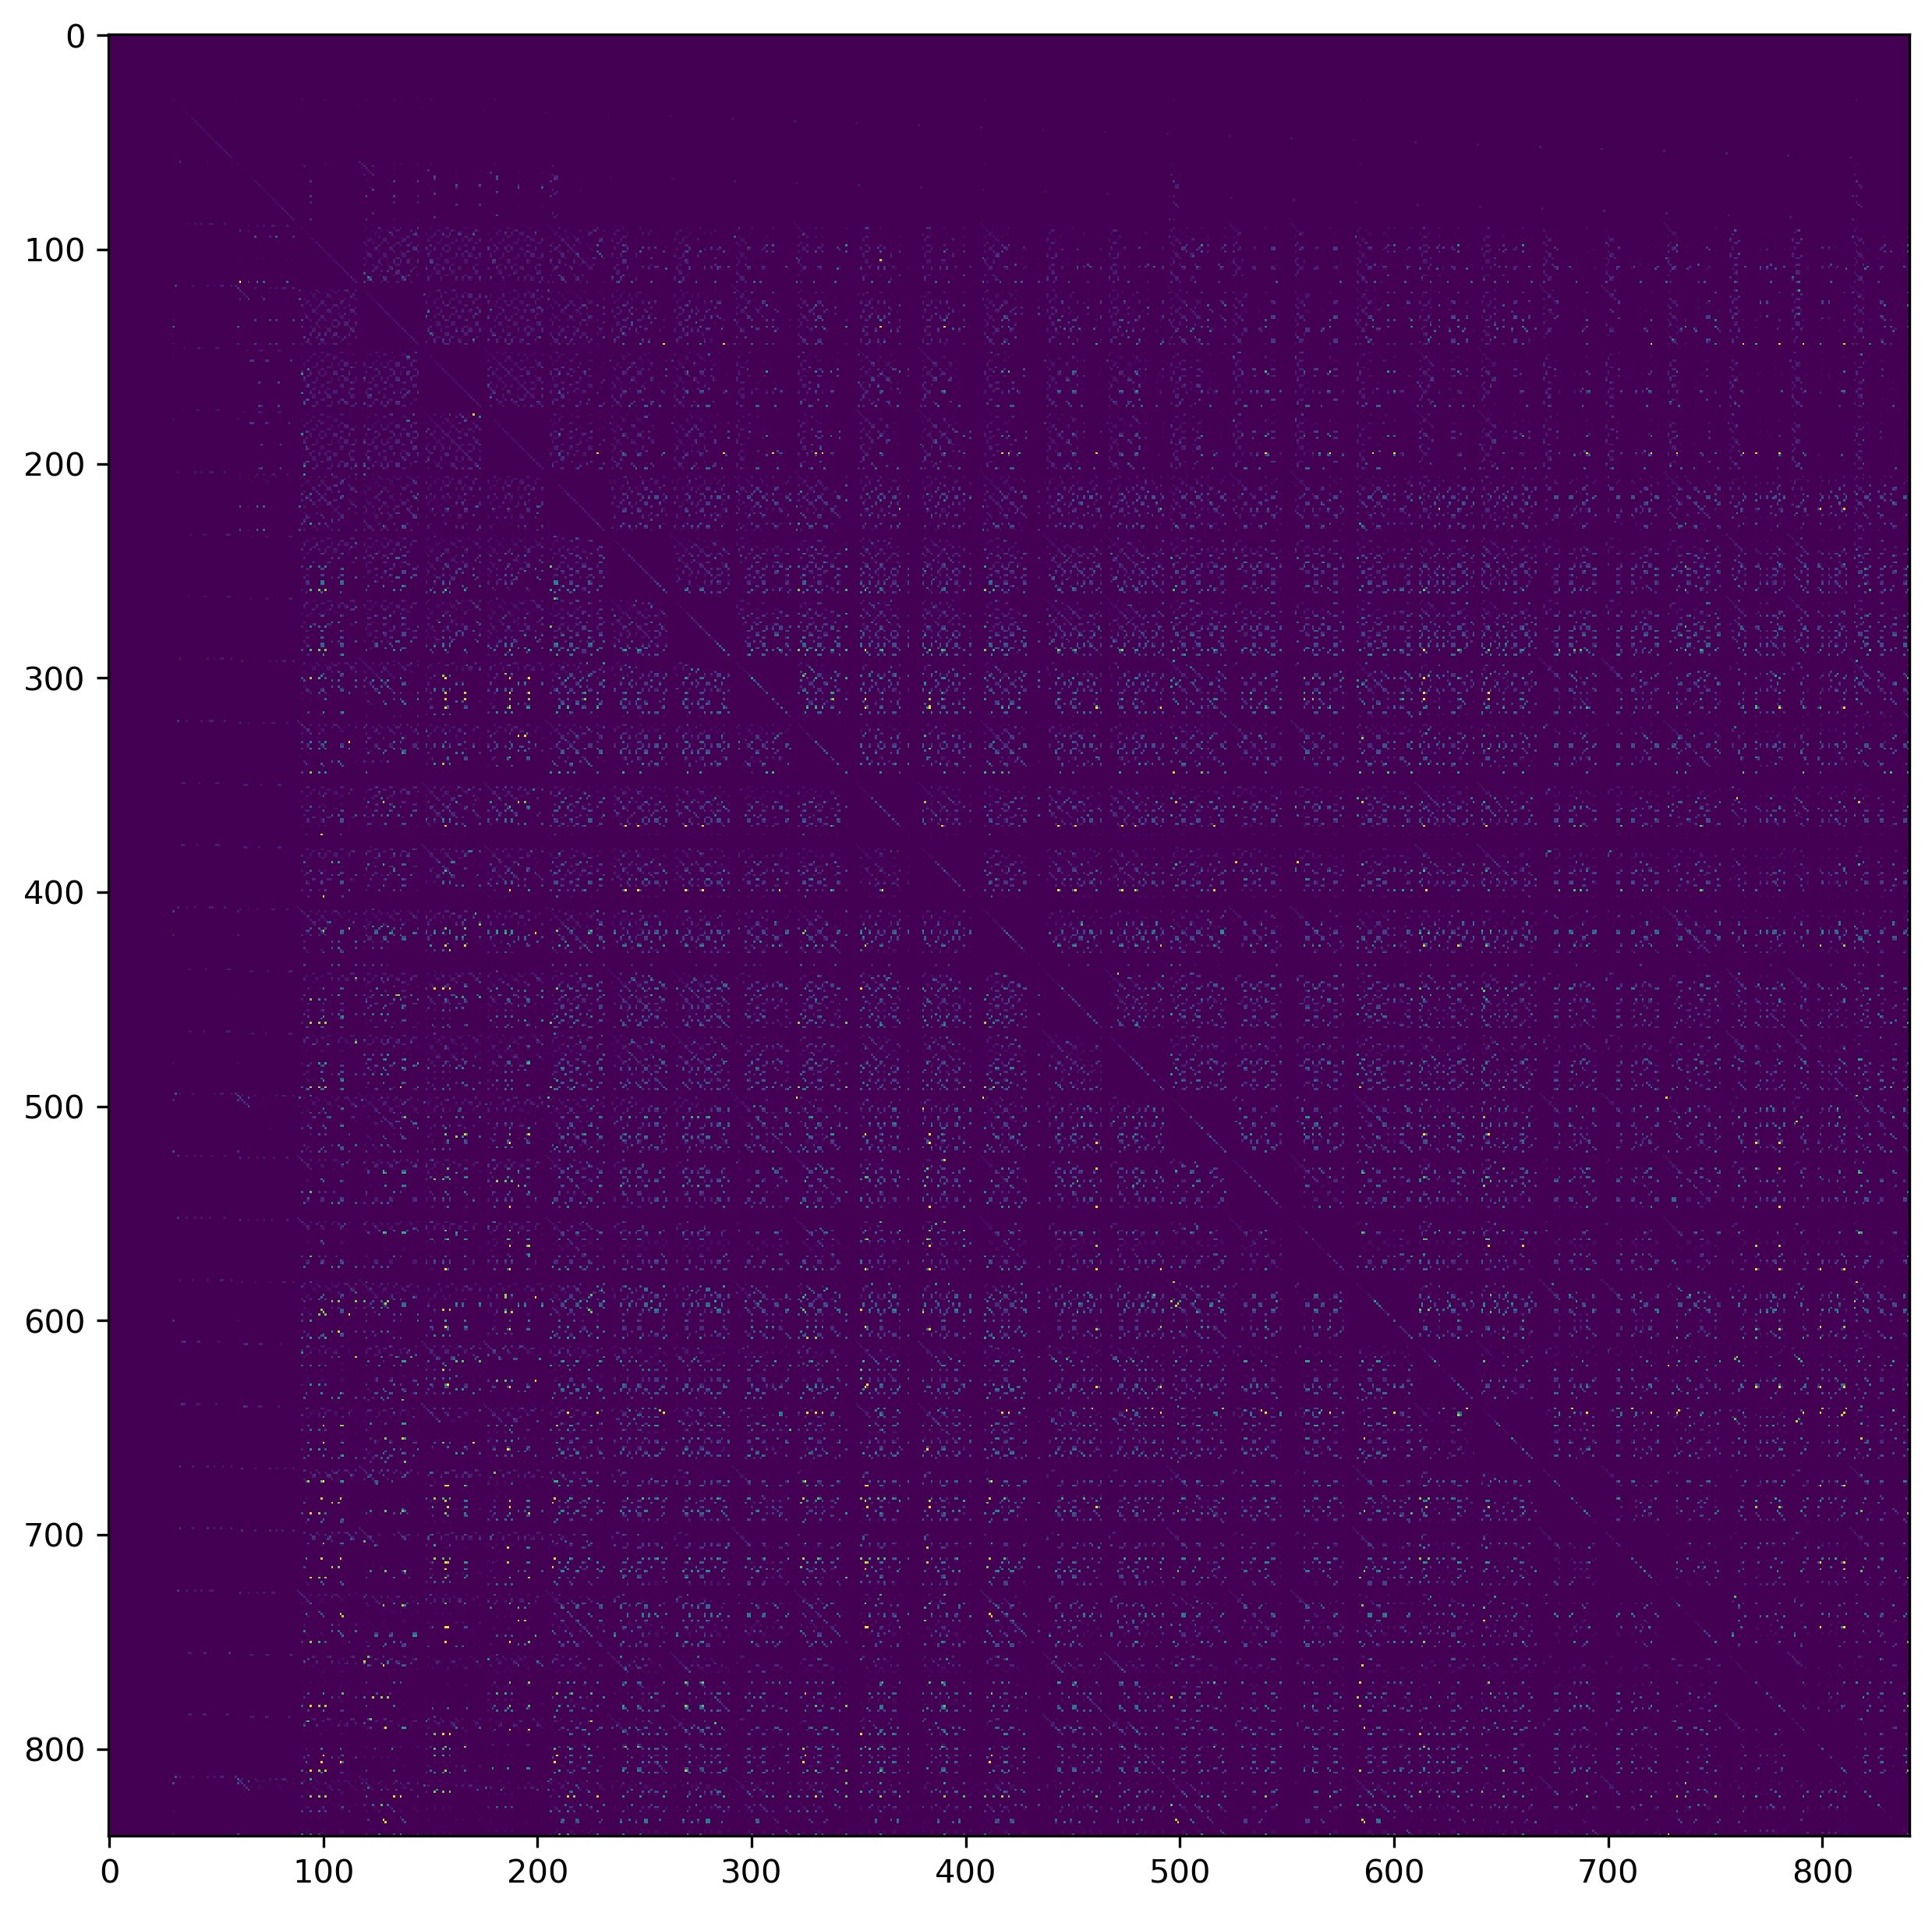

In [48]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 300
for m in re_nomem_maps:
    print(np.max(m))
    plt.imshow(m, cmap='viridis')
    plt.show()

### Tracing Selection without memory

Trace with a new timeline at every step

In [54]:
fci_path='c2_eq_hf_dz.fcidump*'
N_ord, E0, d_one_e_integral, d_two_e_integral = main.load_integrals(f"data/{fci_path}")
timeline = ReuseTimeline(integral_size(d_two_e_integral))

re_sel_nomem_maps = []
for i in range(1, 5):
    wf_path=f"c2_eq_hf_dz_{i}.*.wf*"
    psi_coef, psi_det = main.load_wf(f"data/{wf_path}")
    timeline.reset()
    lewis = TracedHamiltonian(timeline,d_one_e_integral, d_two_e_integral, E0)
    psi_external = main.Excitation(N_ord).gen_all_connected_determinant_from_psi(psi_det)
    h = lewis.H(psi_det,psi_external)
    re_sel_nomem_maps.append(lewis.timeline.view2d())

/nix/store/7nfdbbw2nnr16h26wzmibrppcqdyxrv9-python3.7-ipykernel-5.1.4/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


10223.0


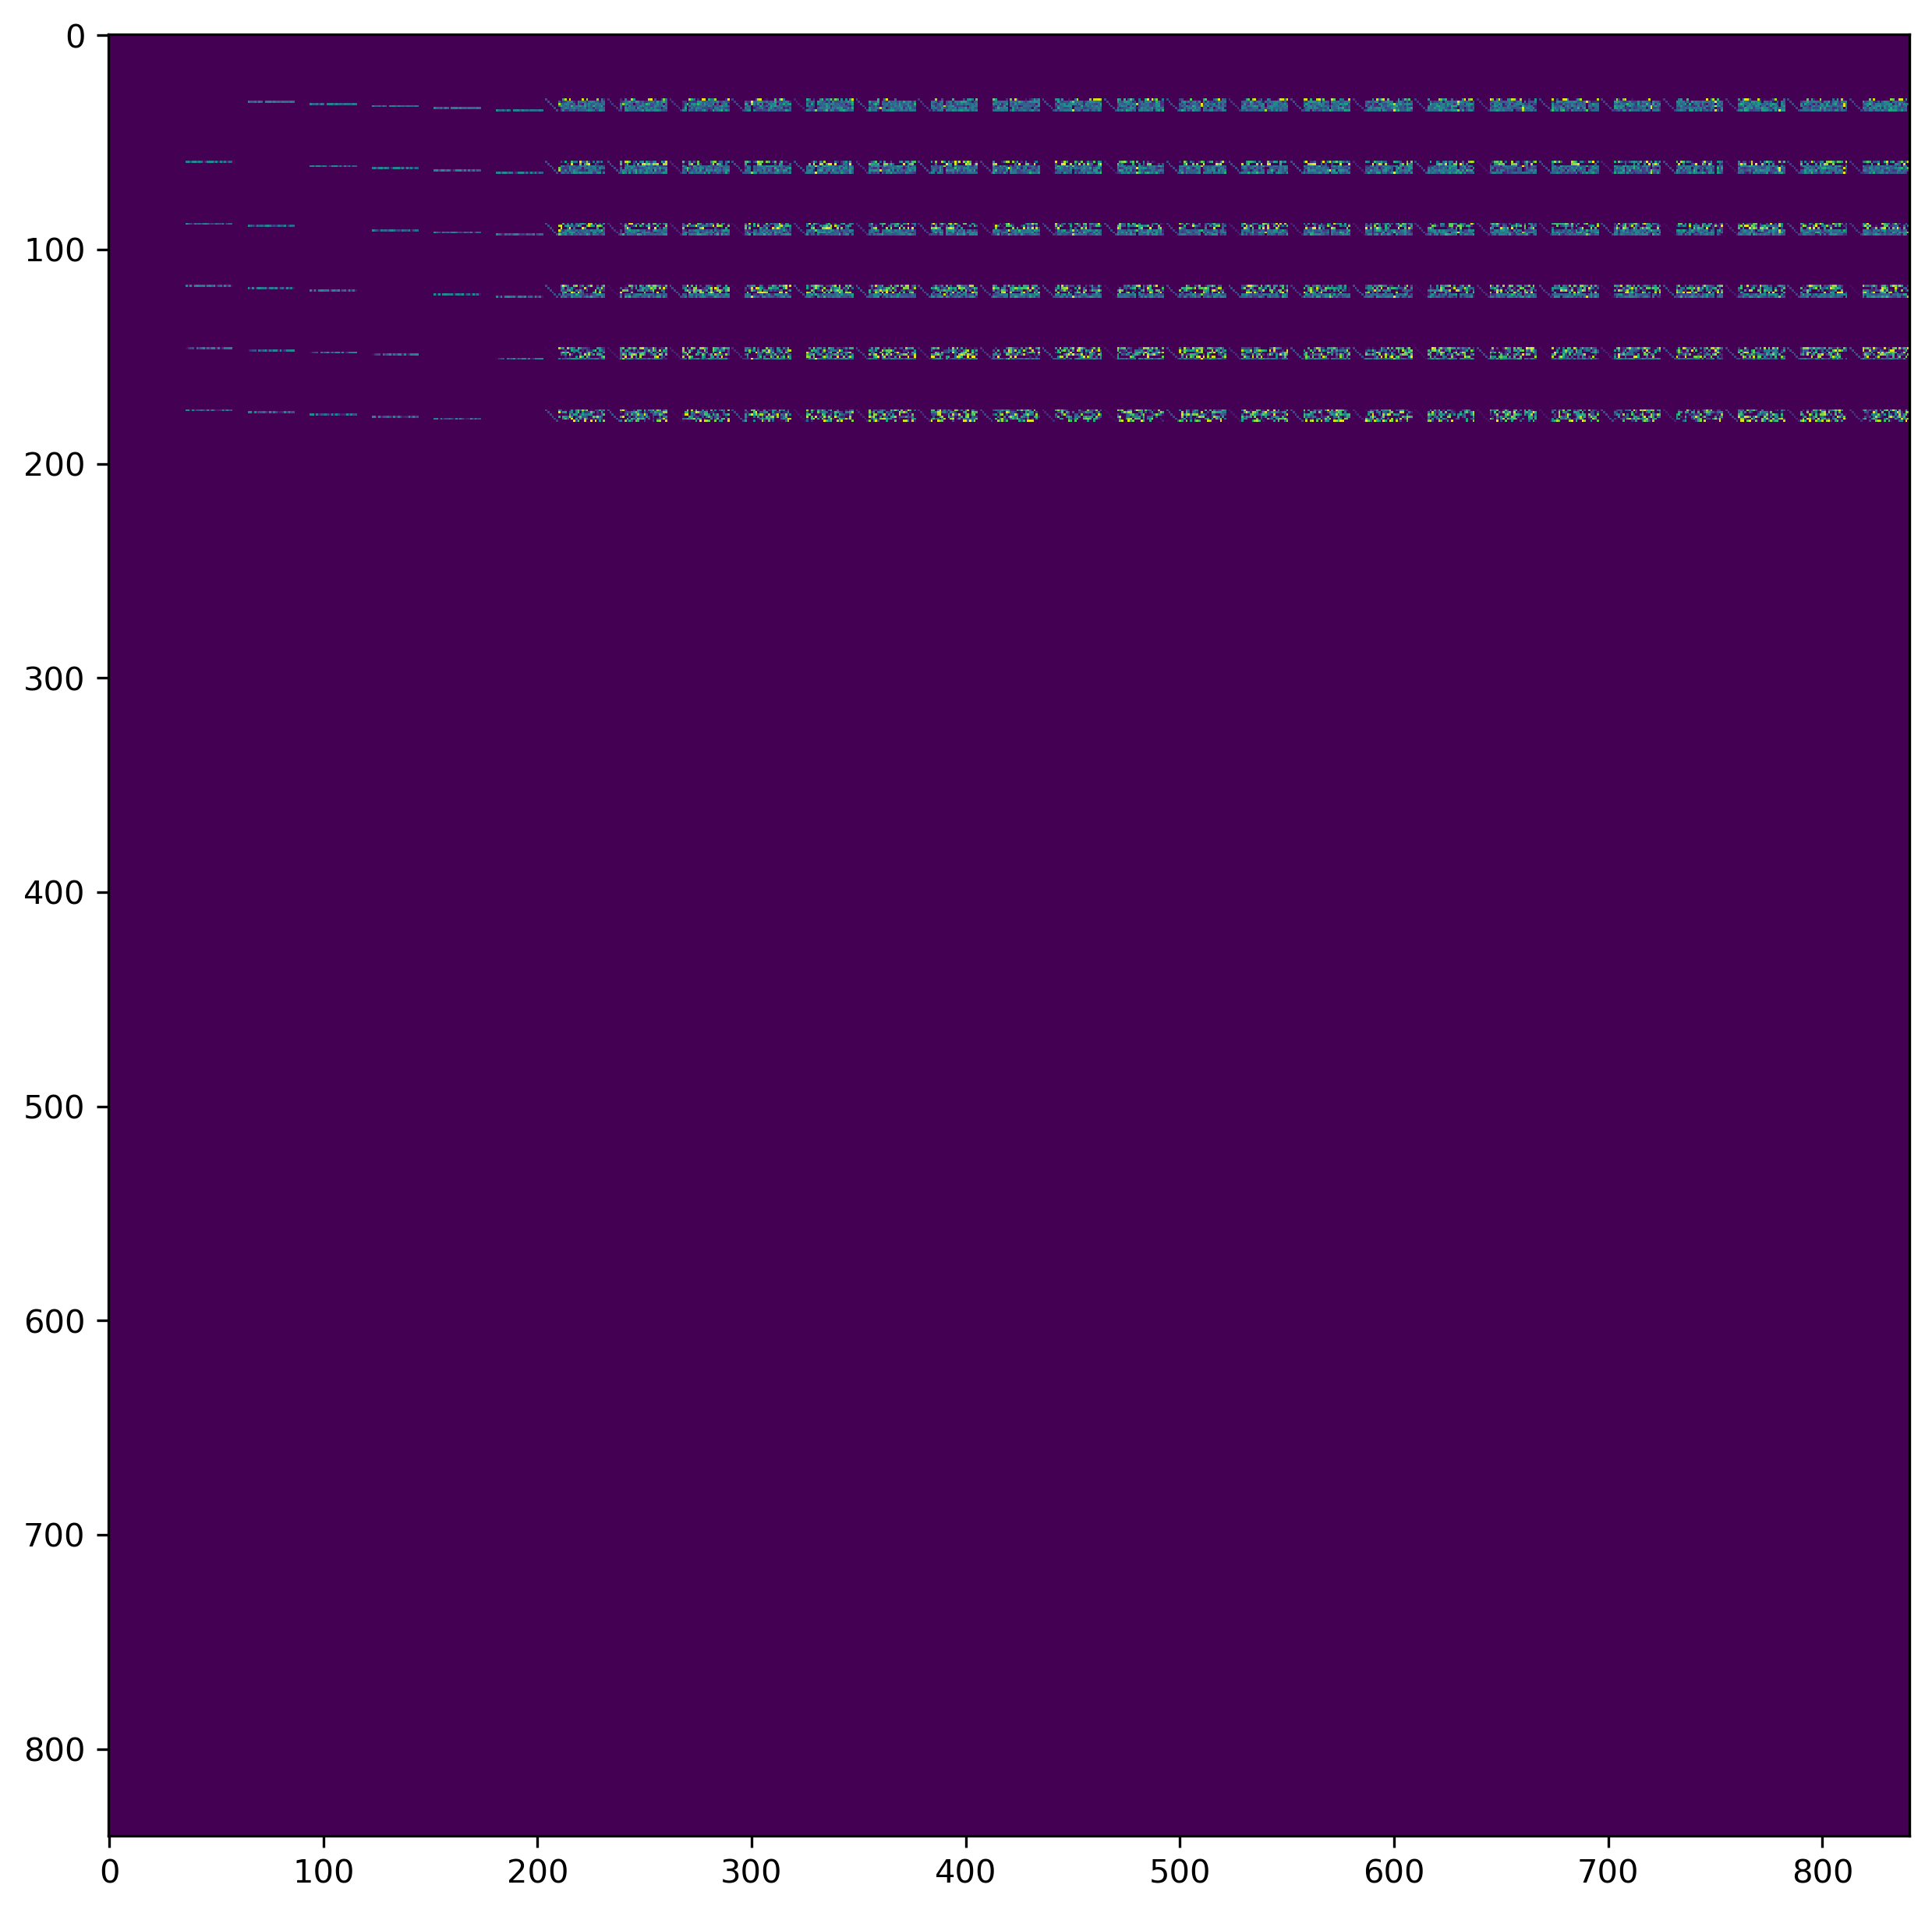

17552.0


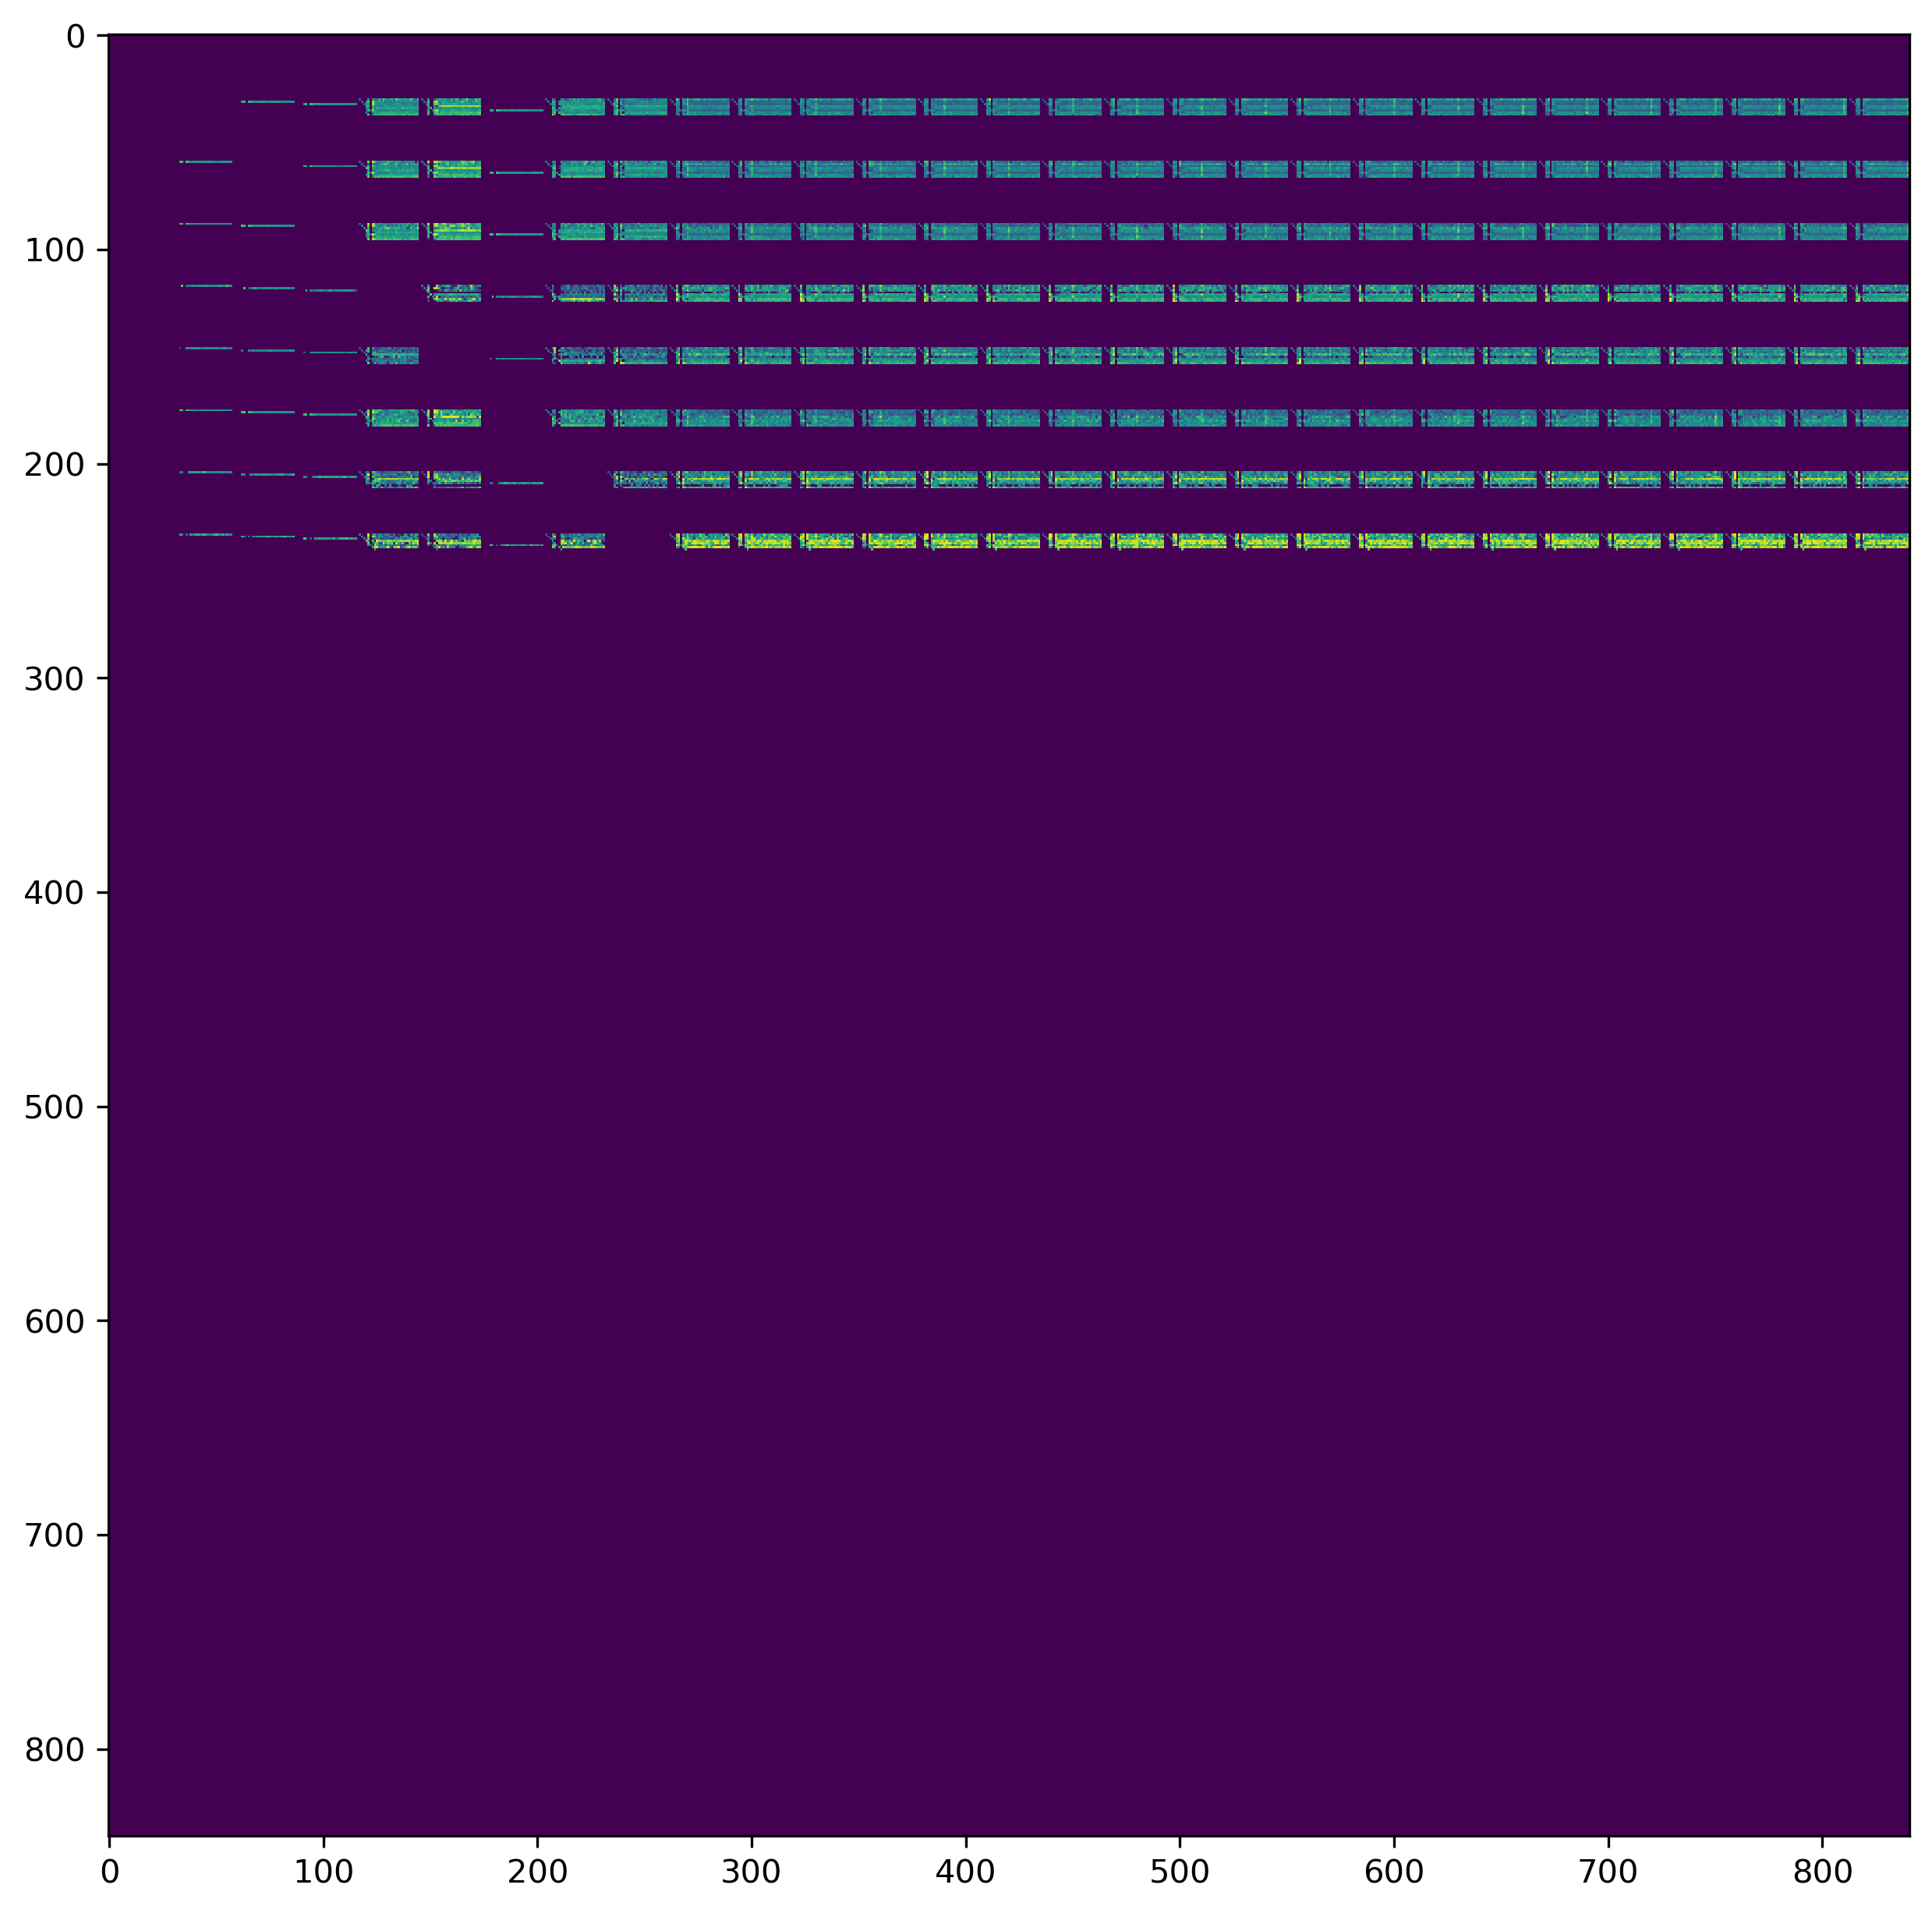

21272.0


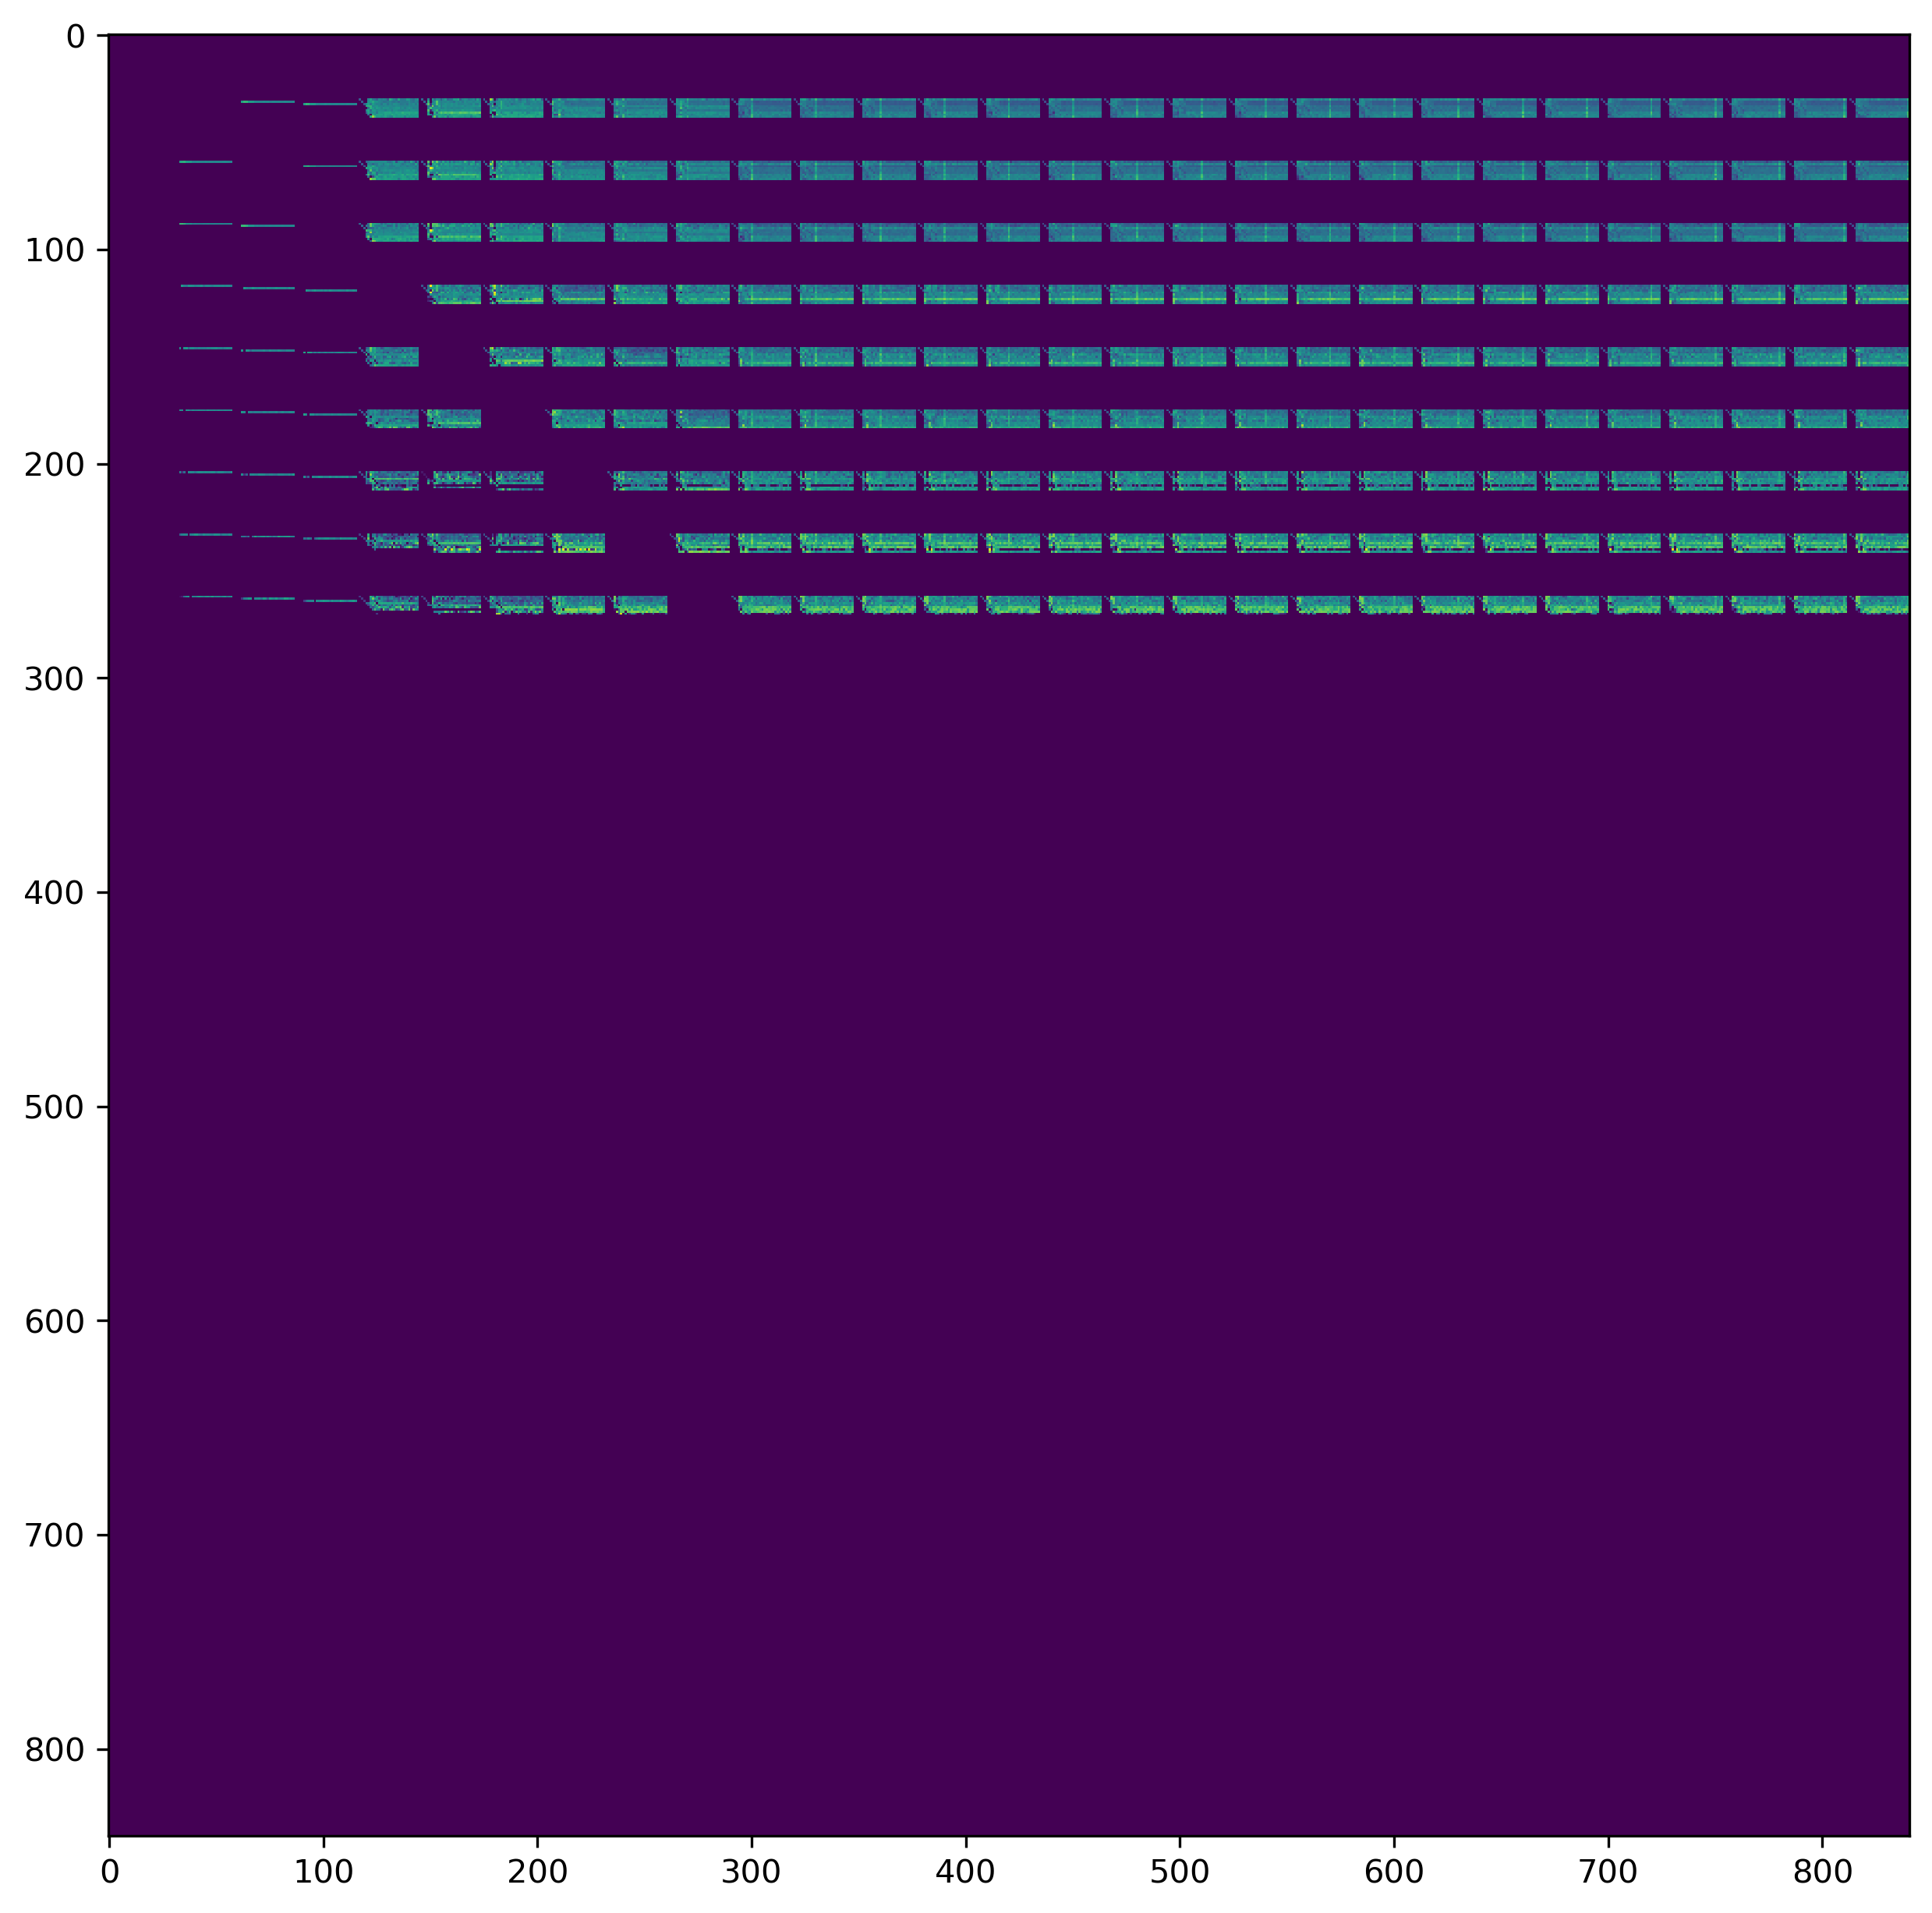

36134.0


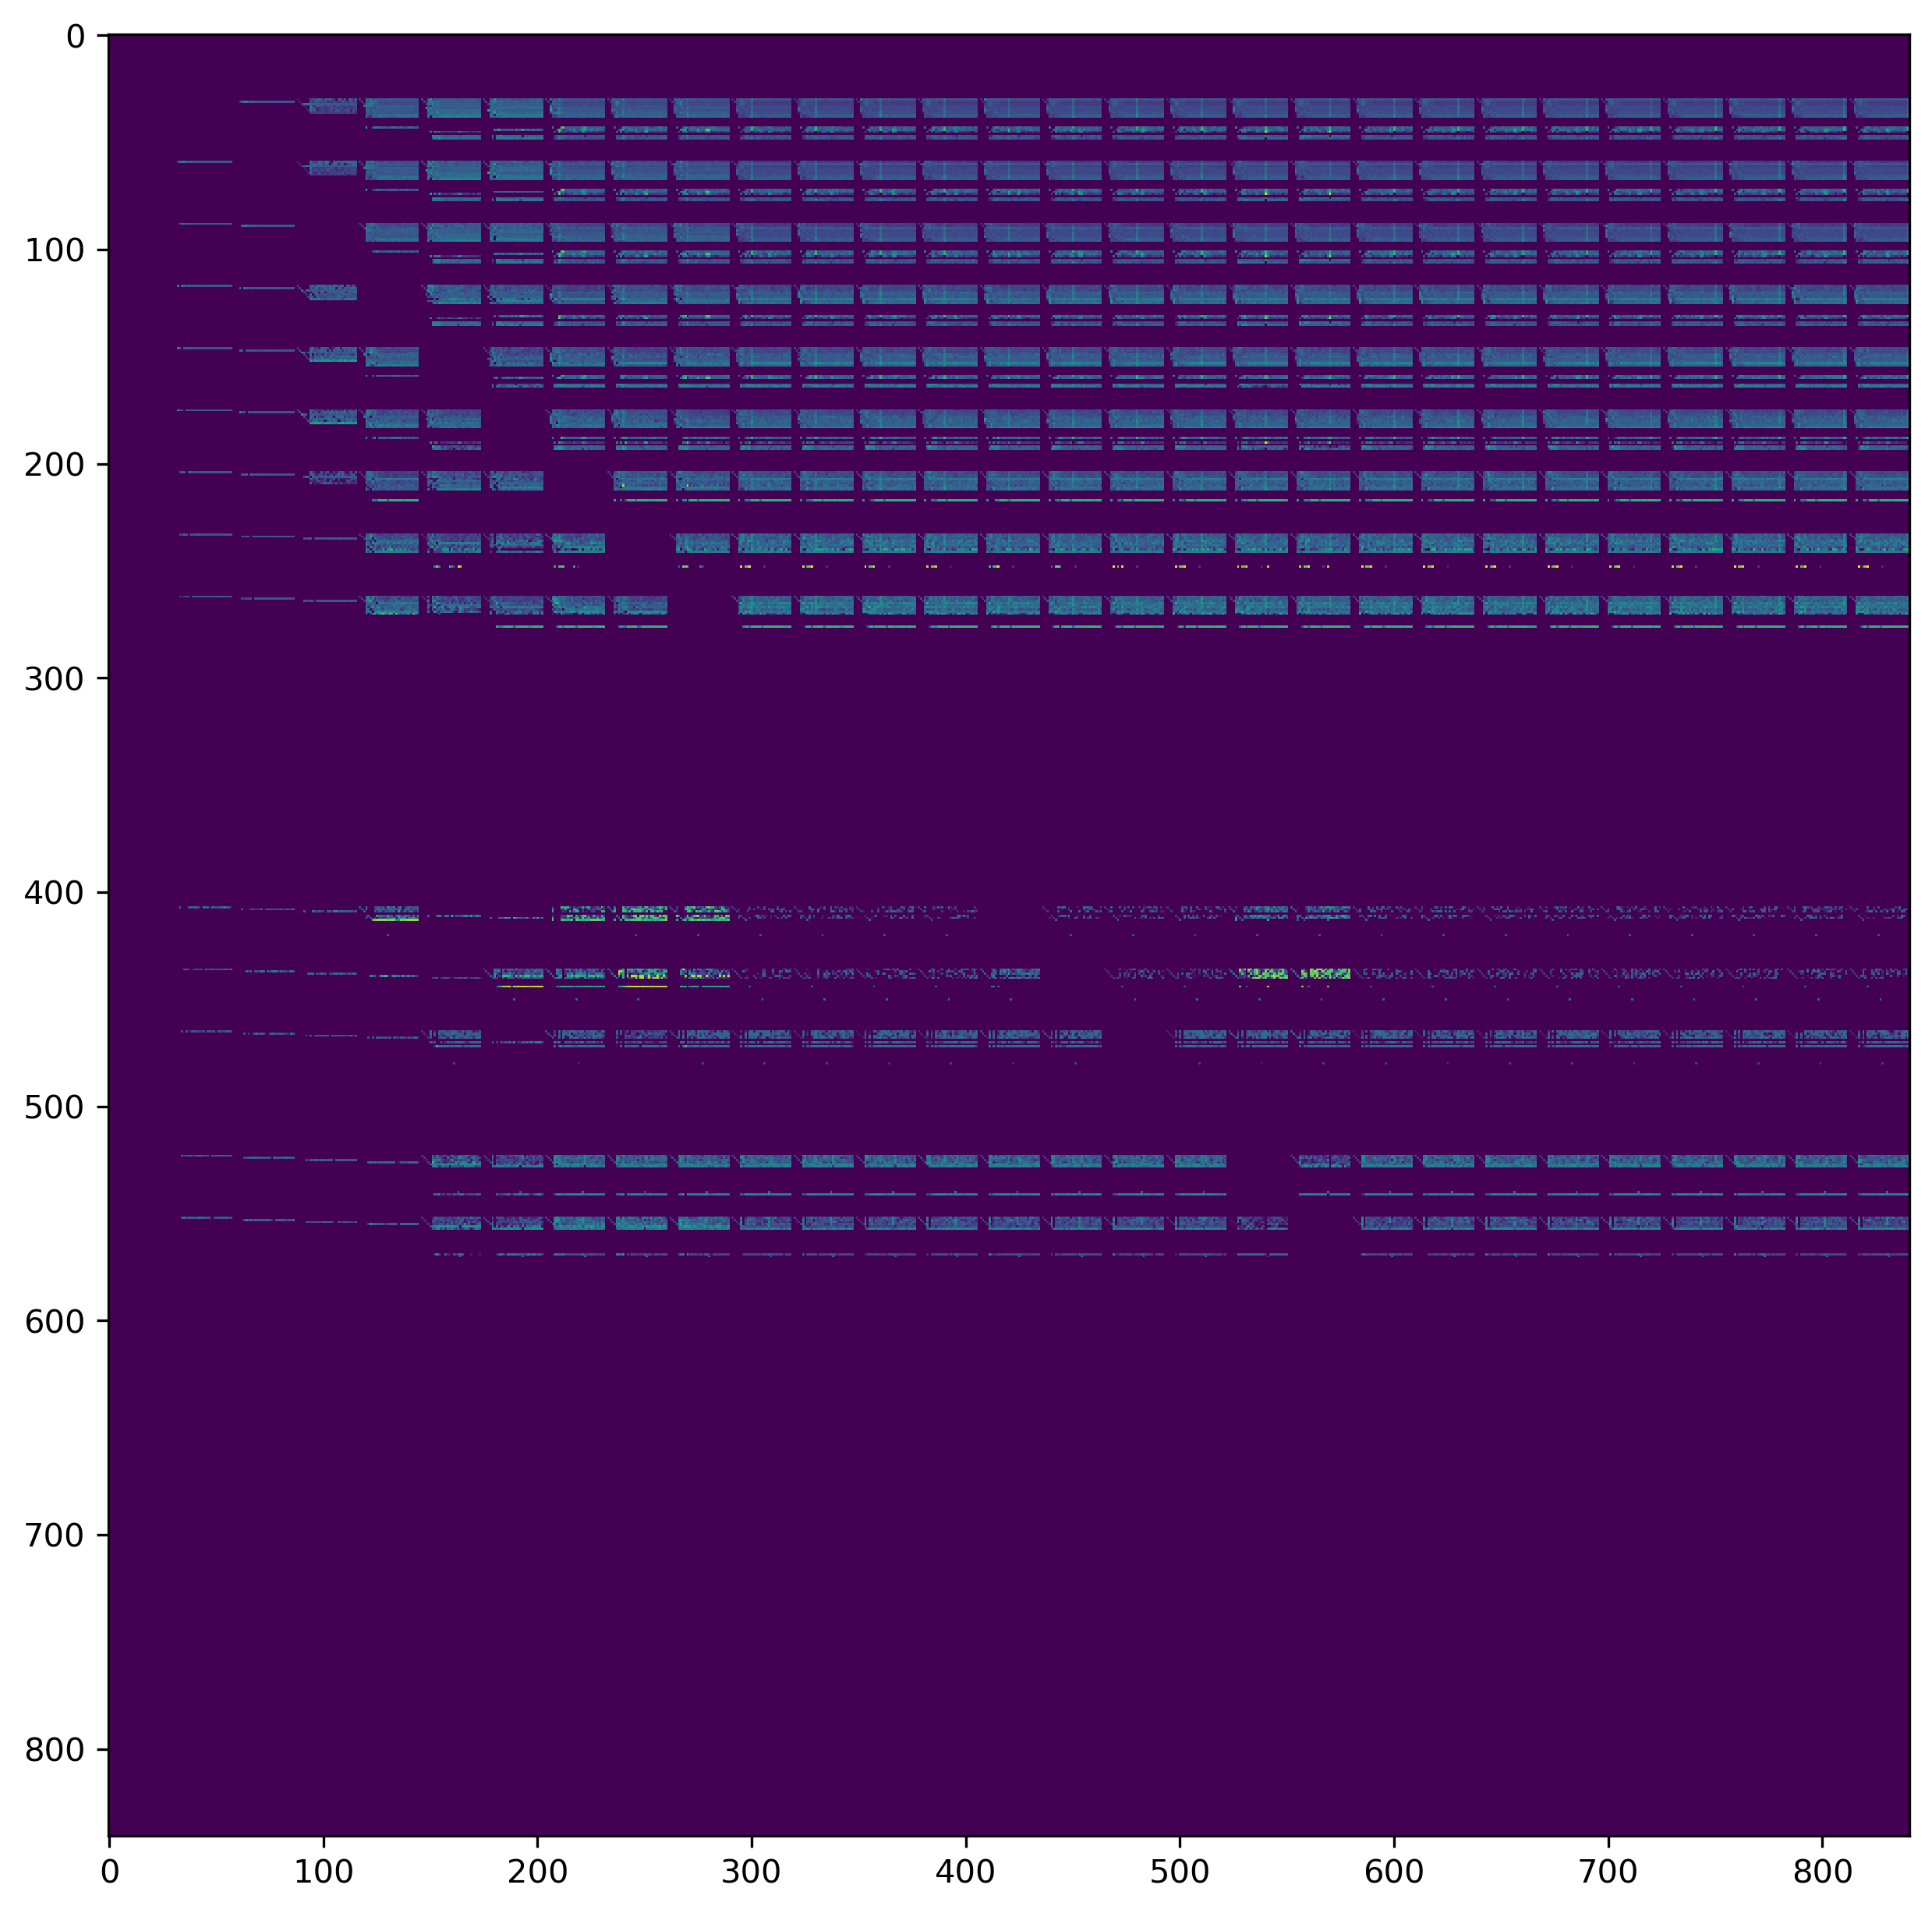

In [55]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 300
for m in re_sel_nomem_maps:
    print(np.max(m))
    plt.imshow(m, cmap='viridis')
    plt.show()